In [8]:
import sys
sys.path.append('F:\Cambridge\Project\MHMC-for-VAE\change_of_variable')
sys.path.append('F:\Cambridge\Project\MHMC-for-VAE\hmc_pytorch')
from change_of_variable_pytorch import * 
from hmc_base_pytorch import *
from hmc_unconstrained_pytorch import *
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt

import torch.utils.data
from torch import optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import time
import torchvision


cuda = True
batch_size = 64
epochs = 10
seed = 1
log_interval = 10
z_dim = 20

# Data preparation
torch.manual_seed(seed)
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size, shuffle=True, **kwargs)

def binarization(data):
    s = np.random.uniform(size = data.shape)
    out = np.array(s<data).astype(float)
    return out

result = []
for batch_idx, (data, _) in enumerate(train_loader):
    data = data.view(-1, 784).numpy()
    bi_data = binarization(data)
    d = torch.from_numpy(bi_data)
    result.append(d)
    
result_test = []
for batch_idx, (data, _) in enumerate(test_loader):
    data = data.view(-1, 784).numpy()
    bi_data = binarization(data)
    d = torch.from_numpy(bi_data)
    result_test.append(d)
    
###############################################
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    #return eps.mul(std).add_(mu)
    return eps*std+mu

def log_prior(z):
    dim = z.shape[1]
    mean = torch.zeros(dim).cuda()
    cov = torch.eye(dim).cuda()
    m = MultivariateNormal(mean, cov)
    m.requires_grad=True
    return m.log_prob(z)

def multivariate_normal_diagonal_logpdf(mean, cov_diag, x):
    n = x.shape[0] # number of samples
    k = x.shape[1] # dimension
    t1 = -0.5*(x - mean)*(1/cov_diag)*(x-mean)
    t1 = torch.sum(t1, dim=1)
    t2 = 0.5*k*torch.log(torch.tensor([2*math.pi]).cuda()) + 0.5*torch.sum(torch.log(cov_diag),dim=1)
    return t1 - t2


In [9]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, 400)
        self.fc2 = nn.Linear(400, 784)
    # single hidden layer
    def forward(self, x):
        #x = x.view(-1, 784)
        h1 = F.relu(self.fc1(x))
        return F.sigmoid(self.fc2(h1))
    
class q_z0(nn.Module):
    def __init__(self):
        super(q_z0, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        #self.fc2 = nn.Linear(300, 300)
        self.fc31 = nn.Linear(300, z_dim)
        self.fc32 = nn.Linear(300, z_dim)
    def forward(self, x):
        x = x.view(-1, 784)
        h1 = F.tanh(self.fc1(x))
        #h2 = F.softplus(self.fc2(h1))
        logvar = self.fc31(h1)
        mu = self.fc32(h1)
        return mu, logvar
    
class r_v(nn.Module):
    def __init__(self):
        super(r_v, self).__init__()
        self.fc1 = nn.Linear(z_dim + 784, 300)
        self.fc21 = nn.Linear(300, z_dim)
        self.fc22 = nn.Linear(300, z_dim)
    def forward(self, x):
        x = x.view(-1, 784 + z_dim)
        h1 = F.softplus(self.fc1(x))
        logvar = self.fc21(h1)
        mu = self.fc22(h1)
        return mu, logvar

In [10]:
decoder = decoder().to(device)
q_z0 = q_z0().to(device)
r_v = r_v().to(device)

In [4]:
input = torch.randn((3, 2), requires_grad=True)
target = torch.rand((3, 2), requires_grad=False)


In [5]:
loss = F.binary_cross_entropy(F.sigmoid(input), target)
loss

tensor(0.7877)

In [22]:
loss2 = F.binary_cross_entropy(F.sigmoid(input), target, size_average=False)
loss2

tensor(4.4854)

In [11]:
def ELBO(data, decoder, q_z0, r_v, T):#q_z0_mean, q_z0_logvar):
    batch_size = data.view(-1, 784).shape[0]
    data = data.to(device)
    
    q_z0_mean, q_z0_logvar = q_z0(data)
    # sample z0
    z0 = reparameterize(q_z0_mean, q_z0_logvar)
    
    # compute q(z0|x)
    var_z0 = torch.exp(q_z0_logvar)
    log_q_z0 = multivariate_normal_diagonal_logpdf(q_z0_mean, var_z0, z0)
    
    # compute prior
    log_prior_z0 = log_prior(z0)
    
    # compute joint
    decoder_output = decoder(z0)
    log_likelihood = 0. - F.binary_cross_entropy(decoder_output, data.view(-1, 784).float(), size_average=False, reduce=False)
    #tt = 0. - F.binary_cross_entropy(decoder_output, data.view(-1, 784).float(), size_average=False)
    log_likelihood = torch.sum(log_likelihood, dim = 1)
    #print("tt: "+str(tt.shape))
    #print("log_likelihood: "+str(log_likelihood.shape))
    log_joint = log_prior_z0 + log_likelihood
    
    # initial L
    L = log_joint - log_q_z0
    print("joint: "+str(torch.mean(log_joint)))
    print("q(z0): "+str(torch.mean(log_q_z0)))
    """
    for i in range(T):
        # sample v1
        logvar_v1 = torch.zeros([batch_size, z_dim], requires_grad = True).cuda()
        var_v1 = torch.exp(logvar_v1)
        mu_v1 = torch.zeros([logvar_v1.shape[0], logvar_v1.shape[1]],requires_grad = True).cuda()
        v1 = reparameterize(mu_v1, logvar_v1)
        
        # compute q(v1|x) 
        log_q_v1 = multivariate_normal_diagonal_logpdf(mu_v1, var_v1 ,v1)
        
        mass_diag = 1/var_v1
        
        
        for j in range(batch_size):
            def energy_function(z, cache):
                z.retain_grad()
                z = z.view(1, z.shape[0])
                z_cuda = z.cuda()
                one_log_prior = log_prior(z_cuda)
                decoder_output = decoder(z_cuda)
                one_log_likelihood = 0. - F.binary_cross_entropy(decoder_output, data.view(-1, 784)[j].float(), size_average=False, reduce=False)
                one_log_likelihood = torch.sum(one_log_likelihood, dim = 1)
                one_log_joint = one_log_prior + one_log_likelihood
                return 0 - one_log_joint
            
            # init sampler
            sampler = IsotropicHmcSampler(energy_function, energy_grad=None, prng=None,
                                          mom_resample_coeff=1., dtype=np.float64)
            
            #init = torch.zeros(z_dim).cuda()
            init = z0[j]
            mass_matrix = torch.diag(mass_diag[j])
            
            # run sampler
            pos_samples, mom_samples, ratio = sampler.get_samples(init, 0.05, 5, 2, mass_matrix, mom = v1[j].view(z_dim))
            zt = pos_samples[1].cuda()
            vt = mom_samples[1].cuda()
            
            zt = zt.view(1, zt.shape[0])
            vt = vt.view(1, vt.shape[0])
            
            # get joint probaility p(x, zt)
            one_log_prior_zt = log_prior(zt)
            one_decoder_output_t = decoder(zt)
            
            one_log_likelihood_t = 0. - F.binary_cross_entropy(one_decoder_output_t, data.view(-1, 784)[j].float(), size_average=False, reduce=False)
            one_log_likelihood_t = torch.sum(one_log_likelihood_t, dim = 1)
            #print("one_log_likelihood_t: " + str(one_log_likelihood_t.shape))
            one_log_joint_t = one_log_prior_zt + one_log_likelihood_t
            
            # get r(vt|x,zt)
            d = data.view(-1, 784)[j].view(1, 784)
            one_new_data = torch.cat((d.float(), zt), 1) # append data with zt
            one_mu_vt, one_logvar_vt = r_v(one_new_data)
            one_var_vt = torch.exp(one_logvar_vt)
            
            
            one_log_r_vt = multivariate_normal_diagonal_logpdf(one_mu_vt, one_var_vt, vt)
            
            # get L for each sample
            one_log_alpha = one_log_joint_t + one_log_r_vt - log_joint[j] - log_q_v1[j]
            
            L[j] = L[j] + one_log_alpha
    
    """
    """
    m = torch.zeros([num, dim], requires_grad=True)
    v = torch.ones([num, dim], requires_grad=True)
    log_prior_z0 = multivariate_normal_diagonal_logpdf(m,v,z0)
    """
    return torch.mean(L)

Epoch: 1
++++++++++ batch: 0 ++++++++++
joint: tensor(-114.3354, device='cuda:0')
q(z0): tensor(-5.8659, device='cuda:0')
ELBO: -108.46946716308594
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0184,  0.0328,  0.0074,  ...,  0.0692,  0.0140, -0.0817],
        [-0.0017, -0.0430,  0.0684,  ...,  0.0246,  0.0559, -0.0562],
        [-0.0062, -0.0809,  0.1612,  ...,  0.1981,  0.0544, -0.1547],
        ...,
        [-0.0709, -0.0212, -0.1266,  ..., -0.0168, -0.0846,  0.0692],
        [-0.0624, -0.0990, -0.0067,  ...,  0.2113, -0.0194, -0.2085],
        [-0.0467,  0.0262,  0.0159,  .

tensor([[-0.0502,  0.0124, -0.1095,  ...,  0.0123,  0.0103, -0.0219],
        [ 0.0370, -0.0492,  0.0744,  ...,  0.0906,  0.0306, -0.0669],
        [-0.0664, -0.0737, -0.0083,  ...,  0.0521,  0.0786, -0.0863],
        ...,
        [ 0.1132, -0.0085,  0.0822,  ..., -0.0310, -0.0515,  0.0156],
        [-0.0354,  0.0425, -0.1220,  ..., -0.0761, -0.0509,  0.0527],
        [-0.0843, -0.1244, -0.0416,  ...,  0.1663,  0.1277, -0.1333]], device='cuda:0')
tensor([[ 0.1036, -0.0877, -0.0080,  ..., -0.2073, -0.0311, -0.1604],
        [-0.1002, -0.2290,  0.2451,  ...,  0.4915,  0.2396, -0.2103],
        [ 0.0191,  0.1536, -0.0647,  ...,  0.0056, -0.0936,  0.2519],
        ...,
        [ 0.0917,  0.1632, -0.5955,  ..., -0.4251, -0.4312,  0.1527],
        [ 0.0761,  0.1771,  0.1952,  ...,  0.4731, -0.0486, -0.1784],
        [-0.1791,  0.5347, -0.4747,  ..., -0.7325, -0.4450,  0.4672]], device='cuda:0')
++++++++++ batch: 10 ++++++++++
joint: tensor(-113.0897, device='cuda:0')
q(z0): tensor(-3.9817, d

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-4.4808e-02, -1.0397e-01, -5.0633e-02,  ...,  1.3848e-01,
          9.0507e-02, -1.3540e-01],
        [ 1.0276e-01,  4.7258e-02,  3.0788e-02,  ..., -1.8786e-02,
         -2.3785e-02,  1.5343e-02],
        [ 7.9204e-02,  1.8528e-02, -1.7107e-02,  ..., -1.2512e-01,
         -3.9666e-02,  8.4775e-02],
        ...,
        [ 1.1123e-01,  1.9593e-02,  3.6357e-02,  ..., -1.5649e-01,
         -8.9246e-02,  1.2254e-01],
        [-5.5147e-02, -4.0208e-02, -3.9870e-02,  ...,  3.2709e-03,
          2.5774e-02,  8.6393e-03],
        [-8.0585e-02,

joint: tensor(-110.9903, device='cuda:0')
q(z0): tensor(-4.5644, device='cuda:0')
ELBO: -106.42591857910156
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0208,  0.0608,  0.0009,  ..., -0.0054,  0.0027,  0.0380],
        [ 0.0378,  0.0352, -0.0818,  ..., -0.0874, -0.0387,  0.0868],
        [ 0.0281,  0.0131, -0.0179,  ..., -0.0580, -0.0205,  0.0412],
        ...,
        [-0.0062,  0.0125,  0.0031,  ...,  0.0123, -0.0123, -0.0222],
        [ 0.0079,  0.1001, -0.0266,  ..., -0.1160, -0.0808,  0.0265],
        [-0.0594, -0.0312, -0.0039,  ...,  0.1970,  0.1125, -0.1218]], device=

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.6976e-02,  1.8672e-02,  2.1823e-02,  ..., -3.5233e-02,
         -1.9271e-02, -1.9098e-02],
        [-3.7826e-02,  2.0364e-02, -1.5086e-02,  ..., -3.1329e-02,
         -1.0657e-02,  4.8122e-02],
        [ 8.9573e-03,  1.0789e-02,  1.4977e-02,  ..., -3.9350e-03,
         -5.2663e-02, -1.6123e-02],
        ...,
        [-1.8339e-01, -6.7085e-02,  1.5395e-02,  ...,  6.3006e-02,
          8.7438e-02, -3.2941e-02],
        [-4.0942e-02,  4.5383e-03, -1.7175e-02,  ...,  4.0812e-02,
         -5.6461e-02,  2.5130e-02],
        [ 1.0879e-01,

tensor([[-6.5924e-04,  9.6697e-02, -6.5881e-02,  ..., -6.7600e-02,
         -1.9873e-02,  4.1498e-02],
        [-2.6544e-02, -3.2252e-02, -9.1068e-02,  ...,  1.2697e-01,
          8.5504e-02, -8.1236e-02],
        [-9.3227e-02,  4.5102e-03,  7.9823e-03,  ...,  3.7432e-02,
          2.3925e-02, -2.5235e-02],
        ...,
        [ 2.5269e-02,  2.5140e-02, -5.7508e-02,  ..., -7.3194e-02,
         -5.5358e-02,  4.1141e-02],
        [-4.6427e-02,  3.9580e-02,  1.4963e-02,  ..., -2.3539e-02,
          3.9349e-02,  4.2090e-03],
        [ 3.8048e-02,  9.6597e-02, -2.1305e-02,  ..., -1.1733e-01,
         -5.3445e-02,  6.8650e-02]], device='cuda:0')
tensor([[ 0.5473,  0.2835, -0.2095,  ..., -0.9394, -0.6777,  0.7776],
        [ 0.2202,  0.3678,  0.1766,  ..., -0.8436, -0.4110,  0.5728],
        [ 1.0382,  1.0973, -0.6185,  ..., -1.7283, -1.0048,  1.2861],
        ...,
        [-0.2257, -1.3333,  0.8637,  ...,  1.7847,  0.8660, -1.1584],
        [ 0.9346,  1.0714, -0.3032,  ..., -2.2704, -1.3563

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.2381e-03,  2.3108e-02,  4.2760e-02,  ..., -3.9845e-02,
         -2.0200e-02,  7.8173e-02],
        [-4.6575e-02, -5.0378e-02, -2.9707e-02,  ...,  8.5339e-02,
          3.6897e-02, -1.0433e-01],
        [ 2.2542e-02,  5.4317e-03, -2.1222e-02,  ..., -4.8017e-02,
          2.1457e-02, -1.5156e-02],
        ...,
        [ 8.0881e-02, -3.6845e-02,  3.2660e-03,  ..., -4.4946e-03,
         -3.7928e-02,  4.0328e-02],
        [ 1.3534e-02,  5.3281e-02,  4.9668e-02,  ..., -3.2100e-02,
         -4.2492e-02,  3.5177e-02],
        [-4.4140e-03,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0269, -0.0447, -0.0407,  ...,  0.0425,  0.0469, -0.0574],
        [ 0.0824,  0.0572,  0.0061,  ..., -0.1133, -0.0780,  0.0732],
        [ 0.0439, -0.0028,  0.0234,  ..., -0.0680, -0.0175,  0.0614],
        ...,
        [ 0.0285,  0.0942, -0.0590,  ..., -0.0622, -0.0608,  0.0293],
        [-0.0106, -0.0090,  0.0278,  ...,  0.0204,  0.0376, -0.0063],
        [-0.0694, -0.0681,  0.1498,  ...,  0.2314,  0.1759, -0.1243]], device='cuda:0')
tensor([[-1.7226e-01,  3.1153e-01, -4.8348e-01,  ...,  1.9795e-01,
          8.3657e-02,  8.6788e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0218,  0.0206,  0.0358,  ...,  0.0002,  0.0423, -0.0154],
        [ 0.1017,  0.0414, -0.0388,  ..., -0.1288, -0.0464,  0.0820],
        [ 0.0807,  0.1227, -0.0267,  ..., -0.1491, -0.0819,  0.1375],
        ...,
        [-0.0142, -0.0030,  0.0816,  ...,  0.0664,  0.0253, -0.0604],
        [ 0.0414, -0.0409, -0.0039,  ..., -0.0060, -0.0086,  0.0241],
        [-0.0632, -0.0991,  0.0244,  ...,  0.2293,  0.1220, -0.1385]], device='cuda:0')
tensor([[ 1.0861e+00,  7.5896e-01, -1.1302e+00,  ..., -1.4936e+00,
         -1.1298e+00,  8.9520e-

tensor([[ 3.6520e-02,  1.2013e-01, -3.4834e-02,  ..., -1.3462e-01,
         -9.1650e-02,  8.1368e-02],
        [ 1.4156e-01,  9.1708e-02, -4.8203e-02,  ..., -1.3373e-01,
         -1.1847e-01,  6.3981e-02],
        [ 2.0344e-02,  1.6232e-02,  6.5345e-03,  ..., -1.5925e-02,
         -4.7444e-02, -3.3147e-02],
        ...,
        [-2.9931e-02, -1.4392e-02,  1.7475e-02,  ...,  5.6308e-02,
          1.5829e-02, -2.5997e-02],
        [ 8.1389e-02,  1.1622e-01, -2.5376e-02,  ..., -1.9194e-01,
         -9.1683e-02,  1.0101e-01],
        [-4.7371e-02, -6.9739e-03,  6.9761e-02,  ...,  3.4208e-02,
          9.4070e-03, -2.3007e-02]], device='cuda:0')
tensor([[-0.6721, -0.5315,  0.2991,  ...,  1.0998,  0.9151, -0.8758],
        [-0.2693, -0.0241,  0.1039,  ...,  0.0331,  0.0408, -0.1148],
        [ 0.3221,  0.5573, -0.1778,  ..., -0.4617, -0.0862,  0.3449],
        ...,
        [ 1.0777,  0.7837, -0.1578,  ..., -1.7496, -1.2089,  0.9386],
        [-0.1767, -0.6470,  0.0019,  ...,  0.7243,  0.6636

tensor([[ 0.0577,  0.4077, -0.0654,  ..., -0.3666,  0.0681,  0.3466],
        [ 0.2861,  0.0013,  0.0873,  ..., -0.0820,  0.0485,  0.0464],
        [-0.3637, -0.2821, -0.1536,  ...,  0.2667,  0.0872, -0.5787],
        ...,
        [-0.5055, -0.5549,  0.2571,  ...,  0.7124,  0.3638, -0.4201],
        [ 1.2506,  0.9213, -0.6040,  ..., -1.8852, -0.9536,  1.1621],
        [ 0.0512,  0.5664, -0.2020,  ..., -0.4256, -0.2291,  0.3969]], device='cuda:0')
++++++++++ batch: 65 ++++++++++
joint: tensor(-120.3374, device='cuda:0')
q(z0): tensor(-4.0807, device='cuda:0')
ELBO: -116.25669860839844
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0

++++++++++ batch: 70 ++++++++++
joint: tensor(-112.1075, device='cuda:0')
q(z0): tensor(-3.6745, device='cuda:0')
ELBO: -108.43302154541016
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.0947e-02,  4.3772e-02, -2.1771e-02,  ..., -1.4216e-01,
         -6.1202e-02,  8.3239e-02],
        [-3.5652e-02,  2.8921e-02,  1.3211e-02,  ..., -7.5707e-02,
         -4.0712e-02,  3.8336e-02],
        [ 6.3917e-02, -1.5525e-02, -2.1102e-02,  ...,  2.2690e-02,
          2.4505e-02, -4.5450e-02],
        ...,
        [-1.9381e-01, -9.5916e-02,  9.1192e-02,  ...,  1.3611e-01,
          1.2568e-01

tensor([[-1.0500e+00, -1.3174e+00,  5.1690e-02,  ...,  1.3618e+00,
          1.2701e+00, -1.0067e+00],
        [-2.5526e-01,  7.8521e-02, -1.6740e-01,  ..., -3.4933e-01,
         -3.4947e-01,  2.4237e-01],
        [-3.5509e-01, -1.6917e-01,  6.1146e-02,  ...,  2.2711e-01,
          3.9421e-02,  1.2823e-01],
        ...,
        [-3.1838e-01,  3.6321e-01,  1.5153e-01,  ...,  8.8044e-02,
          4.7456e-01, -2.8464e-01],
        [ 1.3159e+00,  7.7452e-01, -4.4345e-01,  ..., -1.5155e+00,
         -8.6495e-01,  1.0286e+00],
        [ 4.5142e-02, -1.9691e-02,  4.7670e-02,  ...,  1.7523e-02,
         -2.3324e-01, -1.4446e-01]], device='cuda:0')
++++++++++ batch: 78 ++++++++++
joint: tensor(-108.0935, device='cuda:0')
q(z0): tensor(-6.4140, device='cuda:0')
ELBO: -101.67955017089844
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
 

tensor([[-0.1179, -0.0585, -0.0034,  ...,  0.0919,  0.0374, -0.0489],
        [ 0.0667,  0.0633, -0.0216,  ..., -0.1297, -0.0521,  0.0662],
        [ 0.0169,  0.0696, -0.0238,  ..., -0.1331, -0.0619,  0.1183],
        ...,
        [-0.0255, -0.0842,  0.0842,  ...,  0.0767,  0.0625, -0.0600],
        [-0.0377,  0.0615, -0.1047,  ...,  0.1157,  0.0110, -0.0171],
        [ 0.1145,  0.1506, -0.0435,  ..., -0.1076, -0.0765,  0.1246]], device='cuda:0')
tensor([[-2.4809e-01,  1.0287e+00, -3.4694e-01,  ..., -9.0317e-01,
         -1.2124e-01,  1.2167e+00],
        [-5.4452e-02, -3.0443e-01,  3.6851e-01,  ...,  2.5682e-01,
          1.3787e-01, -3.0475e-01],
        [-2.2559e-01,  9.4934e-01, -7.1433e-01,  ..., -1.1472e+00,
         -5.5397e-01,  1.0200e+00],
        ...,
        [ 7.3565e-01,  4.7161e-01, -8.1832e-01,  ..., -8.3151e-01,
         -8.9690e-01,  8.1143e-01],
        [-4.3982e-02,  2.8235e-01,  3.9158e-01,  ..., -3.0726e-01,
         -4.2809e-01,  3.3651e-02],
        [ 1.4156e-01,

++++++++++ batch: 88 ++++++++++
joint: tensor(-115.9065, device='cuda:0')
q(z0): tensor(-5.1427, device='cuda:0')
ELBO: -110.76374053955078
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1152,  0.0072, -0.1202,  ...,  0.0521,  0.0145, -0.0927],
        [-0.1080, -0.0882,  0.0550,  ...,  0.1032,  0.0763, -0.0433],
        [ 0.0387,  0.0913,  0.0422,  ..., -0.0977, -0.0184,  0.0208],
        ...,
        [-0.0642, -0.1022,  0.0042,  ...,  0.0922, -0.0343, -0.0133],
        [-0.0799,  0.0404,  0.0161,  ..., -0.0520, -0.0263,  0.0623],
        [ 0.0728,  0.0202,  0.0612,  ..., -0.0

q(z0): tensor(-4.1337, device='cuda:0')
ELBO: -109.40682220458984
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.5798e-02,  1.4394e-01, -3.9502e-02,  ..., -1.8855e-01,
         -8.6140e-02,  1.3271e-01],
        [ 6.6124e-02,  5.5329e-02, -5.7892e-02,  ..., -1.0266e-01,
         -4.4094e-02,  1.5832e-01],
        [-1.1311e-02,  1.9400e-03, -2.9538e-03,  ..., -5.0019e-02,
         -2.3463e-02,  1.3442e-02],
        ...,
        [-5.0354e-02,  3.8509e-02, -2.8578e-02,  ...,  3.7619e-02,
          6.1662e-02, -8.4453e-03],
        [ 1.0397e-01,  3.6013e-02, -3.5790e-02,  ..., -1.1

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0727,  0.0211, -0.0434,  ..., -0.1104, -0.0133,  0.1121],
        [-0.0123,  0.0161, -0.0130,  ...,  0.0303,  0.0115, -0.0640],
        [-0.0070,  0.0761, -0.0912,  ...,  0.0610,  0.0671, -0.0006],
        ...,
        [ 0.0321,  0.0555, -0.0207,  ..., -0.1436, -0.0617,  0.0681],
        [ 0.0255, -0.0250, -0.0417,  ...,  0.0093, -0.0047, -0.0255],
        [-0.0102,  0.0251,  0.0206,  ..., -0.0966, -0.0468,  0.1110]], device='cuda:0')
tensor([[-0.0282,  0.3402,  0.4286,  ..., -0.0715,  0.0681,  0.0611],
        [-0.0194,  0.0233, -

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0207,  0.0222, -0.0743,  ...,  0.1066,  0.0818, -0.0448],
        [-0.0627, -0.0159,  0.0392,  ...,  0.1259,  0.0594, -0.1315],
        [ 0.1095,  0.1050,  0.0003,  ..., -0.1836, -0.0913,  0.1119],
        ...,
        [ 0.1062,  0.1500, -0.0406,  ..., -0.2173, -0.1047,  0.1573],
        [ 0.0119, -0.0287,  0.0676,  ...,  0.0799,  0.0366, -0.1002],
        [ 0.0631,  0.1420, -0.0238,  ..., -0.1192, -0.0947,  0.0477]], device='cuda:0')
tensor([[ 0.4825, -0.2022, -0.1300,  ...,  0.1335, -0.0304, -0.0077],
        [ 0.1962,  0.3270, -

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0149,  0.0505,  0.0114,  ..., -0.0110,  0.0496,  0.0345],
        [-0.0702,  0.0966,  0.0377,  ...,  0.0432,  0.0121, -0.0276],
        [-0.0626, -0.0145,  0.0026,  ..., -0.0066,  0.0633, -0.0163],
        ...,
        [ 0.1200,  0.0303, -0.0495,  ..., -0.0980, -0.0824,  0.0432],
        [-0.0252, -0.0425, -0.0100,  ...,  0.0379,  0.0264,  0.0513],
        [ 0.0101,  0.0396, -0.0289,  ..., -0.1384, -0.0588,  0.1219]], device='cuda:0')
tensor([[ 0.3792,  0.7005, -0.3121,  ..., -0.6814, -0.2140,  0.2105],
        [-0.2782, -0.1459,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0921,  0.0115,  0.0016,  ..., -0.0780, -0.0815,  0.0463],
        [-0.0298, -0.0654, -0.0515,  ...,  0.0365, -0.0661,  0.0171],
        [ 0.0003, -0.0020, -0.0527,  ..., -0.0278, -0.0719,  0.0234],
        ...,
        [-0.0232,  0.0129, -0.0348,  ..., -0.0496, -0.0646,  0.0286],
        [ 0.0015, -0.0375, -0.0125,  ..., -0.0639, -0.0303,  0.0124],
        [ 0.0306, -0.1105,  0.0773,  ...,  0.1462,  0.0240, -0.0791]], device='cuda:0')
tensor([[-7.1747e-01, -7.6973e-01,  3.7880e-01,  ...,  6.6998e-01,
          4.0176e-01, -3.1798e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.8562e-02, -3.1977e-02,  4.5273e-02,  ..., -4.0052e-02,
         -3.3725e-02,  2.5102e-02],
        [ 1.5207e-01,  6.7078e-02, -4.2521e-02,  ..., -8.1128e-02,
         -4.7495e-02,  4.4501e-02],
        [ 5.3397e-02,  3.9323e-02, -3.8969e-02,  ..., -1.1236e-01,
         -5.1157e-02,  8.5414e-02],
        ...,
        [-4.3031e-02,  5.1288e-03, -8.2686e-02,  ...,  2.4365e-02,
          6.0103e-02, -5.3253e-02],
        [-9.1010e-02, -2.6119e-02,  8.7881e-02,  ...,  6.5565e-02,
          4.7081e-02, -1.1599e-01],
        [ 4.2960e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.2238e-02, -1.2726e-01,  7.0526e-02,  ...,  1.8746e-01,
          8.8194e-02, -1.6407e-01],
        [ 3.0580e-02, -8.9157e-02,  6.6932e-02,  ...,  7.0908e-02,
          4.0289e-02, -6.5044e-02],
        [ 1.8765e-02, -6.8452e-03, -4.8624e-02,  ..., -4.2104e-02,
         -5.5268e-02,  1.2180e-02],
        ...,
        [-1.7855e-02, -5.2836e-02,  6.8631e-02,  ...,  1.3078e-01,
          1.5706e-01, -4.5779e-02],
        [-3.9335e-02, -3.5510e-02, -5.3395e-03,  ...,  3.3644e-02,
         -3.5933e-02,  1.1748e-02],
        [ 1.3681e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-7.0869e-02, -8.7142e-02, -2.4438e-02,  ...,  1.8844e-01,
          1.1712e-01, -1.6648e-01],
        [ 9.4541e-02,  7.6161e-02,  5.1937e-02,  ..., -1.0587e-01,
         -5.7462e-02,  6.6742e-02],
        [-5.1248e-02,  1.6207e-02,  3.1717e-02,  ..., -5.4504e-02,
         -4.2910e-02,  1.0113e-01],
        ...,
        [-1.0016e-02,  4.5055e-02,  4.2013e-02,  ..., -1.1491e-01,
         -2.6569e-02,  5.8512e-02],
        [ 2.8803e-02,  9.8368e-03, -2.9801e-02,  ..., -6.2044e-02,
         -4.7548e-02,  5.0495e-02],
        [ 4.2082e-02,

tensor([[-0.0047, -0.0016,  0.0124,  ...,  0.0020, -0.0432,  0.0252],
        [-0.1189, -0.1478,  0.0697,  ...,  0.1580,  0.1110, -0.0908],
        [ 0.1109,  0.0353, -0.0261,  ..., -0.1201, -0.0452,  0.1346],
        ...,
        [ 0.1343,  0.0883, -0.0120,  ..., -0.2266, -0.1093,  0.1620],
        [ 0.0974,  0.1289,  0.0152,  ..., -0.2362, -0.1068,  0.1393],
        [-0.0356, -0.1005,  0.0583,  ...,  0.0803,  0.0125, -0.0895]], device='cuda:0')
tensor([[-5.8721e-01, -4.6700e-01, -8.5768e-01,  ...,  1.0010e+00,
          1.1429e-01, -5.2303e-01],
        [ 1.2745e-01,  1.0361e-01, -5.3126e-02,  ..., -1.7079e-01,
         -1.6309e-01,  1.7169e-01],
        [-1.0980e-01, -7.7602e-01,  1.9942e-01,  ...,  1.1286e+00,
          7.1790e-01, -3.7829e-01],
        ...,
        [-1.2687e+00, -9.7442e-01, -8.2106e-02,  ...,  1.3479e+00,
          6.5876e-01, -1.4076e+00],
        [ 1.1463e-01, -4.4259e-03, -1.8270e-01,  ...,  5.1864e-01,
          4.3613e-01, -3.2795e-01],
        [ 1.0715e-01,

tensor([[-1.7053e-01,  3.5588e-01,  1.6641e-01,  ..., -8.7692e-02,
         -5.8350e-02, -1.3788e-01],
        [-2.4250e-01, -1.8925e-01, -7.1540e-02,  ...,  2.9259e-01,
          2.4556e-01, -2.5660e-01],
        [-8.9358e-01,  2.3214e-02, -9.7630e-02,  ...,  2.2733e-01,
          1.0855e-01, -3.9132e-01],
        ...,
        [ 1.2002e-01,  2.0998e-01, -6.5800e-01,  ...,  8.6345e-02,
          2.0085e-01,  6.1263e-02],
        [-1.5075e+00, -1.1587e+00, -3.8862e-01,  ...,  1.7010e+00,
          8.9277e-01, -8.9172e-01],
        [-1.8627e-01, -2.0972e-02, -2.1054e-01,  ..., -3.9413e-01,
         -2.5878e-01,  4.6526e-01]], device='cuda:0')
++++++++++ batch: 145 ++++++++++
joint: tensor(-110.9061, device='cuda:0')
q(z0): tensor(-4.9451, device='cuda:0')
ELBO: -105.96102905273438
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],


++++++++++ batch: 150 ++++++++++
joint: tensor(-111.4335, device='cuda:0')
q(z0): tensor(-5.1659, device='cuda:0')
ELBO: -106.26752471923828
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.3984e-04, -4.3771e-03,  1.4049e-02,  ..., -6.5513e-02,
         -1.5524e-04,  7.3891e-02],
        [-9.1367e-03,  6.9759e-03, -9.0508e-03,  ..., -6.4033e-02,
         -3.5639e-02,  6.8615e-03],
        [-1.1799e-01, -2.9167e-02, -1.5989e-02,  ...,  1.3549e-01,
          6.6791e-02, -1.0705e-01],
        ...,
        [ 6.0796e-02,  7.1866e-02,  1.8849e-02,  ..., -1.0412e-01,
         -5.0624e-0

++++++++++ batch: 155 ++++++++++
joint: tensor(-111.2173, device='cuda:0')
q(z0): tensor(-3.0401, device='cuda:0')
ELBO: -108.17725372314453
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0149, -0.0628, -0.0073,  ...,  0.0003, -0.0087,  0.0096],
        [ 0.1153,  0.1287, -0.0365,  ..., -0.1993, -0.1157,  0.1150],
        [-0.1364, -0.1476,  0.0429,  ...,  0.2014,  0.0070, -0.1699],
        ...,
        [-0.0436, -0.0908,  0.0552,  ...,  0.0311, -0.0143, -0.0402],
        [ 0.0378,  0.0705, -0.0267,  ..., -0.1237, -0.0575,  0.1119],
        [-0.0446, -0.0630,  0.0782,  ...,  0.

joint: tensor(-114.3406, device='cuda:0')
q(z0): tensor(-4.1889, device='cuda:0')
ELBO: -110.15169525146484
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0762, -0.1191, -0.0067,  ...,  0.1465,  0.1311, -0.0040],
        [-0.1529, -0.0792,  0.0566,  ...,  0.1487,  0.1858, -0.0704],
        [ 0.0309,  0.0268, -0.0061,  ..., -0.0409, -0.0031,  0.0181],
        ...,
        [-0.0385, -0.0242,  0.0109,  ...,  0.0238, -0.0046, -0.0445],
        [-0.1105, -0.0305, -0.0260,  ...,  0.0947,  0.0904,  0.0151],
        [ 0.0945,  0.0957, -0.0207,  ..., -0.1869, -0.1009,  0.1269]], device=

q(z0): tensor(-4.6212, device='cuda:0')
ELBO: -108.41740417480469
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-7.9800e-02, -2.3011e-02, -7.0947e-02,  ...,  1.2508e-01,
          8.6266e-02, -9.3120e-02],
        [ 5.6491e-02,  3.0052e-03,  6.0066e-02,  ..., -9.0503e-02,
         -6.4388e-02,  2.1800e-02],
        [ 1.0128e-01,  7.3823e-02,  1.9393e-02,  ..., -1.7150e-01,
         -1.6242e-01,  6.7096e-02],
        ...,
        [ 3.0536e-02,  7.2531e-03,  3.2921e-02,  ..., -7.0539e-02,
         -2.5770e-02,  3.5792e-02],
        [ 3.9525e-02,  3.9756e-02, -7.5613e-02,  ..., -1.1

joint: tensor(-116.0902, device='cuda:0')
q(z0): tensor(-5.0476, device='cuda:0')
ELBO: -111.04257202148438
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.0137e-02,  1.1377e-01,  8.5432e-02,  ...,  7.1316e-03,
         -3.3327e-02, -4.7917e-02],
        [ 1.2098e-01,  6.8466e-02,  2.0449e-02,  ..., -1.0919e-01,
         -4.5490e-02,  9.9244e-02],
        [-3.4656e-02,  4.6617e-02, -1.0836e-01,  ..., -5.4912e-02,
         -3.8126e-02,  4.2546e-03],
        ...,
        [-1.3758e-01, -1.3902e-01,  6.2358e-02,  ...,  1.5671e-01,
          5.2481e-02, -6.2102e-02],
        [ 5.9279

tensor([[ 1.0822e-01,  8.7844e-02, -6.7524e-02,  ..., -1.3179e-01,
         -1.2477e-01,  5.9157e-02],
        [-1.1636e-01, -4.3558e-02, -2.1353e-02,  ...,  1.6559e-01,
          7.8790e-02, -7.3766e-02],
        [-4.3303e-02, -1.9155e-01,  1.0041e-01,  ...,  2.6181e-01,
          1.0393e-01, -1.4731e-01],
        ...,
        [ 2.8741e-02,  8.0962e-02,  6.7508e-03,  ..., -3.8130e-02,
          5.1955e-03, -7.5405e-04],
        [-4.9470e-02,  1.9293e-02, -4.4609e-02,  ..., -4.8810e-02,
         -4.5868e-02,  3.0659e-03],
        [-5.8408e-02,  1.0161e-02,  3.1258e-02,  ...,  9.0655e-02,
          4.7252e-02, -7.4297e-02]], device='cuda:0')
tensor([[ 0.0082,  0.1455,  0.0811,  ..., -0.8397, -0.4483,  0.7252],
        [-0.1603,  0.0350, -0.3013,  ..., -0.1278,  0.0649,  0.0433],
        [ 0.9607,  0.2982,  0.3171,  ..., -1.3727, -1.0762,  0.2224],
        ...,
        [-0.8871, -0.1884,  0.1883,  ...,  1.6980,  1.0383, -0.8832],
        [-0.2996,  0.1488, -0.7189,  ..., -0.2887, -0.6641

joint: tensor(-112.2594, device='cuda:0')
q(z0): tensor(-3.6123, device='cuda:0')
ELBO: -108.64708709716797
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0543, -0.0477,  0.0633,  ..., -0.0162,  0.0289, -0.0181],
        [ 0.0408,  0.0292,  0.0785,  ...,  0.0004,  0.0452, -0.0698],
        [ 0.0476,  0.0481, -0.0467,  ..., -0.0924, -0.0405,  0.0532],
        ...,
        [-0.0435,  0.0197,  0.0190,  ...,  0.0495,  0.0296, -0.0289],
        [ 0.0139,  0.0013, -0.0501,  ..., -0.0859, -0.0406,  0.0685],
        [ 0.1368,  0.0019,  0.0603,  ..., -0.1052, -0.0021,  0.0214]], device=

q(z0): tensor(-3.5334, device='cuda:0')
ELBO: -112.06478118896484
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0496,  0.0687, -0.0405,  ..., -0.0981, -0.0619,  0.0503],
        [ 0.0064, -0.0687, -0.1131,  ...,  0.0743, -0.0798, -0.0516],
        [ 0.0055,  0.0225, -0.0592,  ..., -0.1027, -0.0195,  0.0643],
        ...,
        [ 0.1124, -0.0366, -0.0052,  ...,  0.0226,  0.0360,  0.0004],
        [ 0.0486,  0.1077, -0.0452,  ..., -0.1518, -0.0634,  0.0831],
        [ 0.0098,  0.1049, -0.0152,  ..., -0.0573, -0.0060,  0.0357]], device='cuda:0')
tensor([[ 5.1912e-01,  2.2401e-0

tensor([[-0.0454,  0.0395, -0.1064,  ...,  0.0215,  0.0389, -0.0119],
        [-0.0331,  0.0797, -0.0800,  ..., -0.0328, -0.0439,  0.0586],
        [ 0.0220, -0.1116,  0.0247,  ...,  0.1576,  0.0385, -0.0726],
        ...,
        [ 0.0027,  0.0246,  0.0208,  ..., -0.0186, -0.0593,  0.0154],
        [ 0.0954,  0.1527, -0.1077,  ..., -0.2040, -0.1139,  0.1225],
        [ 0.0207, -0.0415, -0.0315,  ...,  0.0115, -0.0298, -0.0363]], device='cuda:0')
tensor([[ 0.1227,  0.0489,  0.3032,  ...,  0.4891,  0.4050, -0.4796],
        [ 0.3705,  0.2744, -0.0428,  ..., -0.6405, -0.3659,  0.4439],
        [ 0.1536,  0.5011, -0.3664,  ..., -0.8340, -0.4299,  0.4680],
        ...,
        [-0.8036, -0.9681,  0.3541,  ...,  1.1707,  0.5988, -0.8208],
        [ 0.3190,  0.7632, -0.3201,  ..., -1.0807, -0.4674,  0.7818],
        [ 0.1354, -0.2002,  0.3755,  ...,  0.5160,  0.0012, -0.3061]], device='cuda:0')
++++++++++ batch: 204 ++++++++++
joint: tensor(-114.7872, device='cuda:0')
q(z0): tensor(-3.4398, 

tensor([[-0.2691, -0.6519,  0.0677,  ...,  0.6773,  0.5426, -0.4268],
        [-0.4457, -0.5511,  0.2083,  ...,  0.5300,  0.4948, -0.4604],
        [ 0.4614,  0.2298, -0.0951,  ..., -0.8514, -0.3560,  0.4672],
        ...,
        [ 0.7321,  0.7993, -0.0847,  ..., -1.6294, -0.8056,  1.0312],
        [ 0.3902, -0.0081, -0.5536,  ..., -0.0432, -0.2283, -0.1496],
        [-0.2788,  0.2886, -0.0832,  ...,  0.0046, -0.0542,  0.3416]], device='cuda:0')
++++++++++ batch: 209 ++++++++++
joint: tensor(-114.8203, device='cuda:0')
q(z0): tensor(-4.3101, device='cuda:0')
ELBO: -110.51007843017578
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.

tensor([[ 0.0093,  0.0455,  0.0424,  ..., -0.0527,  0.0151,  0.0102],
        [-0.0521,  0.0364,  0.0165,  ...,  0.0202, -0.0502, -0.0157],
        [-0.0478,  0.0021, -0.0273,  ..., -0.0357, -0.0338, -0.0387],
        ...,
        [-0.0199, -0.0800,  0.0781,  ...,  0.1723,  0.0893, -0.0843],
        [ 0.0226,  0.0383,  0.0200,  ..., -0.0331, -0.0405, -0.0143],
        [ 0.0598,  0.0311, -0.0439,  ..., -0.0919, -0.0766,  0.0995]], device='cuda:0')
tensor([[-2.6671e-01, -3.3132e-01, -4.3803e-01,  ...,  1.9494e-02,
         -2.7834e-01,  2.5415e-01],
        [-1.1409e-01,  2.4825e-01, -1.7711e-01,  ..., -5.7264e-02,
         -2.9675e-01,  1.8486e-02],
        [-6.6854e-01, -1.3713e+00,  5.6478e-01,  ...,  1.5297e+00,
          7.7372e-01, -8.9804e-01],
        ...,
        [ 7.6889e-02, -1.4519e-01,  4.8533e-01,  ...,  4.3470e-01,
          2.7802e-01, -4.3302e-01],
        [ 1.2785e+00,  1.0766e+00, -1.0018e+00,  ..., -2.0915e+00,
         -1.1575e+00,  1.9021e+00],
        [ 3.4015e-01,

tensor([[-0.0249,  0.0155,  0.0592,  ...,  0.0162,  0.0361, -0.0411],
        [ 0.0663,  0.0224, -0.0741,  ..., -0.0648, -0.0370,  0.0560],
        [ 0.0601,  0.0568, -0.0353,  ..., -0.0904, -0.0172,  0.0548],
        ...,
        [ 0.0878,  0.0840,  0.1107,  ...,  0.1106,  0.0810, -0.0911],
        [ 0.0557,  0.1312, -0.0314,  ..., -0.1176, -0.0855,  0.0414],
        [ 0.0922, -0.0402,  0.0227,  ...,  0.0129, -0.0057, -0.0569]], device='cuda:0')
tensor([[-5.2123e-02,  6.5540e-01,  3.2384e-01,  ..., -2.5651e-01,
         -2.1488e-01,  1.1060e-02],
        [ 5.3724e-01,  3.3307e-01, -7.3424e-02,  ..., -6.1349e-01,
         -5.1029e-01,  3.6131e-01],
        [ 3.2859e-01,  2.3409e-01, -2.3141e-01,  ..., -5.8653e-01,
         -3.1184e-01,  4.4063e-01],
        ...,
        [-5.1165e-01, -2.6268e-01,  1.0248e+00,  ...,  5.3882e-01,
          6.8899e-01, -3.0526e-01],
        [-9.3540e-01, -2.9354e-01,  2.3375e-01,  ...,  1.0957e+00,
          5.5400e-01, -8.1076e-01],
        [ 1.7201e-01,

tensor([[ 0.0384, -0.0437,  0.0692,  ..., -0.0294,  0.0219, -0.0123],
        [ 0.1058,  0.1051,  0.0138,  ..., -0.1854, -0.0658,  0.0730],
        [ 0.0386,  0.0418,  0.0966,  ..., -0.0247,  0.0202, -0.0121],
        ...,
        [ 0.0527,  0.0089, -0.0089,  ..., -0.0216, -0.0496, -0.0035],
        [ 0.0098, -0.0201, -0.0090,  ..., -0.0443, -0.0226,  0.0149],
        [ 0.0140, -0.0961, -0.0266,  ...,  0.0360,  0.0105, -0.0031]], device='cuda:0')
tensor([[-6.2162e-01, -4.1910e-01, -3.3441e-01,  ...,  7.8024e-01,
          3.9942e-01, -1.7800e-01],
        [-1.0077e-01, -1.0856e-01, -4.7838e-02,  ...,  4.2810e-01,
          1.6942e-01, -2.9446e-01],
        [-5.5627e-01, -3.2975e-01, -3.3117e-02,  ...,  6.1340e-01,
          5.7492e-01, -3.0799e-01],
        ...,
        [ 7.5211e-01,  6.3593e-01,  4.4850e-01,  ..., -1.0286e+00,
         -2.3415e-01,  3.9404e-01],
        [-1.9156e-01, -2.0286e-01,  4.2441e-01,  ...,  3.3672e-01,
          2.0130e-01, -1.5519e-01],
        [ 6.5030e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.0394e-02,  2.4667e-02, -4.9144e-02,  ..., -1.3382e-01,
         -7.4881e-02,  9.6366e-02],
        [-2.1682e-01, -4.4440e-01,  1.8727e-01,  ...,  4.1161e-01,
          2.0098e-01, -2.3731e-01],
        [-8.2582e-02,  2.5346e-03,  7.8702e-03,  ...,  3.4194e-02,
          1.8159e-02, -5.7737e-03],
        ...,
        [ 4.8833e-02,  8.0577e-02, -1.7976e-02,  ..., -1.9763e-01,
         -1.0801e-01,  1.4498e-01],
        [ 1.0836e-01,  1.8387e-02, -2.1179e-02,  ..., -5.9507e-02,
         -6.0634e-02,  2.5595e-02],
        [ 4.1152e-02,

++++++++++ batch: 238 ++++++++++
joint: tensor(-116.0369, device='cuda:0')
q(z0): tensor(-3.4382, device='cuda:0')
ELBO: -112.59869384765625
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0642, -0.0432,  0.0771,  ...,  0.0629,  0.0117, -0.0650],
        [ 0.0393,  0.0135,  0.0046,  ..., -0.0981, -0.0167,  0.0617],
        [-0.0118,  0.0142, -0.0204,  ...,  0.1331,  0.0999, -0.1484],
        ...,
        [ 0.1305,  0.1178, -0.0194,  ..., -0.0896, -0.0369,  0.0402],
        [-0.0137,  0.0277,  0.0723,  ..., -0.0864, -0.0096,  0.0653],
        [ 0.0295, -0.1102,  0.0075,  ...,  0.

q(z0): tensor(-3.4160, device='cuda:0')
ELBO: -109.27104187011719
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.2737e-02,  7.8379e-02,  1.4683e-02,  ..., -1.4791e-01,
         -9.4672e-02,  1.0803e-01],
        [ 1.4022e-01,  1.4459e-01, -7.7050e-02,  ..., -2.3161e-01,
         -1.2909e-01,  1.5918e-01],
        [ 9.2483e-02,  1.2100e-01, -5.3608e-02,  ..., -1.4728e-01,
         -9.2631e-02,  8.0337e-02],
        ...,
        [ 5.8239e-02,  1.2351e-01,  5.3205e-02,  ..., -6.2004e-02,
          1.7422e-02, -7.0277e-03],
        [-6.9465e-02, -4.8163e-02,  5.6869e-03,  ...,  6.1

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 9.7997e-02,  4.5446e-02,  7.6525e-03,  ..., -6.4955e-02,
         -6.0237e-02,  5.1756e-02],
        [ 1.1430e-01,  9.5486e-02, -3.9237e-02,  ..., -2.0282e-01,
         -8.9054e-02,  1.0014e-01],
        [-7.5005e-03,  7.3384e-02,  5.8363e-03,  ..., -6.2273e-02,
         -1.1166e-03,  4.7101e-02],
        ...,
        [-3.8972e-02, -3.2228e-02, -2.1068e-02,  ...,  1.0545e-01,
          3.9895e-02, -9.3750e-02],
        [-1.6876e-02,  2.9004e-02, -3.8482e-02,  ..., -4.1183e-02,
         -8.5563e-02,  1.2498e-02],
        [-6.1134e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0770,  0.1424, -0.0597,  ..., -0.2054, -0.1073,  0.1382],
        [ 0.0547,  0.0381, -0.0082,  ..., -0.0643, -0.0420,  0.0184],
        [ 0.0737,  0.1294, -0.0006,  ..., -0.1085, -0.0557,  0.0670],
        ...,
        [-0.1773,  0.0856, -0.1348,  ...,  0.0780,  0.0483, -0.0685],
        [ 0.0942, -0.0155,  0.0259,  ...,  0.0229, -0.0099, -0.0471],
        [ 0.0304,  0.0173,  0.0006,  ..., -0.1220, -0.0433,  0.1010]], device='cuda:0')
tensor([[ 6.7772e-01, -6.6076e-02,  2.9837e-01,  ..., -2.8935e-01,
         -1.2261e-01,  2.3213e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-3.8648e-02, -6.1570e-02, -2.1176e-02,  ...,  1.4459e-01,
          8.4204e-02, -1.1092e-01],
        [-2.1708e-02, -1.4382e-02,  1.1553e-02,  ...,  9.2873e-02,
          4.4813e-02, -8.0786e-02],
        [ 3.7611e-02, -1.0515e-02, -1.5024e-02,  ..., -5.7040e-02,
         -2.8883e-02,  8.7289e-02],
        ...,
        [-2.7266e-02, -8.2790e-02,  1.6396e-02,  ...,  1.8006e-02,
          2.6342e-02,  5.3088e-02],
        [ 2.5079e-02,  6.8739e-02,  9.3050e-02,  ...,  3.7352e-02,
          1.9010e-02, -5.6958e-02],
        [ 1.1312e-02,

joint: tensor(-109.9454, device='cuda:0')
q(z0): tensor(-4.4487, device='cuda:0')
ELBO: -105.49677276611328
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.3830e-01, -3.6868e-02,  5.8157e-02,  ...,  1.6733e-01,
          7.7957e-02, -1.2756e-01],
        [-4.3329e-02, -5.1666e-02, -3.9072e-02,  ..., -5.3468e-02,
         -3.9448e-02,  1.9236e-02],
        [-4.5250e-02,  5.1485e-04,  2.0494e-02,  ...,  5.1219e-02,
          1.9801e-02, -4.7200e-02],
        ...,
        [-1.2511e-01, -5.3063e-02, -2.4393e-02,  ...,  1.4888e-01,
         -1.1336e-02, -1.0454e-01],
        [ 6.3996

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.1421e-02,  6.6281e-04,  3.2136e-02,  ..., -1.2849e-02,
          2.5983e-03,  6.9461e-02],
        [-7.9324e-02, -1.2059e-03, -1.2420e-01,  ...,  1.0957e-01,
          6.0622e-02,  1.7520e-03],
        [-5.8613e-02, -9.6368e-02, -8.9245e-03,  ...,  1.6577e-03,
          3.4094e-02,  4.9556e-02],
        ...,
        [-1.0100e-01, -1.1080e-01, -8.7811e-02,  ...,  1.5715e-01,
          9.1035e-02, -1.3045e-01],
        [-6.8984e-02,  3.5144e-02,  2.2582e-02,  ..., -1.0202e-01,
         -3.7681e-02,  8.7754e-02],
        [-3.7414e-02,

q(z0): tensor(-4.5325, device='cuda:0')
ELBO: -115.04817962646484
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0151,  0.1087,  0.0090,  ..., -0.0819, -0.0620,  0.0545],
        [-0.0070, -0.0096,  0.0229,  ..., -0.0270, -0.0555,  0.0014],
        [-0.0335, -0.0937, -0.0620,  ...,  0.0251, -0.0114,  0.0483],
        ...,
        [-0.0931, -0.1340,  0.0029,  ...,  0.1320,  0.0458,  0.0106],
        [-0.0945, -0.0177, -0.0615,  ..., -0.0135,  0.0164,  0.0221],
        [ 0.0141,  0.0519,  0.0098,  ...,  0.0395, -0.0341,  0.0125]], device='cuda:0')
tensor([[-3.9407e-02, -4.0777e-0

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0162, -0.0511,  0.0515,  ..., -0.0225, -0.0085, -0.0060],
        [-0.2499, -0.2873,  0.1354,  ...,  0.3511,  0.1299, -0.1508],
        [ 0.0949,  0.0307, -0.0006,  ..., -0.1701, -0.0525,  0.1058],
        ...,
        [ 0.0004,  0.0860, -0.0464,  ..., -0.1059, -0.0931,  0.0462],
        [-0.0839,  0.0271, -0.0254,  ...,  0.0125, -0.0063, -0.0187],
        [-0.0004, -0.1048, -0.0008,  ...,  0.1162,  0.0138, -0.1009]], device='cuda:0')
tensor([[ 0.3514, -0.3171,  0.2958,  ...,  0.4090,  0.6319, -0.3129],
        [ 0.2241,  0.2810, -

++++++++++ batch: 297 ++++++++++
joint: tensor(-119.7723, device='cuda:0')
q(z0): tensor(-3.3532, device='cuda:0')
ELBO: -116.41911315917969
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0203,  0.0051, -0.0424,  ..., -0.0268, -0.0531,  0.0947],
        [ 0.0705,  0.0155,  0.0458,  ..., -0.1020, -0.0507,  0.0973],
        [-0.0682, -0.1526, -0.0440,  ...,  0.2352,  0.0434, -0.0546],
        ...,
        [ 0.0543,  0.0319, -0.0500,  ..., -0.0212,  0.0272,  0.0148],
        [ 0.0771,  0.0775, -0.0333,  ..., -0.1532, -0.0852,  0.0581],
        [ 0.0856,  0.0945,  0.1115,  ..., -0.

q(z0): tensor(-3.6313, device='cuda:0')
ELBO: -108.05836486816406
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.1875e-02, -7.8366e-03, -1.4060e-01,  ..., -6.2258e-02,
         -6.4572e-02,  6.3566e-02],
        [ 9.6786e-02,  1.0549e-01, -3.9683e-03,  ..., -1.8602e-01,
         -6.9092e-02,  9.3700e-02],
        [ 2.6327e-02,  3.1904e-02,  1.9544e-02,  ...,  1.9505e-02,
          4.8669e-03, -2.8730e-03],
        ...,
        [ 5.6489e-02,  7.0790e-02,  2.5007e-02,  ..., -1.0174e-01,
         -7.6142e-02,  3.5018e-02],
        [ 4.0223e-02,  2.2011e-02,  7.0231e-02,  ..., -7.5

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0040,  0.0070,  0.0196,  ..., -0.0360, -0.0146, -0.0093],
        [ 0.0317,  0.0744, -0.0422,  ..., -0.0183,  0.0161,  0.0498],
        [ 0.0463,  0.0190, -0.0390,  ..., -0.1161, -0.0831,  0.0513],
        ...,
        [ 0.0603,  0.1184, -0.0481,  ..., -0.1743, -0.0945,  0.1205],
        [ 0.0787,  0.0248,  0.0209,  ..., -0.0335, -0.0150,  0.0071],
        [-0.0102, -0.0405, -0.0081,  ...,  0.0073,  0.0075,  0.0118]], device='cuda:0')
tensor([[-0.7747, -0.8113, -0.0032,  ...,  0.7619,  0.6533, -0.5527],
        [ 0.2966,  0.0649,  

q(z0): tensor(-4.6898, device='cuda:0')
ELBO: -103.5690689086914
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.0847e-01,  4.6740e-02, -3.3672e-02,  ..., -2.8867e-02,
         -5.1177e-02,  2.7015e-02],
        [-5.0016e-02, -8.2802e-02,  1.5907e-02,  ...,  1.4143e-01,
          1.1498e-01, -1.1040e-01],
        [ 9.4790e-02,  1.6179e-01, -4.6619e-02,  ..., -2.6980e-01,
         -1.4418e-01,  1.8288e-01],
        ...,
        [ 1.3360e-02,  1.3854e-02,  2.9993e-02,  ...,  5.4855e-03,
          1.0406e-02, -1.6127e-02],
        [-7.1721e-02, -2.0954e-02, -4.4445e-02,  ..., -1.39

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.3503e-01, -1.1192e-01,  7.6584e-02,  ...,  1.9003e-01,
          1.0756e-01, -1.3313e-01],
        [ 6.3280e-02,  2.3372e-02, -1.7620e-02,  ..., -8.0915e-02,
          1.1130e-02,  7.8510e-02],
        [-7.5410e-03,  9.5899e-02, -6.1394e-03,  ..., -8.8739e-02,
         -3.0050e-02,  3.1605e-02],
        ...,
        [ 7.1866e-02,  4.6195e-02, -6.9863e-02,  ..., -8.1290e-02,
         -5.7260e-02,  8.5514e-02],
        [-2.9487e-02, -2.2619e-02, -4.5810e-02,  ..., -3.7891e-02,
         -4.2432e-02,  2.1775e-02],
        [ 1.2881e-02,

joint: tensor(-117.8035, device='cuda:0')
q(z0): tensor(-4.4376, device='cuda:0')
ELBO: -113.36591339111328
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0037,  0.0341, -0.0087,  ..., -0.0400,  0.0214,  0.0201],
        [ 0.0587,  0.0673, -0.0303,  ..., -0.1734, -0.0586,  0.1081],
        [-0.0445,  0.0223,  0.0254,  ...,  0.2426,  0.1280, -0.1347],
        ...,
        [-0.0334,  0.0674, -0.0097,  ...,  0.0919,  0.0805, -0.0711],
        [ 0.0045,  0.1348, -0.1072,  ..., -0.0487, -0.0519,  0.0759],
        [-0.2254, -0.0675,  0.0653,  ...,  0.3335,  0.1301, -0.1403]], device=

joint: tensor(-117.7202, device='cuda:0')
q(z0): tensor(-3.5940, device='cuda:0')
ELBO: -114.12623596191406
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0325,  0.0095, -0.1114,  ..., -0.0422, -0.0457, -0.0119],
        [ 0.0765,  0.0668,  0.0164,  ..., -0.1179, -0.0504,  0.0832],
        [-0.0454, -0.0835, -0.0128,  ...,  0.0338,  0.0215, -0.0109],
        ...,
        [-0.0499, -0.0923,  0.0254,  ...,  0.0422,  0.0009, -0.0473],
        [ 0.0243,  0.0100,  0.0119,  ..., -0.1108, -0.0570,  0.0703],
        [ 0.0159, -0.0232, -0.0190,  ..., -0.0828, -0.0710,  0.0219]], device=

joint: tensor(-113.6653, device='cuda:0')
q(z0): tensor(-4.3164, device='cuda:0')
ELBO: -109.34893798828125
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0708,  0.0609, -0.0206,  ..., -0.0959, -0.0674,  0.1273],
        [-0.0730,  0.0162, -0.0452,  ...,  0.0613, -0.0062, -0.0308],
        [ 0.0393,  0.0586, -0.0082,  ...,  0.1374,  0.0886, -0.1307],
        ...,
        [ 0.0206,  0.0455, -0.0278,  ..., -0.0545, -0.0369,  0.0499],
        [ 0.0071,  0.0219, -0.0164,  ..., -0.0246, -0.0455,  0.0171],
        [-0.0159,  0.0375,  0.0469,  ...,  0.0462,  0.0676, -0.0562]], device=

tensor([[ 1.2622e-01,  1.0138e-01, -2.5054e-02,  ..., -2.2545e-01,
         -1.3284e-01,  1.5963e-01],
        [ 5.4338e-02, -3.7916e-02, -1.8147e-03,  ..., -5.6318e-02,
         -1.5030e-02,  8.0391e-02],
        [-5.8530e-02, -1.0117e-01, -5.7707e-02,  ...,  5.4945e-02,
          1.6244e-02, -4.4530e-02],
        ...,
        [ 3.5196e-02,  3.4131e-02, -3.3500e-02,  ..., -1.2133e-01,
         -9.8087e-02,  1.2938e-01],
        [ 8.3905e-02,  1.8237e-02, -9.8701e-03,  ..., -4.1296e-02,
         -7.2053e-03,  1.7882e-02],
        [ 1.3467e-01,  5.2090e-02, -2.8708e-02,  ..., -1.8754e-01,
         -1.2070e-01,  8.2482e-02]], device='cuda:0')
tensor([[ 2.1699e-01,  5.2851e-01, -4.7506e-01,  ..., -7.6051e-01,
         -6.9643e-01,  3.7164e-01],
        [-8.9665e-02,  2.2255e-03, -4.6880e-02,  ..., -6.5367e-02,
         -4.5840e-02,  2.0805e-01],
        [ 1.3718e-01, -1.8369e-01,  2.0781e-01,  ...,  4.6240e-01,
         -1.1238e-01, -2.1800e-01],
        ...,
        [ 2.5013e-01, -6.2803

joint: tensor(-109.2693, device='cuda:0')
q(z0): tensor(-5.0521, device='cuda:0')
ELBO: -104.21720886230469
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0717,  0.0374, -0.0099,  ..., -0.1181, -0.0568,  0.1207],
        [-0.1843, -0.1212, -0.0185,  ...,  0.1941,  0.1083, -0.1121],
        [-0.1145, -0.0479, -0.0575,  ...,  0.0724,  0.0281, -0.0122],
        ...,
        [ 0.0301,  0.0679,  0.0160,  ..., -0.0639, -0.0099,  0.0184],
        [-0.0861, -0.1189,  0.1098,  ...,  0.0628,  0.0104,  0.0697],
        [-0.0968, -0.1524,  0.0537,  ...,  0.0998,  0.0735,  0.0373]], device=

ELBO: -107.7210693359375
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0418, -0.0839, -0.0173,  ...,  0.0625,  0.0349, -0.0150],
        [ 0.0249,  0.1018,  0.0017,  ...,  0.0090, -0.0017, -0.0222],
        [ 0.0018,  0.0447,  0.0533,  ...,  0.1020, -0.0315, -0.1077],
        ...,
        [ 0.0213, -0.0280, -0.0132,  ...,  0.0349,  0.0121, -0.0687],
        [ 0.0478,  0.0536,  0.0103,  ..., -0.0033,  0.0306, -0.0196],
        [ 0.0473, -0.0185,  0.0073,  ...,  0.0095, -0.0452, -0.0139]], device='cuda:0')
tensor([[-4.3943e-01,  1.5211e-01, -5.8361e-01,  ...,  1.7252e-01,
      

joint: tensor(-113.2482, device='cuda:0')
q(z0): tensor(-4.7914, device='cuda:0')
ELBO: -108.45679473876953
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-5.5002e-02, -3.2262e-02,  3.2939e-02,  ...,  8.3278e-02,
          3.5955e-02, -6.8224e-02],
        [ 1.4352e-02, -4.8026e-02,  4.6231e-02,  ...,  3.0264e-02,
          5.7576e-03, -2.9949e-02],
        [-9.8144e-04,  2.9853e-02,  2.9968e-02,  ..., -2.5378e-02,
         -7.3517e-02, -1.2085e-02],
        ...,
        [ 7.2141e-02, -3.1086e-02, -1.3780e-03,  ..., -1.7003e-03,
          6.1847e-03,  8.1510e-02],
        [-7.0971

joint: tensor(-105.8411, device='cuda:0')
q(z0): tensor(-3.9326, device='cuda:0')
ELBO: -101.90848541259766
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.7277e-02,  4.8027e-02, -7.5572e-02,  ..., -1.2116e-01,
         -5.5890e-02,  6.2444e-02],
        [-4.4387e-02, -4.4974e-02,  6.7487e-04,  ...,  1.0288e-01,
          8.0472e-02, -1.5806e-02],
        [ 3.1207e-02,  1.1158e-01, -2.3970e-02,  ..., -7.3785e-02,
         -7.7917e-02,  4.3480e-02],
        ...,
        [ 8.3840e-02,  1.2698e-01, -3.8572e-02,  ..., -2.1426e-01,
         -1.1219e-01,  1.4003e-01],
        [-2.2895

joint: tensor(-120.0025, device='cuda:0')
q(z0): tensor(-3.1537, device='cuda:0')
ELBO: -116.84878540039062
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0835, -0.0870, -0.0389,  ..., -0.0283, -0.0601,  0.1359],
        [-0.0079, -0.0450, -0.0167,  ...,  0.1541,  0.1191, -0.0990],
        [ 0.0567,  0.0268,  0.0158,  ..., -0.0384, -0.0211,  0.0127],
        ...,
        [ 0.0746,  0.0956, -0.0107,  ..., -0.0997, -0.0617,  0.0692],
        [ 0.0690,  0.0464,  0.0330,  ..., -0.1341, -0.0936,  0.0787],
        [ 0.0200,  0.0209,  0.0224,  ..., -0.0426, -0.0292,  0.0314]], device=

joint: tensor(-105.8357, device='cuda:0')
q(z0): tensor(-4.4521, device='cuda:0')
ELBO: -101.38355255126953
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.4809e-02,  4.4039e-02, -3.5991e-03,  ..., -1.4209e-01,
         -8.3186e-02,  1.0751e-01],
        [-2.2371e-02,  1.6348e-03, -6.3789e-02,  ..., -3.2665e-02,
         -2.0777e-02,  3.4534e-02],
        [ 1.5333e-02,  9.6329e-02,  7.9938e-03,  ..., -1.4017e-01,
         -3.2886e-02,  7.3449e-02],
        ...,
        [ 5.1533e-02, -1.1550e-01,  6.1205e-02,  ...,  1.2252e-01,
          5.1149e-02, -5.2658e-02],
        [-4.8826

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0026, -0.0628,  0.0447,  ..., -0.0725, -0.0234,  0.0552],
        [ 0.0219,  0.0566, -0.0539,  ..., -0.1263, -0.0281,  0.0688],
        [ 0.0529,  0.0760, -0.1206,  ..., -0.1692, -0.1119,  0.1156],
        ...,
        [-0.0576, -0.0991, -0.0133,  ...,  0.0070,  0.0348, -0.0144],
        [ 0.1087, -0.0365, -0.0515,  ..., -0.0514,  0.0089,  0.0218],
        [-0.0108,  0.0217, -0.0548,  ..., -0.0401, -0.0056,  0.0452]], device='cuda:0')
tensor([[ 3.0552e-01,  1.4191e+00, -3.8296e-02,  ..., -1.9509e+00,
         -8.6143e-01,  1.2753e+

q(z0): tensor(-3.7115, device='cuda:0')
ELBO: -108.60468292236328
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0886,  0.1029, -0.0156,  ..., -0.2314, -0.1230,  0.1410],
        [ 0.0156,  0.0271,  0.0174,  ..., -0.0159,  0.0036, -0.0293],
        [-0.0203, -0.0183, -0.0860,  ...,  0.0664, -0.0423,  0.0261],
        ...,
        [ 0.1021,  0.0007, -0.0202,  ..., -0.1798, -0.1201,  0.1188],
        [ 0.0167,  0.0496, -0.0259,  ..., -0.0399, -0.0195,  0.0117],
        [-0.0441, -0.0491,  0.0136,  ...,  0.1045,  0.0653, -0.0404]], device='cuda:0')
tensor([[-4.4308e-01, -4.6990e-0

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0831,  0.0801, -0.0271,  ..., -0.1828, -0.0974,  0.1381],
        [-0.1186, -0.0206, -0.0369,  ...,  0.0874,  0.0621, -0.0876],
        [ 0.0760,  0.1305, -0.0516,  ..., -0.2299, -0.1383,  0.1670],
        ...,
        [-0.1065, -0.0581, -0.0151,  ...,  0.0234, -0.0206,  0.0478],
        [ 0.0790,  0.0792,  0.0063,  ..., -0.1710, -0.0810,  0.1035],
        [ 0.0235,  0.0846, -0.0286,  ..., -0.1652, -0.0847,  0.0863]], device='cuda:0')
tensor([[-7.8686e-02,  3.6409e-01,  1.0936e-02,  ..., -5.3378e-01,
          1.5468e-01,  4.4044e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-5.0202e-02, -5.1740e-03,  5.0228e-02,  ...,  9.4606e-02,
          6.7852e-02, -5.3515e-02],
        [ 9.8249e-02,  6.4554e-03,  3.9723e-02,  ..., -5.5928e-02,
         -6.0053e-02,  2.3036e-02],
        [-5.9102e-02,  2.4135e-02, -6.3567e-02,  ..., -3.3712e-02,
         -7.8771e-02,  9.5397e-02],
        ...,
        [-4.5849e-03, -1.3248e-01, -4.4921e-02,  ...,  5.2773e-02,
         -3.2434e-02,  6.6800e-02],
        [-5.6665e-02, -1.5543e-01,  1.5287e-01,  ...,  2.0177e-01,
          8.1591e-02, -1.9935e-01],
        [ 7.2180e-02,

++++++++++ batch: 444 ++++++++++
joint: tensor(-114.3144, device='cuda:0')
q(z0): tensor(-5.2030, device='cuda:0')
ELBO: -109.11141967773438
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0658, -0.0186,  0.0318,  ...,  0.0289, -0.0162, -0.0411],
        [-0.0282, -0.0021,  0.0265,  ..., -0.0177,  0.0220,  0.0164],
        [-0.1326,  0.0053,  0.1476,  ...,  0.1308,  0.0770, -0.0532],
        ...,
        [ 0.0602, -0.0602,  0.0769,  ...,  0.2443,  0.0799, -0.2593],
        [-0.1350, -0.0364,  0.0165,  ...,  0.1096,  0.0450, -0.1081],
        [-0.0004,  0.0105, -0.0186,  ...,  0.

joint: tensor(-113.4831, device='cuda:0')
q(z0): tensor(-4.3366, device='cuda:0')
ELBO: -109.146484375
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0376,  0.0386, -0.0795,  ..., -0.0347, -0.0107,  0.0273],
        [ 0.0129, -0.0179,  0.0130,  ..., -0.0254, -0.0457,  0.0545],
        [ 0.0220,  0.0644, -0.0304,  ..., -0.1337, -0.1062,  0.1072],
        ...,
        [ 0.0080, -0.0096, -0.0165,  ..., -0.0265, -0.0194,  0.0315],
        [-0.0214,  0.0059, -0.0395,  ..., -0.0248, -0.0372,  0.0510],
        [-0.0768, -0.0979, -0.1250,  ...,  0.1476,  0.0134, -0.0546]], device='cuda

joint: tensor(-111.8517, device='cuda:0')
q(z0): tensor(-4.5329, device='cuda:0')
ELBO: -107.31883239746094
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.0207e-01, -4.4217e-02, -5.7542e-02,  ...,  2.7031e-02,
          5.9976e-03, -5.6236e-02],
        [-7.9883e-02, -1.2931e-01, -7.2308e-02,  ...,  2.4121e-01,
          1.6157e-01, -1.3309e-01],
        [ 2.6934e-02,  4.9922e-02, -6.7214e-02,  ..., -9.7326e-02,
         -2.2141e-02,  4.5088e-02],
        ...,
        [ 4.1650e-02, -2.8340e-02, -3.6947e-02,  ...,  7.0143e-03,
         -1.7697e-02, -1.3897e-02],
        [-2.2345

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.2118e-02,  1.9455e-02,  2.4673e-02,  ..., -7.2164e-02,
         -7.5500e-03,  6.1324e-02],
        [ 1.0613e-01,  1.1761e-01, -2.6659e-02,  ..., -2.1769e-01,
         -1.2691e-01,  1.5580e-01],
        [ 3.2561e-02,  3.0518e-02, -1.0167e-02,  ..., -9.7200e-02,
         -3.3222e-02,  9.8804e-02],
        ...,
        [-2.0261e-02,  1.5883e-03, -3.8161e-02,  ...,  5.5915e-02,
         -1.0447e-02, -3.3802e-02],
        [ 3.8854e-02, -4.0160e-02, -4.1147e-02,  ...,  2.4896e-02,
         -3.4905e-02,  7.1906e-02],
        [ 1.3707e-02,

ELBO: -106.85765838623047
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0959,  0.1267, -0.0057,  ..., -0.1710, -0.1158,  0.0663],
        [ 0.0378,  0.0939,  0.0598,  ...,  0.0056,  0.0621, -0.0471],
        [-0.0796, -0.0141,  0.0387,  ...,  0.1434,  0.0980, -0.1352],
        ...,
        [ 0.1005,  0.0312, -0.0373,  ..., -0.0193, -0.0166, -0.0521],
        [-0.0500, -0.1254,  0.0683,  ...,  0.0903,  0.0152,  0.0016],
        [-0.1246, -0.0463, -0.0040,  ...,  0.1458,  0.0268, -0.0397]], device='cuda:0')
tensor([[ 1.1128,  0.7745,  0.0498,  ..., -2.2194, -1.0083,  1.8372],
  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0072, -0.0017, -0.0052,  ...,  0.0071,  0.0327,  0.0848],
        [-0.0461, -0.0770,  0.0221,  ...,  0.1771, -0.0190, -0.1818],
        [-0.0460, -0.0023,  0.1355,  ..., -0.0059,  0.0519, -0.0126],
        ...,
        [ 0.0954,  0.1035, -0.0394,  ..., -0.2361, -0.1503,  0.1582],
        [-0.0524,  0.0785,  0.0130,  ...,  0.0182,  0.0515, -0.0489],
        [ 0.0601,  0.0710,  0.0441,  ..., -0.0208, -0.0227, -0.0047]], device='cuda:0')
tensor([[-0.7799, -0.3020,  0.3670,  ...,  1.6736,  0.9254, -1.2793],
        [-0.1585, -0.5332,  

tensor([[-1.2194e-01, -4.6368e-01,  3.5947e-01,  ...,  7.0823e-01,
          1.9864e-01, -3.0960e-01],
        [ 1.3745e-01,  1.3002e-01,  2.7696e-02,  ..., -8.3386e-02,
         -8.4853e-02,  2.1974e-02],
        [ 1.7076e-01,  2.3319e-01, -6.8854e-02,  ..., -3.0742e-01,
         -1.6505e-01,  5.6195e-04],
        ...,
        [-7.6396e-01, -4.8910e-01,  3.0672e-01,  ...,  1.4587e+00,
          7.5055e-01, -8.2873e-01],
        [-8.2937e-01, -1.1707e-01,  3.7306e-01,  ...,  9.6760e-01,
          9.5238e-01, -9.7494e-01],
        [ 2.9859e-03, -3.1547e-01, -8.6766e-02,  ..., -5.3974e-02,
         -2.4642e-01,  1.9001e-01]], device='cuda:0')
++++++++++ batch: 499 ++++++++++
joint: tensor(-110.5944, device='cuda:0')
q(z0): tensor(-4.4986, device='cuda:0')
ELBO: -106.09579467773438
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.1277e-01, -1.4088e-01,  1.4887e-01,  ...,  1.1913e-01,
          5.9034e-02, -8.1787e-02],
        [ 2.6721e-02,  6.8684e-02, -2.3892e-02,  ..., -9.0765e-02,
         -2.5693e-02,  7.6244e-02],
        [ 2.0691e-02,  3.3143e-02, -1.4023e-02,  ...,  6.4459e-02,
          4.1447e-02, -6.3312e-02],
        ...,
        [-4.6818e-02, -3.9688e-02,  2.7663e-02,  ...,  6.7692e-04,
          3.5473e-03,  4.0659e-03],
        [ 7.1196e-02,  9.0758e-02,  5.5796e-03,  ..., -1.1635e-01,
         -5.1479e-02,  8.2195e-02],
        [ 1.7518e-02,

joint: tensor(-108.2419, device='cuda:0')
q(z0): tensor(-5.5083, device='cuda:0')
ELBO: -102.73360443115234
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.4845e-01, -2.2824e-01,  1.3209e-01,  ...,  1.8421e-01,
          1.8137e-01, -1.0692e-01],
        [ 3.0874e-04, -2.9471e-02,  5.6133e-02,  ...,  5.3447e-04,
         -1.6649e-03, -5.0697e-02],
        [-5.7911e-02, -1.4661e-02, -9.4272e-02,  ...,  1.1250e-01,
          7.0465e-02, -1.2978e-01],
        ...,
        [ 1.3774e-01,  1.6718e-02,  3.8362e-03,  ..., -5.4464e-02,
         -5.3344e-02,  1.6149e-02],
        [-4.2902

++++++++++ batch: 521 ++++++++++
joint: tensor(-117.7197, device='cuda:0')
q(z0): tensor(-3.4218, device='cuda:0')
ELBO: -114.29792785644531
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0081,  0.0246, -0.0139,  ..., -0.0238, -0.0236,  0.0323],
        [ 0.0195,  0.0179, -0.0178,  ..., -0.0756, -0.0739,  0.0720],
        [-0.0069, -0.0563,  0.0625,  ...,  0.0340,  0.0103,  0.0240],
        ...,
        [ 0.0253,  0.0365,  0.0889,  ..., -0.0363, -0.0334,  0.0270],
        [ 0.0617,  0.0075, -0.0260,  ..., -0.0308,  0.0389, -0.0090],
        [ 0.0451, -0.0421,  0.0189,  ..., -0.

joint: tensor(-117.1819, device='cuda:0')
q(z0): tensor(-3.2887, device='cuda:0')
ELBO: -113.89325714111328
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-4.3763e-02, -1.6314e-02, -2.5510e-02,  ...,  2.9060e-02,
          3.4306e-02, -4.4135e-02],
        [-2.2623e-02,  8.8735e-02, -1.0278e-01,  ..., -2.0871e-02,
         -1.8452e-02,  4.9494e-02],
        [-1.0728e-02,  5.2276e-02, -7.6821e-02,  ..., -6.7484e-03,
         -3.6195e-02,  1.8028e-02],
        ...,
        [ 6.6253e-02,  7.3807e-02, -1.3944e-02,  ..., -1.5303e-01,
         -1.0231e-01,  1.0287e-01],
        [-2.1753

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.9631e-02,  4.8747e-02,  1.7776e-02,  ..., -1.0343e-01,
         -5.6732e-02,  4.3945e-02],
        [ 7.3447e-02,  7.8989e-02,  2.8915e-02,  ..., -6.6797e-02,
         -8.0805e-03,  2.3683e-02],
        [-5.8231e-02,  4.9599e-02, -1.3035e-02,  ...,  1.5562e-02,
          1.8074e-02, -3.3739e-02],
        ...,
        [-7.9986e-02, -7.6244e-02,  3.9504e-02,  ...,  1.6153e-01,
          4.9457e-02, -1.0734e-01],
        [-8.8257e-02, -4.5394e-02,  7.1617e-02,  ...,  1.2511e-01,
          1.0337e-01, -4.9069e-02],
        [ 1.9659e-01,

joint: tensor(-108.7031, device='cuda:0')
q(z0): tensor(-4.0205, device='cuda:0')
ELBO: -104.68264770507812
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-6.9331e-02,  3.2282e-03, -9.8084e-03,  ...,  2.1132e-02,
          2.2526e-02, -2.8909e-02],
        [ 6.4146e-02,  1.3128e-02, -6.4449e-03,  ..., -1.1391e-01,
         -3.6837e-02,  4.5151e-02],
        [ 8.4574e-02,  1.4884e-01, -8.5496e-02,  ..., -8.4836e-02,
         -9.0667e-02,  5.5892e-02],
        ...,
        [ 5.5571e-02, -2.1152e-02,  1.2336e-02,  ..., -1.7952e-02,
          1.2460e-02,  9.8110e-03],
        [-4.4949

q(z0): tensor(-4.3012, device='cuda:0')
ELBO: -107.5390853881836
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.3086e-02, -7.5233e-02,  7.6032e-02,  ...,  1.0995e-01,
          9.6112e-02, -5.1442e-02],
        [ 4.5812e-02,  9.1692e-02, -4.4285e-02,  ..., -1.3709e-01,
         -6.2335e-02,  7.5201e-02],
        [ 1.2624e-02, -5.3990e-02,  8.0804e-03,  ..., -1.7566e-02,
          1.7611e-02,  1.2485e-02],
        ...,
        [ 4.8620e-02,  6.3777e-02, -4.9399e-02,  ..., -1.8630e-02,
         -2.8689e-02,  4.7595e-02],
        [ 6.5525e-02,  6.2648e-02, -9.5775e-02,  ..., -1.72

q(z0): tensor(-3.0674, device='cuda:0')
ELBO: -110.86332702636719
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.1239, -0.0089,  0.0212,  ..., -0.1035, -0.0386,  0.0460],
        [ 0.1599,  0.0715,  0.0086,  ..., -0.2295, -0.1528,  0.1492],
        [-0.0802, -0.0175, -0.0074,  ...,  0.0879,  0.0228, -0.0574],
        ...,
        [-0.0090, -0.0247,  0.0593,  ..., -0.0578, -0.0328,  0.0094],
        [ 0.0233,  0.0488,  0.0367,  ..., -0.0523, -0.0272, -0.0066],
        [ 0.0683, -0.0850,  0.0252,  ...,  0.0145,  0.0068, -0.0092]], device='cuda:0')
tensor([[ 1.1667e+00,  8.7794e-0

joint: tensor(-117.7875, device='cuda:0')
q(z0): tensor(-3.2571, device='cuda:0')
ELBO: -114.53038024902344
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0452,  0.0731, -0.0302,  ..., -0.2188, -0.1085,  0.1340],
        [-0.2121, -0.0956,  0.0181,  ...,  0.1947,  0.0759, -0.0440],
        [ 0.1347,  0.0977,  0.0091,  ..., -0.1494, -0.0904,  0.0945],
        ...,
        [-0.0123, -0.0340,  0.0077,  ..., -0.0849, -0.0283,  0.1260],
        [ 0.0355,  0.0078,  0.0601,  ...,  0.1358,  0.1250, -0.1394],
        [ 0.0050,  0.0082, -0.0592,  ..., -0.0252, -0.0215, -0.0101]], device=

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-3.4009e-03,  3.7319e-02, -9.0669e-03,  ..., -1.9984e-02,
         -1.0880e-02,  2.5130e-02],
        [ 7.2543e-02, -1.0199e-04,  1.9504e-02,  ...,  1.9327e-02,
          7.9066e-02,  3.4580e-03],
        [ 2.7585e-02,  1.3836e-02, -2.6322e-02,  ...,  2.0854e-03,
          4.3174e-02,  5.2950e-03],
        ...,
        [ 1.5169e-01, -1.6328e-03,  3.0154e-02,  ...,  5.0419e-03,
          2.4798e-02, -3.0849e-02],
        [-2.1669e-02,  4.4432e-02,  1.0813e-02,  ..., -2.3424e-02,
         -2.8717e-02,  3.1977e-02],
        [ 3.7827e-02,

q(z0): tensor(-3.2309, device='cuda:0')
ELBO: -112.43486022949219
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.0365e-03, -4.8330e-02,  2.3270e-02,  ...,  3.7196e-03,
          4.6143e-02,  1.7388e-02],
        [-3.4739e-02, -4.4349e-02,  1.4180e-02,  ...,  1.6052e-02,
          1.2131e-02,  5.9016e-03],
        [ 6.5942e-02,  1.2621e-01,  1.9872e-02,  ..., -1.1333e-01,
         -9.3410e-02,  6.8073e-02],
        ...,
        [ 2.7829e-02,  3.0615e-02,  4.2173e-04,  ..., -1.0602e-01,
         -5.0290e-03,  2.5543e-02],
        [-1.0379e-01,  1.5252e-01,  1.4921e-02,  ...,  1.0

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0730, -0.0117,  0.0317,  ..., -0.0966, -0.0690,  0.0669],
        [ 0.0457,  0.0450,  0.0593,  ..., -0.1223, -0.0845,  0.0921],
        [ 0.0155, -0.0009, -0.0530,  ...,  0.0083, -0.0577, -0.0053],
        ...,
        [-0.0299, -0.0325, -0.0149,  ...,  0.0643,  0.0463, -0.0337],
        [-0.0672,  0.0071, -0.0537,  ...,  0.0231,  0.0244, -0.0290],
        [ 0.0823,  0.0247,  0.0410,  ..., -0.0966, -0.0452,  0.0772]], device='cuda:0')
tensor([[-6.9233e-01, -1.0256e+00,  4.3176e-01,  ...,  1.3090e+00,
          6.6121e-01, -8.9473e-

joint: tensor(-111.0438, device='cuda:0')
q(z0): tensor(-4.1380, device='cuda:0')
ELBO: -106.9058609008789
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0649,  0.1012, -0.0634,  ..., -0.1705, -0.1148,  0.1276],
        [ 0.0913,  0.1084, -0.0105,  ..., -0.1433, -0.0655,  0.0383],
        [ 0.1065,  0.0547, -0.0285,  ..., -0.1233, -0.0604,  0.1047],
        ...,
        [-0.0215, -0.0296,  0.0435,  ...,  0.0357,  0.0490, -0.0519],
        [ 0.0037, -0.0184, -0.0120,  ...,  0.0123,  0.0194,  0.0328],
        [ 0.0494,  0.0756, -0.0190,  ..., -0.0745, -0.0427,  0.0147]], device='

joint: tensor(-103.9256, device='cuda:0')
q(z0): tensor(-3.9505, device='cuda:0')
ELBO: -99.97509765625
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0223, -0.0735,  0.1464,  ...,  0.1250,  0.1311, -0.1051],
        [ 0.0282, -0.0289,  0.1174,  ...,  0.0510,  0.0917, -0.0548],
        [-0.0941, -0.0451,  0.0310,  ...,  0.0983,  0.0316, -0.0660],
        ...,
        [ 0.0183,  0.0501,  0.0533,  ...,  0.0159,  0.0410, -0.0259],
        [ 0.0868,  0.1281,  0.0058,  ..., -0.1723, -0.0933,  0.0912],
        [-0.0016,  0.0257, -0.0005,  ..., -0.0526,  0.0043,  0.0363]], device='cud

q(z0): tensor(-4.7359, device='cuda:0')
ELBO: -107.78948974609375
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0286, -0.0025, -0.0003,  ..., -0.0469, -0.0138,  0.0580],
        [ 0.0562,  0.0785,  0.0271,  ..., -0.1028, -0.0638,  0.0791],
        [-0.0282,  0.0134,  0.0297,  ..., -0.0436,  0.0364,  0.0780],
        ...,
        [-0.0452, -0.0647,  0.0213,  ...,  0.0933,  0.0673, -0.0450],
        [-0.0367, -0.0039, -0.0279,  ...,  0.0724,  0.0162, -0.0109],
        [ 0.0666, -0.0759,  0.0616,  ..., -0.0588, -0.0766,  0.0487]], device='cuda:0')
tensor([[-1.0748e+00, -1.1550e-0

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0337, -0.0253,  0.0118,  ..., -0.0682, -0.0657,  0.0263],
        [-0.0273,  0.0435,  0.0027,  ...,  0.0036,  0.0130,  0.0175],
        [ 0.0792,  0.0722, -0.0206,  ..., -0.0718, -0.0355,  0.0290],
        ...,
        [ 0.1014,  0.0849,  0.0025,  ..., -0.1613, -0.0863,  0.1144],
        [ 0.0578, -0.0658,  0.0538,  ..., -0.0113,  0.0218, -0.0343],
        [-0.0600,  0.0119, -0.0323,  ...,  0.0403,  0.0338, -0.0487]], device='cuda:0')
tensor([[-0.9811, -0.4648, -0.0955,  ...,  1.1725,  0.5723, -0.5210],
        [-0.2641,  0.1881, -

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.9551e-01, -9.9579e-02, -5.6960e-02,  ...,  2.8531e-01,
          1.1533e-01, -2.2877e-01],
        [-1.2071e-01, -6.9418e-02, -3.0807e-02,  ...,  9.8523e-02,
          1.0913e-01, -1.9388e-02],
        [-1.7353e-01, -1.2252e-01,  9.6495e-02,  ...,  3.8584e-01,
          1.1801e-01, -1.8203e-01],
        ...,
        [-1.8013e-01, -1.5516e-01,  4.9194e-02,  ...,  1.8825e-01,
          9.1655e-02, -7.1263e-02],
        [ 1.0092e-01,  6.1021e-02, -2.6496e-02,  ..., -1.0681e-01,
         -5.5883e-02,  3.1074e-02],
        [-2.0023e-03,

joint: tensor(-113.9465, device='cuda:0')
q(z0): tensor(-3.8111, device='cuda:0')
ELBO: -110.13549041748047
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0357,  0.0860, -0.0478,  ..., -0.0907,  0.0137,  0.0236],
        [ 0.0751,  0.0341, -0.0617,  ..., -0.1263, -0.0634,  0.0913],
        [ 0.0657,  0.0247, -0.0515,  ..., -0.0581, -0.0079, -0.0055],
        ...,
        [-0.1268, -0.0832,  0.0870,  ...,  0.2287,  0.1459, -0.0646],
        [-0.0152,  0.0057,  0.0368,  ..., -0.0537, -0.1014, -0.0113],
        [-0.0707, -0.1723,  0.1059,  ...,  0.1752,  0.1063, -0.1891]], device=

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-2.3761e-02,  1.5296e-04,  1.4426e-01,  ...,  9.4806e-02,
          5.3110e-02, -1.2725e-01],
        [ 7.8854e-02,  6.9033e-02,  3.0487e-02,  ..., -8.0930e-02,
         -4.1722e-02, -7.7297e-03],
        [ 2.7900e-02,  4.7553e-03,  1.5678e-02,  ..., -3.5146e-02,
         -5.6684e-02,  7.5218e-03],
        ...,
        [ 1.0756e-02,  7.0627e-02, -3.5925e-03,  ..., -8.6817e-02,
         -3.3925e-02,  9.5176e-03],
        [-5.3044e-02, -1.7308e-02,  3.9637e-02,  ...,  2.9186e-02,
          1.2241e-02, -4.1289e-02],
        [ 6.3078e-02,

++++++++++ batch: 654 ++++++++++
joint: tensor(-114.5497, device='cuda:0')
q(z0): tensor(-3.8875, device='cuda:0')
ELBO: -110.6622085571289
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0554,  0.0608, -0.0545,  ..., -0.1546, -0.0932,  0.1540],
        [ 0.0329,  0.0800, -0.0586,  ..., -0.1351, -0.0548,  0.0923],
        [ 0.0088, -0.0081,  0.0619,  ...,  0.0687,  0.0371, -0.0685],
        ...,
        [-0.0324, -0.0976, -0.0245,  ...,  0.0683,  0.0448, -0.0507],
        [-0.0089,  0.0230,  0.0052,  ..., -0.0752,  0.0076,  0.0324],
        [-0.0032, -0.0245, -0.0205,  ..., -0.0

joint: tensor(-114.2336, device='cuda:0')
q(z0): tensor(-3.7415, device='cuda:0')
ELBO: -110.49207305908203
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.8900e-02, -7.9955e-02,  7.2026e-02,  ...,  5.6648e-02,
          6.5063e-02, -1.0191e-01],
        [ 8.5359e-02,  7.0845e-02, -1.9199e-02,  ..., -5.6975e-02,
         -2.2686e-02,  3.0169e-02],
        [ 3.9418e-02,  3.7050e-02,  3.3680e-02,  ..., -1.5010e-02,
         -6.2541e-02,  5.1117e-02],
        ...,
        [ 5.8209e-02, -2.6254e-02,  2.6338e-02,  ..., -9.4085e-02,
         -3.6949e-02,  6.9144e-02],
        [-2.8463

joint: tensor(-112.5435, device='cuda:0')
q(z0): tensor(-3.4463, device='cuda:0')
ELBO: -109.09725189208984
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0063, -0.0144, -0.0576,  ..., -0.1667, -0.1233,  0.1178],
        [-0.0290,  0.0077, -0.0146,  ..., -0.0053,  0.0323,  0.0217],
        [-0.0522,  0.0620, -0.0121,  ..., -0.0211,  0.0359,  0.0095],
        ...,
        [ 0.0321,  0.0100, -0.0119,  ..., -0.1140, -0.0917,  0.0478],
        [-0.0201,  0.0725, -0.0508,  ..., -0.0915, -0.0295,  0.0775],
        [-0.0502,  0.0684, -0.1325,  ..., -0.0548,  0.0332, -0.0224]], device=

joint: tensor(-108.3684, device='cuda:0')
q(z0): tensor(-4.1203, device='cuda:0')
ELBO: -104.24813079833984
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1045, -0.0829,  0.0262,  ...,  0.1304,  0.0359, -0.1193],
        [-0.0227, -0.0995,  0.0629,  ...,  0.0832,  0.0098, -0.0101],
        [ 0.0405, -0.0182,  0.0805,  ...,  0.1021, -0.0163, -0.0314],
        ...,
        [ 0.0095,  0.0079, -0.0450,  ..., -0.0313,  0.0178,  0.0111],
        [-0.0047, -0.0902,  0.0502,  ...,  0.0756,  0.0958, -0.0417],
        [ 0.0625,  0.0688,  0.0120,  ..., -0.1525, -0.0502,  0.0541]], device=

q(z0): tensor(-4.0403, device='cuda:0')
ELBO: -106.16487884521484
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.2934e-02,  8.0986e-02, -7.3581e-02,  ..., -5.4259e-02,
         -2.5962e-02,  5.7880e-02],
        [ 7.3834e-02,  2.7011e-02,  3.5197e-02,  ..., -1.3901e-01,
         -6.0636e-02,  9.4257e-02],
        [-7.5673e-02, -3.1060e-02, -6.3868e-02,  ...,  1.8406e-01,
          5.7483e-02, -1.6601e-01],
        ...,
        [ 7.2988e-02,  5.3210e-02,  4.5017e-02,  ...,  4.5642e-02,
          4.9095e-02, -7.0858e-02],
        [ 3.1899e-02,  3.6756e-02, -9.5239e-03,  ..., -1.2

joint: tensor(-113.0371, device='cuda:0')
q(z0): tensor(-3.3197, device='cuda:0')
ELBO: -109.71733856201172
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0668,  0.1274, -0.0143,  ..., -0.1120, -0.0598,  0.0961],
        [-0.0227, -0.0224, -0.0015,  ..., -0.0284,  0.0461,  0.0329],
        [-0.0719, -0.0465, -0.0062,  ...,  0.0791,  0.0819, -0.0534],
        ...,
        [ 0.0642,  0.0791, -0.0063,  ..., -0.0797,  0.0336,  0.0209],
        [ 0.0014,  0.1014,  0.0888,  ...,  0.0012,  0.0353,  0.0385],
        [-0.0287,  0.0358, -0.0326,  ..., -0.0017,  0.0057,  0.0135]], device=

q(z0): tensor(-4.6728, device='cuda:0')
ELBO: -105.1590347290039
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0078, -0.0142,  0.0426,  ...,  0.0162,  0.0396, -0.0348],
        [ 0.0202,  0.0142, -0.0346,  ..., -0.0247, -0.0413,  0.0395],
        [-0.0080,  0.0862, -0.0235,  ..., -0.1023, -0.0643,  0.1000],
        ...,
        [ 0.1063,  0.0703, -0.0113,  ..., -0.0913, -0.0134,  0.0150],
        [ 0.0460,  0.0184, -0.0245,  ...,  0.0094,  0.0970, -0.0563],
        [ 0.0824,  0.0405, -0.0294,  ..., -0.1128, -0.0841,  0.0950]], device='cuda:0')
tensor([[ 0.2173, -0.0365, -0.167

++++++++++ batch: 717 ++++++++++
joint: tensor(-113.1901, device='cuda:0')
q(z0): tensor(-3.2496, device='cuda:0')
ELBO: -109.94048309326172
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0497, -0.0260, -0.0387,  ..., -0.0603, -0.0940,  0.0632],
        [-0.0824,  0.0500,  0.1028,  ...,  0.0565,  0.0669,  0.0042],
        [-0.0833,  0.0905, -0.0805,  ..., -0.0057, -0.0527,  0.0347],
        ...,
        [ 0.0217, -0.0078, -0.0246,  ..., -0.0722, -0.0826,  0.0375],
        [ 0.0877, -0.0485,  0.0337,  ...,  0.0134, -0.0185,  0.0209],
        [ 0.0270, -0.0186,  0.0668,  ..., -0.

joint: tensor(-111.8959, device='cuda:0')
q(z0): tensor(-3.5871, device='cuda:0')
ELBO: -108.30887603759766
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0976, -0.0781,  0.0613,  ...,  0.1191,  0.0773, -0.0720],
        [-0.0645,  0.0914, -0.0447,  ..., -0.0917, -0.0561,  0.0909],
        [ 0.0935,  0.0325, -0.0280,  ..., -0.0967, -0.0400,  0.0991],
        ...,
        [ 0.0042,  0.0366, -0.0115,  ..., -0.0388, -0.0560,  0.0333],
        [ 0.1390,  0.1116, -0.0454,  ..., -0.2162, -0.1143,  0.1718],
        [ 0.0467,  0.1186, -0.0708,  ..., -0.1544, -0.1156,  0.1073]], device=

q(z0): tensor(-4.1479, device='cuda:0')
ELBO: -107.69918060302734
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.8049e-02, -7.0298e-04, -1.8797e-02,  ..., -8.0645e-02,
         -3.5771e-02,  7.2361e-02],
        [-5.4303e-02,  3.2808e-02, -9.1758e-03,  ...,  1.0021e-01,
          7.9627e-02, -3.9684e-02],
        [-8.4967e-02, -2.8526e-02, -7.6941e-02,  ...,  4.0204e-02,
         -3.0335e-02, -3.8916e-02],
        ...,
        [-1.6427e-03, -8.8218e-02,  1.9246e-02,  ..., -7.4616e-04,
          2.6834e-02, -4.8779e-03],
        [ 2.6718e-02,  4.8460e-03,  1.0754e-02,  ..., -7.6

joint: tensor(-113.2146, device='cuda:0')
q(z0): tensor(-3.0503, device='cuda:0')
ELBO: -110.16422271728516
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.0756e-02, -7.3092e-03,  7.2181e-02,  ..., -9.8712e-03,
         -6.7530e-02, -3.0987e-02],
        [-6.4740e-02,  1.1340e-01, -1.4653e-01,  ...,  5.6782e-02,
         -5.1560e-03, -1.0349e-02],
        [ 7.7071e-02,  3.5018e-02,  4.5973e-02,  ..., -5.8256e-02,
         -8.9328e-02,  1.7639e-02],
        ...,
        [ 1.1010e-01,  5.0882e-02, -1.0880e-02,  ..., -1.8468e-01,
         -6.1545e-02,  1.1606e-01],
        [ 1.3464

joint: tensor(-114.3684, device='cuda:0')
q(z0): tensor(-3.8013, device='cuda:0')
ELBO: -110.56709289550781
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0033,  0.0088, -0.0662,  ..., -0.0365,  0.0074,  0.0411],
        [-0.0633, -0.0505,  0.0038,  ...,  0.0746,  0.0513, -0.0296],
        [-0.1016,  0.0464, -0.0610,  ...,  0.0489,  0.0362, -0.0464],
        ...,
        [ 0.0076,  0.0793, -0.0086,  ...,  0.0256,  0.0430, -0.0371],
        [-0.0852, -0.0678,  0.0432,  ...,  0.0676,  0.0293, -0.0801],
        [ 0.1038,  0.0458, -0.0269,  ..., -0.1133, -0.0336,  0.0634]], device=

q(z0): tensor(-3.4340, device='cuda:0')
ELBO: -105.25382995605469
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-8.0889e-02, -5.0808e-02, -1.5488e-02,  ...,  6.2954e-04,
          3.4413e-02,  2.0829e-02],
        [ 5.8048e-02,  4.6334e-02, -4.5312e-03,  ..., -7.5992e-02,
         -6.4860e-02,  5.2846e-02],
        [-5.7811e-02, -3.6762e-02, -9.9983e-02,  ...,  6.9255e-03,
         -2.0473e-02,  1.0661e-02],
        ...,
        [ 4.8073e-02,  7.8460e-02, -8.3092e-02,  ...,  3.8382e-02,
          4.8696e-03,  5.8233e-02],
        [-7.2980e-02,  1.1845e-02, -2.9198e-02,  ...,  4.3

joint: tensor(-107.8816, device='cuda:0')
q(z0): tensor(-4.1802, device='cuda:0')
ELBO: -103.70140838623047
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0577, -0.0238,  0.0002,  ...,  0.0523, -0.0428, -0.0230],
        [-0.0159, -0.0290, -0.0113,  ..., -0.0388, -0.0878,  0.0633],
        [ 0.0952, -0.0112,  0.0024,  ..., -0.0152, -0.1162, -0.0090],
        ...,
        [ 0.0328,  0.0045, -0.0017,  ...,  0.0152, -0.0074,  0.0019],
        [ 0.0749, -0.0923,  0.0733,  ...,  0.1966,  0.1643, -0.1565],
        [-0.0719, -0.1604,  0.0706,  ...,  0.1267,  0.1083, -0.0954]], device=

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1438, -0.1145,  0.1635,  ...,  0.1643,  0.1564, -0.0918],
        [-0.0488, -0.0151, -0.0259,  ..., -0.0187, -0.0069,  0.0219],
        [-0.0655, -0.0928,  0.0870,  ...,  0.1157,  0.0749,  0.0199],
        ...,
        [ 0.0887,  0.0627, -0.0725,  ..., -0.1865, -0.1120,  0.1804],
        [ 0.1453,  0.0984, -0.1085,  ..., -0.2011, -0.1098,  0.1002],
        [ 0.0315,  0.0492, -0.0354,  ..., -0.0937, -0.0219,  0.0523]], device='cuda:0')
tensor([[-0.3040, -0.7430,  0.5730,  ...,  1.2105,  0.7169, -1.2195],
        [ 0.1254,  0.0558, -

joint: tensor(-104.0981, device='cuda:0')
q(z0): tensor(-4.4080, device='cuda:0')
ELBO: -99.69012451171875
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0075, -0.0835,  0.1012,  ...,  0.1066,  0.0442, -0.0947],
        [ 0.1032, -0.0158, -0.0435,  ...,  0.0082, -0.0515,  0.0478],
        [-0.0096,  0.0573,  0.0116,  ..., -0.0632, -0.0393,  0.0546],
        ...,
        [-0.0360, -0.0415, -0.0067,  ...,  0.0430,  0.0459, -0.0268],
        [ 0.0421,  0.1336, -0.0116,  ..., -0.1654, -0.0336,  0.1018],
        [-0.0881, -0.0377,  0.0994,  ...,  0.0785,  0.0797,  0.0246]], device='

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.1091,  0.1070, -0.0483,  ..., -0.2249, -0.0870,  0.1448],
        [ 0.0019,  0.0516, -0.0211,  ..., -0.0356, -0.0614,  0.0436],
        [-0.0321, -0.0719,  0.1238,  ...,  0.0996,  0.0326, -0.0789],
        ...,
        [ 0.0571, -0.1415, -0.0329,  ...,  0.0707, -0.0076, -0.0219],
        [-0.0339,  0.0388, -0.0122,  ..., -0.0166,  0.0156,  0.0039],
        [ 0.1190,  0.0374,  0.0164,  ...,  0.0104, -0.0221, -0.0059]], device='cuda:0')
tensor([[-4.1144e-01,  1.1427e-01,  2.6958e-01,  ...,  2.1139e-01,
          4.5861e-01, -8.7597e-

q(z0): tensor(-5.1795, device='cuda:0')
ELBO: -111.15381622314453
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0142, -0.0585,  0.0322,  ...,  0.0744,  0.0541, -0.0645],
        [ 0.1407, -0.0500,  0.0604,  ...,  0.0351,  0.0233,  0.0223],
        [ 0.0396,  0.0083, -0.0007,  ..., -0.0459, -0.0038,  0.0087],
        ...,
        [-0.0381, -0.0106, -0.0756,  ...,  0.0775,  0.0053, -0.0228],
        [-0.0734,  0.0382, -0.0440,  ...,  0.0165,  0.0181,  0.0072],
        [-0.1126, -0.0297, -0.0532,  ...,  0.1856,  0.1352, -0.1210]], device='cuda:0')
tensor([[-5.9254e-01, -1.7283e+0

joint: tensor(-108.1649, device='cuda:0')
q(z0): tensor(-3.1625, device='cuda:0')
ELBO: -105.00241088867188
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.5941e-01, -1.2462e-01, -3.5003e-02,  ...,  1.6289e-01,
          1.2641e-01, -6.3432e-02],
        [ 8.6829e-03,  3.8618e-02, -7.9808e-02,  ..., -1.0157e-01,
         -5.4953e-02,  4.2312e-02],
        [-2.4634e-02,  5.0976e-02, -6.2906e-02,  ..., -9.4770e-02,
         -5.1795e-02,  9.4217e-02],
        ...,
        [ 8.1497e-02,  6.2705e-02, -2.1585e-02,  ..., -1.7940e-01,
         -1.5281e-01,  6.4823e-02],
        [ 5.2135

joint: tensor(-113.4567, device='cuda:0')
q(z0): tensor(-4.2816, device='cuda:0')
ELBO: -109.1751480102539
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0949, -0.1699,  0.0102,  ...,  0.3644,  0.1429, -0.3380],
        [ 0.0313, -0.0560,  0.0723,  ..., -0.0412, -0.0044,  0.0510],
        [-0.1825, -0.1699, -0.0098,  ...,  0.2628,  0.1389, -0.1088],
        ...,
        [ 0.0739,  0.0464,  0.0561,  ..., -0.0508, -0.0277,  0.0489],
        [ 0.0564,  0.0273, -0.0178,  ..., -0.0707, -0.0343,  0.0629],
        [ 0.0665,  0.1256, -0.0580,  ..., -0.1990, -0.0892,  0.1284]], device='

joint: tensor(-112.9860, device='cuda:0')
q(z0): tensor(-4.0299, device='cuda:0')
ELBO: -108.95602416992188
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0717, -0.0978,  0.0554,  ...,  0.0300,  0.0222, -0.0710],
        [ 0.0775,  0.0658, -0.0349,  ..., -0.1217, -0.0231,  0.0778],
        [ 0.0132,  0.0570, -0.0134,  ..., -0.0514, -0.0035,  0.0600],
        ...,
        [ 0.0257,  0.0370, -0.0249,  ..., -0.0717, -0.0590,  0.0409],
        [-0.0387,  0.0432, -0.0756,  ...,  0.0505,  0.0370, -0.0400],
        [ 0.0228, -0.0200,  0.0103,  ...,  0.1144,  0.0246, -0.0501]], device=

q(z0): tensor(-4.2298, device='cuda:0')
ELBO: -104.7313232421875
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.3966e-02,  7.9516e-02,  2.6092e-03,  ..., -1.3089e-01,
         -3.5465e-02,  8.8627e-02],
        [ 1.1098e-02,  3.1863e-02,  1.0952e-01,  ..., -8.2979e-02,
          2.8182e-02, -5.1703e-04],
        [ 4.6679e-02,  2.2566e-03, -6.2611e-02,  ...,  4.0039e-03,
         -5.2652e-02,  3.1022e-02],
        ...,
        [ 7.5116e-03,  1.0077e-01, -3.9593e-02,  ..., -1.0212e-01,
         -2.9053e-02,  7.8067e-02],
        [-5.2489e-02,  2.8326e-04,  9.9331e-02,  ...,  2.72

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.3409e-02, -6.4645e-02,  3.9731e-02,  ...,  5.8152e-02,
          4.6380e-02, -5.8838e-02],
        [ 4.4537e-02, -2.6504e-02,  8.8260e-03,  ..., -1.2096e-01,
         -4.9678e-02,  9.3114e-02],
        [ 1.1216e-02, -1.3872e-02, -3.0643e-02,  ..., -6.5616e-02,
         -2.3735e-02,  6.7991e-02],
        ...,
        [ 9.9569e-02,  4.8760e-02, -1.8636e-02,  ..., -9.9255e-02,
         -4.7664e-02,  8.9829e-03],
        [ 7.7010e-02,  6.3572e-02,  1.0165e-02,  ..., -1.2998e-01,
         -6.3159e-02,  7.5733e-02],
        [ 7.3307e-02,

joint: tensor(-109.6743, device='cuda:0')
q(z0): tensor(-3.2371, device='cuda:0')
ELBO: -106.4372787475586
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0462,  0.0095, -0.0571,  ..., -0.0570, -0.0344,  0.0305],
        [ 0.0539,  0.0657, -0.0465,  ..., -0.1393, -0.0928,  0.1258],
        [ 0.0400, -0.1115,  0.0776,  ...,  0.1262,  0.0196, -0.1337],
        ...,
        [ 0.0513,  0.0058, -0.0770,  ...,  0.0578,  0.0511, -0.1063],
        [ 0.0654,  0.0797, -0.0348,  ..., -0.1850, -0.0453,  0.1161],
        [ 0.0302, -0.0335, -0.0213,  ...,  0.0238, -0.0112, -0.0428]], device='

q(z0): tensor(-5.0627, device='cuda:0')
ELBO: -102.24115753173828
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0638, -0.0113, -0.0227,  ...,  0.0703,  0.0468,  0.0090],
        [-0.0284,  0.0785, -0.0823,  ..., -0.0853, -0.0372,  0.1509],
        [ 0.0075,  0.0006, -0.0114,  ..., -0.0536, -0.0284,  0.0501],
        ...,
        [ 0.0193, -0.0590, -0.0077,  ..., -0.0400, -0.0480,  0.1027],
        [-0.1351, -0.0457,  0.0844,  ...,  0.1320,  0.0892, -0.0724],
        [-0.0173,  0.0692,  0.0135,  ...,  0.1613, -0.0395, -0.0760]], device='cuda:0')
tensor([[ 3.9967e-01,  4.0179e-0

joint: tensor(-111.8979, device='cuda:0')
q(z0): tensor(-4.6951, device='cuda:0')
ELBO: -107.2027359008789
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-5.0298e-02, -6.3440e-02,  7.6734e-02,  ...,  4.8192e-02,
          1.5805e-02, -2.3671e-02],
        [-3.2279e-02, -3.2602e-03,  8.0292e-03,  ...,  4.8548e-02,
          7.0021e-02, -5.7676e-02],
        [-6.7716e-02, -1.0725e-01,  8.2675e-02,  ...,  1.5015e-01,
          7.9739e-02, -1.8344e-01],
        ...,
        [-1.3719e-02, -1.8386e-02, -3.9859e-02,  ...,  2.9607e-02,
          2.3636e-02, -2.5375e-02],
        [ 3.5633e

tensor([[-0.6406, -0.8606,  0.8285,  ...,  1.9861,  1.6025, -1.5008],
        [ 0.0876, -0.3422,  0.1016,  ...,  0.2562,  0.1163, -0.2108],
        [-0.3680, -0.2297,  0.3275,  ...,  0.5388,  0.0659, -0.3370],
        ...,
        [ 1.5810,  1.5879, -0.8813,  ..., -2.3050, -1.2492,  1.6662],
        [-0.4853,  0.5408, -0.3006,  ...,  0.8230,  0.3215, -0.6617],
        [-0.4731, -0.1506, -0.2489,  ...,  0.3117,  0.2605, -0.3535]], device='cuda:0')
++++++++++ batch: 876 ++++++++++
joint: tensor(-113.1422, device='cuda:0')
q(z0): tensor(-2.4119, device='cuda:0')
ELBO: -110.73030090332031
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.

q(z0): tensor(-5.8363, device='cuda:0')
ELBO: -105.9865493774414
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.6267e-02,  2.3316e-02, -7.0497e-04,  ..., -1.8482e-02,
          3.3456e-02,  3.4739e-02],
        [-2.9824e-02, -1.5940e-02, -4.9352e-02,  ...,  8.0724e-02,
          6.6458e-02, -1.5317e-02],
        [-5.9349e-03,  6.5681e-02, -8.9286e-02,  ...,  4.2729e-02,
          5.5752e-02,  3.8676e-02],
        ...,
        [-1.3833e-01, -1.5273e-01, -7.1389e-03,  ...,  1.5599e-01,
          3.4425e-02, -1.2967e-01],
        [-2.0099e-01, -8.5581e-02, -3.1025e-02,  ...,  2.15

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0208, -0.0024,  0.0374,  ...,  0.0486,  0.0299,  0.0251],
        [ 0.1069,  0.0802, -0.0329,  ..., -0.2221, -0.1453,  0.1287],
        [ 0.0552, -0.0302,  0.0360,  ..., -0.0196, -0.0504,  0.0230],
        ...,
        [-0.0068,  0.0175, -0.0391,  ...,  0.0465, -0.0131, -0.0118],
        [-0.0292, -0.1241,  0.0514,  ...,  0.2301,  0.0770, -0.1320],
        [ 0.0275,  0.0204, -0.0737,  ..., -0.0333,  0.0072, -0.0175]], device='cuda:0')
tensor([[ 0.3938,  0.0368,  0.0970,  ..., -0.5721, -0.3873,  0.3038],
        [-0.2813, -0.2945,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-7.2198e-02,  8.0865e-03, -3.2432e-03,  ...,  4.2186e-02,
          6.1804e-02, -9.6840e-02],
        [-2.1633e-02,  5.7174e-02, -1.3577e-02,  ...,  7.6491e-02,
          1.1070e-01, -2.8319e-02],
        [ 4.6956e-02,  9.5994e-02,  1.8851e-04,  ..., -1.0828e-01,
         -2.4194e-02,  4.7026e-02],
        ...,
        [-2.7156e-02,  9.2073e-03,  1.4791e-02,  ..., -7.8839e-02,
         -7.4264e-02,  2.3528e-02],
        [ 3.6718e-02,  1.0614e-01, -5.6020e-02,  ..., -5.7413e-02,
         -3.3585e-02,  3.9361e-02],
        [ 5.1451e-02,

q(z0): tensor(-3.5919, device='cuda:0')
ELBO: -105.39307403564453
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.5260e-02,  6.8160e-02, -4.0985e-02,  ..., -1.8854e-02,
         -3.6644e-02,  1.1126e-01],
        [-6.9543e-02, -2.3953e-02, -5.7958e-02,  ...,  7.7236e-02,
          8.1157e-02, -5.5891e-02],
        [ 6.9929e-03, -5.9773e-02,  4.0702e-02,  ...,  1.0421e-01,
          7.2215e-02, -2.1808e-02],
        ...,
        [-1.4813e-02, -1.6678e-02,  5.0126e-03,  ...,  2.6199e-02,
          4.6713e-02, -5.8294e-02],
        [ 6.9384e-02, -4.7742e-03,  5.1000e-02,  ..., -1.1

joint: tensor(-107.7396, device='cuda:0')
q(z0): tensor(-3.5449, device='cuda:0')
ELBO: -104.19467163085938
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.4849e-01,  1.0124e-01, -4.1071e-03,  ..., -1.8936e-01,
         -9.1418e-02,  1.2489e-01],
        [-2.6803e-02,  1.3596e-01, -3.2666e-02,  ..., -4.1550e-02,
          1.0195e-02,  4.4654e-02],
        [-4.7190e-02, -1.2845e-01, -4.5723e-03,  ...,  1.7534e-01,
          3.8746e-02, -6.5069e-02],
        ...,
        [ 9.0408e-03,  2.5207e-02, -3.5071e-02,  ..., -1.3145e-01,
         -1.0329e-01,  1.2227e-01],
        [-3.1609

joint: tensor(-113.5979, device='cuda:0')
q(z0): tensor(-5.0032, device='cuda:0')
ELBO: -108.59461975097656
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.9964e-02, -3.2090e-03, -1.4314e-02,  ...,  1.5304e-02,
          1.4582e-02, -2.1392e-02],
        [ 4.4966e-02,  1.2959e-02, -2.9305e-02,  ..., -2.3658e-03,
          2.9717e-04,  1.1783e-02],
        [ 1.0888e-01,  6.5266e-02, -5.1586e-03,  ..., -6.7199e-02,
         -1.4248e-02,  7.6394e-02],
        ...,
        [ 2.1217e-02, -7.6329e-02,  4.2811e-02,  ...,  3.0195e-02,
          3.5288e-02,  3.2155e-02],
        [-6.8265

tensor([[ 2.0394e-01, -1.8169e-01,  2.1469e-01,  ...,  1.0325e-01,
         -1.7125e-01, -6.8088e-02],
        [-1.1071e-02,  2.6840e-01, -1.6396e-01,  ..., -2.8431e-01,
         -1.3157e-01,  1.0655e-01],
        [-1.0664e+00, -5.8607e-01, -1.4979e-01,  ...,  1.5620e+00,
          9.9672e-01, -8.5385e-01],
        ...,
        [-1.3312e-01,  3.1059e-01, -6.3838e-01,  ..., -8.8135e-01,
         -3.9396e-01,  1.2258e+00],
        [-4.2173e-02,  5.9640e-01, -6.8692e-01,  ..., -3.5733e-01,
         -4.2035e-01,  2.1210e-03],
        [-1.0664e-01, -3.0929e-01,  2.1415e-01,  ...,  5.1744e-01,
          3.7452e-01, -3.1062e-01]], device='cuda:0')
++++++++++ batch: 937 ++++++++++
joint: tensor(-109.3241, device='cuda:0')
q(z0): tensor(-3.3161, device='cuda:0')
ELBO: -106.00796508789062
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],


tensor([[ 6.2222e-02, -8.1533e-02,  1.2089e-02,  ...,  4.4535e-02,
          3.9236e-02,  1.2212e-02],
        [-3.5356e-02, -2.1557e-02,  5.8647e-02,  ...,  7.1049e-02,
          4.2545e-02, -7.2764e-02],
        [ 9.6336e-02,  1.3603e-01, -1.2333e-01,  ..., -2.2854e-01,
         -1.5710e-01,  1.7045e-01],
        ...,
        [ 9.9187e-03,  3.5748e-02,  2.8211e-02,  ...,  7.9947e-02,
          8.3454e-02, -6.4002e-02],
        [-1.3910e-01,  4.5248e-02, -3.6752e-02,  ...,  3.9973e-02,
          1.1066e-01, -3.6617e-02],
        [ 6.8426e-03, -1.0034e-01,  7.9800e-02,  ...,  2.1552e-02,
          4.6537e-02,  4.3698e-02]], device='cuda:0')
tensor([[-6.6015e-01, -4.4559e-01, -8.0552e-01,  ..., -1.4703e-01,
         -3.4748e-01,  3.6127e-01],
        [ 1.6199e-01,  5.4754e-01, -1.1223e-01,  ..., -7.3687e-01,
         -5.9011e-01,  5.9965e-01],
        [-1.5836e+00, -1.2698e+00,  8.8619e-01,  ...,  2.6171e+00,
          1.8799e+00, -1.8154e+00],
        ...,
        [ 4.0840e-01,  7.6336

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0056, -0.0074, -0.0378,  ..., -0.0037,  0.0058,  0.0458],
        [-0.0519,  0.0926, -0.0646,  ..., -0.0203, -0.0147, -0.0068],
        [-0.0690,  0.0514,  0.0418,  ...,  0.0318,  0.0663, -0.0979],
        ...,
        [-0.0067,  0.0103,  0.0572,  ..., -0.0531, -0.0004,  0.0714],
        [ 0.1301,  0.0612,  0.0164,  ..., -0.0678, -0.0693,  0.0025],
        [ 0.0163, -0.0645,  0.0212,  ..., -0.0018, -0.0034,  0.0235]], device='cuda:0')
tensor([[-0.6487, -0.3241,  0.2062,  ...,  0.6850,  0.6464, -0.6263],
        [ 0.2039,  0.4699, -

tensor([[-0.0206,  0.0451,  0.0034,  ..., -0.1088, -0.0746,  0.1028],
        [ 0.1238,  0.0496,  0.0723,  ..., -0.0786, -0.0366,  0.0430],
        [ 0.1298,  0.0272,  0.0294,  ..., -0.1589, -0.1270,  0.0392],
        ...,
        [ 0.0736,  0.1102, -0.1014,  ..., -0.2109, -0.1398,  0.1505],
        [ 0.0117, -0.0156,  0.0517,  ...,  0.0217, -0.0240, -0.0048],
        [-0.0645,  0.0361,  0.0634,  ...,  0.0522,  0.0315, -0.0571]], device='cuda:0')
tensor([[ 2.1492e-01, -3.5667e-01,  2.4362e-02,  ..., -3.2901e-01,
         -2.4427e-01,  6.2834e-01],
        [ 3.9877e-02, -8.5678e-02,  3.9563e-02,  ...,  4.9468e-02,
          1.1856e-01,  6.1739e-03],
        [ 1.0889e-01, -3.0858e-01,  2.8186e-01,  ...,  6.1687e-01,
          7.8690e-01, -7.4188e-01],
        ...,
        [-1.1340e-01, -1.0891e-01, -2.0903e-01,  ..., -5.1137e-01,
          1.4285e-01,  8.4254e-01],
        [ 4.1414e-01,  5.2650e-01,  8.6750e-02,  ...,  1.7635e-01,
         -7.9901e-02, -4.8326e-01],
        [-4.6994e-01,

tensor([[ 5.3436e-01,  1.0028e+00, -2.0483e-01,  ..., -8.3023e-01,
         -7.4804e-01,  3.5565e-01],
        [-2.5623e-01, -1.4163e-01, -8.8613e-03,  ...,  3.9137e-02,
         -9.8879e-02,  5.5485e-02],
        [-6.6198e-01, -4.5148e-01, -2.0281e-01,  ...,  3.1955e-01,
          3.5225e-01, -1.9853e-01],
        ...,
        [-1.3586e-01, -1.2123e-01,  2.6462e-01,  ...,  3.1443e-01,
          1.9352e-01, -2.7426e-02],
        [ 8.9107e-01,  1.0422e+00, -4.3797e-01,  ..., -1.8323e+00,
         -1.1487e+00,  1.6567e+00],
        [ 5.7224e-01,  3.9309e-01, -1.6253e-01,  ..., -1.0578e+00,
         -4.8142e-01,  7.7776e-01]], device='cuda:0')
++++++++++ batch: 31 ++++++++++
joint: tensor(-113.6795, device='cuda:0')
q(z0): tensor(-2.6104, device='cuda:0')
ELBO: -111.06905364990234
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
 

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0337, -0.0474,  0.0349,  ...,  0.0440, -0.0115,  0.0144],
        [-0.0049, -0.0482,  0.0838,  ...,  0.0325,  0.0268, -0.0318],
        [-0.0194, -0.0773,  0.0460,  ...,  0.1131, -0.0143, -0.0904],
        ...,
        [-0.1644, -0.2085, -0.0341,  ...,  0.2234,  0.1576, -0.0358],
        [-0.0520, -0.0243,  0.0729,  ...,  0.1588,  0.0673, -0.1212],
        [ 0.0341,  0.0517, -0.0547,  ..., -0.0909, -0.0802,  0.0185]], device='cuda:0')
tensor([[ 1.4335e-01,  4.2579e-01,  6.7084e-01,  ...,  1.7400e-01,
          1.7522e-01, -3.8340e-

joint: tensor(-115.7969, device='cuda:0')
q(z0): tensor(-3.6307, device='cuda:0')
ELBO: -112.166259765625
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.6647e-02,  4.7421e-02,  4.0118e-02,  ..., -4.1316e-02,
         -2.8819e-02, -2.9328e-02],
        [-4.3751e-02,  1.1680e-02, -1.0470e-01,  ..., -1.1341e-02,
         -2.8135e-03,  1.7885e-02],
        [-7.4468e-02, -1.2894e-01,  9.7162e-02,  ...,  6.3232e-02,
          8.7766e-02, -5.7375e-02],
        ...,
        [ 1.2154e-01,  9.9750e-02, -7.6629e-03,  ..., -2.1913e-01,
         -9.5891e-02,  1.5599e-01],
        [-5.0068e-

joint: tensor(-111.7130, device='cuda:0')
q(z0): tensor(-4.2022, device='cuda:0')
ELBO: -107.51078796386719
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0046,  0.1088,  0.0545,  ..., -0.0245,  0.0505,  0.0026],
        [ 0.0240, -0.0373, -0.0427,  ...,  0.0212, -0.0231, -0.0424],
        [ 0.0600,  0.0797, -0.0259,  ..., -0.1576, -0.0803,  0.1112],
        ...,
        [ 0.0228, -0.0669, -0.0603,  ..., -0.0633,  0.0296,  0.0190],
        [ 0.0381,  0.0945, -0.0593,  ..., -0.2073, -0.1055,  0.1619],
        [-0.0105,  0.0750, -0.0094,  ..., -0.0643, -0.0365,  0.0577]], device=

joint: tensor(-109.7560, device='cuda:0')
q(z0): tensor(-4.3935, device='cuda:0')
ELBO: -105.3624267578125
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0002,  0.0138, -0.0256,  ..., -0.1228, -0.0842,  0.0974],
        [ 0.0647,  0.0425,  0.0095,  ..., -0.0686, -0.0196,  0.0380],
        [ 0.0862,  0.1641, -0.0968,  ..., -0.2579, -0.1491,  0.1403],
        ...,
        [-0.0547, -0.0268,  0.0253,  ...,  0.0461, -0.0232,  0.0305],
        [ 0.0513,  0.0227, -0.0003,  ..., -0.0884, -0.0758,  0.0731],
        [-0.0179, -0.0452,  0.0772,  ...,  0.1059,  0.0466,  0.0488]], device='

q(z0): tensor(-4.0288, device='cuda:0')
ELBO: -104.79689025878906
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.1375e-02, -2.4841e-02,  1.2181e-01,  ...,  1.8198e-01,
          1.1590e-01, -1.1398e-01],
        [ 6.6456e-02,  6.1286e-02, -3.1885e-03,  ...,  2.5130e-02,
          1.6283e-02, -8.9790e-03],
        [ 7.0897e-03,  8.0150e-02,  9.7885e-03,  ..., -1.2130e-01,
         -1.6158e-02,  8.6536e-02],
        ...,
        [-1.3674e-01, -1.5914e-01,  5.2425e-02,  ...,  2.9276e-01,
          2.1840e-01, -1.2707e-01],
        [-1.6773e-02, -4.1868e-03, -4.3196e-02,  ..., -4.0

joint: tensor(-115.5700, device='cuda:0')
q(z0): tensor(-3.5426, device='cuda:0')
ELBO: -112.02742004394531
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0070,  0.0972, -0.0719,  ..., -0.1669, -0.0757,  0.1550],
        [-0.0113,  0.0335, -0.0428,  ..., -0.0258,  0.0078, -0.0511],
        [ 0.0357,  0.0272, -0.0464,  ..., -0.0524, -0.0172,  0.0390],
        ...,
        [ 0.0189,  0.0733, -0.0994,  ..., -0.0454, -0.0211,  0.0171],
        [-0.0131, -0.1496,  0.0303,  ...,  0.1560,  0.0990, -0.0556],
        [-0.0113,  0.0290, -0.0609,  ..., -0.1405, -0.0796,  0.1059]], device=

q(z0): tensor(-3.1839, device='cuda:0')
ELBO: -109.0376205444336
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0530,  0.0443,  0.0219,  ..., -0.0466, -0.1049,  0.0921],
        [-0.0149,  0.0544,  0.0193,  ...,  0.0860,  0.0689, -0.0105],
        [ 0.0520, -0.0105, -0.0241,  ..., -0.0561,  0.0005, -0.0051],
        ...,
        [ 0.0222,  0.0496, -0.0179,  ..., -0.0444, -0.0492,  0.0235],
        [ 0.0608,  0.0062, -0.0367,  ...,  0.0473, -0.0390, -0.0491],
        [-0.0025, -0.0090, -0.0116,  ..., -0.0703, -0.0654,  0.0564]], device='cuda:0')
tensor([[-4.0993e-01,  2.6450e-01

joint: tensor(-113.8170, device='cuda:0')
q(z0): tensor(-4.3688, device='cuda:0')
ELBO: -109.44828796386719
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.8139e-01, -5.8848e-02, -4.2267e-02,  ...,  2.4429e-01,
          1.1440e-01, -1.4454e-01],
        [-2.3067e-01, -3.7756e-02,  1.1015e-01,  ...,  3.0662e-01,
          2.4980e-01, -2.0026e-01],
        [-1.7300e-02,  4.7079e-02, -1.2527e-02,  ..., -1.1662e-01,
         -3.3022e-02,  1.2102e-01],
        ...,
        [ 5.0043e-02,  4.1572e-02, -5.5579e-02,  ..., -1.3462e-01,
         -6.5409e-02,  2.0154e-01],
        [ 5.8352

joint: tensor(-108.0024, device='cuda:0')
q(z0): tensor(-3.9409, device='cuda:0')
ELBO: -104.06156921386719
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0071,  0.0536,  0.0253,  ..., -0.1303, -0.0591,  0.0836],
        [ 0.0543,  0.0986, -0.0323,  ..., -0.1170, -0.0691,  0.0746],
        [ 0.0337,  0.0378,  0.0436,  ..., -0.0529, -0.0259,  0.0317],
        ...,
        [ 0.0792,  0.0177,  0.0053,  ...,  0.0055,  0.0928,  0.0027],
        [ 0.0377, -0.0096, -0.0314,  ..., -0.0550, -0.0077,  0.0133],
        [ 0.0520,  0.0652, -0.0529,  ..., -0.1500, -0.1186,  0.1057]], device=

q(z0): tensor(-3.9485, device='cuda:0')
ELBO: -105.3708267211914
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.0889e-01, -2.5605e-02,  3.3026e-02,  ...,  6.0845e-02,
         -2.8306e-02, -5.4817e-02],
        [-6.3485e-03, -1.1736e-02, -5.5752e-02,  ...,  7.5172e-02,
          7.5867e-02, -7.9273e-02],
        [ 3.2856e-02, -1.5658e-03,  3.1091e-02,  ..., -1.4463e-02,
         -4.9515e-02,  7.7189e-02],
        ...,
        [ 7.5057e-02,  1.4044e-01, -4.6232e-02,  ..., -9.3275e-02,
         -2.8926e-02,  2.3770e-02],
        [ 3.3961e-02,  4.2446e-02, -6.1676e-02,  ..., -7.49

ELBO: -105.75080871582031
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0756,  0.0119, -0.1048,  ...,  0.0189,  0.0007, -0.0474],
        [ 0.0221,  0.0599, -0.0167,  ..., -0.0940, -0.0035,  0.0595],
        [ 0.0367, -0.0322,  0.1427,  ...,  0.1086,  0.0460, -0.0398],
        ...,
        [ 0.0414,  0.0178,  0.0093,  ..., -0.1024, -0.0499,  0.0713],
        [-0.0049, -0.0210,  0.0288,  ...,  0.0044,  0.0156, -0.0172],
        [-0.0171, -0.0786,  0.0435,  ...,  0.0645,  0.0525, -0.0891]], device='cuda:0')
tensor([[ 0.0858,  0.2799, -0.3951,  ...,  0.3262,  0.1027, -0.1153],
  

q(z0): tensor(-3.4893, device='cuda:0')
ELBO: -110.53605651855469
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.0601e-02, -1.7255e-02, -1.7939e-02,  ...,  9.0370e-02,
          8.1288e-02, -6.3491e-02],
        [-5.8350e-02, -7.1287e-02, -6.0003e-02,  ...,  1.3503e-01,
          1.3117e-01, -1.4484e-01],
        [-1.2701e-02,  4.3299e-02, -8.4101e-02,  ..., -7.5251e-02,
         -8.3440e-02,  3.9612e-02],
        ...,
        [-2.0459e-02, -1.1385e-01, -6.4149e-03,  ...,  2.2043e-01,
          5.3866e-02, -1.8384e-02],
        [-4.4445e-03,  7.3652e-02, -4.6107e-02,  ..., -1.1

joint: tensor(-113.1991, device='cuda:0')
q(z0): tensor(-4.0183, device='cuda:0')
ELBO: -109.18083953857422
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0304,  0.0375, -0.0674,  ..., -0.1229, -0.0555,  0.0488],
        [ 0.0342, -0.1156,  0.1318,  ...,  0.0370,  0.0166, -0.0128],
        [ 0.0002, -0.0826,  0.0348,  ...,  0.1655,  0.0926, -0.0980],
        ...,
        [-0.0414, -0.0069, -0.0358,  ...,  0.0113,  0.0128, -0.0470],
        [ 0.0432, -0.0011,  0.0044,  ...,  0.0353,  0.0435,  0.0473],
        [ 0.0151,  0.0584, -0.0784,  ..., -0.1847, -0.1158,  0.1608]], device=

joint: tensor(-112.0272, device='cuda:0')
q(z0): tensor(-3.3439, device='cuda:0')
ELBO: -108.68321990966797
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 6.1092e-03,  3.2181e-02, -1.4830e-04,  ..., -7.3679e-02,
         -6.1110e-03,  3.7079e-02],
        [ 6.5732e-02, -1.4324e-03, -4.3225e-02,  ..., -1.8936e-02,
          3.4775e-03,  4.2687e-02],
        [-6.5375e-02,  2.9754e-03, -5.5542e-02,  ...,  4.4294e-02,
          3.4567e-02, -3.4585e-02],
        ...,
        [-5.6703e-02,  1.4771e-01,  3.9667e-02,  ...,  4.4977e-03,
         -1.5162e-02, -2.3592e-02],
        [-1.2499

joint: tensor(-114.7718, device='cuda:0')
q(z0): tensor(-4.0410, device='cuda:0')
ELBO: -110.73086547851562
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.3325e-01,  1.2435e-01, -1.9199e-02,  ..., -2.6394e-01,
         -1.4381e-01,  1.5451e-01],
        [-6.9703e-02, -1.6919e-01, -1.1736e-02,  ...,  1.7048e-01,
          1.2659e-01, -1.4893e-01],
        [-9.3630e-02,  1.7474e-01,  6.1306e-02,  ..., -8.5108e-02,
          1.1539e-02, -1.2282e-02],
        ...,
        [-3.5169e-02, -1.4999e-01, -4.0377e-03,  ...,  1.2747e-01,
          7.7739e-02, -1.1017e-01],
        [ 3.7788

q(z0): tensor(-3.2564, device='cuda:0')
ELBO: -105.78502655029297
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0673,  0.0015, -0.0102,  ..., -0.0492, -0.0425,  0.0662],
        [ 0.0777,  0.1092, -0.0335,  ..., -0.1787, -0.1158,  0.1240],
        [ 0.0139, -0.1314, -0.0187,  ...,  0.0406,  0.0452, -0.0532],
        ...,
        [-0.0286, -0.0469,  0.0057,  ...,  0.0101, -0.0135,  0.1039],
        [ 0.0285,  0.0472,  0.0570,  ..., -0.0857, -0.0936,  0.1281],
        [-0.0845,  0.0049, -0.1439,  ..., -0.0399, -0.0130,  0.0345]], device='cuda:0')
tensor([[ 1.1678e+00,  1.3176e+0

joint: tensor(-114.6211, device='cuda:0')
q(z0): tensor(-4.5425, device='cuda:0')
ELBO: -110.07857513427734
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0011, -0.0403,  0.0339,  ...,  0.0220,  0.0108,  0.0112],
        [-0.1210, -0.2214,  0.0941,  ...,  0.1447,  0.0963, -0.0537],
        [ 0.0399,  0.0736, -0.0717,  ..., -0.0442, -0.0476,  0.0328],
        ...,
        [-0.0275, -0.0795,  0.0335,  ...,  0.0357, -0.0142, -0.0114],
        [ 0.0524,  0.0042,  0.0057,  ..., -0.0686, -0.0546,  0.0642],
        [-0.0552, -0.0588,  0.0869,  ...,  0.0162,  0.0352, -0.0408]], device=

joint: tensor(-111.4042, device='cuda:0')
q(z0): tensor(-4.3278, device='cuda:0')
ELBO: -107.07634735107422
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 7.6718e-03,  7.2322e-02, -2.9536e-02,  ...,  5.9322e-03,
         -2.5812e-02,  2.8420e-02],
        [-8.2875e-02, -4.0912e-02, -1.8707e-02,  ...,  4.0672e-02,
          3.4525e-02, -1.1435e-02],
        [-5.7234e-03,  2.0595e-02, -3.4368e-02,  ..., -3.2615e-02,
         -1.5645e-02,  5.9811e-02],
        ...,
        [-1.5454e-01, -1.0540e-01,  3.0628e-02,  ...,  1.1793e-01,
          1.0337e-01, -4.1352e-02],
        [ 5.6638

q(z0): tensor(-2.6868, device='cuda:0')
ELBO: -114.05184936523438
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0096, -0.0427, -0.0195,  ...,  0.0178,  0.0309,  0.0104],
        [-0.0452, -0.0589,  0.0078,  ...,  0.0698,  0.0472, -0.0301],
        [ 0.0341, -0.0686,  0.0966,  ...,  0.0099,  0.0183, -0.0225],
        ...,
        [-0.0690,  0.0882, -0.1357,  ..., -0.0264,  0.0048,  0.0923],
        [-0.0640, -0.0089, -0.1105,  ...,  0.0314,  0.0113,  0.0193],
        [ 0.0924,  0.0071,  0.0234,  ..., -0.0981, -0.0739,  0.0523]], device='cuda:0')
tensor([[-1.1942e+00, -5.9251e-0

joint: tensor(-112.6071, device='cuda:0')
q(z0): tensor(-4.0112, device='cuda:0')
ELBO: -108.5959243774414
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0202, -0.0876,  0.0360,  ...,  0.0558,  0.0672, -0.0130],
        [-0.0116, -0.0121,  0.0866,  ...,  0.0668,  0.0758, -0.0475],
        [-0.0988, -0.0181, -0.0099,  ...,  0.1073,  0.0714, -0.0016],
        ...,
        [-0.0235, -0.0212, -0.0517,  ..., -0.0994, -0.0537,  0.0768],
        [-0.0712, -0.0815,  0.0852,  ...,  0.1371,  0.0982, -0.0799],
        [ 0.0050, -0.0231, -0.0112,  ...,  0.0480,  0.0390, -0.0317]], device='

q(z0): tensor(-2.9990, device='cuda:0')
ELBO: -112.84839630126953
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.4314e-01, -6.9951e-02,  5.3494e-03,  ...,  1.0886e-01,
          5.9328e-02, -8.8105e-02],
        [-1.0852e-01, -6.0626e-02,  1.9650e-02,  ...,  1.6774e-01,
          1.1984e-01, -6.9837e-02],
        [ 4.1822e-02,  2.5110e-02,  3.2918e-02,  ..., -7.5459e-02,
         -3.8768e-02,  3.6302e-02],
        ...,
        [ 1.3253e-02,  1.1729e-02,  3.9277e-02,  ..., -1.5790e-03,
          1.0976e-02,  2.5033e-02],
        [ 3.1526e-02,  4.1125e-02,  3.0948e-02,  ..., -9.1

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0110,  0.0436, -0.0522,  ..., -0.0868, -0.0608,  0.0236],
        [ 0.0436,  0.0250, -0.0675,  ..., -0.1061, -0.0617,  0.1044],
        [ 0.0190, -0.1137,  0.0219,  ...,  0.0694, -0.0279,  0.0451],
        ...,
        [-0.0372,  0.0015, -0.0415,  ..., -0.0998, -0.0786,  0.0672],
        [ 0.0443,  0.0009,  0.0201,  ..., -0.0880, -0.0833,  0.0239],
        [-0.0094,  0.0249, -0.0478,  ..., -0.1064, -0.0902,  0.1493]], device='cuda:0')
tensor([[ 7.2934e-01,  5.3132e-01, -1.0301e+00,  ..., -2.0063e+00,
         -1.5374e+00,  1.2462e+

q(z0): tensor(-4.0242, device='cuda:0')
ELBO: -105.96370697021484
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.0784e-01, -5.8530e-02, -3.9107e-02,  ...,  8.6206e-02,
          9.0440e-02, -5.1002e-02],
        [ 9.5151e-03,  3.6883e-02, -2.7114e-02,  ..., -4.8882e-02,
          2.1843e-03, -8.0595e-04],
        [-2.2469e-02,  8.6491e-02, -2.0197e-02,  ...,  6.4083e-02,
          7.6984e-02, -3.2904e-02],
        ...,
        [-7.8042e-02, -8.9220e-02,  2.8979e-03,  ...,  1.8169e-03,
          1.4681e-03, -2.5880e-02],
        [-4.7812e-02,  5.0595e-02, -9.1797e-02,  ..., -2.2

q(z0): tensor(-3.7011, device='cuda:0')
ELBO: -106.77897644042969
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 7.6992e-02,  4.0356e-02, -5.8534e-02,  ..., -1.1468e-01,
         -4.9886e-02,  8.1413e-02],
        [ 2.7448e-02, -7.1499e-02, -2.3121e-02,  ..., -7.9780e-02,
         -5.7003e-02,  1.1045e-01],
        [ 8.9227e-02, -4.1534e-03,  4.9364e-02,  ...,  9.6276e-02,
          3.4837e-02, -1.3015e-01],
        ...,
        [ 1.0793e-02,  7.9232e-02, -2.7527e-02,  ..., -1.1189e-01,
         -3.1584e-03,  3.3266e-02],
        [-2.6172e-02, -7.7073e-02,  1.0712e-01,  ...,  1.4

joint: tensor(-118.6853, device='cuda:0')
q(z0): tensor(-2.5244, device='cuda:0')
ELBO: -116.1609115600586
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.0267e-01, -1.6413e-02,  1.9566e-02,  ...,  9.6453e-02,
          2.2666e-02, -2.3780e-03],
        [ 1.1072e-01,  3.0056e-02, -2.4632e-02,  ..., -1.0654e-01,
         -5.3678e-02,  7.5105e-02],
        [ 1.1869e-01,  3.2450e-02, -1.3614e-02,  ..., -1.1249e-01,
         -6.2661e-02,  6.5571e-02],
        ...,
        [-5.4131e-02, -3.9241e-02,  7.6859e-02,  ..., -7.4230e-02,
         -6.7990e-02,  2.3740e-02],
        [ 2.3271e

joint: tensor(-106.7516, device='cuda:0')
q(z0): tensor(-3.1827, device='cuda:0')
ELBO: -103.56887817382812
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.1250,  0.1470, -0.0353,  ..., -0.2714, -0.1935,  0.1549],
        [ 0.0258,  0.0613, -0.0273,  ..., -0.1046, -0.0435,  0.0417],
        [ 0.0018, -0.0488,  0.0258,  ..., -0.0050,  0.0128, -0.0114],
        ...,
        [-0.0713, -0.0413, -0.0339,  ...,  0.0222,  0.0039, -0.0039],
        [-0.0149,  0.0608, -0.0989,  ..., -0.1310, -0.0628,  0.0723],
        [ 0.0635,  0.0300, -0.0287,  ..., -0.0847, -0.0471, -0.0083]], device=

joint: tensor(-108.4123, device='cuda:0')
q(z0): tensor(-4.4050, device='cuda:0')
ELBO: -104.00736236572266
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0219,  0.1160, -0.1331,  ...,  0.0653, -0.0391, -0.0342],
        [-0.0698,  0.0824,  0.0390,  ...,  0.0282,  0.0332, -0.0191],
        [ 0.0207,  0.0455,  0.0558,  ..., -0.0226, -0.0025, -0.0122],
        ...,
        [ 0.1070,  0.0774, -0.0360,  ..., -0.1864, -0.0882,  0.1807],
        [-0.0735, -0.1461,  0.0058,  ...,  0.0660,  0.0129,  0.0487],
        [ 0.0116,  0.0227,  0.0576,  ..., -0.0537, -0.0101,  0.0521]], device=

q(z0): tensor(-4.2733, device='cuda:0')
ELBO: -103.62055206298828
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.0762e-01, -4.5170e-02,  1.0558e-01,  ...,  1.5496e-01,
          1.2814e-01, -9.8247e-02],
        [ 5.0695e-02, -1.5938e-01,  9.4875e-02,  ...,  1.0843e-01,
          1.1464e-01, -1.1613e-01],
        [ 1.5906e-01,  1.2034e-01,  2.2288e-02,  ..., -1.6632e-01,
         -1.2127e-01,  1.2715e-01],
        ...,
        [-1.0698e-01,  6.0091e-02, -1.8202e-01,  ...,  3.2565e-02,
          6.6993e-02, -1.1882e-02],
        [-9.4592e-02,  1.2807e-02,  2.7816e-02,  ..., -1.5

joint: tensor(-115.1507, device='cuda:0')
q(z0): tensor(-3.8407, device='cuda:0')
ELBO: -111.3100357055664
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0291,  0.0354,  0.0076,  ..., -0.1557, -0.1095,  0.0526],
        [ 0.0971, -0.0761, -0.0226,  ...,  0.0178,  0.0276, -0.0559],
        [ 0.0714, -0.0029, -0.0660,  ..., -0.1685, -0.1117,  0.1022],
        ...,
        [-0.0011, -0.0156,  0.0412,  ..., -0.0515, -0.0282,  0.0478],
        [-0.0179, -0.0346,  0.0651,  ...,  0.1287,  0.0671, -0.1039],
        [ 0.0677,  0.0987, -0.0545,  ..., -0.1595, -0.0912,  0.0987]], device='

joint: tensor(-111.3480, device='cuda:0')
q(z0): tensor(-3.5774, device='cuda:0')
ELBO: -107.77059936523438
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.1044,  0.0043,  0.0322,  ..., -0.0162, -0.0024, -0.0481],
        [-0.0722, -0.0214, -0.0873,  ..., -0.0248, -0.0336, -0.0012],
        [-0.1025,  0.0177, -0.0499,  ...,  0.0760,  0.0370, -0.0728],
        ...,
        [ 0.0791,  0.0761, -0.0736,  ..., -0.1746, -0.1309,  0.1078],
        [ 0.0255,  0.0405, -0.0047,  ..., -0.1188, -0.1120,  0.0727],
        [ 0.1171,  0.1364, -0.0847,  ..., -0.1838, -0.1043,  0.1473]], device=

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.6284e-02, -4.8471e-02, -4.4947e-02,  ...,  1.2174e-01,
          3.2141e-02,  4.2011e-02],
        [ 4.1947e-02,  9.8904e-03, -3.2322e-05,  ..., -1.2149e-01,
         -8.9838e-02,  2.4905e-02],
        [ 3.6113e-02, -1.6904e-02,  7.1918e-02,  ...,  4.5980e-02,
          3.3938e-02, -2.5161e-02],
        ...,
        [ 1.6213e-02,  4.2648e-02, -6.2729e-02,  ..., -6.0606e-02,
         -4.6755e-02,  4.0040e-02],
        [ 4.0205e-02,  9.7603e-02, -8.9519e-04,  ..., -1.1234e-02,
          1.4054e-02,  2.8795e-02],
        [-1.0938e-01,

q(z0): tensor(-3.4858, device='cuda:0')
ELBO: -106.38219451904297
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0380,  0.0348,  0.0241,  ...,  0.0348,  0.0271, -0.0230],
        [ 0.0459,  0.0128, -0.0634,  ..., -0.0654, -0.0275,  0.0519],
        [ 0.0532,  0.0372,  0.0181,  ..., -0.0971, -0.0986,  0.0620],
        ...,
        [-0.1179, -0.1061,  0.0909,  ...,  0.1043,  0.0544, -0.1196],
        [ 0.0345, -0.0458,  0.0402,  ...,  0.0251,  0.0186,  0.0155],
        [ 0.0015,  0.1166, -0.0213,  ..., -0.1018, -0.0363,  0.0291]], device='cuda:0')
tensor([[-0.0916, -0.1145,  0.12

ELBO: -99.593505859375
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0251,  0.0924, -0.0524,  ..., -0.0879, -0.0550,  0.0629],
        [ 0.0083,  0.0076, -0.0109,  ..., -0.0405, -0.0617,  0.0397],
        [ 0.0713,  0.0327,  0.0554,  ...,  0.0308,  0.0482, -0.0173],
        ...,
        [ 0.0057,  0.0194, -0.0323,  ...,  0.0102,  0.0453,  0.0153],
        [-0.0120,  0.0836, -0.1037,  ..., -0.1010, -0.0595,  0.1187],
        [ 0.1090,  0.0931, -0.0673,  ..., -0.1929, -0.1025,  0.1436]], device='cuda:0')
tensor([[-1.8643e-01,  6.2585e-01, -5.9163e-01,  ..., -6.6278e-01,
        

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0421,  0.0404,  0.0206,  ..., -0.0708,  0.0167,  0.0324],
        [-0.0053, -0.0517,  0.1162,  ...,  0.1405,  0.1042, -0.1321],
        [-0.1149, -0.1427, -0.1083,  ...,  0.0487,  0.0532,  0.1152],
        ...,
        [ 0.0098, -0.0379, -0.0823,  ..., -0.0318, -0.0112,  0.0921],
        [ 0.0001, -0.0954, -0.0017,  ...,  0.1592,  0.0739, -0.1175],
        [ 0.0072,  0.0233,  0.0954,  ...,  0.0402,  0.0177, -0.0653]], device='cuda:0')
tensor([[ 5.8332e-01,  4.9068e-01, -4.4248e-02,  ..., -7.9780e-01,
         -6.0836e-01,  6.4666e-

q(z0): tensor(-3.7875, device='cuda:0')
ELBO: -111.9018325805664
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0088, -0.0651,  0.0010,  ...,  0.0715,  0.0757, -0.0884],
        [ 0.1178,  0.1184, -0.0169,  ..., -0.2531, -0.1358,  0.1154],
        [-0.1446, -0.0643,  0.0285,  ...,  0.1142,  0.0683, -0.1042],
        ...,
        [ 0.0305, -0.0800,  0.0700,  ...,  0.0162,  0.0091,  0.0145],
        [ 0.0946,  0.0860, -0.0173,  ..., -0.2099, -0.1155,  0.0915],
        [-0.1054, -0.0732, -0.1319,  ...,  0.1772,  0.1022, -0.1071]], device='cuda:0')
tensor([[ 3.0367e-01, -5.8381e-01

joint: tensor(-114.6000, device='cuda:0')
q(z0): tensor(-2.5295, device='cuda:0')
ELBO: -112.07054901123047
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 7.3010e-02,  9.3306e-02, -6.2100e-02,  ..., -1.0324e-01,
         -9.2197e-02,  5.7671e-02],
        [-1.2746e-01,  3.4013e-02,  1.8960e-02,  ...,  3.8419e-02,
          1.5002e-02, -7.4369e-02],
        [ 8.3142e-02,  1.7214e-01,  2.5219e-02,  ..., -2.8526e-01,
         -1.6523e-01,  1.2725e-01],
        ...,
        [ 6.8548e-02,  6.4285e-03,  3.2456e-02,  ..., -3.6964e-02,
         -5.3462e-02,  2.8836e-03],
        [-2.3728

joint: tensor(-113.4018, device='cuda:0')
q(z0): tensor(-3.7680, device='cuda:0')
ELBO: -109.63382720947266
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.4752e-03,  3.2248e-02, -5.0740e-02,  ...,  4.7112e-02,
          3.9188e-02, -6.6595e-02],
        [-7.6641e-02, -1.0389e-01,  1.2548e-02,  ...,  2.5652e-02,
         -2.3887e-02,  1.4276e-02],
        [-9.4289e-03, -2.9221e-02, -1.2236e-02,  ...,  2.7359e-02,
          1.9008e-02,  4.0509e-02],
        ...,
        [ 8.7108e-02,  8.2312e-03,  7.9991e-02,  ..., -8.0467e-02,
         -1.4086e-02,  3.4966e-02],
        [-1.1067

q(z0): tensor(-3.1655, device='cuda:0')
ELBO: -104.20954132080078
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0415,  0.0010,  0.0143,  ...,  0.0723,  0.0564, -0.0588],
        [ 0.0083, -0.0349,  0.1185,  ...,  0.1177,  0.1146, -0.0713],
        [ 0.0381, -0.0568,  0.1235,  ...,  0.0538, -0.0441, -0.0880],
        ...,
        [-0.0372,  0.0598,  0.0063,  ...,  0.0613, -0.0333,  0.0378],
        [-0.0283, -0.0096, -0.0422,  ..., -0.0078, -0.0618,  0.0327],
        [-0.0373,  0.0003, -0.0989,  ...,  0.0509, -0.0675, -0.0592]], device='cuda:0')
tensor([[ 2.2250e-01, -5.4373e-0

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.0530e-01, -2.3156e-01,  1.1332e-02,  ...,  2.6165e-01,
          1.9767e-01, -2.0813e-01],
        [-2.7004e-02, -1.2421e-02,  5.2352e-03,  ...,  4.1033e-02,
          6.3827e-02, -7.0122e-02],
        [ 2.1654e-02,  6.0905e-02,  5.1275e-03,  ..., -1.1725e-01,
         -5.4004e-02,  9.1501e-02],
        ...,
        [ 6.3987e-02,  8.5026e-02, -2.0278e-02,  ..., -1.2417e-01,
         -8.4528e-02,  1.1746e-01],
        [ 5.0771e-02,  3.6435e-02,  7.5622e-02,  ..., -3.2771e-02,
         -2.1667e-02,  5.9851e-02],
        [-3.8661e-02,

joint: tensor(-108.7662, device='cuda:0')
q(z0): tensor(-5.1600, device='cuda:0')
ELBO: -103.60623931884766
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 7.4860e-03,  2.4634e-02, -5.2657e-02,  ..., -2.8472e-02,
         -3.1581e-02,  4.7551e-02],
        [-4.2136e-02, -5.7406e-03, -7.7942e-02,  ...,  2.4935e-02,
          2.0054e-02,  3.0832e-02],
        [ 1.4092e-01,  1.0803e-01, -2.4385e-02,  ..., -1.4943e-01,
         -1.2385e-01,  7.8246e-02],
        ...,
        [-1.5025e-01, -1.3059e-01,  7.2160e-02,  ...,  1.9035e-01,
          1.0606e-01, -1.2796e-01],
        [ 2.4928

q(z0): tensor(-3.7209, device='cuda:0')
ELBO: -105.06036376953125
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.9299e-03,  3.8399e-02, -7.2499e-02,  ..., -4.9209e-02,
          9.5211e-03,  2.4191e-02],
        [ 7.0882e-02, -2.5319e-03, -2.3715e-02,  ..., -8.3233e-02,
         -2.1114e-02,  3.7063e-02],
        [-3.8604e-02,  7.0818e-02, -6.9619e-02,  ..., -4.3677e-02,
         -4.4666e-02,  3.1189e-02],
        ...,
        [ 5.1460e-03, -2.9464e-02, -8.6389e-03,  ..., -9.1066e-03,
         -9.0056e-03,  9.9964e-04],
        [ 5.8122e-02, -5.8563e-02,  4.9438e-02,  ..., -1.7

joint: tensor(-110.3903, device='cuda:0')
q(z0): tensor(-4.3290, device='cuda:0')
ELBO: -106.06134033203125
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.1646e-02,  3.3960e-02,  4.3193e-02,  ..., -8.6441e-02,
         -1.0072e-01,  3.9920e-05],
        [-5.0151e-03,  1.4657e-01, -5.7213e-03,  ..., -9.6257e-02,
         -1.0303e-01,  3.9474e-02],
        [ 7.9770e-02,  6.2068e-02, -2.3757e-02,  ..., -1.3202e-01,
         -9.6908e-02,  1.0633e-01],
        ...,
        [ 1.2949e-02, -5.0482e-02,  4.8950e-02,  ...,  1.9589e-02,
         -9.4240e-03,  4.8557e-02],
        [ 8.5087

++++++++++ batch: 395 ++++++++++
joint: tensor(-105.2254, device='cuda:0')
q(z0): tensor(-4.5919, device='cuda:0')
ELBO: -100.63352966308594
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-6.7253e-03,  2.4398e-02, -2.5937e-02,  ..., -3.0707e-03,
          2.4253e-02, -2.8103e-02],
        [ 2.9114e-02,  3.9941e-02, -2.0263e-02,  ..., -2.9445e-03,
          1.4711e-02, -1.8704e-02],
        [ 2.3420e-02, -9.8700e-03,  4.7148e-02,  ...,  3.8508e-02,
         -1.3225e-02, -6.3106e-02],
        ...,
        [-7.7835e-02, -3.6740e-02, -4.4070e-02,  ..., -1.2950e-03,
         -2.1344e-0

tensor([[-2.7567e-02, -2.9327e-02, -1.0861e-03,  ...,  7.0685e-02,
          6.5712e-02, -4.6806e-02],
        [-1.7661e-01, -1.9030e-01,  6.3948e-02,  ...,  1.8791e-01,
          5.9752e-02, -5.2555e-02],
        [ 7.5447e-02,  5.3904e-02,  5.4758e-02,  ..., -1.0350e-01,
         -9.2195e-02,  4.6182e-02],
        ...,
        [ 1.5001e-02,  1.1123e-01,  3.5407e-03,  ..., -1.4632e-01,
         -6.6943e-02,  8.8189e-02],
        [-5.8312e-02, -4.8579e-02,  3.3382e-03,  ...,  1.4479e-02,
          3.3823e-02, -6.0903e-02],
        [-5.8030e-03,  1.8525e-02, -2.0204e-02,  ..., -5.5315e-02,
         -6.3927e-02,  7.0487e-02]], device='cuda:0')
tensor([[-1.4014e-01, -1.0121e+00,  5.2640e-01,  ...,  1.2565e+00,
          7.4528e-01, -5.1342e-01],
        [-2.3785e-01, -5.8159e-02, -7.8780e-02,  ...,  1.3849e-01,
         -9.5904e-02,  5.6116e-02],
        [ 1.9814e-02,  1.0574e-01,  5.2706e-01,  ...,  1.2002e-01,
          1.3988e-01,  7.7534e-02],
        ...,
        [-6.8333e-03,  1.8704

tensor([[ 0.0245,  0.0682, -0.0107,  ..., -0.0617, -0.0293,  0.0416],
        [-0.1180, -0.0266, -0.0840,  ...,  0.1952,  0.0729, -0.1406],
        [ 0.0266,  0.0926, -0.0529,  ..., -0.0662, -0.0334,  0.0829],
        ...,
        [ 0.0344,  0.0040,  0.1151,  ...,  0.0384,  0.0348, -0.0590],
        [ 0.0404, -0.0056, -0.0062,  ..., -0.0111, -0.0679, -0.0049],
        [ 0.0389, -0.0004, -0.0090,  ..., -0.0492, -0.0382,  0.0112]], device='cuda:0')
tensor([[ 1.0255e+00,  7.1948e-01, -4.5490e-01,  ..., -2.2468e+00,
         -1.5215e+00,  1.5940e+00],
        [-8.6944e-02, -4.2085e-01,  3.5362e-01,  ...,  6.3726e-01,
          4.6134e-01, -5.2649e-01],
        [ 4.1712e-01,  6.0044e-02, -2.0146e-01,  ..., -2.9835e-01,
         -1.9863e-01,  2.8353e-01],
        ...,
        [-9.6427e-01, -3.7220e-01,  3.9925e-01,  ...,  8.2174e-01,
          3.2914e-01, -7.1939e-01],
        [-1.2725e-01, -1.1020e-01,  2.7697e-01,  ..., -2.8155e-01,
          1.6222e-01,  2.4649e-01],
        [-3.3636e-01,

joint: tensor(-117.6993, device='cuda:0')
q(z0): tensor(-2.7682, device='cuda:0')
ELBO: -114.93114471435547
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0618, -0.0275, -0.0318,  ..., -0.0190, -0.0198, -0.0144],
        [ 0.0085,  0.0500, -0.0983,  ..., -0.1048, -0.0620,  0.1092],
        [ 0.0434,  0.0749, -0.0773,  ..., -0.1784, -0.1197,  0.1758],
        ...,
        [-0.0693, -0.0517, -0.1112,  ...,  0.0375,  0.0477,  0.0713],
        [ 0.0383,  0.0520, -0.0396,  ..., -0.1428, -0.0718,  0.0634],
        [ 0.1322,  0.0675,  0.0442,  ..., -0.1577, -0.0763,  0.0841]], device=

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0634, -0.0062,  0.0279,  ..., -0.1004, -0.0917,  0.0365],
        [ 0.0235,  0.0293, -0.0409,  ...,  0.0683, -0.0048, -0.0506],
        [-0.0795, -0.0544,  0.0741,  ...,  0.1475,  0.0779, -0.0870],
        ...,
        [ 0.0319, -0.1019,  0.0545,  ..., -0.0328, -0.0440, -0.0287],
        [ 0.0359,  0.0085,  0.0377,  ..., -0.0811, -0.0473,  0.0203],
        [-0.0516, -0.0989, -0.0075,  ...,  0.1918,  0.1549, -0.1267]], device='cuda:0')
tensor([[-8.6401e-01,  7.3878e-02,  2.9600e-01,  ...,  1.0732e+00,
          1.0115e+00, -1.0479e+

joint: tensor(-110.8706, device='cuda:0')
q(z0): tensor(-4.7131, device='cuda:0')
ELBO: -106.157470703125
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0774, -0.0804, -0.0457,  ...,  0.1152,  0.0194, -0.0977],
        [ 0.0499,  0.0235, -0.0616,  ...,  0.0668,  0.0220, -0.0345],
        [-0.0558, -0.0223, -0.0142,  ...,  0.0142, -0.0084, -0.0161],
        ...,
        [-0.1589, -0.1454, -0.0945,  ...,  0.1939,  0.0984, -0.2156],
        [ 0.0121, -0.0342, -0.0240,  ...,  0.0270,  0.0093, -0.0597],
        [-0.1487, -0.1763,  0.1017,  ...,  0.1966,  0.0136, -0.1189]], device='c

joint: tensor(-106.9106, device='cuda:0')
q(z0): tensor(-3.2889, device='cuda:0')
ELBO: -103.62171173095703
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 9.9171e-02,  1.1119e-01, -5.7349e-03,  ..., -1.4678e-01,
         -2.9134e-02,  5.4176e-02],
        [ 1.8226e-02,  2.4608e-02,  6.5731e-02,  ..., -4.5787e-02,
          1.2573e-02,  2.4420e-02],
        [-4.3484e-02, -7.2451e-02,  1.6026e-02,  ..., -1.7325e-02,
         -7.0191e-02,  3.9514e-03],
        ...,
        [ 1.1618e-01, -2.5050e-02,  1.1317e-02,  ..., -4.9163e-03,
          2.3925e-02,  1.7339e-02],
        [ 1.1169

q(z0): tensor(-3.9211, device='cuda:0')
ELBO: -109.01144409179688
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.4548e-02, -3.5975e-02,  9.2834e-02,  ...,  1.3490e-01,
          4.0267e-02, -1.3464e-01],
        [ 4.4981e-03,  1.3023e-02,  7.4601e-02,  ...,  3.8643e-03,
         -1.0134e-02, -2.2933e-02],
        [-7.3223e-02, -3.4761e-02, -1.2784e-02,  ...,  4.2600e-02,
         -5.4275e-02, -9.9346e-03],
        ...,
        [ 2.4807e-02,  1.6611e-01, -1.1623e-01,  ..., -1.9374e-01,
         -1.4522e-01,  1.4848e-01],
        [ 6.8738e-02, -7.5240e-03,  5.8993e-02,  ..., -8.4

++++++++++ batch: 458 ++++++++++
joint: tensor(-110.3118, device='cuda:0')
q(z0): tensor(-3.5224, device='cuda:0')
ELBO: -106.78941345214844
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.3972e-01, -1.4717e-01,  1.5350e-02,  ...,  1.1899e-01,
          5.8547e-02, -9.4941e-02],
        [ 6.6779e-02, -6.8836e-03, -4.8357e-02,  ..., -6.5948e-02,
         -1.0317e-01,  2.0456e-02],
        [-2.2114e-02, -2.0986e-02, -6.0613e-03,  ...,  4.4204e-02,
          6.6720e-02, -3.1173e-02],
        ...,
        [-9.0510e-02, -5.4613e-02, -3.5961e-02,  ...,  2.2457e-03,
          1.7834e-0

q(z0): tensor(-3.8119, device='cuda:0')
ELBO: -108.14582061767578
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0731,  0.0965,  0.0058,  ..., -0.0231, -0.0388,  0.0254],
        [-0.0119,  0.1341, -0.0631,  ...,  0.0109, -0.0267, -0.0251],
        [ 0.0296,  0.0344,  0.0132,  ..., -0.0669, -0.0376, -0.0005],
        ...,
        [-0.1322, -0.0470, -0.0679,  ...,  0.0956,  0.0250, -0.0857],
        [-0.0848, -0.1339,  0.0963,  ...,  0.2053,  0.1196, -0.1095],
        [-0.0143,  0.0787,  0.0356,  ...,  0.0208,  0.0323, -0.0106]], device='cuda:0')
tensor([[-2.6425e-01, -1.1432e+0

joint: tensor(-106.2575, device='cuda:0')
q(z0): tensor(-3.7419, device='cuda:0')
ELBO: -102.51557159423828
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.8015e-02, -1.5423e-02, -2.7740e-02,  ...,  1.8071e-02,
          1.7797e-03, -6.0442e-02],
        [ 1.2449e-02,  4.5169e-02, -3.6217e-02,  ..., -1.3746e-01,
         -1.0058e-01,  8.5672e-02],
        [-2.6997e-02, -7.2410e-02,  6.5596e-02,  ...,  1.2583e-01,
          2.8114e-02, -1.0712e-01],
        ...,
        [-4.0292e-02, -8.6071e-02,  2.9575e-02,  ...,  1.0045e-01,
          8.1385e-02, -6.2802e-02],
        [ 3.2136

joint: tensor(-108.7714, device='cuda:0')
q(z0): tensor(-4.1366, device='cuda:0')
ELBO: -104.63479614257812
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0280,  0.0070,  0.0919,  ...,  0.2393,  0.1712, -0.2345],
        [-0.0467, -0.0003, -0.0150,  ...,  0.0491,  0.0508, -0.0041],
        [ 0.0016,  0.1647, -0.1024,  ..., -0.1649, -0.0717,  0.0993],
        ...,
        [-0.1107, -0.0379,  0.0246,  ...,  0.1066,  0.0688, -0.0388],
        [-0.0458,  0.0405, -0.0203,  ...,  0.0101,  0.0162,  0.0053],
        [ 0.0210, -0.0319,  0.0105,  ..., -0.0098, -0.0016,  0.0340]], device=

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0067,  0.0486, -0.0056,  ..., -0.0414, -0.0329,  0.0694],
        [-0.0441, -0.0017, -0.0447,  ..., -0.0958, -0.1101,  0.1086],
        [-0.0552, -0.0382, -0.0239,  ...,  0.0532,  0.0433, -0.0233],
        ...,
        [-0.0613, -0.0129, -0.0128,  ...,  0.0606,  0.0215, -0.0581],
        [-0.1965, -0.3926,  0.2443,  ...,  0.4009,  0.2462, -0.2816],
        [-0.0268, -0.0871, -0.0888,  ...,  0.0761,  0.0865, -0.1204]], device='cuda:0')
tensor([[-1.1382e-01,  2.6393e-01,  2.2644e-01,  ...,  7.5239e-01,
          1.4080e-01, -3.9974e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 5.3270e-02, -6.4003e-02,  1.0715e-01,  ...,  8.3532e-02,
         -6.1928e-03, -1.2132e-01],
        [-3.9188e-02,  3.6967e-02, -9.2652e-02,  ..., -5.0525e-02,
         -2.6789e-02,  7.5048e-02],
        [-9.8286e-02,  1.9776e-02, -1.0538e-02,  ...,  8.5575e-02,
          2.5909e-02, -6.9080e-02],
        ...,
        [-1.4640e-02,  2.9746e-02, -4.7614e-02,  ..., -5.4065e-02,
         -7.3597e-02,  1.0820e-01],
        [ 3.1802e-02,  1.5607e-02,  2.8449e-02,  ..., -1.0302e-01,
         -6.6254e-02,  7.3081e-02],
        [ 3.8453e-02,

tensor([[ 0.0489,  0.0221, -0.0600,  ..., -0.0738, -0.0054,  0.0172],
        [ 0.0507, -0.0210,  0.0426,  ..., -0.0091,  0.0026,  0.0244],
        [ 0.0485,  0.0423, -0.0245,  ..., -0.1152, -0.0860,  0.0813],
        ...,
        [ 0.1284,  0.0879,  0.0021,  ..., -0.2034, -0.1173,  0.1564],
        [-0.0578,  0.0920, -0.0881,  ..., -0.0588, -0.0041,  0.0634],
        [-0.0180,  0.0381,  0.0002,  ..., -0.0665, -0.0242,  0.0467]], device='cuda:0')
tensor([[ 5.9605e-01,  3.0733e-01,  7.5932e-02,  ..., -6.9282e-01,
         -5.0794e-01,  3.0554e-01],
        [-3.8480e-02, -1.0945e-01, -1.3643e-01,  ..., -1.9564e-01,
         -1.6300e-01,  1.3448e-01],
        [ 1.5293e-01,  4.0842e-01,  3.2408e-02,  ..., -1.5983e-01,
          5.4742e-02,  2.2083e-01],
        ...,
        [-2.6175e-01, -7.4667e-01, -5.2357e-02,  ...,  8.2009e-01,
          6.2258e-01, -6.1197e-01],
        [-1.5576e+00,  2.3047e-01, -4.7267e-01,  ...,  1.3265e+00,
          7.2527e-01, -5.2694e-01],
        [ 2.4878e-01,

joint: tensor(-106.5837, device='cuda:0')
q(z0): tensor(-4.2172, device='cuda:0')
ELBO: -102.3665542602539
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.4651e-02,  8.8829e-03,  1.1614e-02,  ..., -1.8647e-02,
         -5.6793e-03,  2.4634e-02],
        [ 3.4002e-02, -1.1502e-02, -1.8588e-02,  ..., -5.8966e-02,
         -5.8483e-02,  7.2940e-02],
        [-4.3575e-02,  7.8987e-02, -5.9919e-02,  ...,  6.5295e-02,
          2.0304e-02, -1.0685e-02],
        ...,
        [-2.7546e-02,  1.5975e-02,  5.9814e-02,  ..., -9.4629e-03,
          2.6980e-02,  2.1164e-03],
        [ 1.4886e

joint: tensor(-115.3630, device='cuda:0')
q(z0): tensor(-3.4128, device='cuda:0')
ELBO: -111.95013427734375
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0724,  0.0456, -0.0107,  ..., -0.1186, -0.0490,  0.0256],
        [ 0.0160, -0.0895,  0.0811,  ...,  0.0168, -0.0034, -0.0304],
        [ 0.0215,  0.0408, -0.0205,  ..., -0.1735, -0.1214,  0.0795],
        ...,
        [-0.1042,  0.0064,  0.0788,  ...,  0.0968,  0.0781, -0.0941],
        [-0.1281, -0.0566,  0.0675,  ...,  0.0949,  0.1027, -0.0872],
        [-0.0612, -0.1590,  0.1620,  ...,  0.2848,  0.0628, -0.2659]], device=

joint: tensor(-108.8555, device='cuda:0')
q(z0): tensor(-3.4889, device='cuda:0')
ELBO: -105.36660766601562
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.5884e-02, -1.8686e-03,  4.9738e-02,  ..., -9.9223e-03,
          1.0372e-02, -1.0005e-02],
        [-1.7875e-02,  7.3119e-02, -2.4448e-02,  ..., -6.2090e-02,
         -6.1700e-02,  3.5188e-02],
        [-3.5958e-02,  9.6847e-02,  3.1581e-02,  ...,  8.1659e-02,
          8.3073e-02, -5.4282e-02],
        ...,
        [-1.2697e-02, -3.8186e-02,  8.2277e-02,  ...,  7.7022e-03,
         -2.0001e-02, -7.2185e-02],
        [-3.2330

joint: tensor(-105.2129, device='cuda:0')
q(z0): tensor(-3.5413, device='cuda:0')
ELBO: -101.67163848876953
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-3.7667e-02,  6.1884e-03, -1.2520e-02,  ...,  1.9500e-02,
          2.9130e-03, -9.1884e-03],
        [ 6.1989e-02,  1.4274e-01, -6.5742e-02,  ..., -1.5585e-01,
         -8.4552e-02,  7.9184e-02],
        [ 4.1327e-02,  2.9080e-02, -3.6061e-02,  ..., -5.6880e-02,
         -2.8603e-02,  5.3049e-02],
        ...,
        [ 5.9945e-02,  4.2699e-02,  1.4608e-02,  ..., -5.1532e-02,
         -5.3240e-02, -6.0773e-03],
        [-9.7121

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0178,  0.0424, -0.0540,  ..., -0.0337, -0.0274,  0.0171],
        [-0.0232, -0.0300,  0.1084,  ...,  0.0043,  0.0587, -0.0041],
        [-0.0405,  0.0356, -0.0398,  ...,  0.0538, -0.0366,  0.0231],
        ...,
        [-0.0491, -0.0303,  0.0607,  ...,  0.1394,  0.0756, -0.0694],
        [-0.0083,  0.0312, -0.0144,  ..., -0.0814, -0.0359,  0.0976],
        [ 0.0675,  0.0930, -0.0984,  ..., -0.1091, -0.0303,  0.0860]], device='cuda:0')
tensor([[-6.9216e-02,  5.2421e-01,  3.3892e-01,  ...,  2.4410e-01,
          1.6395e-01, -4.6796e-

joint: tensor(-111.1416, device='cuda:0')
q(z0): tensor(-2.7980, device='cuda:0')
ELBO: -108.34361267089844
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.4007e-01, -1.4943e-01,  1.6782e-01,  ...,  7.8152e-02,
          3.9057e-02, -7.2037e-02],
        [ 4.7206e-02,  8.7216e-02, -6.7431e-02,  ..., -1.6188e-01,
         -7.5456e-02,  1.2102e-01],
        [ 1.0995e-01,  3.9429e-02, -3.2749e-02,  ..., -5.4512e-02,
         -4.0171e-02,  3.8343e-02],
        ...,
        [-2.2107e-02,  3.5236e-02,  3.4237e-02,  ...,  5.2525e-02,
          6.7798e-02, -6.5981e-02],
        [ 2.4723

q(z0): tensor(-3.7506, device='cuda:0')
ELBO: -110.94194030761719
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0977, -0.0763, -0.0107,  ...,  0.0635,  0.0176, -0.0634],
        [-0.0356,  0.0115, -0.0651,  ..., -0.0300, -0.0135,  0.0151],
        [-0.0819, -0.0381,  0.0477,  ...,  0.0473,  0.0414, -0.0447],
        ...,
        [ 0.0087,  0.0089,  0.0321,  ...,  0.0031, -0.0303, -0.0093],
        [ 0.0417,  0.0551,  0.0312,  ..., -0.0656, -0.0109,  0.0276],
        [ 0.0468,  0.0606,  0.0188,  ..., -0.0858, -0.1000,  0.0901]], device='cuda:0')
tensor([[-5.7418e-01,  1.3712e-0

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0486, -0.0120,  0.0694,  ...,  0.0238,  0.0096, -0.0294],
        [ 0.0328, -0.0838, -0.0037,  ...,  0.0728,  0.0254, -0.0160],
        [-0.0380, -0.0360,  0.0255,  ...,  0.0586,  0.0254, -0.0343],
        ...,
        [ 0.0598,  0.0278, -0.0725,  ..., -0.1945, -0.0812,  0.1129],
        [-0.0431, -0.0327, -0.0056,  ...,  0.1196,  0.0359, -0.0494],
        [ 0.0319,  0.0231,  0.0068,  ...,  0.0058,  0.0172, -0.0540]], device='cuda:0')
tensor([[ 7.0811e-01,  1.2015e+00, -5.5152e-01,  ..., -1.9888e+00,
         -1.1450e+00,  1.8322e+

q(z0): tensor(-3.3761, device='cuda:0')
ELBO: -110.0614242553711
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0260,  0.0705,  0.0544,  ..., -0.0846, -0.0366,  0.0309],
        [-0.0560, -0.0644,  0.0087,  ...,  0.1022,  0.0384, -0.0858],
        [-0.1882,  0.0237,  0.0830,  ...,  0.1694,  0.1225, -0.1422],
        ...,
        [-0.0369,  0.0108, -0.0734,  ..., -0.0346,  0.0205,  0.0929],
        [ 0.0449, -0.0130,  0.0843,  ..., -0.0373, -0.0273, -0.0091],
        [ 0.0882,  0.0987, -0.0360,  ..., -0.1251, -0.1029,  0.1133]], device='cuda:0')
tensor([[-3.9925e-01, -1.4124e-02

joint: tensor(-110.7447, device='cuda:0')
q(z0): tensor(-3.5050, device='cuda:0')
ELBO: -107.23970031738281
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-9.5145e-03, -1.1133e-02,  2.4551e-02,  ...,  1.3486e-02,
         -5.5932e-03, -1.8507e-02],
        [ 4.5989e-02,  1.2312e-01,  1.2878e-02,  ..., -1.9222e-01,
         -6.6686e-02,  1.7454e-01],
        [ 7.8609e-02,  1.2134e-01, -3.5734e-02,  ..., -2.1958e-01,
         -1.3747e-01,  1.6831e-01],
        ...,
        [ 1.9749e-02,  4.3418e-02, -7.4025e-02,  ..., -5.0167e-02,
         -5.6786e-02,  3.3531e-03],
        [ 6.1101

joint: tensor(-112.4674, device='cuda:0')
q(z0): tensor(-3.7346, device='cuda:0')
ELBO: -108.73284149169922
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.3701e-02, -9.3800e-02, -4.9086e-02,  ...,  5.0547e-02,
         -2.5866e-02, -4.8819e-02],
        [ 7.2496e-02,  1.1398e-01, -6.7198e-02,  ..., -2.1233e-01,
         -1.1422e-01,  1.7778e-01],
        [-4.5738e-02, -1.9182e-02,  4.5367e-02,  ...,  6.8454e-02,
          1.9667e-02, -9.6956e-02],
        ...,
        [-7.5349e-02, -8.4729e-02,  1.5600e-02,  ...,  9.3741e-02,
          1.3597e-03, -5.0370e-02],
        [-2.0294

q(z0): tensor(-3.7460, device='cuda:0')
ELBO: -108.82589721679688
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0338, -0.0774,  0.0969,  ...,  0.0631,  0.0361, -0.0528],
        [ 0.0935, -0.3016,  0.1777,  ...,  0.4554,  0.3059, -0.3908],
        [ 0.0653,  0.0626, -0.0428,  ..., -0.0767, -0.0826,  0.0694],
        ...,
        [-0.0197,  0.0700, -0.0658,  ..., -0.0281,  0.0172, -0.0111],
        [ 0.0140, -0.0109,  0.0206,  ..., -0.0203,  0.0043, -0.0043],
        [ 0.1091, -0.0168,  0.0623,  ..., -0.0106,  0.0029, -0.0237]], device='cuda:0')
tensor([[-0.2519, -0.5426,  0.83

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0641, -0.0118,  0.0688,  ...,  0.0345, -0.0155,  0.0013],
        [ 0.1518, -0.0379,  0.0173,  ..., -0.0569, -0.0166,  0.0252],
        [ 0.0361,  0.1047,  0.0083,  ...,  0.0026, -0.0083,  0.0318],
        ...,
        [ 0.0568,  0.0778, -0.0098,  ..., -0.1557, -0.0612,  0.1181],
        [-0.0231,  0.0251, -0.0100,  ..., -0.0223,  0.0074,  0.0476],
        [ 0.0961,  0.0101,  0.0054,  ..., -0.0041, -0.0184, -0.0386]], device='cuda:0')
tensor([[ 2.5449e-02, -5.6319e-01,  1.5597e-01,  ...,  1.1949e+00,
          1.5633e-01, -1.0420e+

q(z0): tensor(-3.9819, device='cuda:0')
ELBO: -106.25284576416016
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.4848e-02, -3.6259e-02,  8.5475e-02,  ...,  1.0623e-01,
          5.1068e-02, -1.0573e-01],
        [ 4.2879e-02, -9.4469e-02,  1.5953e-02,  ...,  4.7792e-02,
         -1.7151e-02, -5.2061e-02],
        [ 3.3605e-02,  4.8417e-02,  5.2454e-02,  ...,  6.2286e-02,
          2.8312e-02,  3.7244e-02],
        ...,
        [-2.1658e-02, -3.4754e-02,  5.5528e-02,  ...,  2.3744e-02,
          3.5828e-03, -1.5174e-03],
        [ 1.1038e-01, -4.6562e-03,  1.3352e-02,  ..., -7.9

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.7702e-03, -3.9638e-02,  3.8455e-02,  ...,  9.9289e-02,
          7.0548e-02, -3.7094e-02],
        [ 1.0623e-03, -4.0428e-02, -2.2051e-02,  ...,  1.5797e-03,
         -1.6870e-02,  1.0579e-02],
        [ 8.0687e-02, -3.9898e-02, -1.3443e-01,  ..., -1.3467e-02,
          1.7764e-02, -1.3022e-02],
        ...,
        [ 1.3895e-02,  3.6943e-02, -1.6922e-02,  ..., -3.4067e-02,
         -5.1293e-03,  2.0767e-02],
        [-5.9802e-02,  3.5426e-02, -3.5602e-02,  ..., -3.9185e-02,
         -2.5373e-02,  4.4914e-02],
        [ 2.6127e-02,

joint: tensor(-112.3206, device='cuda:0')
q(z0): tensor(-3.2245, device='cuda:0')
ELBO: -109.09618377685547
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0639,  0.0421,  0.0044,  ..., -0.0306, -0.0343,  0.0154],
        [ 0.0594,  0.0985, -0.0241,  ..., -0.1395, -0.0998,  0.1162],
        [-0.1240, -0.1753,  0.1560,  ...,  0.2896,  0.1757, -0.2054],
        ...,
        [ 0.1086,  0.1294, -0.1298,  ..., -0.2943, -0.1349,  0.2404],
        [ 0.0744, -0.0350,  0.1072,  ...,  0.0622,  0.0682, -0.0780],
        [ 0.0936,  0.1417, -0.1195,  ..., -0.2316, -0.1496,  0.1630]], device=

joint: tensor(-117.5369, device='cuda:0')
q(z0): tensor(-2.7386, device='cuda:0')
ELBO: -114.79823303222656
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.4510e-03,  5.7083e-03, -4.0580e-03,  ..., -1.4014e-02,
         -1.1036e-02,  4.2869e-02],
        [ 1.4769e-01,  2.0603e-02, -1.9872e-02,  ..., -4.4100e-02,
         -7.5421e-02,  6.9752e-02],
        [ 7.3012e-02,  7.0901e-02,  3.3455e-02,  ..., -4.8611e-02,
         -8.3521e-02,  1.0000e-02],
        ...,
        [-3.3400e-02, -2.5274e-02,  9.2660e-02,  ..., -1.9574e-03,
         -2.0849e-02, -2.0690e-02],
        [ 5.1657

q(z0): tensor(-3.9870, device='cuda:0')
ELBO: -110.66062927246094
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0704, -0.1953,  0.0534,  ...,  0.2027,  0.1550, -0.1071],
        [-0.1225,  0.0404, -0.0835,  ...,  0.1172,  0.0830,  0.0365],
        [-0.0624, -0.0846,  0.0623,  ...,  0.1136, -0.0086, -0.0393],
        ...,
        [-0.0520, -0.2615,  0.1589,  ...,  0.2722,  0.1793, -0.1820],
        [-0.1043, -0.1943,  0.0609,  ...,  0.2201,  0.1119, -0.1242],
        [-0.1273,  0.0933, -0.1069,  ...,  0.1171,  0.0550, -0.1027]], device='cuda:0')
tensor([[ 1.3865e+00,  4.0984e-0

joint: tensor(-112.5570, device='cuda:0')
q(z0): tensor(-3.0003, device='cuda:0')
ELBO: -109.5567398071289
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0668, -0.0799, -0.0330,  ..., -0.0115, -0.0605, -0.0053],
        [ 0.0365,  0.0090,  0.0272,  ..., -0.0299, -0.0509,  0.0175],
        [ 0.0469, -0.0634,  0.0256,  ...,  0.1748,  0.1132, -0.1132],
        ...,
        [ 0.0330, -0.0362, -0.0313,  ...,  0.0127,  0.0131, -0.0256],
        [ 0.0015,  0.0177,  0.0299,  ..., -0.0795,  0.0076,  0.0674],
        [ 0.0089, -0.0003, -0.0205,  ..., -0.0960, -0.0200,  0.0406]], device='

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.4578e-01, -3.4596e-02,  4.9731e-02,  ...,  9.1660e-02,
          5.5630e-02, -9.4287e-02],
        [ 4.4747e-02,  1.7840e-02,  5.9229e-02,  ...,  1.4051e-01,
         -2.0583e-02, -8.2035e-02],
        [ 4.1966e-02, -7.3410e-02, -4.4067e-02,  ...,  1.3747e-01,
          7.1280e-02, -7.7825e-02],
        ...,
        [-3.6132e-02, -6.2334e-02,  8.3471e-02,  ...,  4.6060e-02,
          6.8895e-02, -4.0645e-02],
        [ 2.3889e-03,  2.5623e-02, -3.3316e-02,  ..., -1.1201e-01,
         -8.1298e-02,  4.7161e-02],
        [ 8.2891e-02,

q(z0): tensor(-3.6068, device='cuda:0')
ELBO: -101.1731185913086
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.5895e-02,  4.5326e-02, -6.2698e-02,  ..., -1.9639e-01,
         -6.7949e-02,  1.4014e-01],
        [ 5.2769e-02,  9.0556e-03,  1.8554e-02,  ...,  2.6383e-02,
          9.0060e-03, -2.7558e-02],
        [ 2.8915e-02,  4.9990e-02, -2.7980e-02,  ..., -1.5568e-01,
         -8.2066e-02,  1.2107e-01],
        ...,
        [ 1.5768e-01,  1.2184e-01,  1.6586e-02,  ..., -1.1580e-01,
         -5.2141e-02,  7.9362e-02],
        [-2.9653e-02, -2.3845e-02, -1.7762e-02,  ...,  2.71

++++++++++ batch: 685 ++++++++++
joint: tensor(-109.5217, device='cuda:0')
q(z0): tensor(-4.6108, device='cuda:0')
ELBO: -104.91088104248047
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0452,  0.0950, -0.1041,  ..., -0.0985, -0.0439,  0.1081],
        [-0.0593, -0.0809, -0.0264,  ...,  0.0442, -0.0131, -0.0403],
        [ 0.0111, -0.0376, -0.0070,  ...,  0.0086,  0.0149, -0.0595],
        ...,
        [-0.1393,  0.1138, -0.0596,  ...,  0.0294,  0.0354,  0.0011],
        [-0.1383, -0.1174,  0.0699,  ...,  0.2267,  0.1475, -0.1467],
        [ 0.1081, -0.0661,  0.0266,  ...,  0.

q(z0): tensor(-3.0073, device='cuda:0')
ELBO: -107.94331359863281
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-3.0127e-02, -4.5221e-02,  1.7863e-02,  ...,  1.5069e-01,
          5.3321e-02, -7.9234e-02],
        [ 2.8811e-02, -7.9425e-02, -3.3448e-02,  ...,  5.9253e-02,
          5.6064e-03, -6.1013e-02],
        [-1.4010e-01, -1.4166e-01,  1.5394e-02,  ...,  2.1879e-01,
          1.5243e-01, -1.9955e-01],
        ...,
        [-7.0039e-02,  7.0116e-02, -1.8306e-02,  ..., -1.9216e-02,
         -3.4922e-02, -4.6863e-03],
        [ 1.1270e-01, -1.2814e-02,  2.4567e-02,  ..., -4.1

joint: tensor(-110.9935, device='cuda:0')
q(z0): tensor(-3.6785, device='cuda:0')
ELBO: -107.31498718261719
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.2359e-02, -2.4523e-03,  1.2191e-02,  ...,  5.7451e-03,
         -6.2481e-03,  9.7163e-02],
        [-1.3111e-01, -6.2023e-02, -8.3892e-03,  ...,  1.1692e-01,
          1.0851e-01, -1.2409e-01],
        [-7.4813e-03,  1.6446e-02, -3.7354e-02,  ..., -1.3594e-02,
          6.6262e-03, -1.0024e-02],
        ...,
        [-3.2005e-02,  4.4387e-02, -5.7379e-02,  ..., -1.6553e-01,
         -9.5295e-02,  6.8029e-02],
        [ 6.7523

++++++++++ batch: 712 ++++++++++
joint: tensor(-108.8056, device='cuda:0')
q(z0): tensor(-4.2742, device='cuda:0')
ELBO: -104.53150177001953
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-4.2928e-03,  5.1509e-02, -3.8152e-02,  ..., -1.3286e-01,
         -7.8722e-02,  1.2938e-01],
        [-7.1929e-02,  1.6510e-02,  7.3360e-02,  ..., -3.8005e-02,
         -1.1924e-02,  5.3285e-02],
        [ 5.9571e-02,  3.8485e-03, -2.8200e-02,  ..., -5.0888e-02,
         -4.4190e-02,  3.7991e-02],
        ...,
        [ 3.0255e-02,  7.1897e-02, -7.6614e-02,  ..., -9.0595e-02,
         -3.0259e-0

joint: tensor(-113.3901, device='cuda:0')
q(z0): tensor(-3.9613, device='cuda:0')
ELBO: -109.42877197265625
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.6525e-02, -2.5092e-02,  1.2935e-02,  ...,  2.7901e-03,
         -4.1318e-02, -5.2581e-03],
        [ 8.0065e-02, -5.7390e-02,  6.0086e-02,  ...,  1.8634e-01,
          1.0598e-01, -1.3536e-01],
        [ 1.4669e-01,  2.0037e-02, -4.4562e-03,  ..., -1.5798e-01,
         -9.3233e-02,  1.3043e-01],
        ...,
        [-6.6368e-02, -5.4409e-02, -3.3853e-02,  ...,  2.4398e-01,
          6.0073e-02, -1.6305e-01],
        [-5.1596

q(z0): tensor(-3.7091, device='cuda:0')
ELBO: -103.96033477783203
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-3.9470e-02,  7.1089e-02, -3.2544e-02,  ..., -5.1194e-02,
         -2.4956e-02,  6.1664e-02],
        [ 5.3264e-02,  8.2042e-02,  8.5727e-03,  ..., -1.8172e-01,
         -1.0589e-01,  1.4517e-01],
        [ 3.8178e-02,  1.1096e-02, -5.0294e-02,  ..., -5.7184e-02,
         -1.6786e-02,  2.2521e-02],
        ...,
        [ 6.3796e-02,  4.2994e-02,  4.3230e-02,  ..., -4.8811e-02,
          7.4276e-03,  2.4530e-02],
        [ 3.7317e-02,  6.4251e-02, -3.6432e-02,  ..., -9.1

q(z0): tensor(-4.3643, device='cuda:0')
ELBO: -100.90019226074219
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0720,  0.0809, -0.0039,  ..., -0.1329, -0.0960,  0.0942],
        [ 0.0461, -0.0168,  0.0588,  ...,  0.0838,  0.1009, -0.0598],
        [-0.0213, -0.0489,  0.0554,  ...,  0.0633,  0.0538, -0.0991],
        ...,
        [-0.0146, -0.0196,  0.0815,  ...,  0.0370,  0.0474, -0.0740],
        [ 0.0312,  0.0190,  0.0044,  ..., -0.0688, -0.0112,  0.0228],
        [-0.1604, -0.2626,  0.1094,  ...,  0.3764,  0.2309, -0.3025]], device='cuda:0')
tensor([[ 0.1471,  0.0899,  0.94

joint: tensor(-112.6921, device='cuda:0')
q(z0): tensor(-4.3767, device='cuda:0')
ELBO: -108.31537628173828
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.4746e-02,  9.6525e-02, -2.3684e-02,  ..., -6.1427e-02,
         -6.8492e-02,  7.4223e-02],
        [-1.0758e-02,  5.3652e-02,  1.2411e-01,  ..., -7.0039e-02,
         -1.3956e-02,  7.3760e-02],
        [-3.2551e-03,  8.4650e-03,  4.0203e-02,  ..., -1.0660e-01,
         -2.1496e-02,  4.2744e-02],
        ...,
        [-6.0529e-02, -1.2713e-02, -4.3516e-02,  ..., -1.8966e-02,
          2.8342e-02,  4.8239e-02],
        [ 5.0287

joint: tensor(-106.5222, device='cuda:0')
q(z0): tensor(-3.9928, device='cuda:0')
ELBO: -102.5293960571289
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1088, -0.1225, -0.0411,  ...,  0.0664,  0.0735, -0.0975],
        [ 0.0483,  0.0217, -0.0327,  ..., -0.1326, -0.0670,  0.1249],
        [ 0.0276,  0.0094, -0.0510,  ..., -0.0196,  0.0277, -0.0132],
        ...,
        [ 0.0938,  0.0397, -0.0377,  ..., -0.0369,  0.0101,  0.0340],
        [-0.0053,  0.0643,  0.0582,  ..., -0.1135, -0.0394,  0.0845],
        [ 0.0828, -0.0470,  0.0384,  ...,  0.0346,  0.0218, -0.0425]], device='

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 7.2032e-02, -2.9320e-02,  1.9713e-02,  ..., -4.0357e-02,
         -2.4797e-02,  8.8697e-04],
        [-4.8134e-02, -5.6727e-02, -5.0656e-02,  ...,  3.0400e-02,
          4.6505e-03,  4.0141e-02],
        [ 2.2278e-02,  2.6546e-02,  9.8934e-02,  ...,  1.8048e-02,
          2.0015e-02, -7.2598e-02],
        ...,
        [ 5.3523e-02,  8.2801e-03, -1.7932e-02,  ..., -5.9194e-02,
         -1.5679e-02,  2.8905e-02],
        [-3.5914e-02,  1.0116e-02, -2.0621e-02,  ..., -6.6075e-02,
         -4.8457e-02,  1.8157e-02],
        [-2.8559e-02,

q(z0): tensor(-3.3558, device='cuda:0')
ELBO: -105.71373748779297
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.7673e-02,  1.6482e-02,  1.2059e-02,  ..., -4.3629e-02,
          5.0914e-02, -1.3954e-02],
        [-7.5330e-02, -8.2825e-02,  2.0844e-02,  ...,  4.6907e-02,
          1.4837e-02, -6.1098e-02],
        [-4.5058e-02, -3.0425e-02, -3.4574e-02,  ...,  1.1104e-01,
          9.2305e-02, -1.3219e-01],
        ...,
        [-4.1728e-02,  3.2375e-02, -9.0112e-02,  ..., -2.9170e-02,
         -8.9710e-02,  5.9660e-02],
        [ 1.6326e-02, -6.8565e-02,  6.9329e-02,  ...,  8.2

joint: tensor(-104.7806, device='cuda:0')
q(z0): tensor(-4.0175, device='cuda:0')
ELBO: -100.76306915283203
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0304, -0.0459,  0.0180,  ...,  0.0047,  0.0109,  0.0053],
        [-0.0634, -0.0240, -0.0614,  ...,  0.0786,  0.0376, -0.1004],
        [-0.0186, -0.1403, -0.0368,  ...,  0.1257,  0.0674, -0.1047],
        ...,
        [ 0.0798,  0.0099,  0.0917,  ..., -0.1137, -0.0945,  0.1228],
        [ 0.0170, -0.0871, -0.0572,  ...,  0.1107,  0.0455, -0.0862],
        [ 0.0138,  0.1093, -0.0262,  ..., -0.1145, -0.0475,  0.1063]], device=

q(z0): tensor(-3.7752, device='cuda:0')
ELBO: -104.06683349609375
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-9.3336e-02, -1.4343e-01,  4.9023e-02,  ...,  1.3383e-01,
          9.6791e-02, -4.8203e-02],
        [ 1.3867e-02,  6.2988e-02, -3.5719e-02,  ..., -2.1182e-01,
         -1.0010e-01,  1.6089e-01],
        [ 3.6970e-02,  7.6301e-02, -5.8706e-02,  ..., -1.7078e-01,
         -9.2057e-02,  1.0830e-01],
        ...,
        [ 9.9973e-02, -3.5557e-02,  2.6875e-02,  ..., -3.4717e-02,
         -6.7715e-02, -8.3296e-03],
        [-4.0773e-02, -6.1368e-02,  8.9744e-02,  ..., -4.9

joint: tensor(-107.8839, device='cuda:0')
q(z0): tensor(-3.8448, device='cuda:0')
ELBO: -104.03907012939453
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.3384e-02,  1.0630e-01, -1.0135e-01,  ..., -1.3214e-01,
         -4.7237e-02,  5.2524e-02],
        [ 1.4733e-01,  9.8741e-02,  2.8648e-02,  ..., -1.6744e-01,
         -1.2618e-01,  7.2817e-02],
        [-7.7031e-02,  5.1212e-02, -7.2052e-02,  ...,  4.3270e-03,
          1.7614e-02, -1.4582e-02],
        ...,
        [ 1.4500e-03,  5.5944e-02, -3.1928e-02,  ..., -1.4833e-01,
         -7.9818e-02,  8.0454e-02],
        [-7.5932

joint: tensor(-115.3114, device='cuda:0')
q(z0): tensor(-2.9548, device='cuda:0')
ELBO: -112.35667419433594
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 5.3457e-02, -3.2920e-02,  7.7347e-02,  ...,  9.5085e-02,
          8.4709e-02, -5.1851e-02],
        [ 1.4251e-01,  1.0809e-01, -5.2584e-02,  ..., -1.5796e-01,
         -1.0310e-01,  1.3923e-01],
        [-6.8553e-02, -1.4033e-01,  1.3699e-01,  ...,  1.0479e-01,
          7.8951e-02, -1.0534e-01],
        ...,
        [ 1.0758e-02,  2.7812e-02, -1.0077e-02,  ..., -9.2505e-02,
         -6.4405e-02,  4.3686e-02],
        [-1.1860

q(z0): tensor(-2.9583, device='cuda:0')
ELBO: -106.10853576660156
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.1122e-01,  1.1542e-02,  4.3889e-02,  ..., -3.2374e-02,
         -5.9086e-02,  9.7590e-03],
        [ 6.7598e-02,  1.3331e-01, -3.3685e-02,  ..., -2.1061e-01,
         -1.2517e-01,  1.2439e-01],
        [ 1.9319e-02, -1.0726e-02,  3.3745e-02,  ...,  4.5859e-02,
          3.9520e-02,  2.4605e-02],
        ...,
        [-7.6378e-02, -3.9103e-02,  5.4274e-02,  ..., -1.6161e-03,
          5.5978e-02, -4.2748e-02],
        [ 2.2892e-02,  1.0912e-02, -5.3839e-02,  ..., -8.9

joint: tensor(-110.9992, device='cuda:0')
q(z0): tensor(-3.6343, device='cuda:0')
ELBO: -107.36491394042969
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0091, -0.0975,  0.0437,  ...,  0.1771,  0.0889, -0.1794],
        [-0.1407, -0.0857,  0.0120,  ...,  0.2321,  0.1249, -0.1929],
        [ 0.0707,  0.0740,  0.0641,  ..., -0.1284, -0.0812,  0.0387],
        ...,
        [ 0.0689, -0.0208,  0.0339,  ..., -0.1012, -0.0487,  0.0131],
        [-0.0764, -0.0499,  0.1233,  ...,  0.1845,  0.1714, -0.0801],
        [-0.0955, -0.0439,  0.0453,  ...,  0.0644,  0.0336, -0.0021]], device=

tensor([[ 5.9162e-01,  2.1510e-01,  1.7995e-01,  ..., -8.5709e-01,
         -3.3675e-01, -1.5031e-01],
        [ 1.0548e-01, -6.8326e-02,  2.6313e-01,  ...,  1.1088e-01,
         -2.3183e-01, -5.1695e-02],
        [-9.8439e-02, -3.7532e-01, -4.0945e-02,  ...,  7.2496e-01,
          3.9190e-01, -3.7951e-01],
        ...,
        [-3.1666e-01,  1.9698e-01, -5.2456e-01,  ..., -1.8773e-01,
         -3.8800e-02, -1.2793e-01],
        [ 6.4144e-01, -6.1187e-01,  1.3845e+00,  ...,  5.7488e-01,
          1.7039e-01,  1.1860e-01],
        [-6.3758e-01, -2.7192e-01,  8.9803e-02,  ...,  7.0484e-01,
          4.3896e-01, -7.5707e-01]], device='cuda:0')
++++++++++ batch: 833 ++++++++++
joint: tensor(-113.0087, device='cuda:0')
q(z0): tensor(-2.5810, device='cuda:0')
ELBO: -110.42762756347656
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0549,  0.0258,  0.0045,  ...,  0.0226, -0.0100, -0.0541],
        [ 0.0276,  0.0664,  0.0639,  ..., -0.0044, -0.0053,  0.0001],
        [-0.0076, -0.0487,  0.0188,  ..., -0.0256,  0.0531,  0.0752],
        ...,
        [ 0.0482,  0.0242,  0.0396,  ...,  0.0311,  0.0145, -0.0517],
        [ 0.0250,  0.0443, -0.0070,  ..., -0.0898, -0.0783,  0.0544],
        [ 0.0069, -0.1284,  0.0200,  ...,  0.1036,  0.1080, -0.0465]], device='cuda:0')
tensor([[ 1.1031e+00,  1.2018e+00, -4.2189e-01,  ..., -2.3152e+00,
         -1.4085e+00,  1.5540e+

ELBO: -103.26753234863281
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0947, -0.0645, -0.0301,  ..., -0.0291, -0.0390,  0.0109],
        [-0.0276, -0.0745,  0.0061,  ...,  0.0192,  0.0590, -0.0510],
        [-0.0139, -0.0946,  0.0713,  ...,  0.1588,  0.0912, -0.1554],
        ...,
        [ 0.0270, -0.0219,  0.0428,  ...,  0.0250,  0.0445, -0.0502],
        [-0.0464, -0.2252,  0.0812,  ...,  0.2626,  0.1541, -0.2127],
        [-0.1746, -0.1985,  0.0378,  ...,  0.3437,  0.2126, -0.1758]], device='cuda:0')
tensor([[-3.6076e-01, -1.6696e-01,  3.3784e-02,  ...,  1.4332e-01,
     

++++++++++ batch: 852 ++++++++++
joint: tensor(-110.4231, device='cuda:0')
q(z0): tensor(-3.0369, device='cuda:0')
ELBO: -107.3862075805664
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-8.7163e-02, -2.1307e-01,  4.6973e-02,  ...,  2.5494e-01,
          1.8355e-01, -2.4289e-01],
        [ 3.9085e-02,  1.0506e-01, -4.1048e-02,  ..., -1.4432e-01,
         -8.0450e-02,  8.7805e-02],
        [ 4.5871e-02,  2.9267e-02, -1.6106e-02,  ..., -7.9449e-02,
         -6.8912e-02,  3.2052e-02],
        ...,
        [ 6.4786e-02,  1.4266e-01, -6.8777e-02,  ..., -1.4884e-01,
         -8.9579e-02

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-8.6741e-02, -2.3713e-02,  5.3912e-02,  ...,  1.8744e-02,
          1.4421e-02, -3.6645e-02],
        [ 6.9355e-02,  6.1806e-04, -2.9797e-02,  ..., -1.2655e-01,
         -1.1135e-01,  1.0451e-01],
        [-1.3163e-02, -9.5940e-03,  1.9107e-02,  ..., -8.1138e-03,
          4.0448e-03, -8.4647e-03],
        ...,
        [ 8.1117e-02,  4.0303e-02,  6.3840e-02,  ..., -3.7349e-02,
         -4.0864e-02, -2.2131e-02],
        [-3.3783e-02, -3.1593e-02, -3.6343e-02,  ...,  2.9724e-02,
         -3.7969e-02,  2.1557e-03],
        [ 2.3665e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0142,  0.0018,  0.0476,  ...,  0.0486,  0.0402, -0.0695],
        [ 0.0617,  0.0512,  0.0920,  ...,  0.0272, -0.0162, -0.0623],
        [-0.1651, -0.1951, -0.0272,  ...,  0.2389,  0.1243, -0.2203],
        ...,
        [-0.0313, -0.0627,  0.0086,  ..., -0.0139,  0.0404,  0.0378],
        [-0.0035,  0.0822,  0.0734,  ...,  0.0315,  0.0166, -0.0522],
        [-0.0853,  0.0136, -0.0367,  ...,  0.0238,  0.0682, -0.0517]], device='cuda:0')
tensor([[-0.8743, -0.4965, -0.0733,  ...,  2.5124,  0.8346, -1.6520],
        [-0.2861, -0.1476, -

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0221, -0.0208,  0.0088,  ...,  0.0107, -0.0413,  0.0016],
        [ 0.0459, -0.0070, -0.0985,  ..., -0.0940, -0.0809,  0.0663],
        [ 0.1504, -0.2477,  0.1364,  ...,  0.2500,  0.2285, -0.3052],
        ...,
        [ 0.1153,  0.0284,  0.0057,  ...,  0.0217,  0.0026,  0.0006],
        [-0.0984,  0.0096,  0.0655,  ...,  0.0494,  0.0700,  0.0336],
        [-0.0413,  0.0448,  0.0574,  ...,  0.1120,  0.0414, -0.1404]], device='cuda:0')
tensor([[ 0.1842,  0.8740, -0.5938,  ..., -1.0870, -1.0131,  1.1565],
        [-0.1268, -0.3041,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0159, -0.0466,  0.0324,  ..., -0.0055,  0.0454, -0.0053],
        [-0.0221, -0.0664,  0.0339,  ...,  0.0712,  0.0846, -0.0493],
        [-0.0723, -0.0487,  0.0430,  ...,  0.0863,  0.0495,  0.0434],
        ...,
        [ 0.0437,  0.0350, -0.0163,  ..., -0.0422,  0.0129,  0.0481],
        [ 0.0923,  0.0631, -0.0578,  ..., -0.1167, -0.0645,  0.0697],
        [-0.0899,  0.0859, -0.1105,  ..., -0.0048, -0.0710,  0.0086]], device='cuda:0')
tensor([[-0.0906, -0.5324,  0.4347,  ...,  0.3551,  0.1365, -0.0226],
        [ 0.3051,  0.6973, -

joint: tensor(-106.2883, device='cuda:0')
q(z0): tensor(-4.6613, device='cuda:0')
ELBO: -101.6270523071289
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-3.0404e-02, -4.3521e-03, -2.1300e-02,  ...,  4.6403e-02,
         -1.3422e-02, -5.1210e-02],
        [-1.6830e-02, -5.8314e-03, -5.4476e-02,  ...,  7.9687e-03,
         -4.4351e-02,  2.1001e-02],
        [-6.6802e-02,  1.4262e-02, -2.2289e-02,  ..., -5.9175e-02,
         -2.0957e-02,  3.6296e-02],
        ...,
        [ 7.4984e-02, -4.0160e-02,  8.9846e-02,  ...,  2.5450e-02,
          7.2256e-02, -2.1462e-02],
        [-1.2765e

joint: tensor(-110.5222, device='cuda:0')
q(z0): tensor(-2.8171, device='cuda:0')
ELBO: -107.70502471923828
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0217,  0.0149, -0.0225,  ...,  0.0065,  0.0328, -0.0497],
        [-0.0147, -0.0259, -0.0554,  ..., -0.0352, -0.0683,  0.0216],
        [-0.0195, -0.0307,  0.0512,  ..., -0.0500,  0.0325,  0.0332],
        ...,
        [ 0.0869,  0.0274, -0.0688,  ..., -0.0300, -0.0470,  0.0190],
        [ 0.0532,  0.0942, -0.0305,  ..., -0.0855, -0.0134,  0.0295],
        [ 0.0670,  0.1368, -0.0303,  ..., -0.1257, -0.0752,  0.1159]], device=

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0041, -0.0353,  0.0337,  ..., -0.0129, -0.0625,  0.0292],
        [ 0.0210, -0.0994, -0.0266,  ...,  0.1340, -0.0167, -0.1228],
        [-0.0564, -0.0272,  0.0552,  ...,  0.1559,  0.0894, -0.1448],
        ...,
        [ 0.0055,  0.0904,  0.0285,  ...,  0.0755,  0.0731, -0.0889],
        [ 0.0344,  0.0716,  0.0128,  ..., -0.1598, -0.0771,  0.1090],
        [-0.0688,  0.0263, -0.1363,  ...,  0.0397,  0.0364, -0.0874]], device='cuda:0')
tensor([[-4.6891e-01,  2.7273e-01, -7.5523e-02,  ...,  1.2729e-01,
          9.6538e-02, -3.3117e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0761, -0.0195, -0.0253,  ...,  0.0280,  0.0184, -0.0172],
        [ 0.0833,  0.1051, -0.0482,  ..., -0.1518, -0.0830,  0.1034],
        [ 0.0085,  0.0049,  0.0215,  ...,  0.0102,  0.0574,  0.0048],
        ...,
        [-0.0070, -0.0528, -0.0088,  ..., -0.0254,  0.0089, -0.0025],
        [-0.1801, -0.0243, -0.0711,  ...,  0.1289,  0.0332, -0.0558],
        [-0.0415, -0.0301, -0.0049,  ...,  0.0109,  0.0424,  0.0555]], device='cuda:0')
tensor([[ 6.0561e-03,  5.3218e-01, -7.5166e-01,  ..., -1.0052e+00,
         -8.0462e-01,  8.6692e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.5960e-02, -5.6107e-02, -2.1998e-02,  ..., -5.5475e-04,
         -7.6443e-02, -4.4937e-03],
        [ 3.0193e-02,  1.0968e-01, -2.2154e-02,  ..., -1.6938e-01,
         -9.5080e-02,  1.3636e-01],
        [ 5.8427e-02,  5.0067e-02,  7.8091e-02,  ..., -7.0041e-02,
         -3.3386e-02,  6.1617e-02],
        ...,
        [-5.0594e-02,  8.4423e-02, -3.3203e-02,  ..., -7.0279e-02,
         -3.9665e-02,  7.8438e-02],
        [ 2.4515e-02, -1.0737e-02, -9.3888e-03,  ...,  7.8533e-02,
          4.0625e-02,  1.7089e-02],
        [-1.1956e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0067,  0.0594, -0.0574,  ..., -0.1027, -0.0212,  0.0633],
        [ 0.0077, -0.0820,  0.0910,  ...,  0.0628,  0.0522, -0.0617],
        [ 0.0790, -0.0118,  0.0958,  ...,  0.0867,  0.0155, -0.1009],
        ...,
        [ 0.0706,  0.0014,  0.0411,  ..., -0.0075,  0.0323, -0.0112],
        [-0.0949, -0.0344,  0.0729,  ...,  0.1086,  0.1026, -0.0557],
        [-0.0325,  0.0253, -0.0176,  ..., -0.0324, -0.0323,  0.0614]], device='cuda:0')
tensor([[ 1.1652,  1.3999,  0.1863,  ..., -1.9803, -1.5351,  1.5999],
        [ 0.1334, -0.1912,  

tensor([[-1.5348e-01, -1.3011e-01,  4.0909e-02,  ...,  2.3846e-01,
          1.5565e-01, -1.0093e-01],
        [ 2.3810e-02,  8.0734e-02,  1.4505e-03,  ..., -1.1470e-02,
          2.8080e-02,  6.4935e-03],
        [-1.1621e-01, -8.8014e-02, -1.1099e-01,  ...,  8.7777e-02,
          2.5805e-02, -7.2523e-02],
        ...,
        [-1.9068e-02,  1.1897e-02,  1.6740e-02,  ..., -4.7788e-02,
         -3.0229e-02,  1.7876e-02],
        [ 1.1640e-02,  3.1536e-02, -1.8038e-02,  ..., -9.8177e-02,
         -5.6207e-02,  6.5355e-02],
        [-4.7591e-02, -2.9455e-02,  2.7321e-02,  ...,  1.1415e-02,
          1.6568e-02, -1.3454e-02]], device='cuda:0')
tensor([[-1.3492e+00, -7.3079e-01, -2.0252e-01,  ...,  2.3050e+00,
          1.2907e+00, -1.2724e+00],
        [ 1.1998e-01,  6.4974e-03,  8.8064e-02,  ..., -6.9253e-03,
          2.1783e-03,  6.4123e-02],
        [-7.0769e-01, -1.1102e+00, -5.2702e-02,  ...,  2.1235e+00,
          1.2378e+00, -1.4516e+00],
        ...,
        [-6.6963e-02, -5.3202

tensor([[-0.0175,  0.0225,  0.0012,  ...,  0.0572,  0.0693, -0.0361],
        [ 0.0566,  0.0609, -0.0180,  ..., -0.1944, -0.0893,  0.1386],
        [ 0.1000,  0.0717,  0.0266,  ..., -0.0005,  0.0380, -0.0266],
        ...,
        [ 0.1328,  0.1038,  0.0143,  ..., -0.1683, -0.0934,  0.1178],
        [-0.1522,  0.0792, -0.0313,  ...,  0.0739,  0.0274, -0.0637],
        [ 0.0093, -0.0553, -0.0027,  ..., -0.0023,  0.0116, -0.0098]], device='cuda:0')
tensor([[ 0.4554,  0.8385, -0.3115,  ..., -0.7435, -0.1709,  0.8323],
        [-0.2157,  0.0933,  0.0653,  ...,  0.3285,  0.1346, -0.2978],
        [ 0.4437,  0.0947, -0.5392,  ..., -1.3882, -0.9002,  1.3285],
        ...,
        [-0.1825,  0.1765,  0.3786,  ...,  0.1389,  0.2240, -0.4278],
        [ 0.3455, -0.0176, -0.0863,  ..., -0.5059, -0.3174,  0.4845],
        [ 0.6316, -0.2951,  0.3603,  ..., -0.4579, -0.1135,  0.3714]], device='cuda:0')
++++++++++ batch: 929 ++++++++++
joint: tensor(-105.5491, device='cuda:0')
q(z0): tensor(-4.0725, 

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.8031e-03, -5.2508e-02,  1.0606e-01,  ...,  9.5867e-02,
          3.7742e-02, -8.4351e-02],
        [ 2.1694e-03, -1.6586e-02, -2.9820e-02,  ..., -7.5863e-02,
         -5.3359e-02,  1.4710e-01],
        [-5.2964e-03, -2.9614e-02, -7.5229e-02,  ...,  7.0560e-02,
          3.8733e-02,  1.2141e-02],
        ...,
        [-6.5490e-02, -2.4438e-02, -1.1643e-01,  ...,  7.6484e-02,
         -1.0063e-01, -1.0651e-01],
        [-5.6892e-02,  4.4417e-02, -3.1888e-02,  ..., -1.2193e-02,
         -7.5492e-03, -1.8963e-02],
        [-1.2936e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0084,  0.1098, -0.0958,  ..., -0.0937, -0.0426,  0.0423],
        [ 0.0030, -0.1002,  0.0214,  ...,  0.0776,  0.0777, -0.0431],
        [ 0.0039, -0.0019, -0.0177,  ..., -0.0903, -0.0741,  0.0962],
        ...,
        [ 0.0657,  0.0136, -0.0125,  ..., -0.0610, -0.0365, -0.0115],
        [ 0.0431,  0.0738, -0.0533,  ..., -0.0544, -0.0346,  0.0147],
        [-0.1805, -0.1708,  0.0773,  ...,  0.3163,  0.1921, -0.1527]], device='cuda:0')
tensor([[ 6.1317e-01, -7.8407e-01,  4.0146e-01,  ..., -2.2918e-01,
          5.5912e-02, -1.1419e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0651,  0.0782, -0.0725,  ..., -0.1023, -0.0627,  0.1301],
        [ 0.0634, -0.0994, -0.0134,  ...,  0.0551,  0.0491, -0.0599],
        [ 0.0005, -0.0381, -0.0228,  ...,  0.0047, -0.0472, -0.0155],
        ...,
        [-0.0237,  0.0343, -0.0226,  ...,  0.1036,  0.0543, -0.0951],
        [ 0.1181,  0.1375, -0.0475,  ..., -0.2151, -0.1611,  0.1647],
        [-0.0386,  0.0828, -0.0884,  ...,  0.0285, -0.0120,  0.0220]], device='cuda:0')
tensor([[-4.2983e-01, -1.1812e-01,  5.4563e-01,  ...,  4.6134e-01,
          5.2708e-01, -1.8559e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-2.2500e-02, -7.2591e-02,  1.0266e-02,  ...,  3.2421e-02,
          3.6721e-02, -1.2845e-02],
        [-5.7079e-02, -5.6496e-04, -1.1377e-02,  ..., -5.0494e-02,
          1.2702e-02,  7.6181e-03],
        [ 7.6286e-02,  2.7981e-02, -1.2728e-02,  ..., -1.1349e-01,
         -6.7614e-02,  9.1701e-02],
        ...,
        [ 1.6594e-02,  1.0196e-01, -2.9860e-02,  ..., -1.0996e-01,
         -5.3315e-02,  3.5928e-02],
        [-2.3647e-02, -3.0234e-02,  5.8606e-02,  ...,  7.6710e-02,
          6.0829e-02, -1.1589e-01],
        [ 8.8868e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-3.5633e-02, -7.1117e-02,  1.1459e-01,  ...,  9.1157e-02,
          7.0840e-02, -7.9443e-02],
        [-1.7314e-01, -1.3897e-01,  4.3603e-02,  ...,  2.0622e-01,
          1.2658e-01, -1.8400e-01],
        [ 9.7782e-02,  4.8106e-02,  3.8464e-02,  ..., -7.1484e-02,
         -2.8650e-02,  5.8431e-02],
        ...,
        [ 1.2529e-01,  8.7982e-02,  6.4833e-03,  ..., -1.5721e-01,
         -8.8903e-02,  5.7933e-02],
        [ 2.8158e-02,  7.3959e-02, -4.1380e-02,  ..., -1.4356e-01,
         -8.6775e-02,  1.2031e-01],
        [ 9.1606e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 5.7966e-02,  2.9288e-03,  6.8357e-02,  ..., -5.4399e-02,
          5.8832e-03,  9.8452e-03],
        [ 6.3197e-02, -6.1511e-02,  6.6995e-02,  ...,  3.4228e-02,
         -6.2639e-04,  2.6208e-02],
        [-7.8986e-02, -9.1723e-03, -7.1937e-02,  ...,  7.7680e-02,
          2.4287e-03, -2.6493e-02],
        ...,
        [ 2.5050e-02,  1.7322e-02,  8.9330e-03,  ..., -1.1111e-01,
         -2.0608e-02,  9.9389e-02],
        [ 5.2883e-02, -2.0600e-01,  6.7589e-02,  ...,  3.1442e-01,
          1.6396e-01, -3.1141e-01],
        [ 3.9280e-02,

tensor([[ 2.8208e-02,  4.9497e-02, -3.1472e-02,  ..., -5.4823e-02,
         -5.9749e-02,  7.5162e-02],
        [ 4.0834e-02, -3.0253e-03, -2.0501e-02,  ..., -4.1102e-02,
         -6.2196e-02,  2.3901e-02],
        [ 4.9515e-02,  4.2413e-02, -3.9197e-02,  ..., -7.3652e-02,
         -8.9130e-02,  7.1553e-02],
        ...,
        [ 1.0874e-01,  1.1774e-01, -2.0261e-02,  ..., -1.3661e-01,
         -1.0830e-01,  6.4389e-02],
        [-9.9163e-02, -1.3320e-01,  3.5728e-02,  ...,  1.6814e-01,
          8.4571e-02, -1.6353e-01],
        [-4.9296e-02, -1.4356e-02, -7.0448e-03,  ...,  7.7963e-02,
          4.1494e-02, -6.3733e-02]], device='cuda:0')
tensor([[ 1.3867e+00,  1.6705e+00, -7.2097e-01,  ..., -2.3095e+00,
         -1.4733e+00,  1.4117e+00],
        [ 4.7883e-02,  1.6348e-01,  2.1262e-01,  ..., -2.7971e-01,
         -1.9961e-01,  2.5247e-01],
        [ 1.7423e-01, -9.3316e-02, -4.0264e-02,  ...,  4.1409e-02,
         -1.0108e-01, -3.0952e-01],
        ...,
        [ 2.8057e-01,  4.9894

tensor([[-0.1273, -0.1803,  0.2733,  ...,  0.2884,  0.2812, -0.2808],
        [-0.2256,  0.0172, -0.1979,  ...,  0.2415, -0.0640, -0.1802],
        [ 0.0280,  0.1606, -0.0417,  ..., -0.0730, -0.0355,  0.0255],
        ...,
        [-0.0118, -0.0356, -0.0460,  ...,  0.0504, -0.0174, -0.0119],
        [ 0.0063,  0.0130,  0.0131,  ..., -0.0953, -0.0070,  0.0530],
        [-0.0674, -0.1878,  0.1089,  ...,  0.1725,  0.1211, -0.1265]], device='cuda:0')
tensor([[-7.8934e-01, -2.6121e-01, -3.9458e-01,  ...,  5.4422e-02,
          1.6797e-01,  1.3121e-01],
        [ 5.3073e-01, -3.2173e-03,  1.1019e-01,  ..., -3.4273e-01,
         -2.6191e-01,  3.4994e-01],
        [-4.9312e-02, -2.3259e-01,  5.2284e-01,  ...,  2.5641e-01,
          9.5539e-02, -3.1669e-01],
        ...,
        [ 2.9315e-01,  3.7749e-01, -4.2271e-01,  ..., -1.0733e-01,
         -9.0853e-01,  1.7962e-01],
        [ 1.4487e+00,  1.1334e+00, -3.8144e-01,  ..., -1.9688e+00,
         -1.7455e+00,  1.4103e+00],
        [-1.7318e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0809,  0.0189,  0.0789,  ..., -0.0574, -0.0217,  0.0200],
        [-0.1425, -0.1470,  0.1379,  ...,  0.2905,  0.2038, -0.2141],
        [ 0.0298,  0.0028,  0.0535,  ...,  0.0351,  0.0169, -0.0499],
        ...,
        [-0.0827, -0.0449,  0.0224,  ...,  0.2113,  0.1583, -0.1393],
        [-0.0634, -0.0993,  0.0582,  ...,  0.0827,  0.0337, -0.0910],
        [ 0.0365, -0.0122, -0.0005,  ..., -0.0926, -0.0682,  0.0731]], device='cuda:0')
tensor([[ 6.2083e-01,  1.0137e+00,  6.5392e-02,  ..., -9.0555e-01,
         -6.5219e-01,  7.3103e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.2022e-02,  8.1347e-02,  3.6795e-02,  ..., -1.2044e-01,
         -9.4752e-02,  5.7459e-02],
        [-2.0301e-02,  1.2547e-01, -1.0984e-01,  ..., -8.0533e-02,
         -4.2742e-02,  1.2159e-01],
        [ 2.0869e-03,  4.4989e-02, -3.7941e-03,  ..., -9.3467e-03,
          2.5582e-02, -4.7048e-02],
        ...,
        [ 2.9644e-02,  4.5795e-02,  1.0753e-02,  ..., -3.2139e-02,
          1.0357e-03,  3.0416e-02],
        [-7.4568e-02, -8.8576e-03,  8.2553e-02,  ..., -3.0630e-03,
         -9.2977e-02, -4.2369e-02],
        [-7.2528e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0705,  0.0423, -0.0920,  ..., -0.0371, -0.0136,  0.0690],
        [ 0.0810,  0.0735, -0.0110,  ..., -0.1652, -0.0614,  0.0845],
        [-0.0559, -0.0642,  0.0334,  ...,  0.1114,  0.1160, -0.0880],
        ...,
        [ 0.1007,  0.1185, -0.0307,  ..., -0.2107, -0.0862,  0.1198],
        [ 0.1344, -0.0522,  0.0225,  ...,  0.0818,  0.0743, -0.0803],
        [ 0.0741,  0.1332, -0.0208,  ..., -0.1819, -0.1004,  0.1630]], device='cuda:0')
tensor([[-0.1290, -0.1279,  0.3696,  ...,  0.3072, -0.0170,  0.1705],
        [ 0.0846,  0.1320, -

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0180,  0.0235, -0.0139,  ..., -0.0398,  0.0155,  0.0506],
        [-0.0128, -0.0720,  0.0781,  ...,  0.0417,  0.0648, -0.0229],
        [-0.0032,  0.0929, -0.0062,  ..., -0.0566, -0.0193,  0.0824],
        ...,
        [ 0.0638,  0.0221, -0.0823,  ..., -0.0114,  0.0067,  0.0081],
        [ 0.0431, -0.0651,  0.0781,  ...,  0.0166,  0.0038, -0.0408],
        [-0.0508, -0.1141, -0.0065,  ...,  0.0692,  0.0938, -0.0759]], device='cuda:0')
tensor([[ 0.3159, -0.8763,  0.9411,  ...,  0.8647,  0.2183, -0.6287],
        [ 0.3312,  0.2578,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0906,  0.0948,  0.0436,  ..., -0.1178, -0.0982,  0.0795],
        [ 0.0004, -0.0988,  0.0174,  ...,  0.1018,  0.0277, -0.1095],
        [-0.0179, -0.0400,  0.0394,  ...,  0.0623,  0.0137, -0.0302],
        ...,
        [-0.0296, -0.0344, -0.0569,  ..., -0.0460, -0.0549, -0.0092],
        [ 0.0584,  0.0087,  0.0691,  ..., -0.0356,  0.0253,  0.0073],
        [-0.0305, -0.0445,  0.0290,  ...,  0.1463,  0.1057, -0.0768]], device='cuda:0')
tensor([[ 2.2122e-01,  2.6021e-01, -6.6517e-02,  ..., -6.4235e-01,
         -4.6841e-01,  5.9722e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0048,  0.0169,  0.0439,  ..., -0.0269, -0.0085,  0.0002],
        [ 0.0172, -0.0079, -0.0589,  ..., -0.0810, -0.0775,  0.0431],
        [-0.1195,  0.0337, -0.0710,  ...,  0.1045,  0.0785,  0.0420],
        ...,
        [ 0.0136,  0.0578, -0.0340,  ..., -0.1166, -0.0552,  0.1018],
        [-0.0458,  0.0210,  0.0090,  ..., -0.0400, -0.0009, -0.0217],
        [ 0.1220,  0.0726, -0.0642,  ..., -0.1552, -0.0976,  0.0858]], device='cuda:0')
tensor([[ 5.7960e-02,  2.5337e-01,  4.5078e-01,  ...,  1.2331e-01,
         -5.6295e-02, -2.1815e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-9.2932e-02,  4.4191e-02, -1.1788e-01,  ...,  4.9388e-04,
          9.4564e-03, -4.9746e-02],
        [-9.5405e-02,  8.8150e-02,  7.8766e-03,  ...,  6.0032e-03,
          4.8151e-02,  1.7364e-02],
        [ 3.7988e-03,  2.6635e-02, -4.4764e-02,  ..., -4.0257e-02,
         -1.1257e-02,  9.6725e-04],
        ...,
        [ 2.3897e-02,  4.5016e-02, -1.9574e-03,  ..., -8.9066e-02,
         -8.6692e-02,  9.0230e-02],
        [-2.2489e-02, -5.5600e-02, -6.2837e-02,  ...,  6.7224e-02,
          5.5651e-02, -7.0988e-02],
        [ 5.6672e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.9772e-03,  6.7618e-03, -3.8328e-02,  ..., -6.9895e-02,
         -1.7350e-02, -4.7671e-03],
        [-3.4092e-02,  9.8036e-02, -4.0728e-04,  ..., -6.1828e-02,
         -3.1214e-03,  1.5534e-02],
        [-3.7910e-02,  4.1591e-02, -1.1632e-02,  ..., -8.5807e-02,
         -5.6635e-02,  3.1901e-02],
        ...,
        [-1.6088e-02,  3.8148e-02, -4.9680e-02,  ...,  1.4774e-02,
         -1.3382e-02, -2.2052e-02],
        [-4.3466e-02, -5.7436e-02, -5.0765e-02,  ...,  4.0924e-02,
          2.6312e-02, -3.5719e-02],
        [ 1.7614e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.7919e-01, -9.1430e-02,  2.2031e-03,  ...,  6.9652e-02,
          9.1113e-02, -7.2207e-02],
        [-8.3454e-02, -2.2316e-01,  8.9056e-04,  ...,  2.1787e-01,
          1.2285e-01, -9.9654e-02],
        [ 9.7840e-03,  1.0880e-01, -1.3404e-02,  ..., -1.0029e-01,
         -1.4920e-02,  5.1415e-02],
        ...,
        [-8.6288e-03,  1.8115e-02,  8.0446e-03,  ..., -6.5175e-02,
         -5.1900e-02,  4.6315e-02],
        [ 4.4170e-02, -1.1341e-01,  2.5775e-01,  ...,  1.8832e-01,
          1.6083e-01, -1.1492e-01],
        [-1.0924e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0762,  0.0854, -0.0403,  ..., -0.1188, -0.1093,  0.0753],
        [-0.0224,  0.0513, -0.0260,  ..., -0.1360, -0.0555,  0.0796],
        [-0.0060,  0.0115,  0.0258,  ...,  0.0723,  0.0199, -0.0579],
        ...,
        [ 0.0685,  0.0896, -0.0244,  ..., -0.1844, -0.0905,  0.1564],
        [ 0.0516,  0.0916, -0.0168,  ..., -0.1622, -0.0930,  0.1417],
        [ 0.0738,  0.1023,  0.0326,  ..., -0.0606, -0.0221,  0.0349]], device='cuda:0')
tensor([[ 0.3955,  0.6770, -0.2065,  ..., -1.3372, -0.6305,  0.9932],
        [ 0.2776,  0.3089,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-6.9557e-02,  9.1186e-02,  1.1566e-02,  ..., -2.4692e-02,
          1.4967e-02,  2.5327e-02],
        [-3.0424e-02,  2.5226e-02, -8.6663e-03,  ...,  5.0829e-02,
         -2.7471e-02, -4.0696e-02],
        [ 1.0007e-01,  6.7705e-02,  9.9517e-03,  ..., -1.2762e-01,
         -8.4670e-02,  8.6116e-02],
        ...,
        [-1.0122e-02,  1.1225e-01, -2.4538e-02,  ..., -3.9034e-02,
         -5.8679e-02,  3.3764e-02],
        [ 3.0210e-02,  8.9155e-02, -9.8115e-03,  ..., -5.2819e-02,
         -5.9748e-02,  4.8414e-02],
        [-7.8424e-02,

q(z0): tensor(-3.1481, device='cuda:0')
ELBO: -108.77320861816406
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0049,  0.0152,  0.0525,  ..., -0.0667, -0.0441,  0.0880],
        [ 0.0056,  0.0055, -0.1753,  ..., -0.0189, -0.0505, -0.0260],
        [-0.0433, -0.1063,  0.0070,  ...,  0.0754,  0.0841, -0.0971],
        ...,
        [-0.0613, -0.0059, -0.0445,  ..., -0.0316,  0.0179,  0.0072],
        [ 0.0985,  0.0670, -0.0128,  ..., -0.0987, -0.0443,  0.0167],
        [-0.0998,  0.0152, -0.0509,  ..., -0.0588, -0.0760,  0.0571]], device='cuda:0')
tensor([[-2.7524e-02,  4.1118e-0

q(z0): tensor(-2.9765, device='cuda:0')
ELBO: -111.37875366210938
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0713, -0.0040, -0.1067,  ...,  0.1157,  0.0182, -0.0348],
        [ 0.0287,  0.1593, -0.0261,  ..., -0.1569, -0.0963,  0.1217],
        [ 0.0435,  0.0220, -0.0984,  ...,  0.0138, -0.0401,  0.0227],
        ...,
        [-0.0119,  0.0028, -0.0212,  ..., -0.0414, -0.0362,  0.0389],
        [ 0.1019, -0.0381, -0.0059,  ..., -0.0406, -0.0108,  0.0654],
        [-0.0645,  0.0392, -0.0586,  ..., -0.0022,  0.0009,  0.0411]], device='cuda:0')
tensor([[-7.2610e-02,  1.5236e-0

q(z0): tensor(-3.9911, device='cuda:0')
ELBO: -110.99722290039062
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0793,  0.0882,  0.0211,  ..., -0.1377, -0.1014,  0.1178],
        [ 0.0120,  0.0728, -0.1145,  ...,  0.0973,  0.0659, -0.0752],
        [ 0.0504, -0.0039, -0.0582,  ..., -0.1146, -0.1335,  0.0726],
        ...,
        [ 0.1011,  0.0459,  0.0552,  ...,  0.0092,  0.0455, -0.0359],
        [-0.0671, -0.0864,  0.1127,  ...,  0.1714,  0.1674, -0.1959],
        [-0.0002,  0.1019,  0.0019,  ..., -0.0777, -0.0665,  0.0569]], device='cuda:0')
tensor([[ 0.5909,  0.1808,  0.07

joint: tensor(-113.6955, device='cuda:0')
q(z0): tensor(-3.2583, device='cuda:0')
ELBO: -110.43724822998047
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.2795e-01, -8.7263e-03, -5.3560e-02,  ...,  1.4092e-01,
          9.8523e-02, -5.2545e-02],
        [-1.4246e-03, -5.2300e-02,  7.2937e-02,  ...,  8.3175e-02,
         -4.9169e-03, -1.7105e-02],
        [ 1.8952e-02, -1.2160e-01, -4.3430e-02,  ...,  6.6559e-02,
          4.9815e-02, -9.7725e-02],
        ...,
        [-1.1304e-01, -7.8452e-03,  1.0663e-01,  ...,  1.1014e-01,
          9.1418e-02, -4.5614e-02],
        [ 1.0675

q(z0): tensor(-3.0092, device='cuda:0')
ELBO: -102.68246459960938
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0052, -0.0056, -0.0757,  ..., -0.0740, -0.0736,  0.0408],
        [-0.0367, -0.0036,  0.0071,  ...,  0.0429,  0.0434, -0.0386],
        [ 0.0063,  0.0621,  0.0100,  ..., -0.0246, -0.0345, -0.0059],
        ...,
        [-0.1864,  0.0112, -0.0281,  ...,  0.1126,  0.0120, -0.1116],
        [ 0.0412,  0.0575,  0.0187,  ..., -0.1412, -0.0627,  0.0486],
        [-0.0013,  0.0480, -0.0021,  ..., -0.0837, -0.0251,  0.0272]], device='cuda:0')
tensor([[-2.3163e-01, -5.8265e-0

joint: tensor(-107.0163, device='cuda:0')
q(z0): tensor(-3.5550, device='cuda:0')
ELBO: -103.46129608154297
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.3987e-01, -6.9910e-02, -5.2627e-02,  ...,  1.3559e-01,
          1.2678e-01, -7.2831e-02],
        [-1.1123e-01, -8.1593e-03,  2.5754e-03,  ...,  9.7554e-02,
          9.6254e-02, -5.1162e-02],
        [ 9.1497e-02,  1.2532e-01, -3.6264e-02,  ..., -1.7811e-01,
         -1.4454e-01,  1.0420e-01],
        ...,
        [ 2.4135e-02, -8.2852e-04,  5.5557e-02,  ..., -1.0598e-01,
         -3.9484e-02,  5.7618e-02],
        [ 1.2496

q(z0): tensor(-3.4261, device='cuda:0')
ELBO: -107.50431823730469
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0199, -0.0224, -0.0057,  ..., -0.0046,  0.0014, -0.0110],
        [-0.0148,  0.0365,  0.0549,  ...,  0.0371,  0.0195, -0.0147],
        [-0.1707, -0.1045,  0.0724,  ...,  0.0913,  0.0586, -0.1165],
        ...,
        [ 0.0054,  0.1087, -0.0647,  ..., -0.1638, -0.1323,  0.1164],
        [ 0.0456,  0.0384, -0.0095,  ..., -0.0962, -0.0829,  0.0266],
        [ 0.0294, -0.1541,  0.0292,  ...,  0.1245,  0.1558, -0.0655]], device='cuda:0')
tensor([[-2.9468e-01, -1.4338e+0

q(z0): tensor(-4.2837, device='cuda:0')
ELBO: -108.3138427734375
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.0934e-02, -6.0429e-02,  1.0121e-02,  ...,  3.9144e-02,
          2.9841e-02, -1.1788e-02],
        [-4.6408e-02,  4.2891e-02,  1.3150e-02,  ...,  4.9174e-02,
         -1.0646e-02, -5.1306e-02],
        [ 4.3609e-03,  3.7414e-02, -3.0720e-02,  ..., -5.5420e-02,
          1.1033e-02, -2.0648e-02],
        ...,
        [-9.6308e-03,  3.5181e-02,  2.4619e-02,  ...,  4.8845e-03,
          1.8985e-02,  3.1871e-02],
        [ 2.1068e-02,  1.3995e-03,  4.3893e-02,  ...,  4.35

joint: tensor(-111.4694, device='cuda:0')
q(z0): tensor(-3.3985, device='cuda:0')
ELBO: -108.07089233398438
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.0588e-01,  6.1597e-02,  4.6451e-02,  ..., -1.2368e-01,
         -5.9633e-02,  8.4960e-02],
        [-2.0761e-02, -4.2264e-02,  9.2944e-02,  ..., -3.9660e-03,
          6.1623e-02,  3.1103e-02],
        [ 7.3655e-02, -6.4158e-02,  7.5099e-02,  ...,  4.3098e-02,
          1.6320e-02, -4.7042e-02],
        ...,
        [ 7.6203e-02,  1.2010e-01, -8.2176e-02,  ..., -1.6524e-01,
         -5.7584e-02,  9.9667e-02],
        [-1.1110

joint: tensor(-111.6340, device='cuda:0')
q(z0): tensor(-2.6956, device='cuda:0')
ELBO: -108.93833923339844
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0670,  0.0142,  0.0064,  ..., -0.0482, -0.0311,  0.0583],
        [ 0.0318, -0.0212,  0.0306,  ..., -0.0278, -0.0026,  0.0291],
        [-0.1792, -0.0229, -0.0034,  ...,  0.2011,  0.1458, -0.1571],
        ...,
        [-0.0364, -0.0268,  0.0859,  ...,  0.0266,  0.0634, -0.0415],
        [ 0.1215,  0.0666,  0.0220,  ..., -0.1789, -0.1626,  0.1504],
        [-0.1099,  0.0078, -0.0235,  ...,  0.0048,  0.0121, -0.0422]], device=

q(z0): tensor(-4.4843, device='cuda:0')
ELBO: -106.18245697021484
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1440, -0.0930, -0.0542,  ...,  0.1349, -0.0274, -0.1500],
        [ 0.0546,  0.0604, -0.0030,  ..., -0.0060,  0.0028,  0.0072],
        [ 0.0487,  0.0636,  0.0014,  ..., -0.1170, -0.0592,  0.0747],
        ...,
        [ 0.0878,  0.0248,  0.0840,  ...,  0.0046, -0.0174, -0.0325],
        [-0.0805, -0.0445,  0.0244,  ...,  0.0401,  0.0277, -0.0300],
        [ 0.0624,  0.1514, -0.0801,  ..., -0.2391, -0.1753,  0.1782]], device='cuda:0')
tensor([[-5.6180e-01, -4.4831e-0

joint: tensor(-113.1064, device='cuda:0')
q(z0): tensor(-4.7259, device='cuda:0')
ELBO: -108.38053131103516
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0554,  0.0832, -0.0027,  ...,  0.0068, -0.0265,  0.0193],
        [-0.0455, -0.0730,  0.0296,  ...,  0.1416,  0.0754, -0.1033],
        [ 0.0862, -0.0746,  0.0571,  ...,  0.0572, -0.0034, -0.0507],
        ...,
        [-0.0101, -0.1193,  0.0038,  ...,  0.1246, -0.0436, -0.1157],
        [ 0.0367, -0.1497,  0.1012,  ...,  0.0555,  0.0071, -0.0259],
        [-0.0468, -0.1757, -0.0327,  ...,  0.1924,  0.0070, -0.0999]], device=

joint: tensor(-109.4317, device='cuda:0')
q(z0): tensor(-2.9216, device='cuda:0')
ELBO: -106.51002502441406
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0452, -0.0664, -0.0960,  ...,  0.0208, -0.0219,  0.0355],
        [ 0.0407,  0.1590, -0.0179,  ..., -0.1718, -0.1094,  0.1296],
        [-0.0155, -0.0395, -0.0388,  ...,  0.0565,  0.0664, -0.1013],
        ...,
        [ 0.0291,  0.0121,  0.0314,  ..., -0.0984, -0.0679,  0.0130],
        [ 0.0307,  0.0634,  0.0021,  ..., -0.0379, -0.0504, -0.0109],
        [ 0.1314,  0.0708, -0.0618,  ..., -0.0342, -0.0380, -0.0666]], device=

joint: tensor(-116.4110, device='cuda:0')
q(z0): tensor(-3.0136, device='cuda:0')
ELBO: -113.39735412597656
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0803,  0.0073, -0.0627,  ..., -0.0031, -0.0004, -0.0227],
        [ 0.0840,  0.0875, -0.0676,  ..., -0.1519, -0.1274,  0.1151],
        [-0.0581, -0.0562,  0.0126,  ...,  0.1102,  0.0529, -0.0169],
        ...,
        [-0.0839, -0.1150,  0.0374,  ...,  0.1187,  0.1028, -0.0888],
        [-0.2072, -0.0740, -0.0266,  ...,  0.2270,  0.1446, -0.1618],
        [-0.0254, -0.0070,  0.0377,  ...,  0.0048,  0.0083,  0.0065]], device=

joint: tensor(-112.2137, device='cuda:0')
q(z0): tensor(-3.9965, device='cuda:0')
ELBO: -108.21725463867188
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 7.1192e-02,  1.4802e-02,  7.2991e-02,  ..., -4.1648e-02,
          1.5275e-02,  3.3942e-02],
        [-5.0385e-02,  7.1612e-02,  7.7345e-02,  ..., -8.8595e-03,
          2.9674e-02, -3.3298e-02],
        [-6.0297e-02, -1.2516e-01,  1.0611e-01,  ...,  2.6864e-01,
          1.9743e-01, -2.5024e-01],
        ...,
        [ 1.2160e-01, -5.3598e-02,  1.5490e-02,  ...,  6.4508e-03,
          2.4902e-02, -3.9463e-02],
        [ 9.6776

joint: tensor(-107.7521, device='cuda:0')
q(z0): tensor(-3.1102, device='cuda:0')
ELBO: -104.64197540283203
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0047,  0.0495, -0.0639,  ..., -0.0836, -0.0401,  0.0845],
        [ 0.1219,  0.1250, -0.0498,  ..., -0.2248, -0.1558,  0.1570],
        [ 0.0483,  0.0692, -0.0035,  ..., -0.0365, -0.0559, -0.0010],
        ...,
        [-0.0097,  0.0161,  0.0447,  ..., -0.0220,  0.0046, -0.0041],
        [ 0.0390,  0.0579, -0.0194,  ..., -0.0504, -0.0563,  0.0115],
        [-0.1054, -0.0692, -0.0277,  ...,  0.1707,  0.1291, -0.1054]], device=

joint: tensor(-112.7668, device='cuda:0')
q(z0): tensor(-4.5425, device='cuda:0')
ELBO: -108.22431945800781
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.0236e-02,  9.6645e-02,  5.0477e-02,  ...,  1.4989e-03,
         -9.0491e-03, -2.6560e-02],
        [-9.2953e-02, -1.5297e-01, -5.2767e-02,  ...,  2.1923e-01,
          1.4587e-01, -6.5798e-02],
        [ 7.7844e-02,  1.0373e-01,  1.0151e-03,  ..., -5.2855e-02,
         -5.9363e-02,  3.8980e-02],
        ...,
        [ 6.5716e-02,  4.4137e-02, -7.2210e-02,  ..., -4.9799e-02,
          2.0440e-03,  6.9768e-02],
        [ 5.7112

q(z0): tensor(-4.0290, device='cuda:0')
ELBO: -102.52997589111328
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0273, -0.0034,  0.0140,  ..., -0.0646, -0.0193,  0.0717],
        [ 0.0483,  0.0789, -0.0558,  ..., -0.2016, -0.1525,  0.1529],
        [-0.0412, -0.0404, -0.0722,  ...,  0.0866,  0.1200, -0.0832],
        ...,
        [ 0.0903, -0.0483,  0.0212,  ..., -0.1042, -0.0853,  0.1350],
        [ 0.0280,  0.0429, -0.0269,  ..., -0.0613, -0.0215,  0.0418],
        [-0.0781, -0.1244,  0.0394,  ...,  0.1121,  0.1536, -0.0093]], device='cuda:0')
tensor([[-3.3062e-01, -1.7398e-0

q(z0): tensor(-3.5393, device='cuda:0')
ELBO: -103.75706481933594
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0130, -0.1046,  0.0535,  ...,  0.1205,  0.0365, -0.0863],
        [-0.0234, -0.1248,  0.0607,  ...,  0.0701,  0.1013, -0.0182],
        [ 0.0988,  0.0433,  0.0190,  ..., -0.1409, -0.1111,  0.0643],
        ...,
        [ 0.1008,  0.0311,  0.0200,  ..., -0.1190, -0.0447,  0.0589],
        [ 0.1000,  0.0690,  0.0259,  ..., -0.0849, -0.1046,  0.0294],
        [ 0.0092, -0.0042, -0.0583,  ..., -0.1531, -0.1728,  0.0784]], device='cuda:0')
tensor([[ 0.8638,  0.8475, -0.53

joint: tensor(-111.8388, device='cuda:0')
q(z0): tensor(-3.7654, device='cuda:0')
ELBO: -108.0733642578125
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.2088e-02, -3.1468e-02,  5.1376e-02,  ..., -2.6275e-04,
         -9.5259e-03,  6.6436e-03],
        [ 1.1742e-03,  2.2734e-02, -1.3192e-02,  ...,  6.0778e-02,
         -1.9084e-02, -1.0384e-01],
        [-4.5547e-02, -1.7263e-01,  7.2170e-02,  ...,  1.1545e-01,
          1.1996e-01, -1.8195e-02],
        ...,
        [-1.8517e-02,  2.0647e-02,  2.1900e-02,  ...,  3.6250e-02,
         -2.4144e-02, -3.5549e-02],
        [ 1.0934e

++++++++++ batch: 209 ++++++++++
joint: tensor(-109.8175, device='cuda:0')
q(z0): tensor(-2.7164, device='cuda:0')
ELBO: -107.10102844238281
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0653,  0.0619,  0.0186,  ..., -0.0641, -0.0251,  0.0218],
        [ 0.0653, -0.0543,  0.0858,  ...,  0.0424,  0.0546, -0.1057],
        [ 0.1154,  0.1321, -0.0852,  ..., -0.1815, -0.0774,  0.1311],
        ...,
        [ 0.0807,  0.0658, -0.0496,  ...,  0.0234,  0.0461,  0.0221],
        [ 0.0745,  0.0675, -0.0316,  ..., -0.1733, -0.0397,  0.0779],
        [ 0.0328, -0.0599,  0.0456,  ...,  0.

tensor([[ 4.2810e-01,  1.0218e+00, -1.0962e+00,  ..., -1.5810e+00,
         -9.9125e-01,  1.3783e+00],
        [ 2.0377e-01, -8.0442e-02,  1.2160e-01,  ...,  2.9230e-01,
          1.0394e-01, -1.5646e-01],
        [ 1.5933e-01,  1.8161e-01, -4.0695e-01,  ...,  7.1189e-02,
         -1.6650e-01, -1.5685e-01],
        ...,
        [-6.3912e-01, -6.9854e-01,  8.5660e-01,  ...,  6.0385e-01,
          6.0367e-01, -6.0605e-01],
        [-2.1550e-01, -2.4827e-01,  9.7540e-02,  ..., -2.3222e-01,
         -6.3064e-01,  1.5438e-04],
        [ 1.1926e-01, -3.6033e-01,  1.6338e-01,  ...,  4.5064e-03,
         -1.2904e-01,  1.3564e-01]], device='cuda:0')
++++++++++ batch: 214 ++++++++++
joint: tensor(-113.7336, device='cuda:0')
q(z0): tensor(-2.8994, device='cuda:0')
ELBO: -110.83417510986328
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],


tensor([[-3.3886e-01, -2.8559e-01,  2.2316e-01,  ...,  1.0749e+00,
          9.8946e-01, -7.5016e-01],
        [ 3.9427e-02, -2.0778e-01, -1.1136e-01,  ..., -2.8561e-01,
         -1.9821e-01,  2.1058e-01],
        [ 6.4021e-02,  2.7952e-01, -7.9587e-02,  ...,  4.5214e-01,
          1.3605e-01, -2.5362e-01],
        ...,
        [-1.1333e+00, -2.7945e-01, -6.5344e-01,  ..., -8.1174e-02,
         -4.7253e-01,  3.8923e-01],
        [-1.5476e-01, -1.1049e+00,  2.2700e-01,  ...,  4.4058e-01,
          4.3351e-01, -9.1978e-01],
        [ 8.9777e-01,  1.3451e+00, -6.8117e-01,  ..., -1.4577e+00,
         -1.1508e+00,  1.0974e+00]], device='cuda:0')
++++++++++ batch: 219 ++++++++++
joint: tensor(-114.2236, device='cuda:0')
q(z0): tensor(-2.6669, device='cuda:0')
ELBO: -111.55665588378906
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],


tensor([[ 7.9263e-01,  5.3469e-01,  2.1163e-01,  ..., -3.1480e-02,
         -3.1171e-01,  6.8105e-02],
        [-1.4670e-01, -1.6221e-01, -2.6833e-02,  ..., -4.5346e-02,
          6.5054e-02,  1.9055e-01],
        [ 5.6983e-01,  4.5951e-01, -7.9436e-01,  ..., -8.1040e-01,
         -5.5913e-01,  3.2864e-01],
        ...,
        [-5.4755e-01, -8.0030e-01,  3.3946e-01,  ...,  1.2058e+00,
          2.8766e-01, -4.6323e-01],
        [-2.8928e-01,  9.0272e-01, -7.3777e-01,  ..., -1.5359e+00,
         -7.2910e-01,  1.4023e+00],
        [-6.3264e-01, -5.7176e-01,  1.2038e-01,  ...,  6.0552e-01,
          7.1242e-01, -1.4193e-01]], device='cuda:0')
++++++++++ batch: 224 ++++++++++
joint: tensor(-107.0732, device='cuda:0')
q(z0): tensor(-3.8029, device='cuda:0')
ELBO: -103.27029418945312
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0042, -0.0342, -0.0092,  ...,  0.0588,  0.0254, -0.0531],
        [ 0.1344, -0.0329,  0.0945,  ...,  0.0523,  0.0789, -0.0442],
        [-0.1044,  0.0717, -0.0210,  ...,  0.0926, -0.0594, -0.0358],
        ...,
        [ 0.0144, -0.0509,  0.0734,  ...,  0.0605,  0.0598, -0.0304],
        [-0.0680, -0.0137,  0.0202,  ...,  0.0603,  0.0742, -0.0079],
        [-0.0598, -0.0021, -0.0617,  ...,  0.0418, -0.0010, -0.0416]], device='cuda:0')
tensor([[ 0.5109,  0.7800, -0.9323,  ..., -0.9445, -0.7024,  0.6544],
        [ 0.1836, -0.2553,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.6465e-02, -2.8072e-02, -9.3192e-03,  ..., -1.6118e-03,
         -3.5488e-02,  4.5968e-02],
        [-1.8839e-01, -2.2071e-02, -6.3975e-02,  ...,  2.0902e-01,
          1.3662e-01, -1.2380e-01],
        [ 1.8400e-01, -1.0325e-01,  1.4690e-01,  ...,  6.1204e-02,
          3.0535e-02, -8.9216e-02],
        ...,
        [ 6.3721e-02,  1.2179e-01, -8.2253e-02,  ..., -1.9137e-01,
         -1.3481e-01,  1.3037e-01],
        [ 1.2452e-01,  1.2400e-01, -3.4934e-02,  ..., -2.4703e-01,
         -1.5972e-01,  1.3340e-01],
        [ 1.1995e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0299, -0.1834,  0.1675,  ...,  0.1958,  0.1438, -0.1305],
        [ 0.1022,  0.0619,  0.0165,  ..., -0.1543, -0.0658,  0.0872],
        [-0.0325, -0.0558,  0.0881,  ...,  0.0055, -0.0420, -0.0083],
        ...,
        [-0.0245,  0.0041,  0.0446,  ..., -0.0301,  0.0175, -0.0184],
        [-0.0499, -0.0950, -0.0044,  ...,  0.1744,  0.1076, -0.1328],
        [ 0.0285, -0.0661,  0.1047,  ...,  0.0496,  0.0727, -0.0616]], device='cuda:0')
tensor([[ 1.0031,  1.1959, -0.7637,  ..., -1.2915, -0.4853,  1.4853],
        [-0.4450, -0.3687,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-5.3795e-02, -2.8469e-03,  2.9767e-02,  ..., -7.7499e-02,
         -6.9682e-02,  1.0830e-01],
        [-1.7997e-02, -7.2307e-02, -1.8720e-02,  ...,  7.6117e-02,
          7.7382e-02, -1.3841e-02],
        [-1.2485e-01, -2.9141e-01, -1.9736e-01,  ...,  3.8431e-01,
          2.3251e-01, -3.2252e-01],
        ...,
        [ 1.2456e-01,  5.4647e-02,  6.0932e-02,  ..., -5.9033e-02,
         -5.4332e-02, -4.9754e-03],
        [ 8.4955e-02, -8.1514e-02, -8.5218e-02,  ...,  2.9511e-02,
          2.5487e-02,  1.7217e-03],
        [ 1.5446e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1390, -0.0147,  0.0101,  ...,  0.0483,  0.0004,  0.0279],
        [ 0.0150,  0.0266, -0.0181,  ..., -0.0765, -0.0245,  0.0836],
        [ 0.0678,  0.1392, -0.0401,  ..., -0.1540, -0.0498,  0.1104],
        ...,
        [-0.0517,  0.0350, -0.0153,  ..., -0.0438, -0.0260,  0.0596],
        [-0.2240,  0.0042,  0.0305,  ...,  0.4101,  0.2444, -0.1815],
        [ 0.0556,  0.0590, -0.0781,  ...,  0.0111, -0.0115, -0.0456]], device='cuda:0')
tensor([[ 1.1335,  0.9666, -0.0712,  ..., -1.1919, -1.1800,  1.1762],
        [-0.3470, -0.2536, -

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-2.7863e-02, -1.4281e-01,  1.9225e-02,  ...,  1.3139e-01,
          4.5834e-02, -9.7586e-02],
        [-8.5843e-03, -6.6024e-03,  7.1875e-02,  ...,  7.5893e-02,
          3.7566e-02, -7.9856e-02],
        [ 1.2991e-02,  7.7619e-02, -1.0688e-02,  ..., -1.4698e-01,
         -6.3304e-02,  9.7180e-02],
        ...,
        [-2.4450e-02, -6.0027e-02,  2.6195e-02,  ...,  1.0801e-01,
          2.1591e-02, -5.0453e-02],
        [ 5.8827e-02,  1.0128e-02, -9.1235e-03,  ...,  1.0199e-02,
          6.9775e-04,  3.8166e-02],
        [-4.0242e-02,

tensor([[ 0.1230,  0.0755, -0.0475,  ..., -0.1900, -0.0953,  0.1225],
        [ 0.0433,  0.0525, -0.0162,  ..., -0.0438, -0.0595,  0.0790],
        [ 0.0509, -0.0326, -0.0161,  ...,  0.0933,  0.0275, -0.0458],
        ...,
        [-0.0278,  0.0387, -0.0238,  ...,  0.0372, -0.0603,  0.0104],
        [-0.1366, -0.1451,  0.0816,  ...,  0.1930,  0.1753, -0.1657],
        [ 0.1102,  0.1485, -0.0779,  ..., -0.2212, -0.1111,  0.1415]], device='cuda:0')
tensor([[-1.1390, -0.5743, -0.0955,  ...,  0.9243,  0.2075, -0.6423],
        [ 0.5588,  0.3328,  0.2420,  ..., -0.5271, -0.3428,  0.3113],
        [-0.2568, -0.0379,  0.1128,  ..., -0.3410, -0.3446,  0.1105],
        ...,
        [-0.5611, -0.7429, -0.3816,  ...,  0.0993, -0.4682,  0.2738],
        [ 0.9152,  1.2270, -0.3338,  ..., -1.3790, -1.0334,  1.1056],
        [ 0.3666,  0.2322, -0.0070,  ..., -0.0805,  0.1750, -0.0088]], device='cuda:0')
++++++++++ batch: 269 ++++++++++
joint: tensor(-106.3256, device='cuda:0')
q(z0): tensor(-3.2471, 

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.6098e-02, -4.3568e-03, -9.6551e-02,  ...,  8.9020e-03,
          3.6111e-02,  3.4374e-02],
        [-6.9665e-03, -9.4005e-02,  9.6875e-03,  ..., -4.9959e-02,
          4.5219e-03,  2.8900e-02],
        [ 6.4969e-03, -2.0460e-01,  1.3666e-01,  ...,  3.0288e-01,
          7.6477e-02, -3.1223e-01],
        ...,
        [-5.0332e-02,  6.9373e-02, -2.1592e-02,  ..., -1.1659e-01,
         -7.3580e-02,  8.6701e-02],
        [ 1.5146e-01,  5.9097e-03, -3.5833e-02,  ..., -1.4560e-01,
         -1.0504e-01,  7.6932e-02],
        [-3.5543e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0336, -0.0116, -0.0487,  ...,  0.0202,  0.0066,  0.0146],
        [ 0.0470,  0.0371, -0.0490,  ..., -0.1010, -0.0651,  0.0170],
        [-0.0249,  0.0062, -0.0243,  ..., -0.0299, -0.0288,  0.0568],
        ...,
        [ 0.0044,  0.0033, -0.0394,  ..., -0.0634, -0.0138,  0.0030],
        [ 0.0133,  0.0622,  0.0043,  ..., -0.1142, -0.0619,  0.0849],
        [ 0.0937,  0.1074, -0.0086,  ..., -0.2059, -0.1262,  0.1466]], device='cuda:0')
tensor([[-7.0235e-01, -1.2996e+00,  5.0852e-01,  ...,  1.5678e+00,
          8.1881e-01, -1.1950e+

tensor([[-0.0474, -0.0029, -0.0577,  ..., -0.0114, -0.0455,  0.0129],
        [ 0.0018, -0.1087,  0.1477,  ...,  0.1860,  0.1552, -0.2057],
        [ 0.0629,  0.0652, -0.0551,  ..., -0.0646, -0.0541,  0.0554],
        ...,
        [ 0.0642,  0.0397,  0.0114,  ..., -0.1060, -0.0168,  0.0562],
        [ 0.1377, -0.0487,  0.0680,  ...,  0.0483,  0.0518, -0.0277],
        [ 0.0027,  0.0999, -0.0483,  ..., -0.1292, -0.1122,  0.1232]], device='cuda:0')
tensor([[ 1.7674e-01,  2.5258e-02,  1.7480e-01,  ...,  3.2270e-01,
          5.6539e-01, -3.9742e-01],
        [ 1.2526e-01,  2.2115e-01, -2.1804e-01,  ..., -2.6958e-01,
         -2.7528e-01,  1.0287e-01],
        [-5.4201e-01, -6.2316e-01, -1.2653e-01,  ...,  6.1528e-01,
          2.6262e-01, -3.6203e-01],
        ...,
        [ 5.0679e-01,  3.2985e-01,  9.7244e-02,  ..., -7.9280e-01,
         -3.1361e-01,  4.6321e-01],
        [-3.6403e-02,  2.6815e-01, -7.2071e-01,  ...,  1.1997e+00,
          2.9327e-01, -9.3753e-01],
        [-1.5872e-01,

tensor([[ 5.3449e-01, -4.9775e-01,  5.6553e-01,  ...,  7.2162e-03,
         -6.2576e-02, -7.5064e-02],
        [-3.1155e-01, -4.8734e-01,  2.5434e-01,  ...,  8.9328e-01,
          4.6658e-01, -6.2006e-01],
        [ 1.1285e+00,  1.2620e+00,  1.4890e-02,  ..., -1.3849e+00,
         -8.3876e-01,  1.4358e+00],
        ...,
        [-1.0099e+00, -1.7825e+00,  5.7838e-01,  ...,  2.0074e+00,
          1.2215e+00, -1.8960e+00],
        [-1.0402e+00, -5.5546e-01, -5.3724e-01,  ...,  1.1632e+00,
          8.1325e-01, -4.2356e-01],
        [-4.8564e-01, -2.2630e-01, -3.4291e-01,  ..., -2.7797e-01,
         -3.8186e-01,  2.1817e-01]], device='cuda:0')
++++++++++ batch: 294 ++++++++++
joint: tensor(-112.0006, device='cuda:0')
q(z0): tensor(-4.0155, device='cuda:0')
ELBO: -107.98514556884766
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],


++++++++++ batch: 299 ++++++++++
joint: tensor(-113.6461, device='cuda:0')
q(z0): tensor(-3.4807, device='cuda:0')
ELBO: -110.16537475585938
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0778, -0.1294,  0.0137,  ...,  0.1779,  0.1121, -0.1103],
        [-0.1043,  0.0670,  0.0172,  ...,  0.1398,  0.0837, -0.0905],
        [ 0.0400,  0.0720, -0.0361,  ..., -0.1283, -0.1054,  0.1013],
        ...,
        [ 0.0620,  0.0506,  0.0910,  ...,  0.0066, -0.0150, -0.0444],
        [-0.0412, -0.0421, -0.0498,  ...,  0.0393, -0.0247, -0.0469],
        [ 0.0309,  0.0254, -0.0184,  ..., -0.

++++++++++ batch: 304 ++++++++++
joint: tensor(-107.8684, device='cuda:0')
q(z0): tensor(-2.5206, device='cuda:0')
ELBO: -105.34783935546875
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.9141e-02,  6.2047e-02,  1.0371e-01,  ..., -5.1537e-02,
         -2.8499e-02, -2.7291e-02],
        [-7.4906e-02, -3.9974e-02, -2.7178e-04,  ...,  9.4084e-02,
          6.0590e-02, -6.8623e-02],
        [-2.9807e-02, -3.3094e-02, -3.1379e-02,  ...,  2.7536e-02,
          3.1573e-02,  6.1561e-03],
        ...,
        [-2.3763e-02,  2.2747e-02, -9.8971e-03,  ..., -9.6226e-02,
         -1.2485e-0

++++++++++ batch: 309 ++++++++++
joint: tensor(-110.0507, device='cuda:0')
q(z0): tensor(-3.0204, device='cuda:0')
ELBO: -107.03028106689453
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.7341e-03, -2.5075e-02, -9.0013e-03,  ...,  1.2574e-01,
          7.7250e-02, -1.1703e-01],
        [ 1.0950e-02, -1.5159e-02,  1.5831e-02,  ..., -3.4353e-02,
         -5.4046e-03,  6.2036e-02],
        [-6.6788e-02, -8.9076e-02,  3.7299e-02,  ...,  7.5130e-02,
          3.9617e-02, -4.8831e-02],
        ...,
        [-5.1640e-03, -1.6968e-02,  5.4916e-03,  ...,  5.7527e-02,
         -4.5197e-0

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0155,  0.0754, -0.0105,  ..., -0.0718, -0.0245,  0.0727],
        [ 0.0820,  0.0847, -0.0441,  ..., -0.1297, -0.0776,  0.1033],
        [ 0.0716,  0.0647, -0.0457,  ..., -0.1816, -0.1315,  0.1124],
        ...,
        [ 0.0799,  0.0098,  0.0523,  ..., -0.0416, -0.0385,  0.0441],
        [ 0.0772,  0.0702, -0.0057,  ..., -0.1800, -0.1290,  0.1161],
        [-0.0298,  0.0404, -0.0063,  ..., -0.0278,  0.0274, -0.0280]], device='cuda:0')
tensor([[ 0.0804,  0.4560, -0.4891,  ..., -1.2890, -0.8350,  0.6141],
        [-0.2922, -0.1608, -

tensor([[-0.0560, -0.1114,  0.0587,  ...,  0.0996,  0.1256, -0.0610],
        [ 0.0677, -0.0050,  0.0161,  ..., -0.0308, -0.0015,  0.0368],
        [-0.0172,  0.0389, -0.0047,  ..., -0.0204, -0.0200, -0.0162],
        ...,
        [-0.0413, -0.0334,  0.0036,  ...,  0.1080, -0.0266, -0.0996],
        [ 0.0454, -0.0986,  0.1041,  ...,  0.0563,  0.0863, -0.0707],
        [-0.1460, -0.0092,  0.0440,  ...,  0.0802,  0.1101, -0.0547]], device='cuda:0')
tensor([[-0.0257, -0.6054,  0.1653,  ...,  0.5348,  0.4248, -0.4582],
        [-0.1254,  0.3470, -0.4032,  ..., -0.2394, -0.1917,  0.2543],
        [-0.1171, -0.6873,  0.8882,  ...,  0.6814,  0.7250, -0.7138],
        ...,
        [-0.3217, -0.0502, -0.0288,  ...,  1.1481,  0.0665, -0.6383],
        [-0.4124, -0.1022,  0.3420,  ..., -0.3465,  0.1622,  0.3426],
        [ 0.6837,  1.4402, -0.7410,  ..., -2.4006, -1.8255,  2.0810]], device='cuda:0')
++++++++++ batch: 324 ++++++++++
joint: tensor(-109.3425, device='cuda:0')
q(z0): tensor(-5.1592, 

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-8.7358e-02, -1.4929e-02, -1.2195e-02,  ...,  2.0150e-02,
          6.8221e-02,  1.1321e-02],
        [ 5.9538e-02, -7.7977e-02,  6.4785e-03,  ...,  4.8237e-02,
         -9.8191e-03,  1.4783e-02],
        [ 1.1402e-03, -2.5528e-02, -7.7579e-04,  ..., -5.3263e-02,
         -9.3730e-03,  7.1811e-02],
        ...,
        [-3.2781e-02, -2.7661e-02, -6.6684e-02,  ..., -8.2751e-03,
         -2.3118e-02, -3.5712e-02],
        [ 8.9682e-02, -4.7643e-04, -2.8407e-02,  ..., -6.8878e-02,
         -1.7830e-02,  7.4172e-02],
        [ 2.6144e-02,

joint: tensor(-103.4912, device='cuda:0')
q(z0): tensor(-4.4472, device='cuda:0')
ELBO: -99.04402160644531
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0354,  0.0323,  0.0310,  ..., -0.0960, -0.0854,  0.0742],
        [ 0.0239, -0.0366,  0.0123,  ...,  0.0075,  0.0734,  0.0198],
        [ 0.0446, -0.0684,  0.1443,  ...,  0.1851,  0.1049, -0.1487],
        ...,
        [ 0.0020,  0.0893, -0.0212,  ..., -0.0327, -0.0195,  0.0160],
        [ 0.0419,  0.0552, -0.0133,  ..., -0.0854, -0.0458,  0.0434],
        [ 0.0371,  0.0989, -0.0716,  ..., -0.1526, -0.1265,  0.1096]], device='

q(z0): tensor(-3.0033, device='cuda:0')
ELBO: -109.11361694335938
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-3.5108e-02, -2.9332e-02, -8.4053e-02,  ...,  5.2642e-03,
         -4.1822e-02, -1.3434e-02],
        [-8.9548e-02,  3.2482e-02, -4.8188e-02,  ...,  1.6171e-02,
          2.8349e-02,  2.9773e-02],
        [ 7.4823e-02,  3.0573e-02, -4.3831e-03,  ..., -6.3162e-02,
         -9.5329e-02,  4.4257e-02],
        ...,
        [-4.7863e-02, -3.8567e-02, -4.5682e-02,  ...,  1.1535e-02,
          3.5083e-02,  3.9264e-02],
        [-2.2883e-01, -1.2524e-01, -9.9085e-04,  ...,  1.6

joint: tensor(-105.0752, device='cuda:0')
q(z0): tensor(-3.1211, device='cuda:0')
ELBO: -101.9541244506836
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0065,  0.0324, -0.0316,  ..., -0.0718, -0.0067,  0.0445],
        [-0.0246,  0.0894,  0.0035,  ..., -0.0772, -0.0397,  0.0487],
        [ 0.0932, -0.0018,  0.0043,  ..., -0.0238, -0.0019,  0.0248],
        ...,
        [ 0.0865, -0.0380,  0.0604,  ..., -0.0256, -0.0236, -0.0066],
        [-0.0261,  0.0226, -0.0192,  ..., -0.0374, -0.0228,  0.0027],
        [ 0.0893,  0.0178, -0.0253,  ..., -0.0384, -0.0373,  0.0157]], device='

tensor([[-9.4420e-01, -1.3383e+00,  1.3086e-01,  ...,  1.4995e+00,
          1.2986e+00, -1.2407e+00],
        [-5.0861e-02,  8.9347e-02,  7.2385e-02,  ..., -4.3126e-02,
         -6.1549e-02,  8.5001e-02],
        [-2.8879e-01, -5.0749e-01, -1.2641e-01,  ...,  8.7396e-01,
          9.0495e-01, -8.0668e-01],
        ...,
        [ 1.9790e+00,  1.7993e+00, -7.8620e-01,  ..., -2.8938e+00,
         -1.9656e+00,  1.7501e+00],
        [-3.3410e-01, -1.2519e+00,  1.5847e-01,  ...,  9.5249e-01,
          4.1874e-01, -1.2165e+00],
        [ 1.5430e-01,  7.1315e-01, -3.8163e-01,  ..., -7.1236e-01,
         -6.4725e-01,  6.7716e-01]], device='cuda:0')
++++++++++ batch: 362 ++++++++++
joint: tensor(-111.7329, device='cuda:0')
q(z0): tensor(-3.4095, device='cuda:0')
ELBO: -108.32337188720703
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0375,  0.0725,  0.0154,  ..., -0.1373, -0.0617,  0.0784],
        [ 0.0968,  0.0148,  0.0483,  ..., -0.0597,  0.0195,  0.0306],
        [ 0.0705,  0.1181, -0.0150,  ..., -0.1808, -0.0832,  0.1410],
        ...,
        [ 0.0892,  0.0892, -0.0038,  ..., -0.1218, -0.0406,  0.0862],
        [-0.1374, -0.0394, -0.1126,  ...,  0.0420, -0.0035, -0.0586],
        [-0.0084,  0.0667,  0.0065,  ..., -0.1124, -0.0464,  0.0801]], device='cuda:0')
tensor([[ 1.5812e+00,  1.0203e+00,  1.1942e-01,  ..., -1.5313e+00,
         -1.1109e+00,  1.2061e+

tensor([[-0.0835,  0.0124,  0.0298,  ...,  0.0201, -0.0279,  0.0431],
        [-0.0485, -0.0596,  0.0843,  ..., -0.0343, -0.0005, -0.0297],
        [ 0.0506,  0.0737, -0.0321,  ..., -0.0114, -0.0628,  0.0179],
        ...,
        [-0.0760,  0.0450,  0.0176,  ...,  0.0991,  0.0033, -0.1162],
        [-0.0955,  0.2034, -0.1128,  ..., -0.0906, -0.0819,  0.0908],
        [ 0.0954,  0.1334,  0.0064,  ..., -0.1976, -0.1218,  0.1501]], device='cuda:0')
tensor([[-1.4623, -1.0067, -0.3743,  ...,  1.5830,  0.6512, -0.7620],
        [-0.3021, -0.0982, -0.2712,  ...,  0.5909,  0.2830, -0.4530],
        [-0.6833, -0.6909, -0.1114,  ...,  1.2287,  0.8873, -0.9981],
        ...,
        [ 0.1409,  0.3955,  0.4017,  ..., -0.2222,  0.2319, -0.3568],
        [-0.5229,  0.4337,  0.2049,  ...,  0.8741,  0.7243, -0.3674],
        [ 0.2903,  0.1233, -0.2402,  ..., -0.9306, -0.8222,  0.7408]], device='cuda:0')
++++++++++ batch: 377 ++++++++++
joint: tensor(-108.3628, device='cuda:0')
q(z0): tensor(-4.4627, 

tensor([[ 1.3072e-01,  5.2056e-02,  1.9226e-02,  ..., -9.2364e-02,
         -4.0431e-02,  7.4786e-02],
        [-2.8348e-02, -2.6638e-02, -4.6325e-02,  ..., -2.9380e-02,
         -5.7520e-02,  1.6444e-02],
        [ 4.1405e-02,  1.6063e-02, -2.7626e-02,  ...,  7.5694e-02,
          4.6097e-02, -3.1083e-02],
        ...,
        [-1.0991e-01, -5.1211e-02, -1.1341e-01,  ...,  8.4549e-02,
          4.0515e-02, -1.6160e-02],
        [ 3.9768e-02,  9.3917e-02, -6.8800e-02,  ..., -1.3970e-01,
         -1.0687e-01,  1.3552e-01],
        [-2.0346e-02, -5.6611e-02,  1.2763e-02,  ...,  4.0342e-02,
         -1.3783e-02, -3.2856e-02]], device='cuda:0')
tensor([[ 0.6772,  0.4495, -0.0760,  ..., -0.1977, -0.2480,  0.0522],
        [-0.0643,  0.2071, -0.0508,  ..., -0.2402, -0.1355, -0.0100],
        [ 0.1787,  0.4217, -0.0648,  ..., -0.4348,  0.1663,  0.4397],
        ...,
        [-0.2105, -0.4104, -0.0054,  ...,  0.3525,  0.2991, -0.4305],
        [ 0.3144, -0.0156,  0.5876,  ...,  0.3137,  0.6229

tensor([[ 1.0335e-01,  1.5530e-01, -6.4962e-02,  ..., -2.1899e-01,
         -1.2964e-01,  1.3667e-01],
        [-6.3997e-02, -1.1054e-01,  8.6078e-02,  ...,  9.3503e-02,
          9.7569e-02, -6.2478e-02],
        [ 2.8243e-02,  3.6026e-02, -2.4783e-02,  ..., -7.1909e-02,
         -3.8071e-02,  2.9822e-02],
        ...,
        [-6.5314e-02, -2.3393e-02,  2.4959e-02,  ...,  5.4951e-02,
          1.3886e-02, -1.9922e-02],
        [-1.2980e-01, -2.6738e-01,  6.1819e-02,  ...,  2.5797e-01,
          1.7536e-01, -1.1094e-01],
        [-2.2612e-02, -1.8476e-02, -3.5963e-03,  ..., -4.8301e-02,
         -2.9665e-02,  1.3357e-01]], device='cuda:0')
tensor([[ 8.5939e-01,  2.9564e-01, -1.0776e-01,  ..., -9.9158e-01,
         -5.2563e-01,  9.1013e-01],
        [ 6.5106e-02, -4.9318e-02, -2.0986e-02,  ...,  1.0517e-01,
          1.2703e-01, -9.3980e-02],
        [ 3.4981e-01, -1.8875e-02,  2.7916e-01,  ...,  3.5105e-01,
          2.0355e-01, -3.2650e-01],
        ...,
        [-2.1435e-01, -7.9565

tensor([[ 9.9837e-03, -4.2658e-03,  3.9453e-02,  ..., -9.2393e-02,
         -9.1562e-02,  8.9535e-02],
        [ 9.7091e-02,  5.8126e-02, -2.6847e-02,  ..., -1.0080e-01,
         -7.8902e-02,  8.8407e-02],
        [ 5.6170e-02,  1.0768e-01, -1.2228e-01,  ..., -1.2538e-01,
         -1.1148e-01,  1.3298e-01],
        ...,
        [ 2.5603e-02,  9.4490e-03, -5.6157e-02,  ..., -3.2691e-02,
         -1.6019e-02,  1.5157e-02],
        [-2.3697e-02, -3.7477e-02,  4.9371e-02,  ..., -1.1443e-02,
         -2.0447e-02, -2.5581e-02],
        [-2.9964e-02, -1.4467e-02,  3.6168e-03,  ...,  1.3397e-01,
          1.0249e-01, -4.1218e-02]], device='cuda:0')
tensor([[ 1.4569e-01,  3.9193e-01, -4.5744e-02,  ..., -5.6078e-01,
         -3.5080e-01,  7.0673e-01],
        [-2.2128e-01, -1.8415e-01, -8.1176e-02,  ...,  7.4672e-02,
          4.9805e-02, -1.8905e-01],
        [-2.7750e-01,  2.8212e-01, -3.6530e-01,  ..., -4.8249e-01,
         -3.1976e-01,  6.4852e-01],
        ...,
        [-5.3291e-02, -6.6285

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0220,  0.0359, -0.0238,  ..., -0.1399, -0.0799,  0.1384],
        [-0.0454,  0.0271, -0.0694,  ...,  0.0587,  0.0430,  0.0437],
        [-0.1314,  0.1911, -0.1665,  ...,  0.0224,  0.0306,  0.1187],
        ...,
        [ 0.0277,  0.0658, -0.0028,  ..., -0.0412, -0.0734,  0.0172],
        [-0.0226, -0.0879,  0.0727,  ...,  0.0512,  0.0841, -0.1154],
        [-0.1255, -0.0859, -0.0595,  ...,  0.0899,  0.0737, -0.0152]], device='cuda:0')
tensor([[-6.0788e-01,  2.1369e-01, -8.7920e-01,  ...,  3.5694e-01,
          9.1529e-02,  6.6528e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0203,  0.0595,  0.0143,  ...,  0.1140,  0.0729, -0.0496],
        [ 0.0330,  0.0396,  0.0451,  ..., -0.0724, -0.0480,  0.0242],
        [ 0.0080, -0.0051, -0.0188,  ..., -0.0079, -0.0001, -0.0091],
        ...,
        [ 0.1887,  0.1730, -0.0401,  ..., -0.1256, -0.0994,  0.0943],
        [-0.0224,  0.0343, -0.0104,  ...,  0.1489, -0.0061, -0.1162],
        [ 0.0007,  0.0020, -0.0024,  ..., -0.0619, -0.0038,  0.0150]], device='cuda:0')
tensor([[-4.1014e-01, -2.4273e-01,  2.9114e-01,  ..., -1.5380e-01,
          2.7118e-01,  1.3912e-

tensor([[ 0.0253,  0.0174, -0.1056,  ...,  0.0246, -0.0421, -0.0019],
        [ 0.0221, -0.0108, -0.0128,  ..., -0.0706, -0.1095, -0.0049],
        [-0.0595, -0.0248,  0.0125,  ...,  0.0226,  0.0234, -0.0342],
        ...,
        [ 0.1120,  0.0666, -0.0170,  ..., -0.0455, -0.0429,  0.0093],
        [-0.0739, -0.1388,  0.0810,  ...,  0.1681,  0.1349, -0.1178],
        [-0.0035, -0.0404, -0.0442,  ..., -0.0809, -0.0270,  0.1343]], device='cuda:0')
tensor([[ 1.2961e-01,  6.9521e-01, -8.3394e-01,  ...,  5.5215e-01,
         -4.6075e-01, -5.8923e-01],
        [-3.0091e-01, -2.5803e-01,  1.2154e-01,  ...,  3.8004e-01,
          4.8371e-01, -2.7118e-01],
        [-3.2654e-03,  1.0120e+00,  1.6714e-02,  ..., -5.6128e-01,
         -2.1830e-01,  1.0230e-01],
        ...,
        [-1.7538e+00, -2.9570e-01,  2.6108e-01,  ...,  2.0632e+00,
          1.4811e+00, -1.2728e+00],
        [-1.2759e+00,  5.5609e-03,  3.1512e-01,  ...,  2.4108e+00,
          1.3235e+00, -2.0361e+00],
        [ 9.3245e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0133,  0.0504,  0.0243,  ...,  0.0114,  0.0407, -0.0196],
        [ 0.0223, -0.0562,  0.0309,  ...,  0.0727,  0.0913, -0.0597],
        [ 0.0008, -0.0681,  0.0365,  ...,  0.0249,  0.0625, -0.0163],
        ...,
        [-0.0272, -0.0917,  0.0770,  ...,  0.1630,  0.1403, -0.1625],
        [-0.0648, -0.0382, -0.0092,  ...,  0.0276,  0.0450, -0.0315],
        [-0.0521, -0.0892,  0.0186,  ...,  0.0577,  0.0922, -0.0519]], device='cuda:0')
tensor([[-1.2516, -0.9932,  0.5038,  ...,  2.4066,  1.8065, -1.8647],
        [-0.0729, -0.3235,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.7210e-02,  3.0627e-02, -7.2024e-03,  ..., -1.3667e-02,
         -3.6235e-02,  2.6744e-02],
        [-4.8263e-03, -3.4180e-03, -6.5756e-02,  ...,  4.5221e-02,
          1.7950e-02,  1.9046e-03],
        [-6.3883e-02, -2.2241e-02, -5.4320e-02,  ...,  9.2092e-02,
          7.7609e-02, -5.8570e-02],
        ...,
        [ 1.2616e-02, -7.6157e-02,  1.0388e-01,  ..., -1.4489e-02,
          3.9656e-02, -2.7213e-02],
        [-1.1393e-01, -1.1561e-01, -6.4724e-02,  ...,  1.0129e-01,
          7.9268e-02, -1.2225e-01],
        [-9.2337e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0844,  0.0500, -0.0577,  ..., -0.1516, -0.0999,  0.0856],
        [ 0.0196,  0.0044,  0.0440,  ..., -0.0570,  0.0021,  0.0195],
        [ 0.0305,  0.0429, -0.0188,  ..., -0.1325, -0.0936,  0.0672],
        ...,
        [ 0.0210, -0.0156,  0.0116,  ..., -0.0601,  0.0112,  0.0428],
        [ 0.0946, -0.0117,  0.0190,  ..., -0.1889, -0.1069,  0.1366],
        [-0.0793,  0.0769, -0.0751,  ...,  0.0169,  0.0062, -0.0174]], device='cuda:0')
tensor([[-2.7935e-01, -6.6506e-01,  6.7568e-01,  ...,  2.5050e-01,
          4.4566e-01, -2.0748e-

tensor([[-8.1762e-02,  3.9997e-02, -1.1638e-01,  ..., -1.9231e-02,
          1.2407e-02,  7.4932e-02],
        [ 3.1028e-02,  1.1178e-01, -2.1176e-02,  ..., -9.0831e-02,
         -5.1563e-02,  1.1442e-01],
        [ 4.2970e-02,  3.4686e-02,  4.6963e-02,  ..., -5.4543e-02,
         -4.1346e-02,  2.1469e-02],
        ...,
        [ 7.2796e-02,  8.7926e-02, -3.9238e-02,  ..., -1.1536e-01,
         -6.9962e-02,  7.6968e-02],
        [-3.8279e-02,  3.0982e-02, -4.0148e-03,  ...,  7.2659e-02,
          1.0740e-01,  4.6114e-02],
        [ 2.4932e-02, -6.5129e-02, -6.1036e-03,  ...,  1.3679e-01,
         -4.7100e-02, -1.4431e-01]], device='cuda:0')
tensor([[-1.3252e+00, -6.4782e-01, -1.2054e-01,  ...,  1.6849e+00,
          9.5138e-01, -1.2941e+00],
        [ 9.9659e-02, -2.4078e-02,  2.0691e-02,  ..., -3.0641e-01,
         -2.0679e-01,  2.7082e-01],
        [-4.6118e-01, -1.7216e-01,  1.6734e-01,  ...,  5.3046e-02,
          6.3855e-02,  3.4890e-01],
        ...,
        [-6.4395e-02, -2.7122

tensor([[ 6.0474e-02, -1.6003e-02,  7.9771e-02,  ..., -2.3814e-02,
         -5.0032e-02,  7.5004e-02],
        [-3.2326e-03,  1.5908e-01, -1.0104e-01,  ..., -1.8727e-01,
         -9.2214e-02,  9.9402e-02],
        [-7.2737e-03, -6.9937e-02,  4.0632e-02,  ...,  9.7316e-02,
          2.9751e-02, -7.8992e-02],
        ...,
        [ 5.0493e-02,  1.2691e-01, -3.8658e-03,  ..., -1.6857e-01,
         -8.1902e-02,  1.4676e-01],
        [ 6.1103e-02, -1.3086e-02,  3.0259e-02,  ...,  7.1108e-02,
          1.8433e-02, -1.0200e-01],
        [ 9.6357e-02,  2.6455e-02,  1.3460e-01,  ...,  8.4192e-02,
          1.1969e-01, -6.6591e-02]], device='cuda:0')
tensor([[-3.9239e-02,  9.1715e-01, -1.6460e-01,  ..., -7.7928e-01,
         -7.1010e-01,  7.3510e-01],
        [ 2.7727e-01,  1.7726e-01,  3.6520e-02,  ..., -2.0323e-01,
          4.6895e-02,  2.5121e-02],
        [-4.3301e-01,  7.5025e-01, -6.9352e-01,  ..., -8.7929e-01,
         -6.0913e-01,  8.5928e-01],
        ...,
        [ 8.5601e-01,  9.9778

tensor([[ 1.2545e-02, -1.5542e-01,  2.4814e-02,  ...,  1.1201e-01,
         -4.0647e-03, -6.6603e-02],
        [ 7.5962e-02, -2.1378e-02,  3.9904e-02,  ...,  1.2989e-03,
         -2.4417e-02, -3.8303e-02],
        [-8.2853e-02, -4.0426e-02, -8.7762e-02,  ...,  1.3913e-01,
          6.4431e-02, -1.2120e-01],
        ...,
        [ 1.2542e-01,  5.6574e-02,  8.0288e-02,  ..., -4.3751e-02,
         -6.4013e-02, -2.5553e-02],
        [ 8.6145e-03,  2.1229e-01, -1.2480e-01,  ...,  4.5707e-02,
         -1.5682e-02, -5.2021e-02],
        [ 1.1164e-01,  8.8475e-02, -2.0321e-02,  ..., -1.2135e-01,
         -1.5620e-01,  7.1266e-02]], device='cuda:0')
tensor([[-0.7940, -0.6423,  0.5793,  ...,  1.0664,  1.0601, -1.1689],
        [ 0.1572,  0.1013, -0.1020,  ..., -0.5455, -0.4448,  0.3888],
        [-1.5685, -0.8282, -0.4564,  ...,  1.7398,  0.8855, -1.1973],
        ...,
        [ 0.1952, -0.0833,  0.0408,  ..., -0.0464,  0.0809, -0.0628],
        [-0.8395,  0.3269, -0.7582,  ...,  0.8772,  0.4318

tensor([[ 2.5999e-02, -6.9769e-02, -1.7837e-02,  ...,  2.2450e-02,
          5.1138e-02,  2.5333e-02],
        [ 4.0378e-03, -8.6552e-03, -9.0451e-02,  ..., -4.6959e-02,
         -3.8567e-02,  8.3958e-02],
        [ 5.5964e-02,  1.2899e-01, -1.2891e-01,  ..., -7.1472e-02,
          1.5231e-03,  8.6912e-02],
        ...,
        [ 1.3269e-02, -3.6122e-02,  7.7856e-02,  ...,  3.3381e-02,
          8.6610e-02, -3.7744e-02],
        [-2.0247e-02, -6.6343e-02, -2.2664e-02,  ..., -1.8536e-02,
         -1.6414e-02, -2.2142e-02],
        [ 6.8683e-02,  3.6337e-02, -5.9530e-02,  ..., -1.3180e-01,
         -1.1642e-01,  7.9336e-02]], device='cuda:0')
tensor([[-3.6277e-01, -4.3527e-01,  6.0950e-03,  ..., -3.7590e-01,
         -4.9937e-01, -1.1722e-01],
        [ 4.1135e-01,  1.0831e-01,  6.8722e-02,  ..., -3.8676e-01,
         -8.6345e-02,  3.3859e-01],
        [ 3.5698e-02, -2.1391e-01,  5.6249e-01,  ...,  6.3075e-01,
          7.7184e-01, -3.7379e-01],
        ...,
        [ 2.0633e-01,  4.9707

tensor([[-5.0233e-02, -4.3222e-02,  6.8692e-02,  ...,  1.8978e-01,
          1.1499e-01, -1.1807e-01],
        [-2.6648e-02, -2.0609e-02,  5.7308e-02,  ..., -1.3610e-02,
          1.1618e-02, -1.9419e-02],
        [ 6.8286e-02,  9.2088e-02, -4.7584e-02,  ..., -7.3515e-02,
         -5.5968e-02,  7.7815e-02],
        ...,
        [ 6.7617e-02,  2.7308e-02, -1.3233e-02,  ..., -7.0108e-02,
         -3.0585e-02,  1.2361e-01],
        [-9.4333e-03,  6.1830e-02,  7.1646e-03,  ..., -3.6899e-02,
         -1.9170e-02,  4.1440e-02],
        [ 1.7794e-02,  7.5791e-06,  8.8259e-02,  ..., -2.6923e-02,
          1.4095e-02, -1.1048e-02]], device='cuda:0')
tensor([[ 0.1719,  0.3469, -0.1291,  ..., -0.2406, -0.2312,  0.2766],
        [ 0.0230,  0.1104, -0.0769,  ..., -0.1426, -0.1700,  0.1000],
        [-0.0821,  0.2281,  0.0322,  ..., -0.8868, -0.5613,  0.8567],
        ...,
        [ 0.8215, -0.1454,  0.1385,  ..., -0.0778, -0.0279, -0.1920],
        [ 0.1663,  0.8798, -0.2543,  ..., -1.0644, -0.6806

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.2173, -0.0823,  0.0455,  ...,  0.2589,  0.2418, -0.1942],
        [ 0.0617,  0.0675, -0.0107,  ..., -0.1831, -0.1481,  0.1097],
        [-0.0226,  0.0531, -0.0722,  ..., -0.0419, -0.0045,  0.0484],
        ...,
        [ 0.0451, -0.1051,  0.0425,  ...,  0.0092,  0.0134, -0.0232],
        [ 0.0200,  0.0236,  0.0170,  ...,  0.0309,  0.0240, -0.0677],
        [-0.0253,  0.1536, -0.1777,  ...,  0.0593,  0.0064,  0.0051]], device='cuda:0')
tensor([[ 0.9188,  0.1427,  1.1252,  ..., -1.0506, -1.0321,  0.3341],
        [-0.0711, -0.2469,  

tensor([[-0.0426,  0.0268, -0.0201,  ..., -0.0242, -0.0135, -0.0077],
        [ 0.0254,  0.0948, -0.0486,  ..., -0.0410, -0.0304,  0.0689],
        [ 0.0745,  0.0419,  0.0481,  ...,  0.0144, -0.0049, -0.0580],
        ...,
        [-0.0873, -0.0665,  0.0261,  ...,  0.0549, -0.0470, -0.0327],
        [ 0.0415,  0.1188, -0.0281,  ..., -0.1645, -0.1009,  0.0947],
        [-0.0937, -0.0915, -0.0247,  ...,  0.1594,  0.0947, -0.1039]], device='cuda:0')
tensor([[-3.7606e-01, -1.6218e+00,  1.0618e+00,  ...,  1.8357e+00,
          1.3363e+00, -1.4565e+00],
        [ 7.8671e-02,  9.1857e-02, -1.7880e-01,  ..., -4.0353e-01,
         -2.3865e-01,  2.5896e-01],
        [ 7.2489e-02,  3.9012e-01,  2.2919e-01,  ..., -1.1580e+00,
         -7.3444e-01,  6.8197e-01],
        ...,
        [ 4.3927e-01,  6.3579e-01, -6.9448e-01,  ..., -1.1000e+00,
         -6.5578e-01,  1.1439e+00],
        [-2.6189e-01, -2.0118e-01,  3.8348e-01,  ..., -7.4928e-02,
          1.7436e-01, -2.0268e-01],
        [-2.2382e-01,

tensor([[ 0.0031,  0.0110, -0.0708,  ..., -0.0188, -0.0360,  0.0162],
        [ 0.0635,  0.0750, -0.0064,  ..., -0.1095, -0.0715,  0.0835],
        [ 0.1873,  0.0619,  0.0476,  ...,  0.0104,  0.0388,  0.0000],
        ...,
        [ 0.0129,  0.0150,  0.0169,  ...,  0.0331, -0.1113, -0.0247],
        [-0.0171,  0.0439,  0.0041,  ..., -0.0194,  0.0130,  0.0221],
        [ 0.0138, -0.0321, -0.0173,  ..., -0.0457,  0.0017,  0.0139]], device='cuda:0')
tensor([[ 6.6349e-01,  4.1497e-01, -3.1077e-01,  ..., -8.3907e-01,
         -5.0485e-01,  6.5442e-01],
        [-2.3353e-01, -4.8392e-02,  1.2231e-01,  ...,  1.6574e-01,
          1.8627e-02, -1.4302e-01],
        [-1.0962e-01, -9.8853e-02, -1.3819e-01,  ..., -5.3076e-01,
         -5.7246e-01,  6.3376e-01],
        ...,
        [-8.0247e-01,  6.4743e-01, -8.3116e-01,  ...,  1.0380e-01,
          2.2035e-01, -5.6243e-02],
        [-2.4000e-01, -5.7202e-01,  1.6024e-01,  ..., -3.9718e-01,
         -2.9354e-01,  2.0607e-01],
        [-2.4071e-01,

tensor([[ 0.0420,  0.0656, -0.0381,  ..., -0.0868, -0.0613,  0.0371],
        [ 0.0649,  0.1153,  0.0569,  ..., -0.0823, -0.0595,  0.0671],
        [ 0.0677,  0.0686, -0.0201,  ..., -0.1049, -0.1188,  0.1216],
        ...,
        [-0.0395,  0.0074, -0.1178,  ...,  0.0041, -0.0413,  0.0130],
        [ 0.0209, -0.0207,  0.0134,  ..., -0.0254, -0.0175,  0.0288],
        [-0.0157, -0.1072,  0.0881,  ...,  0.0444,  0.0491, -0.0529]], device='cuda:0')
tensor([[-5.9394e-01, -5.6518e-01,  2.5296e-01,  ..., -8.5444e-03,
          3.5477e-01, -1.3628e-02],
        [-7.4783e-02,  2.4327e-02,  4.0569e-03,  ..., -7.2328e-02,
         -3.4986e-03,  4.3442e-01],
        [-6.0197e-02, -5.3570e-01,  1.4451e-01,  ...,  2.6741e-01,
          1.8283e-01, -6.6847e-01],
        ...,
        [-4.6171e-01,  4.3749e-01, -2.8062e-01,  ...,  4.5195e-01,
          5.0238e-01,  1.5037e-01],
        [ 5.8248e-02,  3.9308e-01, -3.1334e-01,  ...,  4.7266e-02,
         -4.0526e-02, -3.1824e-01],
        [-2.4857e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-8.6707e-02, -1.7738e-02, -1.0509e-02,  ..., -1.2654e-02,
          3.4296e-02, -9.7947e-03],
        [-1.8439e-02,  1.3856e-02, -3.2369e-02,  ..., -4.6695e-02,
         -1.8872e-02,  3.2253e-02],
        [ 1.4224e-02, -3.8627e-02,  8.8937e-03,  ...,  2.4015e-02,
          3.3115e-02, -3.0461e-03],
        ...,
        [ 3.7147e-02,  1.6510e-01, -8.9761e-02,  ..., -2.5084e-01,
         -1.5185e-01,  1.7073e-01],
        [-1.0407e-01, -4.4079e-02, -2.7156e-02,  ..., -1.9111e-02,
         -1.3379e-02,  5.4371e-02],
        [ 3.6314e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0858, -0.1299,  0.0304,  ...,  0.1432,  0.1312, -0.0662],
        [ 0.0176,  0.0694, -0.0175,  ..., -0.1402, -0.1036,  0.1385],
        [ 0.0354, -0.0122,  0.0938,  ...,  0.0591,  0.0520, -0.0751],
        ...,
        [ 0.0777,  0.0487, -0.0404,  ..., -0.0285, -0.0119, -0.0006],
        [-0.1009, -0.1092,  0.0858,  ...,  0.1285,  0.0429, -0.0488],
        [-0.0243,  0.0059, -0.0743,  ...,  0.0061,  0.0651,  0.0625]], device='cuda:0')
tensor([[-0.7556, -0.8403,  0.1361,  ...,  1.1891,  0.7936, -0.1307],
        [ 0.1107, -0.0031,  

joint: tensor(-109.7109, device='cuda:0')
q(z0): tensor(-2.8745, device='cuda:0')
ELBO: -106.83631134033203
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0413, -0.0701, -0.0202,  ...,  0.0267,  0.0629, -0.0252],
        [ 0.0971,  0.0179,  0.0404,  ..., -0.0196,  0.0312,  0.0408],
        [-0.0442, -0.0515,  0.1214,  ...,  0.0633,  0.0660, -0.0479],
        ...,
        [-0.0806, -0.0486,  0.0702,  ...,  0.0351,  0.0181, -0.0069],
        [-0.0237,  0.0752, -0.0878,  ..., -0.0404, -0.0944,  0.0720],
        [ 0.0176,  0.0386,  0.0125,  ...,  0.0188, -0.0169,  0.0178]], device=

q(z0): tensor(-3.7506, device='cuda:0')
ELBO: -99.40995025634766
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1025,  0.1359, -0.0327,  ...,  0.0129,  0.0166, -0.0553],
        [ 0.0125, -0.0339, -0.0272,  ..., -0.0339, -0.1000,  0.0371],
        [-0.0252, -0.0305, -0.0647,  ...,  0.0544,  0.0216, -0.0379],
        ...,
        [ 0.0343,  0.1904, -0.0442,  ..., -0.2543, -0.1419,  0.1686],
        [-0.1401, -0.2394,  0.0055,  ...,  0.2901,  0.1199, -0.2387],
        [-0.0140, -0.0416, -0.0796,  ...,  0.0454,  0.0037, -0.0496]], device='cuda:0')
tensor([[ 1.4662e+00,  5.5462e-01

joint: tensor(-116.7151, device='cuda:0')
q(z0): tensor(-2.0625, device='cuda:0')
ELBO: -114.65264892578125
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0013,  0.0014,  0.0001,  ..., -0.0485,  0.0073, -0.0159],
        [-0.1424, -0.0611,  0.1370,  ...,  0.3647,  0.2388, -0.3191],
        [ 0.0209,  0.0142, -0.0340,  ...,  0.0398,  0.0609, -0.0463],
        ...,
        [ 0.0116,  0.0403,  0.0433,  ..., -0.0790, -0.0193,  0.0504],
        [ 0.1331,  0.0047,  0.0423,  ..., -0.0126, -0.0287, -0.0113],
        [ 0.0040,  0.1407, -0.0611,  ..., -0.0396,  0.0218,  0.0310]], device=

q(z0): tensor(-2.7519, device='cuda:0')
ELBO: -101.92174530029297
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0710,  0.0169,  0.0561,  ...,  0.0210,  0.0418,  0.0428],
        [-0.0242,  0.0452,  0.0352,  ..., -0.0866, -0.0407,  0.0960],
        [-0.0454,  0.0419, -0.0592,  ...,  0.0217,  0.0379,  0.0066],
        ...,
        [-0.0173, -0.0511, -0.0199,  ...,  0.0362, -0.0026, -0.0123],
        [ 0.0675,  0.1051, -0.0055,  ..., -0.1784, -0.0942,  0.1445],
        [-0.0344, -0.0474, -0.0167,  ...,  0.0215, -0.0090, -0.0345]], device='cuda:0')
tensor([[-1.3721, -0.9500, -0.10

joint: tensor(-107.3225, device='cuda:0')
q(z0): tensor(-2.9313, device='cuda:0')
ELBO: -104.39115142822266
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0923,  0.1139,  0.0004,  ..., -0.1996, -0.1386,  0.1130],
        [ 0.0544,  0.0215, -0.0154,  ...,  0.0351, -0.0159, -0.0244],
        [-0.0972, -0.0653,  0.0023,  ...,  0.0747,  0.1218, -0.0150],
        ...,
        [-0.0747,  0.0014, -0.0723,  ...,  0.0790,  0.0351,  0.0695],
        [ 0.0834,  0.0225, -0.0902,  ..., -0.0794, -0.0784,  0.0481],
        [-0.0665, -0.0562, -0.0118,  ...,  0.0948,  0.0465, -0.0704]], device=

joint: tensor(-111.2710, device='cuda:0')
q(z0): tensor(-2.8645, device='cuda:0')
ELBO: -108.4064712524414
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0430,  0.0715,  0.0372,  ...,  0.1114,  0.0988, -0.1222],
        [-0.0715,  0.0072, -0.0399,  ..., -0.0429, -0.0429,  0.0010],
        [ 0.0412, -0.0021,  0.0144,  ...,  0.0069,  0.0167, -0.0184],
        ...,
        [ 0.1271,  0.0054, -0.0250,  ..., -0.0782, -0.1030,  0.0175],
        [ 0.0714,  0.0356, -0.0461,  ..., -0.1203, -0.0659,  0.0737],
        [ 0.0153, -0.0002,  0.0341,  ...,  0.0241,  0.0195, -0.0042]], device='

q(z0): tensor(-4.3302, device='cuda:0')
ELBO: -100.41104888916016
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0699, -0.1682,  0.0258,  ...,  0.1235,  0.1244,  0.0223],
        [-0.0249,  0.0784, -0.1172,  ..., -0.1067, -0.0309,  0.0496],
        [ 0.0433, -0.0645,  0.0003,  ..., -0.0111, -0.0919,  0.0071],
        ...,
        [-0.0428, -0.0828,  0.0839,  ...,  0.1308,  0.0713, -0.1210],
        [-0.0666,  0.0174,  0.0059,  ..., -0.0430,  0.0396,  0.0369],
        [-0.0257, -0.0961,  0.0621,  ...,  0.0983,  0.0441, -0.0968]], device='cuda:0')
tensor([[ 2.8909e-01, -6.5786e-0

joint: tensor(-114.8431, device='cuda:0')
q(z0): tensor(-3.1388, device='cuda:0')
ELBO: -111.70428466796875
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.3336e-02,  3.4412e-02,  4.3738e-02,  ..., -9.5912e-02,
         -1.6554e-02,  1.4459e-01],
        [-9.0198e-02, -1.4873e-01,  1.0908e-01,  ...,  1.7146e-01,
          1.6490e-01, -1.7570e-01],
        [-1.5426e-01, -8.6102e-02, -1.8067e-02,  ...,  2.2843e-01,
          1.0675e-01, -1.8593e-01],
        ...,
        [ 2.9243e-02,  6.8255e-02, -2.9578e-02,  ..., -1.1633e-01,
         -4.3949e-02,  6.7825e-02],
        [-5.1274

joint: tensor(-109.3836, device='cuda:0')
q(z0): tensor(-3.6014, device='cuda:0')
ELBO: -105.7822265625
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1274, -0.0318, -0.0324,  ...,  0.1207,  0.0398, -0.1216],
        [-0.0162,  0.1176, -0.0638,  ...,  0.0413,  0.0769, -0.0854],
        [-0.0428,  0.0186, -0.1199,  ..., -0.0933, -0.0992,  0.1133],
        ...,
        [ 0.0522,  0.0646,  0.0342,  ..., -0.1493, -0.1142,  0.0487],
        [ 0.0308,  0.0298, -0.0196,  ..., -0.0327, -0.0726, -0.0239],
        [ 0.0486,  0.0221,  0.0044,  ..., -0.0240, -0.0704, -0.0402]], device='cud

q(z0): tensor(-2.9121, device='cuda:0')
ELBO: -111.55821228027344
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.6374e-02, -6.2294e-02, -2.5454e-02,  ...,  1.1060e-01,
          9.9888e-02, -9.0401e-02],
        [ 1.0727e-01,  1.0465e-01,  4.5832e-02,  ..., -1.8749e-01,
         -1.5897e-01,  1.4767e-01],
        [-1.2088e-01, -1.1273e-01, -7.8986e-02,  ...,  2.0808e-01,
          1.4164e-01, -1.4531e-01],
        ...,
        [ 1.7807e-02, -5.1540e-03,  8.1436e-02,  ..., -8.5947e-02,
         -8.9376e-02,  3.7156e-03],
        [-7.4890e-02, -7.4987e-02,  7.3689e-02,  ...,  3.7

joint: tensor(-115.5762, device='cuda:0')
q(z0): tensor(-3.7141, device='cuda:0')
ELBO: -111.86209869384766
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1151, -0.1474, -0.0531,  ...,  0.2695,  0.2028, -0.1975],
        [ 0.0131,  0.0581,  0.0103,  ...,  0.0039, -0.0170, -0.0131],
        [-0.0406,  0.0034, -0.0126,  ..., -0.0136,  0.0204,  0.0461],
        ...,
        [-0.0497, -0.1165,  0.0297,  ...,  0.0327,  0.0565,  0.0482],
        [-0.0811, -0.0498,  0.0351,  ..., -0.0408, -0.0244, -0.0064],
        [ 0.1145,  0.0120,  0.0335,  ..., -0.0785, -0.0448,  0.0845]], device=

joint: tensor(-108.5131, device='cuda:0')
q(z0): tensor(-4.4874, device='cuda:0')
ELBO: -104.02570343017578
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-6.2774e-02,  9.7694e-02, -1.9168e-02,  ..., -2.2115e-02,
          6.1349e-02,  5.7744e-02],
        [-8.0114e-02, -1.6068e-01,  1.4980e-01,  ...,  2.5759e-01,
          1.3423e-01, -2.0806e-01],
        [ 1.6954e-02,  5.4657e-02,  3.1525e-02,  ..., -2.9395e-02,
          6.9766e-04, -1.3419e-03],
        ...,
        [-1.0397e-01, -5.3637e-02, -9.1957e-02,  ...,  1.1111e-01,
          1.4399e-02, -3.1930e-02],
        [-1.2620

q(z0): tensor(-3.9519, device='cuda:0')
ELBO: -105.36567687988281
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.2530e-02,  1.1901e-02, -5.2330e-02,  ...,  1.7167e-02,
         -2.1951e-02,  3.2822e-02],
        [-8.1901e-02, -2.0368e-02,  7.9750e-03,  ...,  9.5104e-03,
         -3.7658e-02,  7.8108e-03],
        [-1.6293e-02, -7.9901e-02, -3.0556e-02,  ...,  4.2214e-02,
          6.8661e-03, -7.3409e-02],
        ...,
        [-3.1208e-02, -4.5712e-02, -3.4801e-02,  ...,  2.9568e-02,
         -2.2047e-02,  4.6337e-02],
        [ 1.6872e-03, -4.5676e-03, -2.0426e-02,  ..., -1.6

q(z0): tensor(-3.1526, device='cuda:0')
ELBO: -106.99565887451172
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0218,  0.0553, -0.0122,  ...,  0.0086,  0.0082, -0.0191],
        [-0.0031,  0.1203, -0.0567,  ..., -0.1542, -0.0992,  0.1009],
        [ 0.0007,  0.0026, -0.0440,  ..., -0.0153, -0.0314,  0.0304],
        ...,
        [ 0.0490,  0.0060,  0.0005,  ..., -0.0406, -0.0892,  0.0529],
        [-0.0448,  0.0087, -0.0325,  ..., -0.0314,  0.0253,  0.0195],
        [-0.0566,  0.0175, -0.0549,  ...,  0.0152,  0.0030,  0.0462]], device='cuda:0')
tensor([[-1.2509e+00, -1.2734e+0

joint: tensor(-110.8911, device='cuda:0')
q(z0): tensor(-3.2264, device='cuda:0')
ELBO: -107.66474151611328
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1045, -0.1535,  0.0369,  ...,  0.1855,  0.1133, -0.1379],
        [ 0.0977,  0.1503,  0.0193,  ..., -0.2473, -0.1438,  0.1596],
        [ 0.0726, -0.0192, -0.0452,  ...,  0.0582, -0.0590, -0.0048],
        ...,
        [-0.0271,  0.0435,  0.0080,  ..., -0.0446, -0.0367,  0.0038],
        [-0.0760, -0.0799,  0.0948,  ...,  0.1187,  0.0013, -0.0432],
        [ 0.0147, -0.0166, -0.0301,  ..., -0.0039, -0.0380,  0.0209]], device=

joint: tensor(-111.4319, device='cuda:0')
q(z0): tensor(-3.3187, device='cuda:0')
ELBO: -108.11314392089844
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-4.5065e-02, -7.9026e-02,  6.5295e-02,  ...,  8.6236e-02,
         -1.6137e-02, -5.1027e-02],
        [-2.0879e-02,  6.4519e-03,  8.5475e-02,  ...,  6.4611e-02,
          7.9119e-02, -4.8361e-02],
        [ 9.5741e-02,  3.8961e-04,  5.5011e-02,  ...,  1.5951e-02,
         -2.6663e-02,  1.6402e-02],
        ...,
        [-3.4565e-02, -9.5574e-02, -5.4894e-02,  ...,  1.3975e-01,
         -3.5202e-02, -1.1966e-01],
        [-1.4860

joint: tensor(-107.3797, device='cuda:0')
q(z0): tensor(-3.9313, device='cuda:0')
ELBO: -103.44843292236328
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.1004,  0.0474, -0.0287,  ..., -0.0813, -0.0182,  0.0464],
        [-0.0866, -0.0727, -0.0202,  ...,  0.0904, -0.0502, -0.0990],
        [-0.0523, -0.0957,  0.0087,  ...,  0.0108,  0.0255,  0.0235],
        ...,
        [-0.0722,  0.1201,  0.0498,  ..., -0.0332, -0.0279,  0.0063],
        [-0.0681,  0.1118, -0.0178,  ..., -0.1009, -0.0310,  0.0821],
        [-0.0665, -0.0669,  0.0282,  ...,  0.1389,  0.0934, -0.1162]], device=

q(z0): tensor(-2.9689, device='cuda:0')
ELBO: -103.16290283203125
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0550,  0.1126, -0.0532,  ..., -0.2223, -0.1156,  0.1665],
        [-0.0910, -0.1171,  0.0882,  ...,  0.1878,  0.1637, -0.1266],
        [-0.1213, -0.1538,  0.1085,  ...,  0.1405,  0.1120, -0.0651],
        ...,
        [-0.0296, -0.0492, -0.0313,  ...,  0.0071, -0.0054,  0.0403],
        [ 0.1159,  0.0924, -0.0250,  ..., -0.2321, -0.1373,  0.1796],
        [ 0.0609,  0.0412, -0.0206,  ..., -0.0745, -0.0673,  0.0158]], device='cuda:0')
tensor([[-6.4950e-01, -8.3037e-0

q(z0): tensor(-4.0969, device='cuda:0')
ELBO: -101.38587951660156
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.6272e-02, -1.8805e-02, -9.4385e-02,  ...,  1.0270e-01,
          6.4108e-02, -1.1279e-02],
        [ 9.8860e-02,  7.6813e-02,  2.3681e-02,  ..., -1.0055e-01,
         -1.1919e-01,  6.5058e-02],
        [-1.5483e-02,  6.5460e-03, -4.5723e-02,  ..., -8.0694e-03,
         -1.4759e-02, -7.1733e-03],
        ...,
        [-2.2670e-02, -2.6221e-02, -1.3866e-02,  ...,  1.4220e-02,
         -4.1257e-02,  4.3056e-02],
        [-1.2125e-02,  4.3282e-02, -5.2963e-02,  ...,  1.0

joint: tensor(-101.9488, device='cuda:0')
q(z0): tensor(-4.5709, device='cuda:0')
ELBO: -97.37792205810547
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0065,  0.0131,  0.0575,  ...,  0.0018, -0.0055,  0.0217],
        [-0.0227,  0.0711, -0.0037,  ..., -0.0567, -0.0310,  0.0656],
        [-0.0594, -0.0211, -0.1133,  ...,  0.0435,  0.0495,  0.0178],
        ...,
        [-0.0581, -0.1294,  0.0771,  ...,  0.1726,  0.0798, -0.1188],
        [ 0.0241, -0.0089, -0.0052,  ...,  0.0238,  0.0115,  0.0708],
        [ 0.1124,  0.1470, -0.0057,  ..., -0.1585, -0.1015,  0.0916]], device='

tensor([[-0.0088, -0.0759,  0.0274,  ...,  0.1662,  0.1637, -0.1916],
        [ 0.0133,  0.0033, -0.0838,  ..., -0.0781, -0.0218,  0.0300],
        [ 0.0255,  0.0841, -0.0378,  ..., -0.1639, -0.1029,  0.0695],
        ...,
        [ 0.0210, -0.0777, -0.0497,  ..., -0.0050, -0.0207,  0.0074],
        [-0.1155, -0.0704,  0.0293,  ...,  0.0264,  0.0145, -0.0205],
        [ 0.0583, -0.0227,  0.0678,  ...,  0.0182, -0.0008, -0.0282]], device='cuda:0')
tensor([[-8.5370e-01,  1.0040e-01,  4.4482e-01,  ...,  7.6510e-01,
          9.1867e-01, -4.4129e-01],
        [ 1.1012e-01,  2.0561e-01,  5.7252e-03,  ..., -6.0043e-02,
         -8.4328e-02,  8.6817e-02],
        [-1.0448e+00, -5.7322e-01,  2.5855e-01,  ...,  1.1318e+00,
          5.5988e-01, -1.0018e+00],
        ...,
        [ 8.7565e-01,  9.7164e-01, -2.8079e-01,  ..., -1.3344e+00,
         -1.0113e+00,  7.7834e-01],
        [-4.4394e-01, -1.0187e+00,  3.1137e-01,  ...,  8.6114e-01,
          3.5154e-01, -4.4391e-01],
        [-1.7570e-01,

tensor([[ 6.4458e-02,  3.9432e-02,  1.6035e-02,  ..., -1.3367e-01,
         -1.4746e-01,  4.1648e-02],
        [-3.3174e-02,  3.6294e-02,  2.8310e-02,  ...,  1.0879e-01,
          6.4584e-02, -7.2915e-02],
        [-6.1954e-02, -1.3511e-01,  8.1792e-02,  ...,  1.4452e-01,
         -1.1194e-02, -8.1431e-02],
        ...,
        [ 5.7506e-02,  1.2387e-02,  2.3148e-02,  ..., -2.6326e-02,
          6.5177e-03,  3.0316e-02],
        [ 5.6386e-02, -1.2067e-02,  5.5982e-02,  ...,  2.5180e-02,
          1.8839e-02, -4.9008e-02],
        [ 8.8401e-02, -5.0630e-03,  2.0621e-02,  ..., -1.8064e-02,
         -2.3237e-02,  3.4712e-02]], device='cuda:0')
tensor([[-0.9980, -1.6774,  0.9890,  ...,  2.1715,  0.9416, -1.3928],
        [ 0.2652, -0.1539,  0.0233,  ..., -0.0602, -0.1100, -0.0561],
        [ 1.0449,  1.8332, -1.0629,  ..., -2.6783, -1.7597,  1.7888],
        ...,
        [-0.2065,  0.4167, -0.1315,  ..., -0.2700,  0.1721,  0.3017],
        [-0.6371, -0.5825,  0.2348,  ...,  1.2798,  0.7451

tensor([[ 6.7993e-01,  1.6372e-01,  1.0711e-01,  ..., -5.2955e-01,
         -3.5891e-01,  5.9060e-01],
        [ 3.4097e-01,  2.8938e-01, -1.8880e-01,  ..., -6.6299e-01,
         -1.4034e-01,  4.7497e-01],
        [ 2.8542e-02, -1.7051e-01,  6.1628e-01,  ...,  1.1116e+00,
          4.6904e-01, -9.6489e-01],
        ...,
        [ 1.3032e-01,  2.6091e-01, -2.7142e-01,  ...,  1.2805e-01,
          1.4376e-01, -1.4837e-01],
        [ 6.2861e-01,  8.2850e-01,  1.2348e-02,  ..., -9.1578e-01,
         -4.7403e-01,  4.1474e-01],
        [-1.0761e+00, -9.2468e-01,  3.3241e-01,  ...,  8.7885e-01,
          4.9025e-01, -2.0215e-01]], device='cuda:0')
++++++++++ batch: 636 ++++++++++
joint: tensor(-111.1280, device='cuda:0')
q(z0): tensor(-3.8840, device='cuda:0')
ELBO: -107.2440185546875
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
 

tensor([[ 7.0326e-01,  5.9240e-01,  3.4684e-01,  ...,  2.1689e-01,
          5.3367e-01,  1.0586e-01],
        [ 1.8340e-01,  4.0866e-01, -3.9943e-01,  ..., -8.0075e-01,
         -3.2445e-01,  5.9076e-01],
        [ 1.7441e+00,  1.4189e+00, -2.5353e-01,  ..., -1.8403e+00,
         -7.7990e-01,  1.5988e+00],
        ...,
        [ 3.6339e-02,  9.3465e-02, -8.8947e-02,  ..., -1.4017e+00,
         -4.4155e-01,  1.0470e+00],
        [-1.3317e-01,  2.7062e-01, -8.5731e-01,  ..., -9.2955e-01,
         -4.4569e-01,  1.4990e-01],
        [ 1.0886e-01,  2.5498e-01,  2.7422e-01,  ..., -6.8311e-01,
         -8.7707e-01,  3.0628e-01]], device='cuda:0')
++++++++++ batch: 641 ++++++++++
joint: tensor(-103.7199, device='cuda:0')
q(z0): tensor(-4.2921, device='cuda:0')
ELBO: -99.42778778076172
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
 

++++++++++ batch: 646 ++++++++++
joint: tensor(-109.6700, device='cuda:0')
q(z0): tensor(-3.1391, device='cuda:0')
ELBO: -106.53083801269531
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.4616e-01, -8.0214e-02, -1.1537e-01,  ...,  9.4517e-02,
          2.8308e-02, -3.1751e-02],
        [ 1.1319e-01,  2.0957e-02, -1.0745e-02,  ..., -1.7820e-02,
         -2.0427e-02,  3.1781e-02],
        [-1.1655e-02,  5.0069e-02, -6.4529e-02,  ...,  6.8537e-02,
         -3.7117e-02, -4.6863e-02],
        ...,
        [-2.6098e-02,  1.6983e-02, -1.2256e-02,  ..., -7.8467e-03,
         -5.0027e-0

joint: tensor(-113.3673, device='cuda:0')
q(z0): tensor(-2.6177, device='cuda:0')
ELBO: -110.74951171875
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0098,  0.0063,  0.0124,  ...,  0.0335,  0.0214, -0.0160],
        [ 0.1201, -0.0184,  0.0203,  ..., -0.0712, -0.0329,  0.0274],
        [-0.0671,  0.0796, -0.0862,  ...,  0.0105,  0.0167, -0.0429],
        ...,
        [ 0.0272, -0.0775, -0.0625,  ..., -0.0169,  0.0545,  0.0059],
        [ 0.0427,  0.0672,  0.0161,  ..., -0.0892, -0.0076,  0.1169],
        [-0.0593, -0.0173,  0.0253,  ...,  0.0089,  0.0610, -0.0446]], device='cu

joint: tensor(-108.8769, device='cuda:0')
q(z0): tensor(-2.8444, device='cuda:0')
ELBO: -106.03248596191406
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0352,  0.1374, -0.0153,  ..., -0.1560, -0.0753,  0.1346],
        [ 0.0399,  0.0264,  0.0481,  ..., -0.1164, -0.0365,  0.0845],
        [ 0.0916, -0.0057,  0.0750,  ...,  0.0196,  0.0485, -0.0313],
        ...,
        [-0.0479, -0.1128,  0.0437,  ...,  0.1346,  0.1021, -0.0918],
        [-0.0519, -0.0489, -0.0758,  ...,  0.1831,  0.1278, -0.2092],
        [ 0.1154,  0.0739, -0.0271,  ..., -0.1835, -0.1167,  0.1264]], device=

joint: tensor(-108.5707, device='cuda:0')
q(z0): tensor(-4.3058, device='cuda:0')
ELBO: -104.26487731933594
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.1009e-01,  1.9274e-01, -4.3302e-02,  ..., -2.2114e-01,
         -1.2762e-01,  1.8744e-01],
        [ 2.6112e-02,  2.4225e-03, -3.6738e-02,  ...,  3.1050e-02,
          2.9975e-02, -4.4565e-02],
        [ 4.2535e-02,  3.0014e-02, -8.4641e-02,  ..., -1.0025e-01,
         -8.1151e-02,  5.1963e-02],
        ...,
        [ 6.2116e-03, -6.4514e-02, -8.9800e-04,  ...,  1.8599e-02,
         -1.6237e-02, -4.5637e-02],
        [ 2.6722

q(z0): tensor(-4.2096, device='cuda:0')
ELBO: -102.9051284790039
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0558, -0.0740,  0.1536,  ...,  0.1199,  0.1112, -0.1243],
        [-0.1514, -0.1321,  0.1715,  ...,  0.1414,  0.1701, -0.1773],
        [ 0.0498,  0.0541, -0.0251,  ..., -0.0549, -0.0023,  0.0623],
        ...,
        [-0.0494, -0.0087, -0.0131,  ..., -0.0163, -0.0234,  0.0095],
        [-0.1145, -0.0762, -0.0133,  ...,  0.0407,  0.0484, -0.0191],
        [ 0.0014,  0.0079, -0.0342,  ...,  0.0079,  0.0015,  0.0146]], device='cuda:0')
tensor([[ 5.2030e-02,  6.7399e-01

joint: tensor(-102.9216, device='cuda:0')
q(z0): tensor(-3.4296, device='cuda:0')
ELBO: -99.491943359375
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0135, -0.0709,  0.0124,  ...,  0.0846,  0.1187, -0.0800],
        [ 0.0300,  0.0203,  0.0137,  ..., -0.0648,  0.0079,  0.0584],
        [-0.0142, -0.0503, -0.0180,  ..., -0.0023,  0.0120,  0.0371],
        ...,
        [ 0.0211, -0.0485, -0.0173,  ...,  0.0414, -0.0012, -0.0150],
        [-0.0029,  0.0579,  0.0011,  ..., -0.0062, -0.0153, -0.0126],
        [-0.0363, -0.0069, -0.0071,  ..., -0.0481, -0.0250,  0.0576]], device='cu

joint: tensor(-105.2426, device='cuda:0')
q(z0): tensor(-4.2600, device='cuda:0')
ELBO: -100.98261260986328
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-2.2673e-02, -3.6538e-03, -6.4782e-02,  ..., -1.0298e-03,
         -1.0798e-02,  1.3492e-02],
        [-1.9092e-02, -1.5364e-02,  4.9731e-02,  ...,  8.7726e-03,
          1.4051e-02,  7.4078e-02],
        [ 7.5820e-02,  6.8545e-02, -7.9937e-02,  ..., -1.3830e-01,
         -5.5445e-02,  1.2408e-01],
        ...,
        [-3.4907e-02, -4.7720e-02,  7.7090e-03,  ..., -5.5371e-02,
         -3.1272e-02, -1.0909e-03],
        [ 2.2472

joint: tensor(-102.9212, device='cuda:0')
q(z0): tensor(-4.4174, device='cuda:0')
ELBO: -98.50383758544922
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 7.6287e-02,  4.7504e-02,  3.1578e-02,  ..., -2.7055e-02,
         -4.2184e-02,  1.0078e-02],
        [-1.0772e-02, -5.2700e-02, -7.2367e-02,  ..., -2.4561e-02,
         -7.5066e-02, -2.6723e-03],
        [ 3.2039e-02,  5.9287e-02, -5.0724e-02,  ..., -1.2015e-01,
         -7.9121e-02,  1.1700e-01],
        ...,
        [ 1.1534e-01,  9.9196e-02, -8.8689e-03,  ..., -1.3482e-01,
         -1.0563e-01,  8.9040e-02],
        [ 5.1143e

joint: tensor(-108.7078, device='cuda:0')
q(z0): tensor(-4.0774, device='cuda:0')
ELBO: -104.63042449951172
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0879, -0.0566,  0.0131,  ...,  0.0016, -0.0114,  0.0018],
        [-0.0256, -0.0115,  0.0269,  ...,  0.0376,  0.0283, -0.0494],
        [ 0.0817, -0.0144,  0.0503,  ...,  0.0477,  0.0063, -0.0744],
        ...,
        [-0.0191,  0.0189, -0.0308,  ..., -0.0124,  0.0251,  0.0280],
        [ 0.0355,  0.0887, -0.0270,  ..., -0.1766, -0.1016,  0.1604],
        [ 0.0525,  0.0496,  0.0026,  ..., -0.0413, -0.0293, -0.0175]], device=

q(z0): tensor(-2.6672, device='cuda:0')
ELBO: -104.81617736816406
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.1062,  0.0328,  0.0064,  ..., -0.0263, -0.0585,  0.0189],
        [-0.0456, -0.0339,  0.0652,  ...,  0.0641,  0.0186, -0.0255],
        [ 0.0497,  0.0873, -0.0759,  ..., -0.0989, -0.0261,  0.0552],
        ...,
        [ 0.0730,  0.0616,  0.0069,  ..., -0.0965, -0.0511,  0.0699],
        [ 0.0622,  0.1157, -0.0333,  ..., -0.2058, -0.1200,  0.1294],
        [-0.0096, -0.0065,  0.0567,  ...,  0.0338,  0.0191, -0.0457]], device='cuda:0')
tensor([[-1.5228e-01, -9.4727e-0

joint: tensor(-108.6001, device='cuda:0')
q(z0): tensor(-4.2186, device='cuda:0')
ELBO: -104.3814468383789
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.1103e-01, -2.7937e-02,  2.4553e-02,  ...,  8.1199e-02,
          7.2358e-03, -1.6512e-02],
        [ 4.5493e-02,  1.0852e-01, -4.9409e-02,  ..., -1.0937e-01,
         -6.3268e-02,  1.6015e-02],
        [-5.8227e-02, -2.3776e-02,  1.9119e-02,  ...,  1.3590e-05,
         -4.2207e-02,  6.9771e-02],
        ...,
        [ 6.7395e-02,  7.8729e-02, -3.8715e-02,  ..., -8.6024e-02,
         -6.3220e-02,  1.1786e-01],
        [-5.3247e

joint: tensor(-105.5459, device='cuda:0')
q(z0): tensor(-3.8056, device='cuda:0')
ELBO: -101.74027252197266
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0147, -0.0431,  0.0957,  ...,  0.0248,  0.0557, -0.0132],
        [-0.2411, -0.2220,  0.0074,  ...,  0.3067,  0.2332, -0.2273],
        [ 0.0208,  0.0417,  0.0655,  ..., -0.0303,  0.0250,  0.0189],
        ...,
        [-0.0668, -0.1251, -0.0490,  ...,  0.1016,  0.0912, -0.0397],
        [-0.0086,  0.0143,  0.0362,  ..., -0.0108,  0.0026, -0.0130],
        [ 0.0235,  0.0867, -0.0023,  ..., -0.0792, -0.0501,  0.0586]], device=

q(z0): tensor(-3.2145, device='cuda:0')
ELBO: -109.08470916748047
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0197, -0.0282,  0.0034,  ..., -0.0395,  0.0011,  0.0338],
        [ 0.0216,  0.1260, -0.0494,  ..., -0.1525, -0.0751,  0.1303],
        [ 0.0276,  0.0192, -0.0855,  ..., -0.0580, -0.0052,  0.0584],
        ...,
        [ 0.0042,  0.0108,  0.0424,  ..., -0.0324,  0.0293,  0.0363],
        [ 0.0272, -0.0311,  0.0714,  ..., -0.0690,  0.0125,  0.0300],
        [-0.0690,  0.0055, -0.0205,  ...,  0.0514, -0.0281, -0.0432]], device='cuda:0')
tensor([[-1.3542e-01, -1.5563e-0

tensor([[-8.1865e-01, -9.2454e-02, -1.1824e-02,  ..., -2.6292e-01,
         -1.5348e-01,  7.6552e-01],
        [ 2.5233e-01, -1.3062e-01,  2.5928e-01,  ...,  7.2332e-01,
          2.9156e-01, -7.9767e-01],
        [-6.3189e-01, -7.5376e-01,  8.7436e-01,  ...,  7.2759e-01,
          1.1497e+00, -5.4601e-01],
        ...,
        [ 5.6994e-02, -2.1942e-01,  1.7753e-01,  ...,  3.0764e-01,
         -5.9682e-02, -1.6385e-01],
        [ 9.4777e-02, -1.8395e-01,  4.1664e-01,  ...,  6.3059e-01,
          1.4638e-01, -3.0066e-01],
        [ 4.6750e-01,  3.3542e-01, -1.3212e-01,  ..., -2.1958e-01,
         -3.3764e-01,  2.9902e-01]], device='cuda:0')
++++++++++ batch: 731 ++++++++++
joint: tensor(-102.6005, device='cuda:0')
q(z0): tensor(-2.7800, device='cuda:0')
ELBO: -99.82050323486328
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
 

tensor([[-0.1619, -0.1492,  0.0658,  ...,  0.2276,  0.1398, -0.0871],
        [-0.0816, -0.1284,  0.0539,  ...,  0.2346,  0.2021, -0.1595],
        [-0.1058, -0.1781,  0.0496,  ...,  0.1615,  0.0618, -0.1864],
        ...,
        [ 0.0719, -0.0149, -0.0064,  ..., -0.0275,  0.0518, -0.0208],
        [-0.0268,  0.0653, -0.0553,  ...,  0.0040,  0.0555, -0.0068],
        [-0.0283, -0.0277, -0.0196,  ..., -0.0158, -0.0534, -0.0242]], device='cuda:0')
tensor([[-0.7442, -0.2355, -0.2606,  ...,  0.1843, -0.4443,  0.4104],
        [-0.0996,  0.1603, -0.1462,  ..., -0.3860, -0.1889,  0.1962],
        [-0.7624,  0.6262, -0.7386,  ...,  0.0799, -0.0700, -0.1486],
        ...,
        [ 0.3672, -0.1004,  0.3999,  ...,  0.0905, -0.0854, -0.2456],
        [-0.1395, -0.5662,  0.5031,  ...,  1.2189,  0.9542, -0.8602],
        [ 0.3336, -0.6395,  0.3575,  ...,  0.5760,  0.2217, -0.6071]], device='cuda:0')
++++++++++ batch: 741 ++++++++++
joint: tensor(-103.9410, device='cuda:0')
q(z0): tensor(-4.1009, 

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0646,  0.0564,  0.0293,  ...,  0.0594,  0.0180, -0.1117],
        [-0.0478,  0.0171, -0.0050,  ...,  0.0007, -0.0187,  0.0109],
        [ 0.1091,  0.0186, -0.0177,  ..., -0.1619, -0.1028,  0.1303],
        ...,
        [ 0.0058, -0.0171, -0.0436,  ..., -0.0294, -0.0176,  0.0221],
        [-0.0125, -0.0280,  0.0259,  ...,  0.0340,  0.0022, -0.0026],
        [ 0.0152,  0.0632, -0.0760,  ..., -0.0876, -0.0422,  0.0418]], device='cuda:0')
tensor([[ 1.3873,  0.4926, -0.0212,  ..., -1.9254, -0.9849,  1.6718],
        [-0.0964, -0.0218,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0876,  0.0139,  0.0476,  ..., -0.0002, -0.0103,  0.0147],
        [-0.0879, -0.0591,  0.0963,  ...,  0.1854,  0.0524, -0.1822],
        [ 0.0539,  0.0852, -0.0495,  ..., -0.1105, -0.0675,  0.0521],
        ...,
        [ 0.1604,  0.0430, -0.0487,  ..., -0.0768, -0.0800,  0.0846],
        [ 0.0365,  0.0539, -0.0557,  ..., -0.1397, -0.0989,  0.1155],
        [ 0.0449, -0.0067, -0.0648,  ..., -0.0856, -0.0181,  0.1166]], device='cuda:0')
tensor([[-0.3084,  0.2575, -0.8731,  ...,  0.7010,  0.6609, -0.3863],
        [ 0.3649, -0.0995,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-8.3780e-02, -2.1868e-01,  1.4139e-01,  ...,  3.7584e-01,
          1.3996e-01, -3.0213e-01],
        [-1.1969e-01, -1.6769e-01,  3.4806e-02,  ...,  2.3711e-01,
          9.1228e-02, -1.8404e-01],
        [ 6.1855e-02,  3.3465e-02,  2.8826e-03,  ..., -9.0906e-02,
         -2.5824e-02,  9.2968e-02],
        ...,
        [ 6.2735e-03,  3.4474e-02, -3.6186e-02,  ..., -3.3712e-02,
         -1.2555e-01,  1.4172e-02],
        [ 6.2852e-02,  1.9179e-01, -5.5778e-02,  ..., -1.7665e-01,
         -7.5010e-02,  1.5684e-01],
        [ 8.0508e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.1215e-02,  1.3400e-02,  2.1965e-03,  ..., -1.2713e-01,
         -4.8193e-02,  1.0226e-01],
        [ 3.0500e-02,  7.9904e-02, -3.3036e-02,  ..., -1.3212e-01,
         -7.9327e-02,  1.2482e-01],
        [ 2.4374e-03,  3.2064e-02, -3.4087e-02,  ..., -5.3916e-02,
         -4.8964e-02,  3.7751e-02],
        ...,
        [-6.9445e-03, -4.8582e-02,  4.4231e-02,  ...,  1.2508e-02,
          2.5519e-02, -3.0170e-02],
        [-9.0238e-02, -7.2435e-02,  8.4082e-02,  ...,  3.5232e-02,
          3.1043e-02, -7.7843e-02],
        [ 2.6769e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0091, -0.0959, -0.0026,  ..., -0.0185, -0.0321, -0.0236],
        [ 0.0012,  0.0636, -0.0773,  ..., -0.0671, -0.0214,  0.0489],
        [-0.0162,  0.0201, -0.0501,  ..., -0.1136, -0.0219,  0.1338],
        ...,
        [-0.0279,  0.0388,  0.0077,  ..., -0.0956, -0.0540,  0.0743],
        [-0.1457,  0.0268, -0.0453,  ...,  0.0900,  0.0785, -0.1170],
        [ 0.1371,  0.0045,  0.0576,  ...,  0.0005,  0.0371, -0.0513]], device='cuda:0')
tensor([[ 1.2453e+00,  8.6048e-01, -3.5181e-01,  ..., -2.3712e+00,
         -1.4841e+00,  2.0748e+

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0896, -0.1234, -0.0697,  ...,  0.2624,  0.1333, -0.1862],
        [-0.0119, -0.0862,  0.0853,  ...,  0.1433,  0.1252, -0.1384],
        [ 0.0185,  0.0158,  0.0480,  ..., -0.0441,  0.0143,  0.0479],
        ...,
        [-0.0286, -0.0184, -0.0205,  ..., -0.0164,  0.0461,  0.0212],
        [-0.0395,  0.1043, -0.0149,  ...,  0.0830, -0.0638, -0.0497],
        [-0.0807, -0.0452,  0.0537,  ...,  0.0457,  0.0277, -0.0555]], device='cuda:0')
tensor([[-3.4771e-01, -1.4311e+00,  1.1031e+00,  ...,  1.7901e+00,
          6.4741e-01, -1.0193e+

tensor([[ 0.0453,  0.0741, -0.0007,  ..., -0.1761, -0.0996,  0.1321],
        [ 0.0577,  0.0188,  0.0019,  ..., -0.1294, -0.0548,  0.0691],
        [-0.1024, -0.0240,  0.1128,  ...,  0.1798,  0.1360, -0.1876],
        ...,
        [-0.1635, -0.0819,  0.0030,  ...,  0.1159,  0.0420,  0.0757],
        [ 0.0486,  0.0920, -0.0505,  ..., -0.0430, -0.0213,  0.0843],
        [ 0.0543,  0.0143,  0.0408,  ..., -0.1157, -0.0771,  0.0480]], device='cuda:0')
tensor([[ 0.7514, -0.0401,  0.0131,  ..., -0.5343, -0.5385, -0.2759],
        [ 0.1842, -0.1426, -0.1250,  ...,  0.1972,  0.0263, -0.2939],
        [ 1.4337,  0.7186, -0.6701,  ..., -1.4316, -1.1580,  0.8827],
        ...,
        [-1.5086, -0.9484,  0.4747,  ...,  1.9904,  1.3682, -1.0296],
        [-0.3458,  0.1536,  0.1941,  ...,  0.8973,  0.3401, -0.2517],
        [-0.2058, -0.2530, -0.1609,  ...,  0.6289,  0.3606, -0.2172]], device='cuda:0')
++++++++++ batch: 786 ++++++++++
joint: tensor(-107.6373, device='cuda:0')
q(z0): tensor(-3.0098, 

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1110, -0.2388,  0.0583,  ...,  0.3853,  0.1611, -0.2336],
        [-0.0861, -0.0006,  0.0450,  ...,  0.0806,  0.0570, -0.0559],
        [ 0.0366,  0.0247,  0.0147,  ..., -0.0321,  0.0081, -0.0390],
        ...,
        [ 0.0808,  0.0601,  0.0097,  ..., -0.1857, -0.1290,  0.1519],
        [-0.0707, -0.0622,  0.0228,  ...,  0.1093,  0.0557, -0.0476],
        [-0.0651, -0.0577,  0.0464,  ...,  0.1237,  0.1018, -0.0664]], device='cuda:0')
tensor([[-0.3458, -0.7304, -0.1774,  ...,  0.7544,  0.4155, -0.3409],
        [ 0.5123,  0.5405, -

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-4.7756e-03,  3.2951e-02, -4.4287e-02,  ..., -5.1703e-02,
         -2.2481e-02,  5.5359e-02],
        [-8.4808e-03,  2.0728e-03,  2.9081e-02,  ..., -1.5182e-02,
          2.7507e-02,  2.5995e-02],
        [ 1.0924e-01,  7.7279e-02, -1.1180e-01,  ..., -2.6354e-01,
         -1.7761e-01,  2.4933e-01],
        ...,
        [ 3.8056e-02, -9.2114e-02,  7.7476e-02,  ...,  1.1970e-01,
          5.3864e-02, -1.4480e-01],
        [-6.1130e-02, -4.4386e-02,  8.2248e-02,  ...,  1.7949e-01,
          5.6408e-02, -1.6536e-01],
        [-2.2736e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.6080e-02,  4.8610e-02,  4.6582e-02,  ..., -8.1358e-02,
         -4.8120e-02,  3.8323e-02],
        [ 1.0156e-01, -3.9072e-03, -3.7501e-02,  ..., -1.0868e-01,
         -7.7819e-02,  7.7322e-02],
        [-7.9136e-02, -1.0376e-01,  4.9832e-03,  ...,  1.3762e-01,
          3.1580e-02, -8.7212e-02],
        ...,
        [ 1.2413e-02, -1.4851e-02,  7.7250e-03,  ...,  1.5817e-02,
          6.7486e-02,  1.7772e-02],
        [ 6.3593e-02,  4.2177e-03,  3.2073e-02,  ..., -1.4101e-01,
         -1.0707e-01,  5.9209e-02],
        [-5.8098e-02,

tensor([[-1.3145e-02, -1.1685e-02, -6.3487e-02,  ..., -5.8664e-02,
         -6.5613e-02,  8.1148e-02],
        [ 3.1035e-02,  8.1321e-02,  1.7521e-02,  ..., -1.1849e-01,
         -4.7207e-02,  7.2530e-02],
        [ 1.1978e-01,  1.1324e-01, -2.3454e-02,  ..., -1.6933e-01,
         -6.7391e-02,  1.2109e-01],
        ...,
        [ 6.7629e-02,  1.2543e-01, -1.0248e-01,  ..., -2.1097e-01,
         -1.1970e-01,  1.2686e-01],
        [ 4.4700e-02, -3.5810e-02,  5.9511e-02,  ...,  6.6961e-02,
          8.7227e-03, -7.5467e-02],
        [-5.1197e-02, -1.8168e-02,  1.9337e-02,  ...,  3.6675e-02,
         -4.2251e-03,  6.2024e-02]], device='cuda:0')
tensor([[ 1.1578,  1.0976, -0.9686,  ..., -2.7660, -2.2743,  2.8786],
        [ 0.2027,  0.4990,  0.0831,  ..., -0.3625, -0.1310,  0.0964],
        [ 0.0623,  0.6450, -0.5554,  ..., -0.5001, -0.2330,  0.9480],
        ...,
        [-0.4719, -0.5908,  0.8927,  ...,  1.0297,  0.7545, -0.9097],
        [-0.8545, -0.3541,  0.0253,  ...,  0.4898,  0.3755

tensor([[ 0.0022, -0.0525,  0.0472,  ...,  0.0358,  0.0122, -0.0452],
        [-0.2102, -0.1992,  0.1383,  ...,  0.3330,  0.2109, -0.2607],
        [-0.0307, -0.0276,  0.0733,  ...,  0.0386,  0.0443, -0.0828],
        ...,
        [ 0.0376,  0.0822, -0.0184,  ..., -0.0438, -0.0413,  0.0343],
        [-0.0090, -0.1148, -0.0598,  ...,  0.1799,  0.1227, -0.1024],
        [ 0.0048, -0.0015,  0.0433,  ..., -0.0246, -0.0091,  0.0209]], device='cuda:0')
tensor([[-5.2050e-01, -8.0179e-01,  3.4806e-01,  ...,  1.8950e+00,
          1.4534e+00, -1.2553e+00],
        [-3.1163e-01, -4.7229e-01,  4.9706e-01,  ...,  9.6866e-01,
          7.1654e-01, -1.1675e+00],
        [ 7.1499e-02,  5.4587e-03,  3.8301e-02,  ...,  2.4987e-01,
          3.4721e-01, -1.9852e-01],
        ...,
        [ 1.2196e-01, -1.2588e-01,  1.1479e-01,  ..., -7.4752e-01,
         -7.1902e-01,  5.0290e-01],
        [ 3.7060e-01,  5.9445e-01, -1.5580e-01,  ..., -9.3439e-01,
         -4.0546e-01,  5.1477e-01],
        [ 1.9010e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0949, -0.0253,  0.1075,  ...,  0.0227, -0.0355,  0.0305],
        [ 0.0328, -0.0470, -0.0178,  ..., -0.0316, -0.0035,  0.0688],
        [-0.1319, -0.0140, -0.0049,  ...,  0.1667,  0.0959, -0.1782],
        ...,
        [-0.0088, -0.0368,  0.0135,  ...,  0.0160,  0.0314,  0.0089],
        [ 0.0661,  0.0068, -0.0223,  ..., -0.1067, -0.1008,  0.1193],
        [-0.0041,  0.0361,  0.0315,  ..., -0.0582, -0.0551,  0.0589]], device='cuda:0')
tensor([[ 3.9938e-01,  1.6134e-01,  1.9198e-01,  ..., -2.2643e-01,
         -1.9708e-01, -4.7611e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.1934e-03, -2.2244e-02, -1.9821e-02,  ...,  1.1817e-02,
         -3.3366e-02,  1.6005e-02],
        [ 2.9067e-02, -5.4129e-02, -4.1900e-02,  ...,  3.1606e-02,
          2.7094e-02,  7.3981e-03],
        [ 1.0233e-01,  1.2651e-02,  2.4252e-02,  ..., -6.9538e-02,
         -4.9109e-02,  5.5059e-02],
        ...,
        [-1.9387e-01,  1.3034e-01, -5.6671e-02,  ...,  4.5597e-01,
          2.7797e-01, -2.4498e-01],
        [-3.8683e-02, -5.9751e-02,  1.5964e-02,  ...,  4.1306e-02,
         -1.1372e-03, -4.1050e-02],
        [-5.2304e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0022, -0.0078,  0.0014,  ..., -0.0417, -0.0330,  0.0076],
        [ 0.0007,  0.0283,  0.0235,  ..., -0.0065,  0.0275, -0.0050],
        [-0.0377, -0.0227, -0.0060,  ...,  0.0757,  0.0449, -0.0549],
        ...,
        [ 0.0755,  0.0614,  0.0305,  ..., -0.1061, -0.0307,  0.0968],
        [ 0.0396,  0.0488,  0.0132,  ..., -0.0736,  0.0084,  0.0277],
        [ 0.0452,  0.0005, -0.0332,  ...,  0.0088,  0.0171, -0.0325]], device='cuda:0')
tensor([[-0.8803, -0.0898,  0.0233,  ...,  0.8152,  0.5306, -0.3752],
        [ 0.0615, -0.3444, -

tensor([[-4.2924e-02, -7.3686e-02, -4.0608e-02,  ...,  1.9060e-02,
         -1.8320e-02, -2.6416e-02],
        [-1.3150e-02,  6.2405e-02, -2.8904e-02,  ..., -6.1143e-02,
         -1.8065e-02,  9.1871e-02],
        [ 4.1803e-02,  6.2528e-02, -3.6596e-02,  ..., -1.6745e-01,
         -1.2006e-01,  9.7880e-02],
        ...,
        [-1.2670e-01, -1.5477e-03, -3.0196e-02,  ...,  1.0529e-02,
          3.1630e-03,  5.9632e-03],
        [ 9.5412e-02,  1.0037e-01, -5.8660e-02,  ..., -8.0376e-02,
         -3.0263e-02,  2.8461e-02],
        [ 6.2798e-02,  7.9021e-02, -1.9584e-02,  ..., -1.2782e-01,
         -7.3475e-02,  8.8444e-02]], device='cuda:0')
tensor([[ 7.9736e-01,  5.6878e-01, -3.3698e-01,  ..., -1.0293e+00,
         -9.6685e-01,  9.5403e-01],
        [ 2.8883e-03, -1.3754e-01,  8.3037e-02,  ...,  2.4750e-01,
          1.5829e-01, -1.1769e-01],
        [ 6.0939e-01,  8.3094e-01, -6.8148e-01,  ..., -1.2041e+00,
         -8.4084e-01,  9.1320e-01],
        ...,
        [-1.9657e+00, -1.0601

tensor([[ 1.1372e-01, -8.7123e-02,  9.4863e-02,  ..., -2.8222e-02,
          1.0454e-02,  3.5943e-03],
        [-1.3233e-01, -4.8410e-02, -1.1261e-01,  ...,  4.1413e-02,
          1.8657e-02,  4.7417e-02],
        [ 1.6638e-02,  4.7247e-02, -4.8771e-02,  ..., -1.1606e-01,
         -1.7605e-02,  1.1262e-01],
        ...,
        [-3.9037e-02, -4.1714e-02, -5.4331e-03,  ...,  6.2214e-02,
          3.5167e-02, -5.5280e-02],
        [-3.6485e-02,  7.4191e-03, -1.2812e-02,  ..., -8.6233e-03,
          1.2527e-02,  7.5373e-02],
        [ 8.9558e-03,  6.0309e-03, -3.2246e-02,  ..., -6.7314e-02,
         -7.0838e-03,  1.0451e-01]], device='cuda:0')
tensor([[ 4.8139e-01,  3.9650e-01,  3.6520e-01,  ..., -4.4177e-01,
         -2.6198e-01,  4.3118e-01],
        [-5.2753e-02,  2.5148e-01, -1.2653e-01,  ..., -3.1611e-02,
         -3.7298e-02,  9.8699e-02],
        [ 1.8939e-01, -2.6915e-01,  6.7363e-01,  ...,  5.3538e-02,
         -1.1774e-01, -1.1862e-01],
        ...,
        [ 1.0136e+00,  8.3110

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0581,  0.0627,  0.0228,  ..., -0.1391, -0.0631,  0.0680],
        [ 0.0696,  0.0705,  0.0449,  ..., -0.1109, -0.1011,  0.0879],
        [ 0.0971,  0.1125,  0.0839,  ..., -0.0084,  0.0211, -0.0394],
        ...,
        [ 0.1147,  0.0731,  0.0016,  ..., -0.0578, -0.0121,  0.0005],
        [-0.0006, -0.1503,  0.0703,  ...,  0.1179,  0.0291, -0.1472],
        [-0.1319, -0.1889,  0.0519,  ...,  0.1584,  0.0967, -0.1336]], device='cuda:0')
tensor([[ 0.2833,  0.0912,  0.3245,  ...,  0.2516,  0.0515, -0.0387],
        [-0.3008, -0.2321,  

tensor([[ 1.4282e-02,  5.9136e-02,  7.0806e-03,  ..., -9.3705e-02,
         -1.7561e-02,  9.6658e-02],
        [-1.1244e-01, -4.5592e-02,  1.9983e-02,  ...,  1.2598e-01,
          7.8903e-02, -1.0216e-01],
        [ 2.9593e-02,  4.1733e-02,  1.7313e-02,  ..., -5.8680e-02,
         -2.9935e-02,  2.1171e-02],
        ...,
        [-3.1800e-02,  2.4741e-02,  2.0628e-02,  ..., -8.1739e-02,
         -2.2717e-02,  6.0901e-02],
        [-2.6506e-01, -1.4201e-01,  8.3839e-02,  ...,  2.7336e-01,
          1.4938e-01, -2.1491e-01],
        [ 1.6936e-02,  2.6890e-02, -6.1813e-02,  ..., -6.5012e-02,
         -1.0516e-01,  1.7730e-02]], device='cuda:0')
tensor([[-2.8319e-01, -3.7506e-01,  1.8715e-01,  ...,  2.8321e-01,
         -1.6412e-01, -7.8943e-02],
        [-4.1661e-03,  2.2087e-01, -1.7589e-01,  ...,  1.8633e-01,
         -4.5438e-02,  5.6183e-04],
        [ 2.4083e-01,  4.0596e-01, -2.5700e-01,  ..., -4.3998e-01,
          9.5025e-02,  2.3825e-01],
        ...,
        [-5.2353e-01,  2.9025

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0858, -0.0231,  0.0403,  ..., -0.0329, -0.0485,  0.0284],
        [ 0.0037,  0.1198, -0.1342,  ..., -0.0313, -0.0152,  0.0932],
        [ 0.0757,  0.0451, -0.0366,  ..., -0.0834, -0.0210,  0.0160],
        ...,
        [ 0.0543,  0.0320, -0.0325,  ..., -0.0519, -0.0132,  0.0654],
        [ 0.0910,  0.0447, -0.0210,  ..., -0.1067, -0.0659,  0.0335],
        [ 0.0941,  0.1189, -0.0772,  ..., -0.1789, -0.1231,  0.1612]], device='cuda:0')
tensor([[-1.0821e+00, -1.1522e+00,  1.0938e+00,  ...,  2.2367e+00,
          1.0453e+00, -1.4380e+

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0829,  0.0604,  0.0284,  ..., -0.1035, -0.0702,  0.0496],
        [-0.0008,  0.0793, -0.0434,  ..., -0.0393, -0.0158,  0.0872],
        [-0.0244,  0.0412, -0.0225,  ..., -0.0050,  0.0309, -0.0175],
        ...,
        [-0.1316, -0.2046,  0.0492,  ...,  0.1914,  0.1316, -0.1738],
        [ 0.0778,  0.0377, -0.0241,  ..., -0.1230, -0.0503,  0.0783],
        [ 0.0326,  0.0613,  0.0291,  ..., -0.0677, -0.0489,  0.0618]], device='cuda:0')
tensor([[-1.6706e-01,  7.6535e-01, -7.5989e-02,  ..., -6.5238e-01,
          1.3082e-02,  1.1457e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0543,  0.0097, -0.0493,  ..., -0.1269, -0.0995,  0.1046],
        [ 0.0411,  0.0897, -0.0160,  ..., -0.1444, -0.0868,  0.0796],
        [ 0.0926,  0.2058,  0.0258,  ..., -0.1462, -0.0951,  0.1278],
        ...,
        [-0.0549, -0.0726,  0.0555,  ...,  0.0830,  0.0323, -0.0999],
        [ 0.0515, -0.0215,  0.0033,  ..., -0.0328, -0.0239,  0.0404],
        [ 0.0873,  0.0438,  0.0232,  ..., -0.1203, -0.0458,  0.1534]], device='cuda:0')
tensor([[-1.3090e-01,  9.8481e-02,  2.5099e-01,  ...,  7.1577e-01,
          4.9001e-01, -8.2763e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0184,  0.0137, -0.0383,  ..., -0.0492, -0.0387,  0.0535],
        [ 0.0082, -0.0617, -0.0234,  ...,  0.1196, -0.0199, -0.0779],
        [-0.0134, -0.0246, -0.0601,  ..., -0.0383,  0.0283,  0.0332],
        ...,
        [ 0.0804,  0.0731, -0.0185,  ..., -0.1558, -0.0644,  0.0976],
        [ 0.0265, -0.0102,  0.0808,  ..., -0.0133,  0.0067, -0.0235],
        [ 0.0385, -0.0036,  0.0145,  ..., -0.0466, -0.0393,  0.0473]], device='cuda:0')
tensor([[ 9.4182e-01,  9.8150e-01, -4.1011e-01,  ..., -1.2469e+00,
         -1.2907e+00,  1.0289e+

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.0233e-02, -9.1150e-02, -1.3579e-02,  ...,  1.3703e-02,
          4.4202e-03, -5.6676e-03],
        [-3.9132e-02,  2.9042e-03, -2.5044e-02,  ..., -7.4174e-02,
         -3.2171e-02,  7.1325e-02],
        [-1.0512e-01,  4.6837e-02, -1.3595e-01,  ...,  2.2834e-02,
          1.0528e-01, -7.6882e-02],
        ...,
        [-1.7121e-02, -1.7631e-02,  3.4586e-02,  ...,  1.7987e-02,
         -3.2037e-02,  9.6281e-04],
        [-8.8327e-03, -9.3508e-02,  3.4109e-02,  ...,  1.9342e-01,
          1.2740e-02, -1.8682e-01],
        [ 8.5581e-02,

tensor([[ 0.0592, -0.0372, -0.0379,  ..., -0.0925, -0.0429,  0.0771],
        [-0.1140, -0.0903,  0.0226,  ...,  0.2136,  0.0749, -0.1639],
        [-0.0653, -0.1080,  0.0682,  ...,  0.0464,  0.0610, -0.0756],
        ...,
        [ 0.0191,  0.0243, -0.0632,  ..., -0.0809, -0.0045,  0.0490],
        [-0.0882, -0.0150,  0.0469,  ...,  0.0955,  0.0652, -0.0573],
        [ 0.0353,  0.0989, -0.0129,  ..., -0.1046, -0.0450,  0.0495]], device='cuda:0')
tensor([[ 2.8333e-01, -8.3889e-02, -5.5720e-01,  ..., -2.4735e-01,
         -4.2770e-01,  3.7750e-01],
        [-3.2717e-01, -4.3155e-01,  4.2845e-01,  ...,  6.2485e-01,
          3.8784e-01, -4.1642e-01],
        [-9.9046e-01, -1.0957e+00,  6.2995e-01,  ...,  2.0374e+00,
          1.3365e+00, -1.8487e+00],
        ...,
        [ 7.4242e-01,  3.1589e-03,  1.0707e+00,  ...,  1.1151e-01,
          6.0721e-02, -7.1527e-02],
        [-3.9003e-01,  4.0991e-01, -8.8114e-01,  ..., -2.6343e-01,
         -1.7965e-01,  4.5768e-01],
        [-8.0244e-01,

tensor([[-0.0477, -0.0159, -0.0278,  ...,  0.0899,  0.0930, -0.0268],
        [-0.1343, -0.0902,  0.0587,  ...,  0.1359,  0.1147, -0.1170],
        [ 0.0148,  0.0131, -0.0266,  ..., -0.0987, -0.1054,  0.0796],
        ...,
        [ 0.1444,  0.1546, -0.0480,  ..., -0.1795, -0.1062,  0.1339],
        [-0.0236,  0.0013, -0.0367,  ..., -0.0801,  0.0336,  0.0505],
        [ 0.0450,  0.0739, -0.0827,  ..., -0.1069, -0.0627,  0.1194]], device='cuda:0')
tensor([[-8.8775e-01,  4.4997e-02, -1.9412e-01,  ...,  3.5898e-01,
          5.7433e-01, -6.5747e-01],
        [ 4.4644e-01,  4.6233e-01, -3.1128e-01,  ..., -6.8782e-01,
         -6.0908e-01,  4.9605e-01],
        [-2.2408e-01,  9.4755e-02,  9.5538e-02,  ...,  3.8439e-02,
          2.1862e-01,  4.6816e-02],
        ...,
        [-5.1696e-01, -4.5574e-01, -5.8102e-01,  ...,  9.0662e-02,
         -3.6007e-01,  1.5771e-01],
        [ 5.6866e-01,  8.4042e-01, -9.0239e-01,  ..., -9.3668e-01,
         -9.4327e-01,  8.9212e-01],
        [ 9.3479e-01,

tensor([[-0.3008, -1.1476,  0.1477,  ...,  0.8376,  0.3432, -0.7283],
        [-0.0114,  0.1797, -0.0109,  ..., -0.0935, -0.0542,  0.0784],
        [-0.3183,  0.0179, -0.5031,  ..., -0.0307, -0.4612, -0.3420],
        ...,
        [ 0.3980,  0.1649, -0.4022,  ...,  0.1064,  0.1592,  0.0645],
        [ 1.3732, -0.2445,  0.2063,  ...,  0.1991, -0.0896, -0.4108],
        [ 0.2184, -0.0170,  0.1727,  ..., -0.7546, -0.2353,  0.8874]], device='cuda:0')
++++++++++ batch: 906 ++++++++++
joint: tensor(-114.8948, device='cuda:0')
q(z0): tensor(-2.7858, device='cuda:0')
ELBO: -112.10895538330078
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.7247e-02, -2.6241e-02, -8.6785e-03,  ..., -8.6901e-02,
         -3.1558e-02,  5.4750e-02],
        [-1.3650e-02, -5.5862e-02,  7.2525e-03,  ..., -4.9363e-03,
         -1.1440e-02,  3.6974e-02],
        [-6.8546e-03, -1.7343e-02,  6.4394e-02,  ...,  2.2348e-02,
         -1.5274e-02, -4.1853e-02],
        ...,
        [-2.2305e-02, -3.2749e-02, -3.9424e-02,  ...,  3.8517e-02,
         -1.6693e-02, -2.6253e-02],
        [ 3.0723e-02, -8.6187e-02, -6.9339e-03,  ...,  5.5789e-02,
          9.4530e-02, -8.8096e-02],
        [-7.2584e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0002,  0.0384,  0.0051,  ..., -0.0512, -0.0453, -0.0054],
        [ 0.0753,  0.0437, -0.0197,  ..., -0.0723, -0.0728,  0.0317],
        [-0.0708, -0.1835, -0.0199,  ...,  0.1535,  0.0480, -0.1344],
        ...,
        [ 0.0215,  0.0262, -0.0164,  ..., -0.0264, -0.0542,  0.0254],
        [ 0.0611,  0.0746, -0.0042,  ..., -0.0192,  0.0147,  0.0132],
        [-0.1698, -0.2143, -0.0690,  ...,  0.3214,  0.1935, -0.2904]], device='cuda:0')
tensor([[ 1.3584e-01,  4.9908e-01,  3.9730e-01,  ...,  3.5783e-01,
          1.8312e-01, -2.1901e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0239,  0.0253,  0.0033,  ...,  0.0527,  0.0048, -0.0075],
        [-0.0109, -0.0556,  0.0515,  ...,  0.0785,  0.0314, -0.0893],
        [ 0.0051,  0.0784, -0.0370,  ..., -0.1241, -0.0481,  0.0700],
        ...,
        [-0.0870,  0.0503, -0.0377,  ...,  0.1011,  0.0784, -0.0458],
        [ 0.0910,  0.0958, -0.0160,  ..., -0.1823, -0.1025,  0.1759],
        [ 0.0036,  0.0705, -0.0192,  ..., -0.0084, -0.0506, -0.0022]], device='cuda:0')
tensor([[-6.2749e-01, -3.6481e-01,  5.0029e-01,  ...,  1.8716e+00,
          1.0631e+00, -1.8776e+

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 7.0418e-03,  5.5564e-02,  1.2024e-02,  ..., -7.1700e-02,
         -6.1579e-03,  6.4654e-02],
        [ 3.4377e-02,  4.0886e-02, -1.3824e-02,  ..., -8.2846e-02,
         -8.6712e-02,  8.9478e-02],
        [ 9.6147e-02, -2.8151e-03, -1.5369e-02,  ..., -1.0504e-01,
          6.5080e-05,  5.2418e-02],
        ...,
        [ 3.9693e-02,  1.8256e-01, -1.1156e-01,  ..., -1.2581e-02,
          1.1213e-03, -1.9090e-02],
        [ 3.6455e-02, -1.8023e-02,  6.7502e-02,  ..., -2.2371e-02,
          1.2009e-02,  4.0928e-03],
        [-1.2884e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1188, -0.0397, -0.1089,  ...,  0.0964, -0.0498, -0.1053],
        [-0.0097, -0.0702,  0.0548,  ...,  0.0767, -0.0142, -0.0843],
        [-0.1122, -0.2418, -0.0199,  ...,  0.1856, -0.0471, -0.1696],
        ...,
        [ 0.1384,  0.1033, -0.0441,  ..., -0.0827, -0.0070,  0.0267],
        [ 0.0054,  0.0227,  0.0340,  ..., -0.0234,  0.0019, -0.0237],
        [ 0.1171,  0.1521, -0.0245,  ..., -0.2142, -0.1401,  0.1819]], device='cuda:0')
tensor([[ 1.1765e-01, -9.1512e-01,  6.1244e-01,  ..., -4.0765e-01,
          2.2097e-01,  4.6786e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.4598e-01,  8.0931e-02, -6.3286e-02,  ...,  1.2451e-01,
          2.1091e-02, -1.3854e-01],
        [ 7.0918e-02, -1.3042e-02, -4.8363e-02,  ...,  1.0496e-02,
          1.7844e-02, -3.6312e-02],
        [ 4.0651e-02, -8.7978e-02,  3.0021e-04,  ...,  4.5841e-02,
          2.3586e-02, -3.2147e-03],
        ...,
        [ 8.6174e-02, -3.5537e-02,  1.3730e-02,  ...,  9.2477e-02,
          1.0567e-01, -1.1407e-01],
        [-2.1025e-03,  3.9921e-02, -4.5985e-02,  ...,  9.3272e-04,
         -1.2973e-02,  2.9368e-02],
        [ 8.5933e-03,

tensor([[-2.6592e-02,  2.5092e-02, -4.9631e-02,  ...,  5.4530e-04,
         -1.1962e-02, -1.6235e-02],
        [-1.2764e-01, -1.3803e-01,  8.8090e-02,  ...,  2.2057e-01,
          1.6526e-01, -1.7279e-01],
        [-1.6537e-01, -2.0199e-01,  1.1472e-01,  ...,  2.8508e-01,
          1.6043e-01, -1.4368e-01],
        ...,
        [-1.6978e-01, -2.0240e-01,  2.6846e-01,  ...,  2.8674e-01,
          2.8390e-01, -2.5741e-01],
        [-1.2457e-02, -1.1568e-02,  2.2279e-03,  ...,  1.8218e-02,
          4.8948e-02, -2.5624e-02],
        [ 3.3414e-02, -8.4843e-03,  6.5173e-02,  ...,  4.0531e-02,
          2.2371e-02, -5.0833e-03]], device='cuda:0')
tensor([[ 7.7408e-01,  7.6898e-01, -3.3866e-01,  ..., -1.0847e+00,
         -1.0601e+00,  1.0289e+00],
        [ 3.8354e-02, -2.1713e-01,  1.9462e-01,  ...,  2.3758e-02,
         -1.5960e-02,  8.9448e-02],
        [ 9.7175e-02, -2.3448e-01,  4.7474e-01,  ...,  6.7797e-01,
          2.2547e-01, -6.3376e-01],
        ...,
        [-1.0705e+00, -1.8370

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0976,  0.0008,  0.0216,  ..., -0.0551, -0.0105,  0.0069],
        [-0.0392, -0.0046,  0.0284,  ..., -0.0001, -0.0867,  0.0255],
        [ 0.0968,  0.1751, -0.0470,  ..., -0.2055, -0.1041,  0.1360],
        ...,
        [-0.0102, -0.0031,  0.0284,  ...,  0.0664,  0.0214, -0.0072],
        [-0.0884, -0.1481, -0.0576,  ...,  0.0798,  0.0215, -0.0333],
        [-0.0502, -0.0829,  0.0146,  ..., -0.0023,  0.0142,  0.0681]], device='cuda:0')
tensor([[-5.3747e-01, -9.2487e-01,  6.5605e-01,  ...,  1.5804e+00,
          9.0221e-01, -1.2737e+

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0407, -0.0057,  0.0125,  ...,  0.0211,  0.0266, -0.0358],
        [ 0.0768, -0.0332,  0.1275,  ...,  0.0438,  0.0363, -0.0298],
        [-0.0053, -0.0628,  0.0311,  ..., -0.0307,  0.0010,  0.0170],
        ...,
        [-0.0133, -0.0004, -0.0747,  ..., -0.0286, -0.0377, -0.0011],
        [ 0.0347,  0.0301,  0.0347,  ...,  0.0381, -0.0329, -0.0010],
        [ 0.0639,  0.0066,  0.0508,  ..., -0.0500, -0.0256,  0.0379]], device='cuda:0')
tensor([[ 1.3765,  0.6571, -0.7340,  ..., -1.4465, -1.4126,  1.7161],
        [-0.0748,  0.0961,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.4055e-02,  1.0368e-01,  3.0722e-02,  ...,  4.1703e-02,
         -1.8831e-03, -3.6758e-02],
        [-4.5683e-02, -3.4372e-02, -7.5120e-03,  ..., -6.5418e-03,
         -3.6246e-03, -1.8455e-02],
        [ 6.9938e-02,  5.2853e-02, -1.1782e-02,  ..., -1.0210e-01,
         -8.9217e-02,  4.2249e-02],
        ...,
        [ 1.5196e-01,  2.6189e-02, -2.3082e-02,  ..., -2.0150e-01,
         -1.0181e-01,  1.1687e-01],
        [-9.0785e-03, -4.1418e-02,  7.8076e-02,  ..., -5.4704e-02,
         -1.6999e-02, -2.1142e-02],
        [ 1.1991e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0777,  0.1395, -0.0976,  ..., -0.1728, -0.0703,  0.1444],
        [-0.0221, -0.0750, -0.0015,  ...,  0.0694,  0.0080, -0.0343],
        [-0.1816, -0.2209,  0.0044,  ...,  0.2161,  0.0749, -0.1728],
        ...,
        [ 0.0138, -0.0326,  0.0115,  ...,  0.0214,  0.0326, -0.0424],
        [ 0.0246, -0.0139, -0.0022,  ..., -0.0552, -0.0073,  0.0390],
        [-0.0446, -0.0547,  0.0676,  ...,  0.0228,  0.0355, -0.0146]], device='cuda:0')
tensor([[ 0.2128,  0.0090, -0.4994,  ..., -1.0392, -0.3214,  0.6959],
        [ 0.3888,  0.2559, -

tensor([[ 0.0951,  0.0798, -0.0904,  ..., -0.1354, -0.1164,  0.1254],
        [-0.1643, -0.0095, -0.0184,  ...,  0.0757,  0.1109, -0.0150],
        [-0.0821,  0.1492, -0.0587,  ...,  0.0815,  0.0710,  0.0796],
        ...,
        [ 0.0565,  0.0396, -0.0140,  ..., -0.0880, -0.0704,  0.0603],
        [-0.0139,  0.0239, -0.0011,  ..., -0.0192,  0.0151,  0.0280],
        [ 0.0428, -0.0361,  0.0842,  ...,  0.0356,  0.0231, -0.0595]], device='cuda:0')
tensor([[-0.0076, -0.8457,  0.0371,  ..., -0.0431,  0.2854, -0.0713],
        [ 0.1006,  0.4056, -0.4403,  ..., -0.3025, -0.2459,  0.5651],
        [-0.3462, -0.3591, -0.0599,  ...,  0.6890,  0.2448, -0.3472],
        ...,
        [-0.7720,  0.1005, -0.1759,  ...,  0.6021,  0.0464, -0.7858],
        [-0.9517,  0.4308, -0.0610,  ...,  0.4578,  0.4642,  0.1888],
        [ 0.4929,  0.6030, -0.5681,  ..., -0.7282, -0.6865,  0.7099]], device='cuda:0')
++++++++++ batch: 33 ++++++++++
joint: tensor(-112.4243, device='cuda:0')
q(z0): tensor(-3.5864, d

tensor([[ 9.6463e-02, -3.0283e-02,  1.6759e-02,  ..., -5.0109e-02,
         -2.5947e-02,  8.0328e-03],
        [-1.9779e-02, -2.0835e-01,  9.4169e-03,  ...,  2.1608e-01,
          1.1750e-01, -1.9598e-01],
        [ 4.1431e-02,  4.5213e-02,  4.8104e-02,  ...,  1.8386e-01,
          9.2343e-02, -2.0912e-01],
        ...,
        [-1.6531e-01, -2.1744e-01,  1.4928e-01,  ...,  3.4953e-01,
          2.7889e-01, -2.7357e-01],
        [-6.3162e-02, -4.5486e-03, -6.3501e-02,  ...,  4.9091e-02,
         -4.1874e-02, -3.0673e-03],
        [-1.5049e-01,  1.7668e-02,  2.9733e-03,  ...,  1.6172e-02,
          1.0613e-01,  4.0578e-03]], device='cuda:0')
tensor([[ 0.5326,  0.1797,  0.0207,  ..., -1.0012, -0.4640,  0.6022],
        [-0.0848, -0.4186,  0.3584,  ...,  0.4620,  0.3440, -0.1181],
        [ 0.9900,  0.6357, -0.5116,  ..., -1.7070, -0.7312,  1.8123],
        ...,
        [-1.8360, -0.1387,  0.1086,  ...,  1.4257,  1.5567, -0.7912],
        [-0.6001, -0.1688,  0.6842,  ...,  1.2055,  1.1314

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0785,  0.1180, -0.0261,  ..., -0.1981, -0.1357,  0.1570],
        [-0.0315, -0.0089,  0.0058,  ...,  0.0378,  0.0529,  0.0449],
        [ 0.0757,  0.0883, -0.0701,  ..., -0.1865, -0.0978,  0.1939],
        ...,
        [ 0.0487,  0.0149, -0.0103,  ..., -0.0246, -0.0006, -0.0281],
        [ 0.1184,  0.1627, -0.0830,  ..., -0.2259, -0.1213,  0.1873],
        [ 0.0884,  0.0439, -0.0352,  ..., -0.1171, -0.0536,  0.0618]], device='cuda:0')
tensor([[ 0.5575,  1.1533, -0.6772,  ..., -1.1848, -0.3129,  1.1623],
        [ 0.2615,  0.2492, -

tensor([[-3.3601e-02, -5.5031e-02, -4.4937e-02,  ...,  1.6549e-01,
          7.8268e-02, -2.4229e-02],
        [-2.9492e-02, -7.5093e-02,  5.6466e-02,  ...,  9.1198e-02,
          1.1218e-01, -9.3368e-02],
        [ 4.0968e-03,  8.6561e-02,  2.1790e-03,  ..., -8.3767e-02,
         -1.0999e-01,  9.1228e-02],
        ...,
        [-2.6846e-02, -3.4187e-02,  1.1895e-02,  ..., -4.2111e-02,
          5.9295e-02, -1.2576e-02],
        [ 2.8092e-02, -1.4438e-01, -3.6531e-02,  ...,  1.5401e-01,
          2.6940e-02, -6.7211e-02],
        [-1.4473e-02, -8.3207e-02,  1.5237e-01,  ...,  2.0960e-01,
          1.2723e-02, -1.2877e-01]], device='cuda:0')
tensor([[ 2.9579e-01, -7.6556e-02, -1.9978e-01,  ..., -8.1358e-01,
         -2.9130e-01,  5.2865e-01],
        [-8.7449e-02,  9.0799e-02,  1.4763e-01,  ...,  1.2292e-01,
         -2.2238e-02, -1.3623e-01],
        [ 3.9433e-01, -5.3360e-02, -2.7324e-02,  ..., -2.3383e-01,
          1.8894e-01,  2.4539e-01],
        ...,
        [ 6.3480e-01,  6.8322

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.3231e-01,  8.3809e-02,  2.7656e-02,  ..., -6.8350e-02,
         -4.5458e-02,  1.6497e-02],
        [ 8.3828e-02, -1.8282e-01,  1.6372e-01,  ...,  3.4008e-01,
          1.9898e-01, -2.1604e-01],
        [-3.4523e-02, -1.5834e-01,  6.9141e-02,  ...,  1.9719e-01,
          1.2354e-01, -1.5926e-01],
        ...,
        [ 1.1061e-01,  1.6626e-02, -1.1028e-02,  ..., -7.1077e-02,
         -4.2062e-02,  6.3873e-02],
        [-2.2692e-02, -1.2327e-02, -6.7619e-02,  ...,  2.9645e-02,
          1.5830e-02, -1.8363e-02],
        [-8.5528e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0293, -0.0222,  0.0390,  ...,  0.0323,  0.0655, -0.0191],
        [ 0.1077,  0.1812, -0.0937,  ..., -0.2370, -0.1141,  0.1873],
        [-0.0843, -0.0533,  0.0626,  ...,  0.1004, -0.0138, -0.0508],
        ...,
        [ 0.1003,  0.0269,  0.0529,  ..., -0.0540, -0.0268,  0.0395],
        [ 0.0746,  0.0495, -0.0822,  ..., -0.1258, -0.0706,  0.0863],
        [-0.1464, -0.1183,  0.0503,  ...,  0.1319,  0.0539, -0.0987]], device='cuda:0')
tensor([[ 0.5151,  0.8569, -0.2887,  ..., -1.5301, -1.0173,  1.1940],
        [ 0.0101, -0.1532, -

tensor([[ 0.0426,  0.0135,  0.0122,  ..., -0.0379, -0.0127,  0.0039],
        [-0.0030,  0.0721, -0.0078,  ..., -0.0258, -0.0608,  0.0433],
        [ 0.0311, -0.0466,  0.0974,  ...,  0.0383,  0.0164, -0.0492],
        ...,
        [ 0.0347,  0.0525, -0.0307,  ..., -0.0817, -0.0449,  0.0431],
        [ 0.0131,  0.0976,  0.0231,  ..., -0.0387,  0.0214,  0.0013],
        [ 0.0045,  0.0193, -0.0768,  ..., -0.1284, -0.0702,  0.1074]], device='cuda:0')
tensor([[-0.0643, -0.2474,  0.9065,  ...,  0.1300,  0.2748, -0.3639],
        [-0.0384,  0.0285,  0.3153,  ...,  0.0047,  0.0965, -0.0922],
        [-0.0332,  0.4668,  0.2959,  ..., -0.3548, -0.1296,  0.3709],
        ...,
        [ 0.2752,  0.5296, -0.6366,  ..., -1.0476, -1.0498,  0.8681],
        [ 0.1148,  0.5169,  0.0533,  ..., -0.5885, -0.3620,  0.6033],
        [-0.0103, -0.0018, -0.5626,  ..., -0.2262, -0.1561,  0.2729]], device='cuda:0')
++++++++++ batch: 73 ++++++++++
joint: tensor(-111.4985, device='cuda:0')
q(z0): tensor(-4.3488, d

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0562, -0.0432,  0.0520,  ...,  0.0960,  0.0428, -0.0757],
        [-0.0115, -0.1365,  0.0299,  ...,  0.1281,  0.0774, -0.1052],
        [-0.1373, -0.0341,  0.0204,  ...,  0.1890,  0.1334, -0.1375],
        ...,
        [ 0.0930,  0.0748,  0.0388,  ..., -0.0736, -0.0370,  0.0603],
        [ 0.0293, -0.0934, -0.0197,  ...,  0.1203,  0.0813, -0.1278],
        [ 0.1122,  0.1187, -0.0676,  ..., -0.1671, -0.0768,  0.1106]], device='cuda:0')
tensor([[-1.0876e-01, -3.0026e-01,  5.1444e-01,  ...,  8.9418e-02,
          1.9862e-01,  1.0333e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.1502,  0.0392, -0.0073,  ..., -0.1679, -0.0448,  0.1168],
        [-0.0384,  0.0292, -0.0081,  ..., -0.0451,  0.0481,  0.0317],
        [-0.0085,  0.0589,  0.0188,  ..., -0.1165, -0.0893,  0.0594],
        ...,
        [-0.0282, -0.0180,  0.0252,  ...,  0.0779,  0.0637, -0.0715],
        [-0.0836,  0.1329, -0.0641,  ...,  0.0091, -0.0423,  0.0036],
        [ 0.2025,  0.0201,  0.0071,  ..., -0.1072, -0.0253,  0.0770]], device='cuda:0')
tensor([[-1.6314e-01, -5.4409e-01,  5.3490e-01,  ...,  8.3748e-01,
          3.0883e-01, -8.2072e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 9.3739e-02,  1.1765e-01, -9.0396e-02,  ..., -2.0703e-01,
         -1.6823e-01,  1.7818e-01],
        [-5.8196e-02,  5.8771e-02,  1.4442e-01,  ..., -7.2921e-03,
          1.8730e-03, -2.1615e-02],
        [ 4.5313e-02,  2.1538e-02, -3.5920e-03,  ..., -5.2625e-02,
          3.2889e-02,  1.1112e-02],
        ...,
        [ 1.0265e-01,  1.4911e-01, -5.6034e-02,  ..., -2.1474e-01,
         -1.6219e-01,  1.4705e-01],
        [-3.0235e-02, -6.5753e-02, -7.9543e-02,  ...,  3.0247e-02,
          3.1149e-02,  3.6002e-02],
        [ 4.6972e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0059,  0.0122, -0.0302,  ...,  0.0901,  0.0982, -0.1009],
        [ 0.0480,  0.0004,  0.0930,  ..., -0.0117,  0.0516, -0.0039],
        [-0.1331, -0.0106,  0.0135,  ...,  0.0464,  0.0420,  0.0295],
        ...,
        [ 0.0067,  0.0883, -0.0576,  ...,  0.0362,  0.0634,  0.0043],
        [ 0.1055,  0.0123, -0.0077,  ..., -0.1309, -0.0806,  0.0824],
        [-0.0400,  0.0168, -0.0116,  ...,  0.0272,  0.0392, -0.0173]], device='cuda:0')
tensor([[-0.1156, -1.1603,  0.4005,  ...,  1.6464,  0.6785, -1.1473],
        [ 0.1765,  0.5062, -

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.0000e-01,  3.8396e-02, -9.3647e-03,  ..., -7.4256e-02,
         -9.5146e-02,  7.5486e-02],
        [ 7.0651e-02,  3.0509e-02,  4.0642e-03,  ..., -4.5836e-02,
          3.6571e-03,  4.8859e-02],
        [ 6.6034e-02,  9.1606e-02, -5.1265e-02,  ..., -1.4964e-01,
         -5.9531e-02,  1.3523e-01],
        ...,
        [ 5.5647e-02, -6.1962e-02,  2.2039e-02,  ...,  6.1687e-02,
         -1.3314e-02, -3.6339e-02],
        [ 5.3981e-03,  2.0759e-02, -8.6530e-03,  ..., -7.3391e-02,
         -4.0799e-02,  3.9993e-02],
        [-1.0278e-01,

tensor([[-0.0005, -0.0173,  0.0881,  ...,  0.0834,  0.1211, -0.0707],
        [ 0.1320,  0.1479, -0.0399,  ..., -0.2338, -0.1292,  0.1755],
        [-0.0555, -0.0101,  0.0200,  ...,  0.0326, -0.0387, -0.0618],
        ...,
        [-0.0116, -0.0354,  0.0552,  ...,  0.0393,  0.1026, -0.0138],
        [-0.0727, -0.0396,  0.0221,  ...,  0.0734,  0.0478, -0.0556],
        [-0.0909, -0.0356, -0.0122,  ..., -0.0301, -0.0304,  0.0620]], device='cuda:0')
tensor([[ 9.2258e-01,  1.9461e+00, -1.1132e+00,  ..., -2.6426e+00,
         -1.9814e+00,  2.1997e+00],
        [ 1.9190e-02,  4.1277e-01, -2.3327e-01,  ..., -3.9886e-01,
         -2.5535e-01,  3.2559e-01],
        [ 4.5665e-01,  9.6184e-01, -3.8904e-01,  ..., -1.2856e+00,
         -5.8737e-01,  1.1991e+00],
        ...,
        [ 3.4367e-01,  1.5600e-02,  5.7529e-01,  ...,  5.3461e-01,
          6.2096e-01, -5.4393e-01],
        [-2.9904e-01, -1.2454e+00,  1.6224e+00,  ...,  9.9883e-01,
          1.1513e+00, -1.1876e+00],
        [-1.4168e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.1549e-02,  3.8412e-02, -6.7197e-02,  ..., -7.0649e-02,
         -1.3036e-01,  3.5691e-02],
        [-7.3846e-02, -4.7128e-02,  2.0755e-03,  ...,  4.3446e-02,
          1.4815e-02, -3.5322e-02],
        [-4.1766e-02,  6.0661e-03, -4.1931e-03,  ...,  9.3460e-02,
         -4.6056e-03, -6.8631e-02],
        ...,
        [ 5.5259e-04,  2.3389e-02,  3.8195e-02,  ...,  1.1651e-01,
          4.2718e-02, -1.2904e-01],
        [-2.7318e-03,  2.6446e-02,  1.6271e-02,  ..., -9.2704e-02,
         -1.2967e-02,  1.1851e-01],
        [ 7.3002e-02,

tensor([[-0.1176, -0.0305,  0.0549,  ...,  0.0642,  0.0523, -0.0433],
        [ 0.0193, -0.0603,  0.0435,  ...,  0.0334,  0.0860, -0.0481],
        [ 0.0472, -0.0089, -0.0381,  ..., -0.0757, -0.0555,  0.0139],
        ...,
        [ 0.0203, -0.0958,  0.0344,  ...,  0.0690,  0.0284, -0.0988],
        [-0.1871, -0.0937, -0.0846,  ...,  0.3170,  0.1167, -0.2997],
        [-0.0150,  0.0123,  0.0825,  ...,  0.0018,  0.0289, -0.0441]], device='cuda:0')
tensor([[ 0.1760, -0.0695, -0.3713,  ..., -0.6354, -0.1665,  0.3947],
        [-0.1011, -0.3301,  0.3144,  ...,  0.4563,  0.3428, -0.4064],
        [-0.8478, -0.7312, -0.0027,  ...,  0.9106,  0.6896, -0.7349],
        ...,
        [ 1.0727,  0.7289,  0.4337,  ..., -0.7730, -0.5660,  0.6199],
        [ 0.5723,  0.2179, -0.4405,  ..., -0.6475, -0.7482,  0.2126],
        [-0.2076,  0.0940,  0.1458,  ...,  0.8161,  0.3480, -0.6935]], device='cuda:0')
++++++++++ batch: 123 ++++++++++
joint: tensor(-109.8126, device='cuda:0')
q(z0): tensor(-3.5746, 

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0390,  0.2472, -0.0614,  ..., -0.0076, -0.0397, -0.0233],
        [-0.0444, -0.0903,  0.0487,  ...,  0.1127,  0.0653, -0.0773],
        [ 0.0392, -0.0243,  0.0410,  ..., -0.0366,  0.0048,  0.0450],
        ...,
        [-0.1304, -0.0929,  0.1001,  ...,  0.0958,  0.0087, -0.0348],
        [ 0.0673,  0.1678, -0.0033,  ..., -0.0798, -0.1334, -0.0003],
        [ 0.0439,  0.0538, -0.0036,  ..., -0.1074, -0.0255,  0.0503]], device='cuda:0')
tensor([[ 0.2899,  0.4558, -0.1931,  ..., -0.7903, -0.2372,  0.4109],
        [-0.1086, -0.2731,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-8.3430e-02, -9.2877e-02, -1.4115e-02,  ...,  6.4097e-02,
          1.5581e-02, -1.3129e-02],
        [ 2.0566e-01,  8.4604e-02,  6.8390e-02,  ..., -9.9091e-02,
         -2.6601e-02,  6.8600e-02],
        [ 4.9139e-02,  3.4219e-02, -5.1729e-02,  ..., -1.6104e-01,
         -3.8348e-02,  1.6769e-01],
        ...,
        [ 7.9092e-03, -5.0037e-02,  4.0464e-02,  ...,  1.5020e-01,
          1.2449e-01, -1.0531e-01],
        [ 1.0745e-02,  1.0114e-01,  8.5409e-02,  ...,  8.9081e-02,
          1.5070e-01, -4.1132e-02],
        [-1.4010e-02,

++++++++++ batch: 142 ++++++++++
joint: tensor(-107.6514, device='cuda:0')
q(z0): tensor(-2.9722, device='cuda:0')
ELBO: -104.67914581298828
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-8.5575e-02,  2.9899e-02, -5.5202e-02,  ...,  1.0409e-01,
          9.1956e-02, -1.0464e-01],
        [-5.8709e-02, -5.6804e-03, -4.5074e-02,  ...,  1.1975e-02,
          3.1019e-02,  5.5008e-02],
        [ 8.7116e-02,  7.1903e-02, -7.0741e-02,  ..., -1.3857e-01,
         -5.6294e-02,  8.7927e-02],
        ...,
        [-1.1945e-01, -1.0098e-01,  4.5718e-02,  ...,  1.3585e-01,
          8.7645e-0

q(z0): tensor(-4.2387, device='cuda:0')
ELBO: -95.03004455566406
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0974,  0.1296,  0.0423,  ..., -0.0160, -0.0162,  0.0798],
        [-0.0278, -0.0078,  0.0076,  ..., -0.0379, -0.0446,  0.0225],
        [-0.1769, -0.1427,  0.0151,  ...,  0.2012,  0.1095, -0.1683],
        ...,
        [ 0.0484,  0.0111,  0.0192,  ..., -0.1177, -0.0655,  0.0496],
        [ 0.1744,  0.0864, -0.0074,  ..., -0.1870, -0.0835,  0.1018],
        [ 0.0577,  0.1578, -0.0477,  ..., -0.1823, -0.1205,  0.1545]], device='cuda:0')
tensor([[-0.0640,  1.2596, -0.554

q(z0): tensor(-3.7349, device='cuda:0')
ELBO: -101.79319763183594
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1578, -0.1741,  0.0330,  ...,  0.1569,  0.0921, -0.1416],
        [-0.0576, -0.0123, -0.0459,  ...,  0.1184,  0.0499, -0.0610],
        [ 0.0394, -0.0812,  0.0678,  ...,  0.1681,  0.0938, -0.1638],
        ...,
        [ 0.1297,  0.0820,  0.0042,  ..., -0.2035, -0.0521,  0.1415],
        [-0.0445,  0.0298,  0.0060,  ...,  0.1237,  0.1318, -0.0681],
        [-0.0002, -0.1245,  0.0553,  ...,  0.0192,  0.0012, -0.0568]], device='cuda:0')
tensor([[-3.1190e-01, -3.3192e-0

joint: tensor(-112.0728, device='cuda:0')
q(z0): tensor(-2.5113, device='cuda:0')
ELBO: -109.56145477294922
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0571, -0.0394, -0.0097,  ..., -0.0060, -0.0068,  0.0421],
        [-0.0247,  0.0497, -0.0227,  ..., -0.0044,  0.0384,  0.0155],
        [ 0.0941,  0.0215,  0.0292,  ..., -0.0974, -0.0604,  0.0702],
        ...,
        [ 0.1252,  0.0410,  0.0394,  ..., -0.0462,  0.0242, -0.0022],
        [-0.1239,  0.0487, -0.0618,  ...,  0.0249,  0.0821,  0.0219],
        [ 0.0346, -0.0029, -0.0189,  ..., -0.0536,  0.0195,  0.0697]], device=

joint: tensor(-110.2209, device='cuda:0')
q(z0): tensor(-3.3795, device='cuda:0')
ELBO: -106.84137725830078
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-9.7466e-02, -2.3410e-01, -1.1929e-01,  ...,  2.1789e-01,
          1.1630e-01, -2.0286e-01],
        [-4.5075e-02, -9.9409e-06, -6.7447e-02,  ..., -5.1583e-03,
          1.1931e-02,  2.6696e-02],
        [-3.7762e-02, -1.5839e-01,  1.2063e-01,  ...,  1.0040e-01,
          2.4652e-02, -1.4085e-01],
        ...,
        [-7.3834e-02, -1.1519e-01,  8.3796e-02,  ...,  1.3817e-01,
          7.5830e-02, -7.5354e-02],
        [ 6.2094

q(z0): tensor(-2.2510, device='cuda:0')
ELBO: -106.45608520507812
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.1315,  0.0671, -0.0554,  ..., -0.1572, -0.1539,  0.1228],
        [ 0.0921,  0.0933, -0.0856,  ..., -0.1491, -0.0840,  0.1417],
        [ 0.0652,  0.0215, -0.0088,  ..., -0.0447, -0.0109,  0.0426],
        ...,
        [ 0.0549, -0.0497,  0.0763,  ...,  0.0184,  0.0249, -0.0376],
        [-0.0142,  0.0005,  0.0308,  ..., -0.0446,  0.0095,  0.0031],
        [ 0.0307,  0.1442, -0.0711,  ..., -0.0894, -0.0511,  0.1042]], device='cuda:0')
tensor([[-8.2086e-02, -3.5907e-0

joint: tensor(-106.5355, device='cuda:0')
q(z0): tensor(-3.1857, device='cuda:0')
ELBO: -103.34980010986328
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 6.2435e-02,  3.7985e-02, -9.8270e-02,  ..., -3.1464e-02,
          1.0197e-02,  1.0433e-01],
        [ 7.6628e-02,  6.7059e-02, -1.2592e-03,  ..., -5.3122e-03,
         -2.0274e-02,  3.3084e-02],
        [ 4.6871e-02,  6.2429e-02, -1.1100e-01,  ..., -1.2828e-01,
         -6.1808e-02,  1.7097e-01],
        ...,
        [-9.7902e-02,  3.7897e-03, -5.0779e-02,  ...,  3.1078e-03,
         -3.3241e-02, -4.1557e-03],
        [-6.4926

joint: tensor(-107.5618, device='cuda:0')
q(z0): tensor(-3.3964, device='cuda:0')
ELBO: -104.1654281616211
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0599,  0.0970, -0.0364,  ..., -0.0533, -0.0102,  0.0410],
        [-0.0571, -0.0502,  0.0334,  ...,  0.1257,  0.0928, -0.1321],
        [-0.0184,  0.0142, -0.0067,  ..., -0.0013, -0.0509,  0.0334],
        ...,
        [-0.0364,  0.0460,  0.0497,  ...,  0.0859,  0.0766,  0.0211],
        [ 0.0240,  0.0106, -0.0660,  ..., -0.0592,  0.0041,  0.0932],
        [-0.0043,  0.0144,  0.0165,  ..., -0.0643, -0.0691,  0.0652]], device='

q(z0): tensor(-2.9174, device='cuda:0')
ELBO: -102.72789764404297
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.2189e-01,  4.9186e-02, -2.8201e-02,  ...,  1.3299e-01,
          9.3342e-02, -6.5498e-02],
        [-1.7792e-02,  2.6219e-02,  1.3677e-02,  ...,  1.0918e-02,
          3.7587e-02, -5.5444e-03],
        [-8.4485e-02, -5.4159e-02, -7.2434e-02,  ...,  9.4337e-02,
          7.6077e-02, -6.9927e-02],
        ...,
        [-9.3257e-03,  3.2679e-03, -3.9779e-02,  ...,  3.5683e-02,
          2.2223e-02, -3.9281e-03],
        [ 5.4915e-02,  9.2437e-02, -3.8113e-02,  ..., -1.2

joint: tensor(-108.1816, device='cuda:0')
q(z0): tensor(-3.4968, device='cuda:0')
ELBO: -104.68476867675781
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0787,  0.0548, -0.0574,  ..., -0.1498, -0.1172,  0.1085],
        [ 0.0011,  0.1574, -0.1097,  ..., -0.0965, -0.0863,  0.1088],
        [ 0.0060,  0.0435, -0.0234,  ..., -0.0958, -0.0716,  0.0218],
        ...,
        [-0.0730, -0.1010,  0.0703,  ...,  0.2194,  0.1782, -0.0957],
        [ 0.0068, -0.0671,  0.0573,  ..., -0.0063,  0.0043, -0.0079],
        [ 0.0338, -0.0145, -0.0071,  ..., -0.0627, -0.0367,  0.0558]], device=

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.2349e-02,  7.0377e-02, -2.0337e-02,  ..., -1.1234e-01,
         -4.2681e-02,  8.6870e-02],
        [ 7.2219e-02,  2.7236e-02, -1.0223e-02,  ..., -4.0085e-02,
          2.2426e-03,  3.5619e-02],
        [-4.8473e-02,  4.1226e-02,  5.7334e-02,  ...,  6.4052e-03,
          8.7525e-02, -2.3125e-03],
        ...,
        [-8.1661e-03,  1.0427e-01, -3.1688e-02,  ..., -1.3917e-01,
         -8.6799e-02,  8.2716e-02],
        [ 1.0145e-02, -4.0848e-02, -5.0510e-02,  ...,  7.3997e-03,
         -1.9298e-02,  1.3377e-02],
        [-2.3006e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0405, -0.0672,  0.0026,  ...,  0.1752,  0.0940, -0.1132],
        [ 0.0522, -0.0584,  0.0685,  ..., -0.0615, -0.0789,  0.0371],
        [-0.0654, -0.0171, -0.0116,  ...,  0.0711,  0.0201,  0.0293],
        ...,
        [-0.0403, -0.0142,  0.0263,  ...,  0.0595,  0.0714, -0.0662],
        [-0.0699,  0.1176, -0.0670,  ...,  0.0149,  0.0311,  0.0274],
        [-0.0009, -0.0607,  0.0543,  ...,  0.0325,  0.0525, -0.0260]], device='cuda:0')
tensor([[ 3.0402e-01, -3.8636e-01, -3.1658e-01,  ...,  1.6999e-01,
         -2.7122e-01, -9.6317e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-2.1167e-02,  5.1132e-02, -2.7734e-02,  ..., -1.0514e-02,
         -2.4807e-02, -7.0744e-03],
        [-1.0088e-01,  3.7465e-03,  1.2963e-02,  ...,  9.9192e-02,
          7.1716e-02, -9.0258e-02],
        [ 6.9665e-02,  3.9653e-02, -2.9373e-02,  ..., -1.4639e-01,
         -9.1362e-02,  1.1156e-01],
        ...,
        [ 6.4373e-02, -1.6199e-02,  6.0636e-03,  ..., -8.2911e-02,
         -9.0848e-02,  5.9794e-02],
        [ 4.3428e-02,  4.8870e-02, -1.0489e-01,  ..., -1.2150e-01,
         -6.7748e-02,  1.3404e-01],
        [ 6.2214e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-2.5306e-02, -1.2553e-03, -8.9154e-02,  ..., -4.6023e-02,
         -2.0727e-03,  8.2174e-02],
        [ 7.6463e-02, -1.5201e-02,  2.7202e-02,  ...,  1.2976e-02,
         -1.9847e-02,  2.3520e-02],
        [ 1.5827e-02,  5.9689e-02, -1.1515e-02,  ..., -8.4429e-02,
         -6.5444e-02,  5.9624e-02],
        ...,
        [ 7.4051e-02, -6.5760e-02,  1.4163e-02,  ...,  8.8573e-02,
          9.2028e-02, -4.9702e-02],
        [ 1.6389e-02,  2.1045e-02, -1.7472e-02,  ..., -2.1874e-02,
         -2.7877e-02, -3.2737e-02],
        [-2.5008e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0054, -0.0504,  0.0401,  ...,  0.1516,  0.0890, -0.1807],
        [ 0.0239,  0.1376, -0.0136,  ..., -0.1071, -0.0624,  0.0556],
        [-0.0261, -0.0736, -0.0147,  ...,  0.0829,  0.0531, -0.0832],
        ...,
        [-0.1077, -0.0592,  0.0270,  ...,  0.1389,  0.0759, -0.0905],
        [ 0.0021,  0.0545,  0.0234,  ..., -0.0979, -0.0475,  0.0460],
        [ 0.0115, -0.0099,  0.1376,  ...,  0.1146,  0.0307, -0.1282]], device='cuda:0')
tensor([[-0.3766, -0.0274,  0.4698,  ...,  0.7967,  0.1762, -1.0917],
        [ 0.0002, -0.3207,  

q(z0): tensor(-3.7931, device='cuda:0')
ELBO: -106.070068359375
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1016, -0.0504,  0.0163,  ...,  0.1249,  0.1158, -0.0939],
        [ 0.0468, -0.0432,  0.0152,  ...,  0.0103, -0.0023, -0.0155],
        [ 0.0449,  0.0585, -0.0205,  ..., -0.0745, -0.0378,  0.1016],
        ...,
        [-0.1596,  0.0092, -0.0481,  ...,  0.2278,  0.1427, -0.1043],
        [ 0.0551, -0.0514,  0.0108,  ...,  0.0050, -0.0086, -0.0169],
        [ 0.0539,  0.0593, -0.0408,  ..., -0.1372, -0.0961,  0.0423]], device='cuda:0')
tensor([[ 0.0535, -0.3752,  0.2107

joint: tensor(-104.7689, device='cuda:0')
q(z0): tensor(-4.0504, device='cuda:0')
ELBO: -100.71841430664062
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0096,  0.0541, -0.0331,  ..., -0.0910, -0.0715,  0.0693],
        [ 0.0354,  0.0365, -0.0345,  ..., -0.0656, -0.0575,  0.1182],
        [ 0.0692,  0.0400,  0.0860,  ..., -0.0980,  0.0071,  0.0710],
        ...,
        [ 0.0166,  0.0661, -0.0103,  ..., -0.0972, -0.0168,  0.0471],
        [-0.0204, -0.0623,  0.1341,  ...,  0.0863, -0.0155, -0.1044],
        [ 0.0704, -0.0244, -0.0216,  ..., -0.0396, -0.0093, -0.0043]], device=

q(z0): tensor(-2.5801, device='cuda:0')
ELBO: -102.44607543945312
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 7.4861e-02,  1.9105e-03,  5.2647e-02,  ..., -1.3046e-02,
         -6.9339e-03, -3.1284e-02],
        [ 3.8488e-02, -5.4846e-03,  1.0793e-02,  ...,  1.5703e-02,
          4.0965e-02, -1.0685e-02],
        [ 6.0556e-02,  2.4660e-02,  4.1599e-02,  ..., -1.3640e-01,
         -8.9099e-02,  9.2752e-02],
        ...,
        [-4.0398e-03, -2.1879e-02, -4.2792e-03,  ..., -1.1077e-02,
         -5.3450e-03,  5.7084e-03],
        [-7.0428e-02,  4.0985e-03,  9.9590e-03,  ..., -4.5

joint: tensor(-116.9858, device='cuda:0')
q(z0): tensor(-2.3083, device='cuda:0')
ELBO: -114.677490234375
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.1178, -0.0443,  0.0454,  ..., -0.0621, -0.0222,  0.0087],
        [ 0.0081,  0.0440, -0.0512,  ..., -0.0691, -0.0749,  0.0792],
        [-0.0115,  0.0884, -0.0595,  ..., -0.0156, -0.0055, -0.0565],
        ...,
        [ 0.0041,  0.1503, -0.1283,  ..., -0.0012, -0.0265, -0.0193],
        [-0.0688,  0.0184, -0.0269,  ...,  0.0417,  0.0130,  0.0180],
        [-0.2392, -0.0890, -0.1734,  ...,  0.2210,  0.0785, -0.1105]], device='c

q(z0): tensor(-3.6347, device='cuda:0')
ELBO: -103.96295928955078
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0831, -0.1477,  0.0460,  ...,  0.0810,  0.0279, -0.0246],
        [ 0.0397,  0.0803, -0.0159,  ..., -0.1202, -0.0946,  0.0739],
        [ 0.0744, -0.0015, -0.0255,  ..., -0.0461, -0.0517,  0.0297],
        ...,
        [ 0.0111, -0.1147, -0.0659,  ...,  0.2673,  0.2002, -0.1906],
        [-0.0368, -0.1469,  0.1079,  ...,  0.1401,  0.0399, -0.1049],
        [ 0.0858,  0.0635, -0.0283,  ..., -0.1482, -0.1224,  0.1313]], device='cuda:0')
tensor([[-3.6852e-01, -4.4520e-0

joint: tensor(-107.2175, device='cuda:0')
q(z0): tensor(-3.5384, device='cuda:0')
ELBO: -103.67909240722656
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.0090e-03,  6.8185e-02, -1.8735e-02,  ..., -1.1668e-01,
         -3.5380e-02,  5.4668e-02],
        [ 1.6624e-02, -8.6179e-02, -3.5059e-02,  ...,  9.0462e-02,
          6.1600e-02, -9.6910e-02],
        [ 7.7389e-03, -1.9997e-02,  1.8228e-02,  ..., -2.8723e-02,
         -7.8613e-02,  1.9306e-02],
        ...,
        [ 4.3023e-02, -3.1520e-02,  2.5504e-02,  ..., -9.7042e-03,
          8.5888e-03, -3.6257e-02],
        [ 3.1491

joint: tensor(-110.1536, device='cuda:0')
q(z0): tensor(-2.7581, device='cuda:0')
ELBO: -107.39554595947266
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0043, -0.0877,  0.0923,  ...,  0.0672,  0.0386, -0.0959],
        [-0.0439, -0.0516,  0.0378,  ...,  0.0613,  0.0856,  0.0068],
        [-0.0310,  0.1149, -0.0663,  ...,  0.0035, -0.0338, -0.0270],
        ...,
        [-0.0310,  0.0497, -0.0253,  ..., -0.0192, -0.0427,  0.0392],
        [ 0.0574,  0.0425, -0.0044,  ..., -0.0948, -0.0695,  0.1106],
        [ 0.0067,  0.0953,  0.0023,  ..., -0.1316, -0.0984,  0.0570]], device=

joint: tensor(-108.7973, device='cuda:0')
q(z0): tensor(-2.9364, device='cuda:0')
ELBO: -105.86095428466797
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-4.0592e-02,  6.4886e-02, -5.8615e-02,  ...,  4.1723e-02,
          1.8364e-03, -4.3491e-02],
        [-2.7646e-02, -5.6135e-02,  3.7345e-02,  ..., -8.0711e-03,
         -1.9269e-02, -7.9379e-03],
        [ 5.2393e-02, -3.1923e-03, -2.7280e-02,  ..., -2.0950e-02,
         -2.6938e-02,  4.8960e-02],
        ...,
        [-4.5738e-02,  3.6358e-02,  4.2618e-02,  ...,  4.7499e-02,
          4.5725e-02, -3.5735e-02],
        [ 4.6234

joint: tensor(-106.5927, device='cuda:0')
q(z0): tensor(-4.1211, device='cuda:0')
ELBO: -102.4715805053711
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-3.3667e-02, -2.8835e-03, -4.6473e-02,  ..., -5.0528e-02,
          3.6141e-02,  5.9485e-02],
        [-6.3243e-03,  1.8530e-02, -2.7987e-02,  ...,  8.2245e-03,
         -5.5274e-02, -1.2728e-02],
        [-2.9348e-02,  1.4675e-01, -3.1044e-02,  ..., -1.1505e-01,
         -7.5600e-02,  8.0655e-02],
        ...,
        [-4.2454e-02, -4.5681e-02,  1.7281e-02,  ..., -2.1224e-03,
         -5.0080e-02,  8.1960e-03],
        [ 8.1820e

joint: tensor(-107.4619, device='cuda:0')
q(z0): tensor(-2.9350, device='cuda:0')
ELBO: -104.52688598632812
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.1194e-02,  1.7602e-01, -1.2844e-01,  ..., -2.5044e-01,
         -1.4149e-01,  2.1032e-01],
        [ 2.4272e-02,  1.1343e-01, -5.1082e-02,  ..., -3.5523e-02,
          2.6342e-02,  2.0507e-02],
        [-5.1956e-03, -2.8709e-02,  4.8231e-02,  ...,  8.9133e-02,
          2.4717e-02, -7.2001e-02],
        ...,
        [-9.4996e-02, -3.9001e-02, -1.0562e-01,  ..., -4.3381e-02,
          7.4525e-03,  7.9201e-02],
        [ 8.5132

joint: tensor(-104.0612, device='cuda:0')
q(z0): tensor(-3.2805, device='cuda:0')
ELBO: -100.78079223632812
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0256,  0.1655, -0.1027,  ..., -0.1506, -0.0920,  0.1016],
        [-0.0496,  0.0110, -0.0007,  ..., -0.0448,  0.0033,  0.0340],
        [-0.0323, -0.1111, -0.0202,  ...,  0.0994,  0.0652, -0.0416],
        ...,
        [-0.1026,  0.0387, -0.0488,  ...,  0.0474,  0.0518, -0.0606],
        [ 0.0289, -0.0148,  0.0364,  ..., -0.0170, -0.0266,  0.0491],
        [-0.0410,  0.0519, -0.0624,  ..., -0.0299, -0.0035,  0.0206]], device=

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0217,  0.0015, -0.1062,  ..., -0.0429, -0.0281, -0.0138],
        [ 0.0113, -0.0215, -0.0202,  ...,  0.0674,  0.0172,  0.0157],
        [-0.0476, -0.0295, -0.1327,  ...,  0.0913,  0.0266, -0.0511],
        ...,
        [ 0.0575, -0.0168, -0.0429,  ..., -0.0298, -0.0308, -0.0082],
        [-0.0041,  0.0981,  0.0001,  ...,  0.0469, -0.0243,  0.0132],
        [ 0.0221, -0.0458,  0.0246,  ..., -0.0404, -0.0393, -0.0012]], device='cuda:0')
tensor([[ 2.1847e-02,  3.9832e-01,  2.7940e-01,  ..., -2.4875e-01,
         -1.5027e-01,  2.9091e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1390, -0.0516,  0.0427,  ...,  0.1258, -0.0096, -0.1116],
        [-0.0883,  0.0442,  0.0099,  ...,  0.1574,  0.0125, -0.1218],
        [-0.1560, -0.1396,  0.1151,  ...,  0.0868,  0.0069,  0.0138],
        ...,
        [ 0.0089, -0.1204,  0.0053,  ..., -0.1480,  0.0250,  0.1265],
        [ 0.0511, -0.0671, -0.0125,  ..., -0.0087, -0.0376, -0.0294],
        [ 0.0081,  0.0934,  0.0545,  ..., -0.1026, -0.0715, -0.0024]], device='cuda:0')
tensor([[ 1.3354e-01, -1.2362e-01,  1.3577e-01,  ...,  8.4073e-02,
         -3.2614e-01, -3.6033e-

joint: tensor(-112.8929, device='cuda:0')
q(z0): tensor(-3.7302, device='cuda:0')
ELBO: -109.16275024414062
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0743, -0.0687,  0.0461,  ...,  0.2023,  0.1634, -0.1749],
        [-0.0063, -0.0285,  0.1517,  ...,  0.1537,  0.0371, -0.2045],
        [-0.0104, -0.0039, -0.0544,  ..., -0.0636, -0.0101,  0.0510],
        ...,
        [ 0.0642,  0.1435, -0.0582,  ...,  0.0813,  0.1264,  0.0860],
        [ 0.0337,  0.0256, -0.0046,  ..., -0.0087, -0.0828,  0.0244],
        [-0.0154, -0.0019, -0.0011,  ..., -0.1119, -0.0906,  0.0763]], device=

joint: tensor(-106.8073, device='cuda:0')
q(z0): tensor(-2.8227, device='cuda:0')
ELBO: -103.98453521728516
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.9256e-02,  1.0786e-02, -1.8390e-02,  ..., -4.7184e-02,
         -2.4643e-02,  1.5614e-02],
        [-7.3899e-04, -2.4244e-02,  2.0566e-02,  ...,  1.7690e-03,
          4.0920e-03,  1.5189e-02],
        [-4.2480e-02,  6.2969e-02,  2.4469e-02,  ..., -1.0911e-02,
          2.4977e-02,  7.7296e-02],
        ...,
        [-1.5538e-01, -8.0084e-02, -3.0296e-02,  ...,  2.5582e-02,
          5.3868e-02,  6.5045e-02],
        [ 4.0895

joint: tensor(-108.6384, device='cuda:0')
q(z0): tensor(-3.7067, device='cuda:0')
ELBO: -104.93175506591797
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 5.2225e-03,  7.7058e-02, -9.3544e-03,  ..., -9.2016e-02,
         -2.8222e-02,  7.2343e-02],
        [ 1.0030e-01,  4.6438e-02, -6.5519e-02,  ..., -1.0360e-01,
         -1.9683e-02,  7.0494e-02],
        [ 8.6819e-02,  3.8691e-02, -4.9331e-02,  ..., -3.7052e-02,
         -3.0557e-02,  9.3623e-03],
        ...,
        [-3.2614e-02, -1.6547e-01, -5.9695e-03,  ...,  1.7256e-01,
          1.1130e-01, -7.9133e-02],
        [ 2.3111

++++++++++ batch: 314 ++++++++++
joint: tensor(-105.6507, device='cuda:0')
q(z0): tensor(-3.7402, device='cuda:0')
ELBO: -101.91050720214844
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.0716e-02,  6.3622e-02, -9.6781e-02,  ..., -1.2885e-01,
         -4.2359e-02,  8.2510e-02],
        [-5.7428e-02, -5.3696e-02,  5.4606e-02,  ...,  1.6214e-01,
          1.5185e-01, -2.5752e-02],
        [-8.0773e-02, -1.2603e-01,  3.3061e-02,  ...,  1.0752e-01,
          5.3201e-02,  3.7130e-03],
        ...,
        [ 4.9941e-02,  5.1949e-02, -4.6160e-02,  ..., -1.2518e-01,
         -4.5961e-0

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0170, -0.0648,  0.0629,  ...,  0.0322,  0.0268, -0.0527],
        [ 0.0268,  0.0058, -0.0432,  ..., -0.1084, -0.0889,  0.0924],
        [ 0.0678,  0.0431, -0.0292,  ..., -0.0959, -0.0419,  0.0610],
        ...,
        [ 0.0643,  0.0595, -0.0750,  ..., -0.1351, -0.0635,  0.1009],
        [-0.0141, -0.0239,  0.0315,  ...,  0.1347,  0.0491, -0.0677],
        [-0.1322, -0.1633,  0.0632,  ...,  0.1363,  0.0759, -0.0493]], device='cuda:0')
tensor([[ 7.9429e-01,  5.9714e-01, -2.8498e-01,  ..., -8.3530e-01,
         -8.7297e-01,  5.9807e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0115,  0.0094,  0.0373,  ..., -0.0524, -0.0171,  0.0594],
        [ 0.0755,  0.0542,  0.0341,  ..., -0.0650, -0.0503,  0.0457],
        [ 0.0756,  0.0706, -0.1060,  ..., -0.1299, -0.0664,  0.0684],
        ...,
        [ 0.0427,  0.0528,  0.0466,  ..., -0.0905, -0.0437,  0.0363],
        [ 0.0410,  0.0340, -0.0447,  ..., -0.0861, -0.0523,  0.0774],
        [ 0.0370,  0.1286, -0.0793,  ..., -0.0544, -0.0483,  0.0244]], device='cuda:0')
tensor([[-1.4094, -0.8739,  0.1032,  ...,  1.9285,  0.9802, -1.6491],
        [ 0.0875,  0.1208, -

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 9.7890e-02, -6.7157e-02,  1.3020e-01,  ...,  1.5647e-01,
          6.3579e-02, -1.4723e-01],
        [ 1.5874e-02, -3.9240e-02,  3.0105e-02,  ...,  5.7023e-02,
         -2.8488e-02, -1.1118e-02],
        [-6.2037e-02,  1.5939e-02, -6.8002e-02,  ...,  1.4235e-02,
          4.9151e-02, -2.7183e-02],
        ...,
        [ 4.9759e-02,  2.6612e-02, -3.7030e-02,  ...,  8.9676e-02,
          1.4794e-02, -8.4627e-02],
        [ 3.7938e-02,  6.5601e-02, -1.0280e-01,  ..., -1.7882e-01,
         -5.2930e-02,  1.8737e-01],
        [-8.5293e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0024,  0.0511,  0.0327,  ..., -0.0553, -0.0309,  0.0010],
        [ 0.0745,  0.1004, -0.0700,  ..., -0.2042, -0.1880,  0.0870],
        [-0.0388, -0.0070, -0.0279,  ...,  0.0715,  0.0851, -0.0204],
        ...,
        [ 0.0473,  0.0209, -0.0390,  ..., -0.0226, -0.0367, -0.0078],
        [ 0.0166,  0.0789,  0.0548,  ...,  0.1498,  0.0763, -0.1112],
        [-0.0195, -0.1124,  0.0632,  ...,  0.0876, -0.0389, -0.0604]], device='cuda:0')
tensor([[-0.2816, -0.5604, -0.0801,  ...,  0.7957,  0.3309, -1.0496],
        [ 0.3916, -0.1720,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0788, -0.0852,  0.0269,  ..., -0.0174, -0.0194, -0.0040],
        [ 0.1335,  0.0276, -0.0379,  ..., -0.0610, -0.0367,  0.0270],
        [ 0.1620,  0.0752, -0.0443,  ..., -0.1968, -0.1155,  0.1482],
        ...,
        [-0.0792, -0.1562,  0.1840,  ...,  0.1016,  0.0994, -0.0971],
        [ 0.0429,  0.0188, -0.0010,  ..., -0.0814, -0.0248,  0.0520],
        [-0.0402, -0.0358,  0.0061,  ...,  0.1070,  0.0177, -0.0275]], device='cuda:0')
tensor([[-9.9632e-01, -9.1680e-02, -5.0142e-01,  ...,  8.2450e-01,
          1.9954e-01, -4.1294e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0790,  0.1414, -0.0335,  ..., -0.2020, -0.1015,  0.1220],
        [-0.0051,  0.0160, -0.0296,  ..., -0.1376, -0.0868,  0.0854],
        [-0.0432, -0.1126, -0.0140,  ...,  0.0369,  0.0325, -0.0467],
        ...,
        [ 0.0203, -0.0140, -0.0197,  ...,  0.0489,  0.0115, -0.0372],
        [ 0.0250,  0.1296, -0.0217,  ..., -0.0333, -0.0078,  0.0507],
        [ 0.0328,  0.0793, -0.0999,  ..., -0.0417, -0.0086,  0.0152]], device='cuda:0')
tensor([[-0.0731,  0.4619, -0.5011,  ..., -0.3403, -0.3845, -0.0185],
        [-0.0757, -0.3066,  

tensor([[-0.0811,  0.0259, -0.0022,  ...,  0.0024, -0.0377,  0.0895],
        [ 0.0226,  0.1196, -0.0357,  ..., -0.1519, -0.1038,  0.1087],
        [-0.2685, -0.2345,  0.2351,  ...,  0.4551,  0.2390, -0.3443],
        ...,
        [ 0.0086, -0.0631,  0.0346,  ...,  0.0522,  0.0277, -0.0507],
        [ 0.0508,  0.0547, -0.0280,  ..., -0.0354,  0.0182,  0.1016],
        [ 0.0977,  0.0008,  0.0092,  ..., -0.0770, -0.0490,  0.0534]], device='cuda:0')
tensor([[-4.8657e-01, -3.8982e-01,  1.1746e+00,  ...,  1.0553e+00,
          8.4320e-01, -8.7528e-01],
        [ 2.5751e-01,  3.6350e-01, -3.2448e-01,  ..., -8.8054e-01,
         -3.3637e-01,  5.7832e-01],
        [ 1.8027e-02, -7.9498e-02, -1.9414e-01,  ..., -5.9536e-02,
          8.2756e-02,  1.8248e-01],
        ...,
        [ 4.2858e-01, -3.8856e-01, -4.6457e-02,  ..., -5.3585e-01,
         -4.3753e-01,  3.4855e-01],
        [ 1.9753e-01,  1.1010e-01, -6.8596e-02,  ..., -8.8335e-01,
         -4.8750e-01,  2.9472e-02],
        [ 6.2956e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0110, -0.0277, -0.0303,  ..., -0.0456, -0.0404,  0.0523],
        [ 0.0220, -0.0579,  0.0144,  ..., -0.0240, -0.0813,  0.0433],
        [-0.1643, -0.0216, -0.0584,  ...,  0.0561,  0.0524, -0.1019],
        ...,
        [ 0.0759,  0.0160, -0.0140,  ..., -0.0349, -0.0303,  0.0189],
        [ 0.0344,  0.0482, -0.0885,  ..., -0.1968, -0.1038,  0.1706],
        [-0.0938, -0.0865,  0.0280,  ...,  0.0364, -0.0431,  0.0494]], device='cuda:0')
tensor([[-3.6757e-01, -1.1822e+00,  4.8798e-01,  ...,  1.0355e+00,
          7.5057e-01, -6.5824e-

tensor([[-0.0699, -0.0201, -0.0559,  ...,  0.1109,  0.0540, -0.0904],
        [-0.0072,  0.1154, -0.0153,  ..., -0.0081,  0.0407,  0.0103],
        [ 0.0957,  0.0211, -0.0075,  ..., -0.1645, -0.0613,  0.1479],
        ...,
        [ 0.0049,  0.0480, -0.0329,  ..., -0.1327, -0.0655,  0.0680],
        [-0.0761,  0.0772,  0.0158,  ...,  0.1775,  0.0618, -0.0425],
        [ 0.0144, -0.0398,  0.0419,  ...,  0.0725,  0.0871, -0.0321]], device='cuda:0')
tensor([[ 0.8420,  0.2337, -0.4427,  ..., -1.6351, -0.9411,  0.9784],
        [ 0.1346,  0.2115, -0.2652,  ..., -0.5064, -0.2249,  0.5629],
        [ 0.0546,  0.4156, -0.6029,  ..., -0.7307,  0.0199,  0.5876],
        ...,
        [-0.6011, -0.5721,  0.3527,  ...,  0.9434,  0.3683, -0.5383],
        [ 0.3401, -0.1192, -0.2489,  ..., -0.2346,  0.2238,  0.1091],
        [-0.2158, -0.5957,  0.4882,  ...,  1.0623,  0.5573, -0.5603]], device='cuda:0')
++++++++++ batch: 374 ++++++++++
joint: tensor(-103.6950, device='cuda:0')
q(z0): tensor(-2.9209, 

tensor([[ 0.0934, -0.0116,  0.0807,  ...,  0.0976,  0.0090,  0.0026],
        [ 0.0370,  0.1593, -0.0192,  ..., -0.1061, -0.1546,  0.0295],
        [ 0.0388,  0.0548, -0.0395,  ..., -0.1263, -0.0695,  0.0801],
        ...,
        [-0.1127, -0.1031,  0.0028,  ...,  0.0723,  0.0641, -0.0514],
        [ 0.0172, -0.0047, -0.0109,  ..., -0.0287,  0.0002, -0.0089],
        [-0.1317,  0.0797,  0.0083,  ...,  0.0440, -0.1075, -0.0785]], device='cuda:0')
tensor([[-5.0776e-02, -1.1893e+00,  8.7885e-01,  ...,  1.3093e+00,
          1.0051e+00, -7.2660e-01],
        [-2.4329e-01, -1.5438e-01, -1.9491e-01,  ...,  2.9706e-01,
         -2.7236e-02, -3.2406e-01],
        [ 2.1710e-01, -6.0136e-01,  1.2684e-01,  ...,  3.2688e-01,
          3.0850e-01, -3.3175e-01],
        ...,
        [-3.3959e-01, -4.7876e-01,  5.8852e-01,  ...,  4.1445e-01,
          9.3574e-01, -5.8653e-01],
        [ 6.5670e-01,  4.2612e-02,  4.8298e-01,  ..., -3.7690e-01,
         -5.1317e-01,  2.8977e-01],
        [ 7.3362e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0004, -0.0167, -0.0095,  ...,  0.0990, -0.0205, -0.0723],
        [-0.0572, -0.0052, -0.0895,  ...,  0.0563,  0.0829, -0.0086],
        [ 0.0470,  0.0493, -0.0077,  ..., -0.0422, -0.0262,  0.0491],
        ...,
        [-0.1343, -0.1747,  0.0708,  ...,  0.1813,  0.0675, -0.0716],
        [-0.0577,  0.0357,  0.0161,  ...,  0.0934,  0.0064, -0.0536],
        [ 0.0953,  0.0733, -0.0336,  ..., -0.1303, -0.0602,  0.0999]], device='cuda:0')
tensor([[-1.1261, -1.6416,  0.3825,  ...,  2.5001,  1.4399, -2.0444],
        [ 0.3449,  0.2734, -

tensor([[ 1.4653e-02, -5.6897e-02,  6.7140e-03,  ..., -1.3731e-03,
          2.6390e-02, -1.7098e-02],
        [ 2.0934e-02,  3.3620e-02,  4.0080e-02,  ..., -1.8740e-02,
         -3.8651e-02,  1.3431e-02],
        [-1.4389e-01, -1.2401e-01,  1.2030e-01,  ...,  3.0082e-01,
          2.3906e-01, -2.4521e-01],
        ...,
        [-5.4490e-02,  3.0023e-02, -6.3401e-02,  ..., -4.1399e-02,
          8.0770e-03, -6.9284e-03],
        [-1.1669e-01, -7.6252e-02,  5.3189e-02,  ...,  1.2639e-01,
          2.6109e-04, -1.3819e-01],
        [-3.3132e-01, -1.8681e-01,  6.1869e-02,  ...,  5.5322e-01,
          4.2346e-01, -4.7994e-01]], device='cuda:0')
tensor([[ 0.6072,  0.9349, -0.7499,  ..., -2.0162, -1.3603,  1.7268],
        [-0.2089, -0.3416,  0.1477,  ...,  0.0340,  0.1016,  0.2208],
        [ 0.2284, -0.5600, -0.2401,  ..., -0.4391, -0.3981,  0.6316],
        ...,
        [-0.9742, -0.0394, -0.3431,  ...,  0.2916,  0.4249, -0.2707],
        [-0.9144,  0.1828, -0.5387,  ...,  0.6713,  1.1627

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.9869e-02,  6.1385e-02,  3.7370e-02,  ..., -1.3706e-02,
         -4.4908e-02, -3.0596e-03],
        [ 2.7230e-02,  3.6929e-02, -7.1650e-03,  ..., -9.2121e-02,
         -6.0572e-02,  6.0796e-02],
        [-1.0639e-02, -2.4088e-02,  1.0613e-02,  ..., -6.2768e-02,
         -1.6392e-02,  2.3030e-02],
        ...,
        [ 4.1966e-03,  7.0692e-02, -4.1678e-02,  ..., -1.3542e-01,
         -5.7724e-02,  1.0093e-01],
        [-1.5038e-01, -1.4401e-02,  3.7820e-02,  ...,  1.0029e-01,
          8.4750e-02, -5.9166e-02],
        [ 6.6768e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.3134e-02, -1.6417e-01,  8.4716e-02,  ...,  1.2298e-01,
          5.6777e-02, -1.3579e-01],
        [ 2.8068e-02, -5.9716e-02,  9.0466e-03,  ..., -4.1020e-02,
         -7.5856e-02,  3.4566e-02],
        [ 5.8754e-02,  8.3937e-03, -2.4032e-02,  ..., -8.0328e-02,
         -5.9711e-02,  4.3332e-02],
        ...,
        [ 2.4735e-02,  6.4539e-03, -1.4178e-03,  ...,  1.4450e-02,
         -4.2169e-03, -9.5438e-03],
        [ 1.7040e-02, -5.2819e-02,  3.9020e-02,  ...,  3.5076e-02,
          2.5901e-02, -5.1339e-02],
        [-1.0630e-01,

tensor([[-1.6939e-03,  1.5974e-03,  3.1052e-02,  ..., -3.9317e-02,
         -4.3657e-02, -1.8615e-02],
        [ 3.4086e-03, -6.5671e-02,  1.5208e-02,  ..., -1.2912e-02,
          1.1983e-02,  1.4698e-02],
        [-9.0340e-02, -4.5997e-03, -5.3580e-02,  ...,  2.3427e-02,
          4.0839e-02, -8.5180e-02],
        ...,
        [-1.5035e-01, -7.5788e-02,  2.3099e-03,  ...,  1.6366e-01,
          5.0499e-02, -1.5613e-01],
        [-1.4452e-01, -1.0349e-01, -2.7747e-02,  ...,  1.3416e-01,
          9.6550e-03,  3.6155e-03],
        [ 2.5916e-02,  7.3920e-02, -3.9004e-02,  ..., -2.6097e-02,
         -9.5311e-03, -4.5467e-03]], device='cuda:0')
tensor([[ 3.3480e-04, -4.3867e-01,  2.0828e-01,  ...,  1.9133e-01,
          2.2636e-01, -1.4141e-01],
        [-6.3370e-01, -5.8665e-01,  2.0714e-01,  ...,  7.2055e-01,
          4.4023e-01, -4.6138e-01],
        [-1.4877e-01,  4.1596e-02,  1.9608e-01,  ...,  7.5445e-01,
          3.0626e-01, -2.2421e-01],
        ...,
        [ 1.0671e+00,  9.8764

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.1801e-01,  4.6585e-02, -3.7135e-02,  ..., -1.6433e-01,
         -8.1145e-02,  1.2502e-01],
        [-1.3535e-02,  1.6179e-02,  9.8880e-02,  ...,  4.5950e-02,
          6.1766e-02,  2.0925e-02],
        [-3.1441e-02,  5.3583e-02,  2.4000e-02,  ...,  2.5434e-02,
          2.4784e-02, -1.9550e-03],
        ...,
        [ 1.7997e-02,  7.4604e-02, -5.9891e-03,  ..., -1.0672e-02,
         -5.5464e-02,  5.2809e-02],
        [ 1.8738e-03, -5.7306e-02, -5.0083e-02,  ...,  5.0614e-02,
          2.6740e-03, -5.4948e-02],
        [-7.8329e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.1055,  0.0636, -0.0539,  ..., -0.1456, -0.0915,  0.1056],
        [ 0.0573, -0.0494,  0.0330,  ...,  0.0652, -0.0432, -0.0057],
        [-0.1068, -0.1333, -0.1042,  ...,  0.1937,  0.1488, -0.1841],
        ...,
        [ 0.1051,  0.1358, -0.0525,  ..., -0.1387, -0.0965,  0.1443],
        [ 0.0676,  0.0364, -0.0558,  ..., -0.1170, -0.0393,  0.0826],
        [ 0.0456,  0.0075, -0.0361,  ..., -0.0578, -0.0818,  0.0102]], device='cuda:0')
tensor([[ 4.9995e-01,  1.8843e-01,  6.9689e-01,  ..., -7.3050e-01,
         -5.2070e-01,  3.3520e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.1075e-01, -8.7185e-02,  1.6184e-03,  ...,  7.0313e-02,
          1.9772e-02, -7.8974e-02],
        [ 5.8182e-02,  1.0427e-01, -6.7327e-02,  ..., -1.2289e-01,
         -7.3492e-02,  1.0166e-01],
        [ 8.2127e-02,  7.7136e-02,  2.2688e-02,  ..., -1.2138e-01,
         -8.2548e-02,  7.6468e-02],
        ...,
        [-4.4245e-02, -1.0832e-02, -2.5690e-02,  ...,  1.4237e-01,
          8.8331e-02, -4.7484e-02],
        [ 6.5162e-02,  4.9561e-02,  8.3884e-03,  ..., -6.2236e-02,
         -4.7369e-02,  1.9118e-02],
        [-1.2624e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1385, -0.1879,  0.1325,  ...,  0.1611,  0.0668, -0.0882],
        [ 0.0388,  0.0233,  0.0252,  ..., -0.0945, -0.0742,  0.0816],
        [-0.0291,  0.0633, -0.0114,  ..., -0.0493, -0.0087,  0.0211],
        ...,
        [-0.0101, -0.0028, -0.0309,  ..., -0.0141,  0.0548,  0.0129],
        [ 0.0606,  0.0033,  0.0675,  ...,  0.0248,  0.0123, -0.0669],
        [ 0.0158,  0.0180, -0.0666,  ..., -0.0497, -0.0046,  0.0259]], device='cuda:0')
tensor([[-0.8247, -0.9576,  0.8183,  ...,  1.2160,  0.5034, -1.4654],
        [ 0.2096, -0.0524,  

tensor([[ 3.5810e-02,  2.6267e-03, -3.7964e-02,  ..., -4.5394e-02,
         -1.1801e-02, -7.4528e-04],
        [ 2.6185e-02, -2.3078e-02,  2.4390e-02,  ...,  1.0718e-01,
          1.2895e-01, -6.4922e-02],
        [-2.3437e-02, -1.4944e-02,  5.5531e-03,  ...,  3.0110e-02,
         -8.0353e-03, -1.7556e-03],
        ...,
        [ 4.5602e-03, -2.7482e-02, -5.5799e-02,  ..., -5.8106e-02,
         -1.4281e-02,  2.1074e-02],
        [ 5.3864e-02,  9.6115e-02, -2.0413e-02,  ..., -1.5447e-01,
         -8.0420e-02,  1.1928e-01],
        [ 4.3131e-02,  1.0577e-02,  5.2349e-02,  ..., -4.9655e-03,
         -1.8358e-02,  2.6473e-02]], device='cuda:0')
tensor([[ 0.8572,  0.4018, -0.2600,  ..., -1.2877, -0.9589,  1.4375],
        [-0.6388, -0.2077, -0.0560,  ...,  0.6796,  0.4471, -0.5777],
        [ 0.2653, -0.0134,  0.1249,  ...,  0.4645,  0.2796, -0.4415],
        ...,
        [ 1.0682,  0.2234,  0.7013,  ..., -0.6643, -0.4764,  0.6461],
        [-0.9014,  0.0476, -0.7302,  ...,  0.8936,  0.4510

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.0590e-01,  1.6224e-02,  1.8178e-02,  ..., -4.2701e-02,
         -9.4668e-02,  1.2270e-02],
        [ 6.1387e-02, -2.4974e-03,  5.0899e-02,  ...,  3.5189e-02,
         -5.6291e-03, -3.0051e-03],
        [ 8.0878e-02,  7.9508e-02, -8.0174e-03,  ..., -7.5354e-02,
         -6.7386e-02,  6.9116e-02],
        ...,
        [-7.6296e-03, -3.8899e-02, -1.9161e-02,  ..., -9.7774e-02,
         -4.6276e-02,  7.4286e-02],
        [-9.0104e-02,  1.0493e-01,  3.4000e-02,  ...,  7.6834e-02,
          8.8902e-02, -7.6635e-02],
        [-1.2623e-01,

tensor([[ 0.0454, -0.0247,  0.0455,  ..., -0.0776, -0.0729,  0.0525],
        [ 0.0287,  0.0352, -0.0320,  ...,  0.0835,  0.0068, -0.0891],
        [-0.1201, -0.0549, -0.0577,  ...,  0.0680,  0.0637, -0.0854],
        ...,
        [-0.1893, -0.1119,  0.1347,  ...,  0.1742,  0.0161, -0.1805],
        [-0.0308,  0.0094, -0.0893,  ..., -0.1016, -0.0166,  0.1108],
        [ 0.0366,  0.0477,  0.0056,  ..., -0.1012, -0.0246,  0.0960]], device='cuda:0')
tensor([[ 0.5955,  0.3253, -0.2245,  ..., -0.7809, -0.2280,  0.9365],
        [-0.0430, -0.0298, -0.1963,  ...,  0.3402,  0.2535, -0.2458],
        [ 0.4095,  0.0242,  0.2174,  ..., -0.1592, -0.0202,  0.3178],
        ...,
        [-2.2346, -1.4021,  0.9814,  ...,  3.1232,  1.7395, -2.6980],
        [-0.3613,  0.4469, -0.0737,  ..., -0.3274, -0.3739,  0.5059],
        [ 0.0289, -0.0049, -0.0761,  ..., -0.0084, -0.1826,  0.0256]], device='cuda:0')
++++++++++ batch: 449 ++++++++++
joint: tensor(-111.6999, device='cuda:0')
q(z0): tensor(-3.6450, 

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 6.1533e-02, -6.4611e-02,  1.6558e-02,  ..., -6.0494e-02,
         -5.2556e-02,  8.0604e-02],
        [-6.7662e-02, -1.3320e-01, -6.1994e-02,  ...,  1.0528e-01,
          5.0756e-02, -1.3254e-01],
        [ 6.8697e-02,  3.3072e-03,  6.0000e-02,  ..., -3.2842e-02,
         -3.1273e-03, -1.9781e-02],
        ...,
        [ 2.0433e-03,  3.4552e-02, -3.4009e-02,  ..., -4.1620e-02,
         -8.9560e-03,  8.9739e-05],
        [ 1.2499e-02, -2.1242e-02,  9.1232e-02,  ...,  1.0913e-01,
          3.9373e-02, -1.1774e-01],
        [-4.8332e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-3.3852e-02,  5.7983e-02,  5.0871e-03,  ...,  9.8951e-03,
         -2.6170e-03, -3.2672e-02],
        [-1.0866e-02, -2.2289e-02,  8.6963e-02,  ..., -1.0321e-01,
          3.8780e-02,  5.4328e-02],
        [-3.1376e-02,  1.7301e-02, -1.0874e-02,  ..., -4.9460e-03,
          3.9081e-03, -2.2687e-02],
        ...,
        [ 5.6610e-02,  8.8780e-02, -1.7481e-02,  ..., -1.2394e-01,
         -2.8085e-02,  9.2444e-02],
        [ 2.4825e-02,  3.5001e-02,  6.4934e-03,  ..., -8.7690e-02,
         -4.9174e-02,  5.9612e-02],
        [-7.2550e-02,

tensor([[-1.9347e-02, -3.1965e-02,  9.9633e-02,  ...,  5.1977e-02,
          9.3544e-02, -6.0214e-02],
        [ 7.7395e-02,  1.0752e-01, -2.4026e-02,  ..., -2.1588e-01,
         -1.2529e-01,  1.7993e-01],
        [ 1.8678e-02, -2.1093e-02,  5.5225e-02,  ...,  3.2783e-03,
          1.2155e-02, -3.0518e-02],
        ...,
        [ 1.0462e-01,  1.0167e-01,  3.8395e-02,  ..., -1.5389e-01,
         -6.9721e-02,  1.3780e-01],
        [ 2.7976e-02,  1.0514e-01, -3.8739e-02,  ..., -3.9731e-02,
          9.7313e-03,  7.7966e-02],
        [-4.5084e-02, -1.0774e-04, -1.2786e-02,  ..., -1.4912e-02,
          9.2681e-03,  3.0603e-02]], device='cuda:0')
tensor([[-1.9710e-01, -4.1257e-01,  6.8289e-02,  ...,  7.8550e-01,
          5.7464e-01, -1.7000e-01],
        [ 2.2684e-01,  5.5333e-02,  1.8486e-01,  ..., -2.6949e-01,
         -2.3371e-01,  1.9813e-01],
        [-4.5663e-01,  5.3497e-02, -6.0808e-02,  ...,  5.3804e-01,
         -2.6303e-02, -3.0331e-01],
        ...,
        [ 1.5515e+00, -3.8829

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-6.0583e-02, -8.6202e-02, -4.1685e-02,  ...,  1.5877e-02,
         -4.8105e-02, -5.3494e-02],
        [ 7.5386e-03, -1.2564e-01, -1.6053e-02,  ..., -1.8458e-02,
         -2.9890e-02, -3.4595e-02],
        [-2.9771e-02, -5.0933e-02, -4.1199e-02,  ..., -5.9742e-02,
         -7.3185e-02,  2.0986e-02],
        ...,
        [-6.6593e-02, -7.4850e-02,  5.9648e-03,  ...,  1.4708e-01,
          1.7287e-02, -8.6771e-02],
        [ 7.6722e-02,  1.3982e-01, -4.4860e-02,  ..., -2.6008e-01,
         -1.6416e-01,  2.2611e-01],
        [ 4.3914e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.5529e-01,  6.7061e-02, -1.6150e-01,  ..., -1.3815e-02,
          3.4979e-02,  4.1545e-02],
        [-3.2998e-02, -4.6447e-02,  2.3999e-02,  ...,  3.4959e-02,
         -4.2688e-03, -6.9943e-02],
        [-7.3287e-03, -5.8879e-03,  3.7057e-02,  ..., -5.6701e-02,
         -7.5754e-02,  4.5468e-02],
        ...,
        [-5.4433e-02,  2.0910e-05,  6.2859e-02,  ...,  4.2678e-02,
         -5.0670e-02, -7.2583e-02],
        [-5.4270e-02, -4.0789e-02,  1.9170e-02,  ...,  7.1077e-02,
          5.7236e-02, -4.2285e-02],
        [-5.2137e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-4.5108e-03, -5.9821e-02, -2.9775e-02,  ...,  1.6859e-01,
          8.9211e-02, -1.6762e-01],
        [ 4.3957e-02,  2.7106e-02,  5.7596e-03,  ...,  1.6982e-02,
          1.9402e-02, -2.7217e-02],
        [ 1.9222e-02,  6.6218e-02, -4.7627e-04,  ..., -1.2449e-01,
         -6.7694e-02,  7.2851e-02],
        ...,
        [-4.8327e-02, -5.1594e-02,  7.1016e-04,  ...,  1.3749e-01,
          8.9841e-02, -4.9257e-02],
        [ 3.3639e-03, -9.0888e-02,  7.0438e-02,  ...,  5.0337e-02,
          3.1423e-02, -7.8689e-02],
        [-6.7702e-02,

tensor([[-4.5917e-02,  1.1913e-02, -3.4359e-02,  ..., -9.1896e-03,
         -4.8486e-02,  1.0414e-01],
        [-8.8391e-02, -1.9010e-01,  1.3479e-02,  ...,  1.9629e-01,
          1.3241e-01, -1.0925e-01],
        [ 4.1177e-02,  1.7175e-02,  3.3819e-02,  ..., -2.0403e-02,
          1.3276e-02,  1.2517e-02],
        ...,
        [ 2.2235e-02,  7.6947e-02, -3.5760e-03,  ..., -9.6246e-02,
         -7.2544e-02,  7.6266e-02],
        [ 7.4952e-02, -3.9410e-02,  9.1460e-02,  ...,  4.4987e-02,
          5.8379e-02, -6.0789e-02],
        [-1.3246e-01, -1.0006e-01, -3.3845e-02,  ...,  1.0664e-01,
          4.9688e-02, -5.7458e-02]], device='cuda:0')
tensor([[ 0.2407,  0.9540, -0.8334,  ..., -1.0389, -0.3754,  0.9239],
        [-0.1821, -0.1231,  0.1292,  ...,  0.2310,  0.0398, -0.2736],
        [-0.1929, -0.0604,  0.3811,  ...,  0.5107,  0.6125, -0.8118],
        ...,
        [ 0.8306,  0.1843, -0.6313,  ..., -1.4861, -0.5196,  1.4123],
        [-0.1209, -1.2538,  0.2429,  ...,  0.9328,  0.0567

tensor([[-0.0501, -0.0738,  0.0192,  ...,  0.1123,  0.0641, -0.1112],
        [-0.0440, -0.0152,  0.0305,  ...,  0.0490,  0.0115, -0.0475],
        [ 0.1049,  0.0260,  0.0976,  ..., -0.0032, -0.0064, -0.0080],
        ...,
        [ 0.0616,  0.0710, -0.0507,  ..., -0.1713, -0.1040,  0.1316],
        [ 0.0498,  0.0746, -0.0380,  ..., -0.0971, -0.0552,  0.1084],
        [-0.0291,  0.0470,  0.0602,  ..., -0.0461,  0.0328,  0.0171]], device='cuda:0')
tensor([[-1.5328e+00, -1.4681e+00,  1.2278e+00,  ...,  3.2536e+00,
          1.9897e+00, -2.3333e+00],
        [-1.0633e-01,  1.8491e-01,  5.5545e-02,  ..., -1.3156e-01,
         -1.8432e-01,  1.0291e-01],
        [-3.7342e-01, -1.5956e+00,  8.7442e-01,  ...,  2.3581e+00,
          1.2736e+00, -1.8054e+00],
        ...,
        [ 5.4181e-01,  1.2730e+00, -2.0413e-01,  ..., -1.7866e+00,
         -8.8791e-01,  1.6182e+00],
        [-7.0993e-01, -9.3705e-01, -6.1989e-01,  ...,  1.5005e+00,
          1.0484e+00, -1.0958e+00],
        [ 6.1578e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1100, -0.0174,  0.0385,  ...,  0.1318,  0.0936,  0.0231],
        [ 0.0222,  0.0087,  0.0353,  ..., -0.0367,  0.0390,  0.0811],
        [-0.0133,  0.0214,  0.0560,  ...,  0.0797,  0.0188, -0.0779],
        ...,
        [ 0.0596,  0.0886, -0.0370,  ..., -0.1226, -0.0989,  0.0368],
        [-0.0019,  0.0559,  0.0108,  ...,  0.0227, -0.0120, -0.0195],
        [ 0.0721,  0.0113,  0.0713,  ..., -0.0671, -0.0270,  0.0602]], device='cuda:0')
tensor([[ 3.0461e-01, -4.8205e-02, -5.5488e-01,  ...,  5.0057e-02,
         -6.3505e-02,  4.6346e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.5852e-02,  6.8897e-02,  4.7997e-02,  ..., -8.5398e-02,
         -6.8444e-02,  1.0615e-01],
        [-6.9867e-03, -3.1169e-02, -6.0915e-02,  ..., -2.4239e-02,
         -3.3903e-02, -3.0742e-02],
        [-7.3218e-02, -2.8607e-02, -7.2258e-02,  ...,  2.5069e-02,
          3.6659e-02, -1.0231e-01],
        ...,
        [-3.7873e-03,  2.9762e-03, -2.1469e-02,  ..., -5.5678e-02,
         -1.4383e-02, -4.1873e-02],
        [-3.0737e-02, -2.5365e-02, -2.6947e-02,  ..., -1.6631e-02,
          1.6891e-02,  2.4788e-02],
        [ 5.7943e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 7.3692e-02,  8.4208e-04, -1.6871e-02,  ..., -1.0587e-01,
         -9.2975e-02,  7.1472e-02],
        [-2.0273e-02, -3.1753e-02, -2.4963e-02,  ...,  5.2214e-03,
          3.0341e-02,  3.3645e-02],
        [-6.6236e-02, -4.0638e-02, -5.8362e-02,  ..., -7.5703e-02,
         -7.5113e-02,  1.2576e-01],
        ...,
        [-3.4079e-03,  6.3762e-02, -1.9000e-02,  ...,  6.5989e-03,
         -4.7726e-02, -1.8784e-02],
        [ 7.2717e-02, -2.8656e-02, -1.5294e-02,  ..., -1.3612e-01,
         -1.7055e-01,  7.1269e-02],
        [ 1.3645e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 5.1193e-02,  3.8154e-02, -1.1801e-01,  ..., -1.4517e-01,
         -9.5798e-02,  1.5313e-01],
        [-3.6970e-02,  2.9139e-02,  2.0850e-03,  ..., -6.1137e-02,
         -1.5693e-02,  5.2065e-02],
        [-5.6371e-02, -4.6078e-02,  2.8877e-02,  ...,  3.7646e-02,
          9.3889e-02, -4.2678e-02],
        ...,
        [-4.1031e-02, -2.1042e-02,  4.0151e-02,  ...,  1.6607e-02,
          3.4835e-02, -9.8874e-03],
        [ 1.7872e-03,  7.5044e-02, -4.1468e-02,  ..., -1.0115e-01,
         -5.5019e-02,  6.2397e-02],
        [-7.7263e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1261, -0.2274,  0.0563,  ...,  0.4750,  0.2740, -0.3272],
        [-0.0076,  0.0781, -0.1001,  ..., -0.1221, -0.0528,  0.0867],
        [-0.0618, -0.0044, -0.0640,  ..., -0.0662, -0.0164,  0.0569],
        ...,
        [ 0.0287, -0.0525,  0.0578,  ..., -0.0432,  0.0299, -0.0189],
        [ 0.0028,  0.0024, -0.0316,  ..., -0.0076, -0.0019,  0.0134],
        [-0.0610, -0.0325,  0.0428,  ...,  0.0849,  0.0147, -0.0219]], device='cuda:0')
tensor([[-5.0184e-01, -6.7251e-01,  1.4282e-01,  ...,  8.1787e-01,
          3.9181e-01, -1.2719e+

tensor([[-0.0561, -0.0067, -0.1269,  ...,  0.0299,  0.0488,  0.0540],
        [-0.0219,  0.0340,  0.0248,  ..., -0.0896, -0.0633,  0.0870],
        [ 0.0196,  0.0999, -0.0527,  ..., -0.0584, -0.0282,  0.0265],
        ...,
        [-0.1164, -0.0021, -0.0513,  ...,  0.2434,  0.1916, -0.1596],
        [-0.1163, -0.1576, -0.0002,  ...,  0.0510,  0.0651,  0.1139],
        [ 0.0954,  0.0041, -0.0518,  ..., -0.0426, -0.0689,  0.1451]], device='cuda:0')
tensor([[ 4.3828e-01,  5.3359e-01,  6.8421e-02,  ..., -1.4711e+00,
         -1.2840e+00,  1.3518e+00],
        [ 4.9250e-02,  1.1495e-01,  2.3503e-01,  ..., -2.2256e-01,
         -1.5325e-01,  4.3039e-02],
        [-6.2402e-02, -5.8835e-01,  7.6676e-01,  ...,  6.9438e-02,
          1.4813e-01, -2.5838e-01],
        ...,
        [-6.7000e-01,  6.8118e-01,  2.2875e-02,  ...,  9.1733e-01,
          5.9267e-01, -5.5132e-01],
        [ 1.5564e+00,  7.2745e-01,  8.2349e-02,  ..., -1.6192e+00,
         -1.2319e+00,  5.5520e-01],
        [ 9.3129e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 9.7231e-02,  2.5810e-02,  4.2187e-02,  ..., -8.0626e-02,
         -5.5494e-02,  2.9862e-02],
        [ 1.2787e-02,  9.5133e-03,  1.6797e-02,  ..., -1.0185e-02,
         -4.7856e-02,  3.7124e-03],
        [ 8.2957e-03, -5.2917e-02,  9.9027e-03,  ...,  2.5639e-02,
          2.3237e-02, -3.4103e-02],
        ...,
        [ 7.4985e-02,  1.2579e-01, -8.8046e-02,  ..., -1.6284e-01,
         -9.0192e-02,  1.5999e-01],
        [ 5.6072e-02, -1.0869e-02,  3.5375e-02,  ..., -2.2989e-03,
          2.1673e-02, -2.6773e-02],
        [-9.9769e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 7.3563e-02,  4.9906e-02,  1.4515e-02,  ..., -1.8346e-01,
         -6.6100e-02,  1.4879e-01],
        [-2.6001e-02, -1.7181e-03,  4.4277e-02,  ...,  4.4000e-02,
          6.0394e-02, -2.9790e-02],
        [-2.0103e-02, -7.0222e-03,  3.2822e-02,  ..., -2.8314e-02,
         -1.0754e-02,  2.9189e-02],
        ...,
        [ 5.0814e-02,  1.8717e-02, -5.2461e-03,  ..., -1.5000e-01,
         -7.5864e-02,  1.0183e-01],
        [-2.0793e-02, -9.7904e-02, -3.8621e-02,  ...,  4.9963e-02,
          7.5169e-02, -7.0210e-02],
        [ 2.2246e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 4.5351e-03, -1.9923e-02, -1.0781e-02,  ..., -5.2851e-03,
         -3.7601e-02, -1.0931e-02],
        [ 5.1032e-02, -4.8281e-02,  2.2306e-02,  ...,  2.3815e-02,
         -2.7865e-02, -9.2869e-02],
        [-9.8512e-03,  2.5909e-02, -7.8811e-02,  ..., -5.1251e-02,
         -8.6011e-02, -4.9036e-03],
        ...,
        [-4.9707e-02, -8.0474e-02, -6.9707e-02,  ..., -2.1406e-03,
         -4.8400e-02, -8.9880e-03],
        [-1.6679e-03, -5.6601e-02, -6.8408e-02,  ..., -5.9036e-02,
         -6.8962e-02,  5.1056e-02],
        [ 2.8053e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0893, -0.0055,  0.0060,  ...,  0.1166,  0.1330, -0.1342],
        [ 0.1729, -0.1010,  0.0020,  ...,  0.1211,  0.0241, -0.1394],
        [ 0.0445, -0.0821,  0.0263,  ...,  0.1294,  0.0823, -0.1106],
        ...,
        [-0.0304, -0.0985,  0.1042,  ...,  0.2007,  0.1033, -0.0827],
        [-0.0517, -0.1428,  0.0824,  ...,  0.0790,  0.0748, -0.0427],
        [-0.0423, -0.1127,  0.0956,  ...,  0.1481,  0.0817, -0.0879]], device='cuda:0')
tensor([[-6.3340e-01, -4.3651e-01, -2.1145e-01,  ...,  7.6938e-01,
          7.9171e-01, -6.4307e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0153,  0.0062,  0.0285,  ...,  0.0475,  0.0521, -0.0688],
        [-0.0332, -0.0935,  0.0815,  ..., -0.0098,  0.0637, -0.0132],
        [-0.0558, -0.0516, -0.0592,  ...,  0.1444,  0.0957, -0.1146],
        ...,
        [ 0.0045,  0.0152, -0.0365,  ..., -0.0080, -0.0626,  0.0110],
        [ 0.0555,  0.0785, -0.0114,  ..., -0.2254, -0.0826,  0.2200],
        [-0.1036,  0.0203, -0.0492,  ...,  0.0732,  0.0410, -0.0605]], device='cuda:0')
tensor([[ 8.0603e-01,  1.0917e+00,  6.4035e-01,  ..., -1.6824e+00,
         -7.2916e-01,  1.1625e+

tensor([[-0.0523, -0.0245, -0.0321,  ..., -0.0004, -0.0116, -0.0005],
        [-0.0228, -0.0034, -0.0223,  ...,  0.0099, -0.0354, -0.0149],
        [-0.0575,  0.1557, -0.1297,  ..., -0.0946, -0.0092,  0.1275],
        ...,
        [-0.0605, -0.0450,  0.0921,  ...,  0.0782,  0.1258, -0.0936],
        [ 0.0210,  0.1091, -0.0529,  ..., -0.0977, -0.0364,  0.1021],
        [ 0.0575,  0.0837, -0.0346,  ..., -0.1356, -0.0655,  0.1053]], device='cuda:0')
tensor([[-1.9619e-01, -7.8748e-01,  2.1572e-01,  ...,  1.0194e+00,
          6.2133e-01, -7.3608e-01],
        [-1.0660e-01, -5.6615e-01,  4.2358e-01,  ...,  7.9864e-01,
          4.3608e-01, -7.6044e-01],
        [-1.8034e-01, -5.3124e-01,  5.4106e-01,  ...,  1.1921e+00,
          7.7352e-01, -9.5303e-01],
        ...,
        [-6.3637e-01,  9.2553e-01, -1.2846e+00,  ..., -6.9768e-01,
         -7.1038e-01,  6.8083e-01],
        [ 1.8884e-01, -2.5796e-01,  4.4758e-01,  ..., -2.0749e-01,
         -3.5076e-01, -1.0127e-01],
        [-2.0701e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0189,  0.0279, -0.0277,  ...,  0.0134, -0.0524,  0.0025],
        [ 0.1078,  0.0722, -0.0184,  ..., -0.2440, -0.1262,  0.1744],
        [ 0.0881,  0.0425,  0.0323,  ..., -0.1171, -0.0668,  0.0476],
        ...,
        [-0.0110, -0.0180, -0.0259,  ...,  0.0069,  0.0011,  0.0460],
        [-0.0410,  0.1374, -0.0779,  ..., -0.0407, -0.0388,  0.0782],
        [-0.0092,  0.0201, -0.0497,  ...,  0.0129, -0.0234,  0.0048]], device='cuda:0')
tensor([[-3.8062e-01, -5.5494e-01, -5.7077e-01,  ...,  1.0395e+00,
          4.4363e-01, -6.4842e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0357, -0.0515,  0.1205,  ...,  0.0683, -0.0136, -0.0775],
        [-0.0347, -0.0560, -0.0033,  ...,  0.1322,  0.0135, -0.0157],
        [-0.0311,  0.1071, -0.0982,  ..., -0.1397, -0.0630,  0.1006],
        ...,
        [-0.0884,  0.0995,  0.0105,  ..., -0.0413, -0.0357,  0.0319],
        [-0.0598, -0.0209,  0.1047,  ...,  0.0918,  0.0295, -0.0882],
        [ 0.0200, -0.0534,  0.0216,  ...,  0.0793,  0.0248, -0.0335]], device='cuda:0')
tensor([[ 2.0846e+00,  1.0797e+00, -7.6040e-01,  ..., -2.4750e+00,
         -1.7596e+00,  1.9475e+

tensor([[ 0.0821,  0.1305,  0.0549,  ..., -0.0861, -0.0450,  0.0711],
        [ 0.0265, -0.0088, -0.0714,  ..., -0.1098, -0.0651,  0.0726],
        [ 0.0151,  0.0177,  0.0238,  ..., -0.0086,  0.0259, -0.0155],
        ...,
        [-0.0564, -0.0188, -0.0350,  ...,  0.0388,  0.0270,  0.0266],
        [ 0.0356,  0.0139,  0.0338,  ..., -0.0532, -0.0184, -0.0188],
        [ 0.0337, -0.0383,  0.0805,  ..., -0.0231,  0.0027, -0.0314]], device='cuda:0')
tensor([[-0.2682, -0.0223, -0.3786,  ...,  0.1888, -0.1382, -0.0137],
        [-0.1483, -0.1134,  0.0219,  ...,  0.1541,  0.0058, -0.1297],
        [ 0.1418,  0.4761, -0.2576,  ..., -0.6821, -0.6780,  0.6658],
        ...,
        [-0.4645, -0.8127,  0.9130,  ...,  0.9770,  0.7295, -1.2002],
        [-0.5392, -0.1984,  0.6485,  ..., -0.0363,  0.1055, -0.0705],
        [-0.0751, -0.4213,  0.3217,  ...,  1.2836,  0.9679, -0.9380]], device='cuda:0')
++++++++++ batch: 584 ++++++++++
joint: tensor(-108.3960, device='cuda:0')
q(z0): tensor(-2.3401, 

tensor([[ 4.4143e-02,  6.2751e-02, -4.9572e-02,  ..., -4.5563e-02,
         -3.2810e-03,  1.3896e-02],
        [-9.4377e-02, -8.4718e-02, -6.6638e-02,  ...,  1.3625e-01,
          4.6171e-02, -1.1962e-01],
        [ 1.3292e-02,  9.0294e-02,  1.6217e-02,  ..., -5.6904e-02,
         -5.8906e-03, -1.4405e-02],
        ...,
        [ 7.0223e-02, -4.4978e-03,  1.2998e-02,  ..., -5.5468e-02,
         -8.5533e-03,  2.6143e-02],
        [-5.3084e-02,  3.9562e-03,  9.3855e-02,  ..., -5.5193e-02,
          6.7523e-03,  4.6348e-02],
        [-1.3776e-02, -1.3431e-02,  1.1719e-02,  ...,  5.2686e-02,
         -6.2459e-02, -3.3592e-02]], device='cuda:0')
tensor([[-0.5237,  0.0537,  0.2055,  ...,  0.0186, -0.1014,  0.2631],
        [-0.0088, -0.3949,  0.0948,  ...,  0.2372,  0.0975, -0.1726],
        [-0.5731,  0.0017,  0.1339,  ..., -0.1020, -0.4290,  0.1077],
        ...,
        [ 1.0969,  1.4146, -0.6452,  ..., -2.5991, -1.5331,  1.8193],
        [-0.3680, -0.8008,  0.5757,  ...,  1.3265,  0.6884

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0164, -0.0930,  0.0329,  ..., -0.0226, -0.0276, -0.0156],
        [ 0.0357, -0.1277,  0.1194,  ...,  0.1782,  0.1523, -0.1817],
        [-0.0013,  0.0286,  0.0058,  ..., -0.0093, -0.0007,  0.0058],
        ...,
        [-0.0536, -0.1140,  0.1278,  ...,  0.0739,  0.0319, -0.0622],
        [ 0.0984,  0.1140, -0.0490,  ..., -0.2133, -0.1047,  0.1357],
        [-0.0645, -0.0238,  0.0363,  ...,  0.0586,  0.0723, -0.0131]], device='cuda:0')
tensor([[-4.8554e-01, -4.6591e-01,  4.0028e-01,  ...,  1.1770e+00,
          8.5900e-01, -1.1670e+

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.2801e-01, -4.4367e-02,  1.6586e-02,  ...,  7.5521e-02,
          2.9235e-02, -9.7861e-02],
        [ 4.2484e-02, -1.1522e-01, -7.6636e-02,  ...,  5.7589e-02,
          3.1217e-02, -9.4624e-02],
        [-1.1298e-01, -1.4708e-02,  7.7991e-02,  ..., -4.6720e-03,
          2.9106e-02,  6.7814e-02],
        ...,
        [-7.4378e-02, -1.0525e-01, -1.4888e-02,  ...,  8.9853e-02,
          8.3312e-02, -1.4383e-02],
        [ 1.1448e-02,  9.3598e-02,  2.8902e-04,  ..., -1.4889e-01,
         -9.1250e-02,  7.8421e-02],
        [-4.0069e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0850,  0.1183, -0.0067,  ..., -0.0519, -0.0640,  0.0057],
        [ 0.0004, -0.0006, -0.0325,  ..., -0.0636, -0.0528,  0.0376],
        [-0.0244, -0.0485,  0.0000,  ..., -0.0136,  0.0101, -0.0188],
        ...,
        [ 0.0721,  0.0594,  0.0122,  ..., -0.0931, -0.0596,  0.0623],
        [-0.0124, -0.0038, -0.0630,  ...,  0.0284, -0.0150,  0.0233],
        [-0.0739, -0.0735, -0.0551,  ..., -0.0213, -0.0116,  0.0299]], device='cuda:0')
tensor([[-0.5230, -1.1343,  0.7974,  ...,  1.8246,  0.9475, -1.3681],
        [ 0.1724, -0.2533,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 7.3159e-02,  1.6388e-01, -5.7902e-02,  ...,  4.7551e-03,
          2.6383e-04, -6.6176e-03],
        [ 5.1489e-02, -1.3717e-02,  4.8230e-03,  ...,  7.0200e-02,
          1.8532e-02, -4.3652e-02],
        [ 5.6983e-02,  1.7738e-01, -4.1270e-02,  ..., -5.8145e-02,
         -9.2796e-02,  1.2124e-01],
        ...,
        [ 7.1044e-02,  7.0145e-02, -5.4610e-02,  ..., -1.3386e-01,
         -9.8167e-02,  1.2229e-01],
        [-4.5411e-03, -3.9839e-02, -5.2831e-02,  ..., -6.0764e-02,
         -6.3874e-02,  4.3618e-02],
        [ 4.5195e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0581,  0.0330, -0.0025,  ..., -0.0593, -0.0543,  0.0322],
        [ 0.0400,  0.0666, -0.0345,  ..., -0.1275, -0.0905,  0.0917],
        [ 0.0054,  0.0193, -0.0773,  ..., -0.0798, -0.0986,  0.0756],
        ...,
        [-0.0133,  0.0536,  0.0365,  ...,  0.1335,  0.0377, -0.1540],
        [ 0.0149,  0.0241, -0.0176,  ..., -0.0761, -0.0321,  0.0943],
        [ 0.0092,  0.0180, -0.0003,  ...,  0.0075, -0.0110, -0.0270]], device='cuda:0')
tensor([[-7.8275e-01, -1.1757e+00,  7.1944e-01,  ...,  1.3308e+00,
          7.8264e-01, -1.1781e+

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.1499e-01,  1.0317e-01, -2.5851e-02,  ..., -1.9751e-01,
         -9.6072e-02,  1.4243e-01],
        [-9.0899e-03, -9.2680e-02, -6.5915e-02,  ...,  1.1925e-01,
          8.0601e-02, -4.8224e-02],
        [ 5.3797e-02,  9.9994e-02,  1.6721e-02,  ..., -1.0097e-01,
         -7.4705e-02,  7.3771e-02],
        ...,
        [ 5.4738e-02,  8.5736e-02,  2.2665e-02,  ..., -8.5768e-02,
          1.2995e-02,  4.3622e-02],
        [-4.8646e-03, -3.0641e-02,  4.4311e-03,  ...,  8.0992e-02,
          8.1908e-02, -9.2345e-02],
        [-2.7039e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0252,  0.0478, -0.0625,  ..., -0.0163,  0.0184,  0.0305],
        [ 0.0936,  0.0675,  0.0164,  ..., -0.1800, -0.0708,  0.1703],
        [ 0.0154,  0.0596,  0.0313,  ..., -0.0547,  0.0124,  0.0772],
        ...,
        [-0.0855, -0.0495,  0.0669,  ...,  0.0635,  0.0498, -0.0205],
        [-0.0223,  0.0279, -0.0498,  ..., -0.0992, -0.0700,  0.0713],
        [ 0.0869, -0.0582, -0.0460,  ...,  0.0035, -0.0568, -0.0156]], device='cuda:0')
tensor([[ 2.5035e-01,  6.2536e-01,  3.3848e-01,  ..., -1.6660e+00,
         -7.5168e-01,  1.3044e+

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0664, -0.0280, -0.0234,  ...,  0.0360, -0.0611, -0.0145],
        [-0.0617, -0.0429, -0.1234,  ...,  0.0434, -0.0105, -0.0476],
        [-0.0072, -0.0213, -0.0286,  ...,  0.0867,  0.0329, -0.0120],
        ...,
        [-0.1302, -0.1214,  0.0046,  ...,  0.2266,  0.1209, -0.1135],
        [ 0.0208, -0.0065, -0.0359,  ...,  0.0044,  0.0108,  0.0376],
        [ 0.0371,  0.0677, -0.0110,  ..., -0.1224, -0.0796,  0.0862]], device='cuda:0')
tensor([[-3.8198e-02,  1.8422e-01, -8.6464e-01,  ..., -5.9797e-01,
          1.6919e-01,  6.6162e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1097,  0.0375,  0.0077,  ..., -0.0553, -0.0315,  0.0278],
        [ 0.0325, -0.0421, -0.0168,  ...,  0.0360,  0.0270, -0.0377],
        [-0.0104, -0.1254,  0.0742,  ...,  0.1602,  0.0967, -0.1362],
        ...,
        [-0.0183,  0.0136, -0.0273,  ..., -0.0654, -0.0377,  0.0631],
        [ 0.1188, -0.0288,  0.0373,  ..., -0.0452,  0.0126,  0.0418],
        [-0.0934, -0.2039, -0.1068,  ...,  0.2474,  0.1077, -0.1398]], device='cuda:0')
tensor([[-1.5488e-02,  8.2080e-01, -8.1515e-01,  ..., -4.4850e-01,
         -1.0808e-01,  3.6131e-

tensor([[ 5.7120e-02,  9.9417e-02, -1.6863e-02,  ..., -1.6499e-01,
         -5.8692e-02,  1.2180e-01],
        [ 5.7132e-02, -5.6193e-02,  6.7742e-02,  ...,  1.1291e-01,
          5.3493e-02, -8.6571e-02],
        [ 1.4806e-01,  1.2065e-02,  5.7449e-02,  ..., -4.5989e-02,
         -1.7232e-03, -6.9282e-03],
        ...,
        [-8.7902e-02, -6.6137e-02, -2.7804e-02,  ...,  8.5829e-02,
          7.8860e-02, -6.0625e-02],
        [-1.3750e-01, -8.0152e-02, -1.3356e-02,  ...,  5.0023e-02,
          6.8404e-03, -5.8984e-02],
        [ 8.9013e-02,  1.2228e-01,  4.6991e-02,  ..., -8.7533e-02,
         -2.8511e-02,  6.5838e-02]], device='cuda:0')
tensor([[-5.7358e-01, -2.0701e-01, -1.4222e-01,  ...,  5.9904e-02,
          5.4082e-04,  6.1381e-02],
        [-1.4262e-01,  2.4536e-01, -1.8219e-01,  ..., -4.1373e-01,
         -1.9667e-01,  3.4792e-01],
        [-4.1633e-01, -5.4001e-01,  1.3612e-01,  ...,  1.1719e+00,
          6.3949e-01, -8.1449e-01],
        ...,
        [ 6.3581e-01,  7.9540

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-3.0686e-02, -1.2508e-01,  1.8137e-02,  ...,  1.3092e-01,
         -1.5439e-02, -1.4826e-01],
        [-1.2646e-01, -3.5484e-02,  1.4604e-01,  ...,  1.8433e-01,
          9.8244e-02, -1.8180e-01],
        [ 1.0258e-01, -2.6995e-03,  2.6713e-02,  ..., -4.5535e-02,
         -1.5575e-02, -3.5998e-03],
        ...,
        [-4.8451e-02,  1.2447e-01, -5.5948e-02,  ...,  3.8573e-02,
          5.4398e-02, -4.3992e-02],
        [-3.7937e-02,  2.1042e-01, -7.5020e-02,  ..., -1.3732e-01,
         -3.9637e-02,  1.2681e-01],
        [ 3.8250e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 7.7531e-02,  1.2539e-02,  2.3226e-02,  ..., -1.3605e-02,
         -6.0243e-02,  1.5131e-02],
        [-3.8935e-02, -5.2980e-02, -2.4885e-02,  ..., -4.8878e-03,
         -1.2919e-02,  5.6587e-02],
        [-3.0094e-02, -9.1573e-02,  3.9016e-02,  ...,  1.8396e-01,
          1.0026e-01, -1.9107e-01],
        ...,
        [ 4.6172e-03, -4.8420e-02, -8.5766e-03,  ...,  3.4744e-02,
          8.9552e-02, -5.0849e-02],
        [-1.8247e-02, -1.1531e-01,  9.8280e-02,  ...,  2.4139e-01,
          1.7696e-01, -1.7489e-01],
        [ 1.0312e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.1191e-02,  4.5438e-02, -3.0646e-02,  ..., -3.5461e-03,
         -7.7592e-03, -1.7609e-02],
        [ 7.5315e-02,  1.4764e-01, -9.8613e-02,  ..., -1.4705e-01,
         -9.2193e-02,  7.7470e-02],
        [-1.7248e-01, -9.0077e-02,  2.1774e-02,  ...,  1.8880e-01,
          1.6617e-01, -1.2903e-01],
        ...,
        [-1.1586e-02,  4.8586e-02,  2.6285e-03,  ...,  9.4456e-03,
          1.7010e-02,  1.9903e-02],
        [ 1.5694e-02, -8.5615e-02,  1.2578e-01,  ...,  1.9108e-01,
          2.6380e-02, -1.5049e-01],
        [ 4.3844e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.3882e-01, -1.2079e-01,  8.6244e-03,  ...,  6.6040e-02,
         -1.5516e-03, -3.4315e-02],
        [-1.9851e-02, -1.2825e-01,  4.0395e-02,  ...,  7.9794e-02,
          9.9281e-02, -8.1001e-02],
        [ 1.3308e-01,  8.0747e-02, -1.2131e-02,  ..., -1.3297e-01,
         -1.3680e-01,  8.2734e-02],
        ...,
        [-1.4823e-02, -1.8828e-02, -7.4372e-03,  ..., -1.6907e-02,
         -2.1981e-02,  6.3184e-02],
        [ 2.9411e-02, -4.5897e-03,  2.7921e-02,  ...,  5.2078e-02,
          4.0299e-02, -3.1060e-02],
        [-7.6588e-02,

tensor([[ 0.0467,  0.0681,  0.0124,  ..., -0.1230, -0.0448,  0.0600],
        [-0.1317,  0.0048,  0.0700,  ...,  0.1951,  0.1921, -0.1935],
        [ 0.1065,  0.0581,  0.0559,  ...,  0.0287,  0.0707, -0.0587],
        ...,
        [-0.0459, -0.0323, -0.0162,  ...,  0.0790, -0.0222, -0.0766],
        [-0.0487, -0.0080,  0.1021,  ...,  0.0726,  0.0357, -0.1294],
        [ 0.0596, -0.0289,  0.0726,  ...,  0.1022,  0.0355, -0.0930]], device='cuda:0')
tensor([[ 2.0576e-01, -3.9815e-01,  5.6356e-02,  ...,  2.7307e-01,
          1.5741e-01, -4.6089e-01],
        [-4.5697e-01, -3.0235e-01, -5.1479e-02,  ...,  1.7721e-01,
          2.4776e-01, -8.9884e-02],
        [ 8.5412e-02,  2.5650e-01,  2.7150e-01,  ...,  2.7790e-01,
         -3.0873e-02, -4.3985e-01],
        ...,
        [ 5.7585e-01,  1.9748e-01, -1.8092e-01,  ..., -3.4846e-01,
         -2.4433e-03,  3.5972e-01],
        [-1.3146e+00, -6.7333e-01,  7.8653e-01,  ...,  1.5603e+00,
          1.3222e+00, -1.6997e+00],
        [-6.8042e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-1.2985e-01, -1.2651e-01, -4.7868e-02,  ...,  9.5014e-02,
          7.4505e-02, -1.3009e-01],
        [ 1.0826e-01,  1.5968e-01, -5.3449e-02,  ..., -1.8692e-01,
         -1.1975e-01,  1.5039e-01],
        [-8.0690e-02, -5.9096e-02,  5.1435e-02,  ...,  9.6063e-03,
          4.4181e-02, -2.9018e-02],
        ...,
        [-1.0182e-01, -9.2539e-02, -6.0731e-02,  ...,  1.4837e-01,
          2.1898e-02, -1.0806e-01],
        [ 2.0126e-02,  1.1893e-01,  3.8541e-03,  ..., -1.4440e-01,
         -7.5235e-02,  9.7812e-02],
        [ 1.8243e-03,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-4.6742e-02, -6.5102e-02,  1.1833e-01,  ...,  9.2524e-02,
          1.0163e-01, -9.0792e-02],
        [-1.4528e-01, -1.7317e-03,  5.8723e-03,  ...,  9.7673e-02,
          1.1022e-01, -5.7262e-03],
        [-5.1783e-02, -7.5897e-03,  1.9486e-02,  ..., -4.8882e-03,
          2.4416e-02, -1.1088e-03],
        ...,
        [ 1.8538e-01,  1.2542e-01, -2.8800e-02,  ..., -2.1677e-01,
         -1.6976e-01,  2.0006e-01],
        [-3.0047e-02, -6.2325e-02, -3.5803e-02,  ...,  7.8404e-02,
         -1.2677e-02, -9.4517e-02],
        [-5.5520e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 9.8521e-02,  9.7017e-02, -3.0194e-02,  ..., -1.2197e-01,
         -1.1369e-01,  8.7021e-02],
        [-6.1130e-02, -7.2852e-02,  1.9849e-02,  ...,  6.8191e-02,
          7.2375e-03, -7.2000e-02],
        [ 4.0635e-02, -2.0652e-02,  1.4366e-02,  ..., -9.1616e-02,
         -2.5860e-02,  7.6198e-02],
        ...,
        [-5.6224e-02, -9.3843e-02,  1.3541e-01,  ...,  2.6682e-01,
          1.4508e-01, -2.3113e-01],
        [-6.2168e-02, -9.0961e-02, -1.0882e-01,  ...,  4.4837e-02,
         -5.8197e-02, -4.8431e-02],
        [-1.6747e-01,

tensor([[ 1.3167e-02, -3.6215e-02, -3.2547e-03,  ...,  1.8818e-02,
          3.2553e-02,  7.0918e-03],
        [-2.9639e-02, -1.4615e-01,  4.0966e-02,  ...,  9.5221e-02,
          7.3799e-02, -8.3352e-02],
        [ 6.7251e-02, -4.2250e-02,  4.9703e-03,  ..., -3.7431e-02,
         -3.1272e-02, -8.8831e-03],
        ...,
        [ 5.1231e-02, -1.0662e-01,  2.3300e-01,  ...,  2.5921e-01,
          1.2628e-01, -2.3132e-01],
        [-3.3063e-02, -9.8395e-03,  3.2885e-02,  ..., -5.9528e-02,
         -2.5520e-02,  2.8634e-02],
        [ 5.9763e-02,  1.0820e-01,  1.3736e-01,  ...,  5.4353e-02,
          7.6433e-02, -1.0376e-01]], device='cuda:0')
tensor([[ 0.7588, -0.1020, -0.3381,  ..., -0.7977, -0.7338,  0.8182],
        [-0.0996,  0.3263,  0.1117,  ..., -0.1097, -0.2734, -0.0057],
        [ 0.7287,  0.4756, -0.5322,  ..., -1.0186, -0.6012,  0.7895],
        ...,
        [ 0.2798,  0.0625,  0.3262,  ..., -0.5196, -0.5361,  0.2792],
        [-0.1660, -0.7056,  0.2790,  ...,  1.0812,  1.1126

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-2.1042e-03,  7.2425e-02,  2.2053e-02,  ..., -4.3686e-02,
          4.0957e-02, -4.7885e-05],
        [ 8.0741e-02,  1.6253e-01, -9.6533e-02,  ..., -1.9619e-01,
         -1.4217e-01,  2.0826e-01],
        [-2.0562e-02,  4.6786e-02, -2.8087e-02,  ..., -1.0430e-01,
         -7.3442e-02,  6.3004e-02],
        ...,
        [ 1.0785e-01,  1.4654e-02, -8.2245e-03,  ..., -1.2559e-01,
         -1.3475e-01,  9.9818e-02],
        [ 1.1921e-02,  5.1320e-02, -2.4440e-02,  ..., -3.6923e-02,
         -2.7651e-02,  8.5545e-03],
        [ 2.8739e-02,

tensor([[ 8.4758e-02,  3.4622e-02, -3.0568e-02,  ..., -1.4227e-01,
         -9.8179e-02,  6.6858e-02],
        [ 8.6388e-03,  9.9676e-02, -3.3849e-02,  ..., -7.1032e-02,
         -3.3056e-02,  7.9594e-02],
        [ 5.1064e-03, -5.2500e-02, -6.3810e-02,  ...,  4.2342e-02,
         -1.1696e-02, -3.3122e-02],
        ...,
        [-2.1388e-02,  8.6436e-02,  3.4967e-02,  ..., -1.3046e-01,
         -7.7011e-02,  9.3968e-02],
        [-1.1405e-01, -1.0924e-01,  9.3743e-02,  ...,  1.6223e-01,
          7.5711e-02, -8.3990e-02],
        [-6.1007e-02, -7.2462e-02, -1.5294e-01,  ..., -2.7719e-02,
          1.5361e-02,  4.2937e-02]], device='cuda:0')
tensor([[ 1.9471e-01,  7.4720e-01, -3.5506e-01,  ..., -1.6571e+00,
         -9.1788e-01,  1.2959e+00],
        [ 1.9555e-01, -1.0117e-01,  2.0330e-01,  ..., -1.2084e-01,
         -9.7807e-02,  1.0530e-01],
        [-9.8362e-02,  4.9016e-01,  1.1705e-01,  ..., -1.3602e+00,
         -1.0840e+00,  9.5269e-01],
        ...,
        [ 9.7049e-01,  1.5113

tensor([[ 1.4080e-01,  1.1047e-01, -2.0725e-02,  ..., -6.8972e-02,
         -7.6912e-02,  7.5941e-02],
        [-1.0612e-02, -6.5799e-02,  7.8647e-02,  ...,  4.6355e-02,
          3.6765e-02, -5.1091e-02],
        [ 8.0078e-02,  5.7345e-02,  1.9165e-02,  ..., -1.3398e-01,
         -3.7612e-02,  7.3642e-02],
        ...,
        [ 1.7478e-02, -9.2860e-03,  2.8246e-02,  ...,  5.6960e-02,
          3.6734e-02, -8.9876e-02],
        [ 1.4530e-02,  5.3533e-02, -3.4947e-02,  ..., -5.4034e-02,
         -5.6099e-03, -4.2281e-04],
        [-9.9210e-02, -6.6645e-02, -3.8129e-02,  ...,  5.9356e-02,
          2.4801e-02, -3.5823e-02]], device='cuda:0')
tensor([[ 0.5159, -0.3949, -0.7126,  ...,  0.5755,  0.1637, -0.5042],
        [-0.3024, -0.2961,  0.3603,  ...,  0.7545,  0.5604, -0.6206],
        [-0.4397, -0.6017, -0.0228,  ...,  1.5585,  0.8703, -1.2073],
        ...,
        [-0.8001, -0.2455,  0.2378,  ...,  0.9461,  0.7220, -0.9710],
        [-0.7694, -1.1289,  0.2737,  ...,  1.3197,  0.6779

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1212, -0.0946, -0.0143,  ...,  0.1903,  0.1230, -0.1312],
        [ 0.0127, -0.1028,  0.0099,  ...,  0.0469,  0.0504, -0.0350],
        [-0.0140,  0.0133, -0.0294,  ...,  0.0608,  0.0795, -0.0679],
        ...,
        [-0.1340, -0.0272, -0.0973,  ...,  0.0253,  0.0650,  0.0735],
        [ 0.0514,  0.0934, -0.0394,  ..., -0.0546, -0.0434,  0.0469],
        [-0.0281,  0.0381,  0.0063,  ..., -0.0739, -0.0082,  0.0340]], device='cuda:0')
tensor([[-5.7537e-01,  3.2285e-03, -1.1458e-01,  ...,  5.3382e-01,
          5.3560e-01, -6.5201e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.9483e-02,  6.0610e-02, -1.8482e-03,  ..., -9.4457e-02,
         -2.2997e-02,  6.1412e-02],
        [ 1.0169e-02,  8.0127e-02, -7.2492e-02,  ..., -1.6562e-01,
         -6.7984e-02,  1.7901e-01],
        [ 3.9936e-02,  1.8468e-01, -1.2471e-02,  ..., -9.5109e-02,
          2.0044e-02,  7.6093e-02],
        ...,
        [ 1.9884e-02, -4.0665e-02, -2.7220e-02,  ...,  7.5008e-02,
         -6.5648e-03, -2.6601e-02],
        [-1.2903e-01, -6.0245e-02,  3.2999e-04,  ...,  4.7435e-02,
          4.0557e-02, -5.4317e-02],
        [-6.3186e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.1593, -0.0387,  0.0029,  ..., -0.0996, -0.0564,  0.0432],
        [ 0.0357,  0.0311, -0.0754,  ..., -0.0377, -0.0587, -0.0135],
        [-0.0829, -0.1616, -0.0443,  ...,  0.0439,  0.0814, -0.1258],
        ...,
        [-0.0918, -0.0555, -0.0175,  ...,  0.0668,  0.0833, -0.0861],
        [-0.0435, -0.0805,  0.1077,  ...,  0.0264, -0.0449, -0.0604],
        [-0.1215, -0.0630,  0.0731,  ...,  0.0027,  0.0222, -0.0068]], device='cuda:0')
tensor([[-1.7715e+00, -1.5430e+00,  2.9702e-01,  ...,  3.1383e+00,
          2.1837e+00, -2.3455e+

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0860, -0.0167, -0.0239,  ...,  0.0012, -0.0491,  0.0945],
        [-0.0780, -0.1599,  0.0526,  ...,  0.2085,  0.0478, -0.1605],
        [ 0.0195,  0.0825,  0.0144,  ..., -0.0295,  0.0047, -0.0362],
        ...,
        [ 0.0356,  0.0150,  0.0127,  ..., -0.0332,  0.0045,  0.0383],
        [ 0.0661,  0.0529,  0.0053,  ..., -0.1284, -0.0471,  0.0904],
        [-0.0145,  0.0249,  0.0085,  ..., -0.0347, -0.0055,  0.0258]], device='cuda:0')
tensor([[ 0.2993,  0.0540,  0.2291,  ...,  0.0262, -0.2370,  0.1443],
        [ 0.1833,  0.0173,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-2.4374e-02,  3.9721e-02, -3.9189e-02,  ..., -7.6788e-02,
         -2.3543e-02,  8.6562e-02],
        [ 3.6436e-03, -4.1450e-02, -7.9922e-02,  ...,  9.4940e-02,
          4.5552e-02, -4.1537e-02],
        [-2.7705e-03, -6.0093e-02,  3.5010e-02,  ...,  1.9196e-01,
          1.2896e-01, -1.8776e-01],
        ...,
        [ 4.0750e-02,  1.8404e-02,  3.7713e-02,  ..., -8.7669e-02,
         -3.5624e-02,  4.9538e-02],
        [ 5.5907e-03,  1.4420e-02,  8.4971e-03,  ..., -4.4651e-02,
         -3.0764e-02,  1.1145e-01],
        [-3.0673e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0480, -0.0494, -0.0741,  ..., -0.0340, -0.0632,  0.0050],
        [ 0.0211, -0.0128, -0.0837,  ..., -0.0475, -0.0550,  0.0788],
        [-0.0469, -0.1051,  0.1159,  ...,  0.1232,  0.1206, -0.1580],
        ...,
        [-0.0202, -0.0623,  0.0842,  ...,  0.2058,  0.0774, -0.1947],
        [-0.0273,  0.0890,  0.0201,  ..., -0.0090, -0.0518, -0.0364],
        [-0.0213, -0.0806, -0.0268,  ...,  0.1577,  0.1118, -0.1792]], device='cuda:0')
tensor([[ 2.9123e-01,  4.8468e-01,  2.1174e-01,  ..., -8.7211e-01,
         -3.4172e-01,  3.9885e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0407, -0.1417,  0.0296,  ...,  0.1195,  0.0581, -0.0812],
        [-0.0063,  0.0955, -0.0494,  ..., -0.0582, -0.0348,  0.0247],
        [-0.0579, -0.0518, -0.0220,  ...,  0.0190, -0.0506,  0.0770],
        ...,
        [-0.0871,  0.0142, -0.1278,  ...,  0.1856,  0.0965, -0.0974],
        [ 0.0433, -0.0286, -0.0170,  ..., -0.0285, -0.0135,  0.0086],
        [ 0.0591,  0.0727, -0.0199,  ..., -0.0496, -0.0125,  0.0457]], device='cuda:0')
tensor([[-0.0322,  0.1808, -0.0936,  ...,  0.4198, -0.2683,  0.1012],
        [ 0.6056,  0.2531, -

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.0566e-02,  6.0441e-02,  3.1256e-02,  ..., -6.9171e-02,
         -6.7667e-02,  4.9454e-02],
        [-2.1123e-02, -9.4664e-02, -4.9729e-02,  ...,  1.4518e-01,
          1.8355e-02, -1.3264e-01],
        [ 7.5244e-02,  9.0837e-02, -2.8414e-02,  ..., -1.3114e-01,
         -6.6317e-02,  1.2497e-01],
        ...,
        [-2.8692e-03, -4.3281e-02,  1.6459e-02,  ..., -1.1912e-02,
          1.8085e-03,  2.6134e-02],
        [ 4.7138e-02,  3.1357e-02, -4.1253e-02,  ..., -1.1854e-01,
         -1.3400e-01,  8.5098e-02],
        [-4.4001e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0971,  0.0176,  0.0015,  ..., -0.0882, -0.0260,  0.0171],
        [ 0.0109, -0.0002, -0.0093,  ...,  0.0034, -0.0659, -0.0019],
        [ 0.0509,  0.0424,  0.0052,  ..., -0.1176, -0.0650,  0.0670],
        ...,
        [ 0.0891,  0.1202, -0.0520,  ..., -0.1565, -0.0930,  0.0671],
        [-0.0298,  0.0397, -0.0347,  ..., -0.0921, -0.0167,  0.0852],
        [-0.0361, -0.0045,  0.0063,  ...,  0.1245,  0.0894, -0.0643]], device='cuda:0')
tensor([[ 2.0418e-01, -4.7495e-02,  2.4070e-01,  ..., -3.2012e-01,
          5.2417e-02,  1.8061e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.2524e-01,  3.2325e-02,  5.2451e-02,  ..., -4.3849e-02,
         -1.2576e-01,  1.2478e-01],
        [ 9.7042e-02,  9.8775e-02, -7.7800e-02,  ..., -1.8119e-01,
         -1.2587e-01,  1.4850e-01],
        [-5.8238e-02, -8.3834e-03, -4.9790e-02,  ...,  3.3748e-02,
          6.8747e-02, -6.9984e-02],
        ...,
        [-7.2480e-02,  7.7710e-02, -1.8170e-02,  ...,  9.6895e-02,
          4.5295e-02, -1.1237e-01],
        [ 9.0537e-02, -1.4570e-02, -7.2300e-02,  ..., -4.9527e-02,
         -3.1729e-02,  4.5900e-02],
        [ 7.8369e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.9175e-02,  1.1446e-01, -7.1024e-02,  ..., -1.0843e-01,
         -3.6979e-02,  6.3202e-02],
        [ 4.9702e-02,  5.8009e-02, -4.0510e-02,  ..., -1.4323e-01,
         -7.6511e-02,  9.9136e-02],
        [-1.0846e-01,  5.3625e-03, -3.6051e-02,  ...,  3.3371e-02,
         -3.0258e-02,  4.9327e-04],
        ...,
        [ 8.7368e-02,  3.4807e-02, -2.5529e-02,  ..., -1.2728e-01,
         -8.6455e-02,  1.2404e-01],
        [-4.1406e-02, -1.3965e-02, -8.0621e-03,  ..., -8.0163e-03,
         -2.2937e-03,  3.6159e-02],
        [ 4.0754e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.1428e-01,  6.9812e-02,  1.2327e-02,  ...,  7.6890e-02,
         -4.4283e-02, -6.0349e-02],
        [ 2.3719e-02,  4.9569e-02, -1.1605e-02,  ..., -4.9629e-02,
         -4.0634e-02,  4.1697e-02],
        [ 1.1273e-01,  1.2559e-01, -7.2161e-02,  ..., -2.3565e-01,
         -1.8511e-01,  1.8927e-01],
        ...,
        [-3.6550e-02, -1.2149e-01, -2.6277e-02,  ...,  1.3434e-01,
          1.1186e-01, -5.2130e-02],
        [-1.2595e-01, -1.2513e-01, -1.1186e-01,  ...,  1.7912e-01,
          1.3469e-01, -8.1726e-02],
        [-2.1066e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0684, -0.0727,  0.0345,  ...,  0.0164, -0.0240,  0.0358],
        [-0.0131, -0.0096,  0.0271,  ...,  0.1456,  0.0207, -0.1546],
        [ 0.0789,  0.0392,  0.0389,  ..., -0.0472, -0.0418,  0.0542],
        ...,
        [-0.0120, -0.0246, -0.0645,  ...,  0.0221,  0.0086, -0.0318],
        [ 0.0903, -0.0027, -0.0402,  ..., -0.0503, -0.0575,  0.0498],
        [ 0.1225,  0.0054, -0.0341,  ..., -0.0139, -0.0116,  0.0068]], device='cuda:0')
tensor([[ 1.4493e-01, -5.3732e-01,  3.9625e-01,  ...,  1.1272e+00,
          8.6218e-01, -7.8207e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0085,  0.0598, -0.0307,  ..., -0.1188, -0.0165,  0.1210],
        [ 0.0399,  0.0063,  0.0362,  ...,  0.0797,  0.1243, -0.0849],
        [ 0.1006,  0.0851, -0.0345,  ..., -0.1904, -0.1129,  0.1417],
        ...,
        [-0.0432, -0.0813,  0.0318,  ...,  0.0459, -0.0894,  0.0170],
        [ 0.1148,  0.0784, -0.0857,  ..., -0.0706, -0.0831,  0.1030],
        [ 0.0409,  0.1149, -0.1027,  ..., -0.1033, -0.0642,  0.0928]], device='cuda:0')
tensor([[ 4.8967e-01,  9.1031e-01, -5.8727e-01,  ..., -1.0704e+00,
         -1.0260e+00,  6.4495e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0586,  0.0139,  0.0049,  ..., -0.0803, -0.0465,  0.0822],
        [ 0.0093,  0.0999, -0.0027,  ..., -0.0533,  0.0273,  0.0021],
        [-0.1588, -0.1786, -0.0248,  ...,  0.1354,  0.0113, -0.0243],
        ...,
        [ 0.0748,  0.1794, -0.0114,  ..., -0.1070,  0.0281,  0.0338],
        [-0.0358,  0.0612, -0.0971,  ..., -0.0176,  0.0229, -0.0307],
        [ 0.1175, -0.0513,  0.0276,  ...,  0.0501,  0.0159, -0.0598]], device='cuda:0')
tensor([[-2.0540e-01, -2.9997e-01, -1.3518e-01,  ..., -1.2429e-01,
          2.7386e-01,  2.0510e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0058,  0.1183, -0.0546,  ..., -0.0811, -0.0177,  0.0773],
        [-0.1022, -0.1454,  0.0321,  ...,  0.1066,  0.0522, -0.0367],
        [-0.1152,  0.0006,  0.0596,  ...,  0.0724,  0.0269, -0.0162],
        ...,
        [-0.0044, -0.1497,  0.0681,  ...,  0.1385, -0.0029, -0.0197],
        [-0.0334,  0.0206,  0.0355,  ...,  0.0614,  0.0422, -0.0492],
        [-0.0851, -0.0643,  0.0385,  ..., -0.0136,  0.0109,  0.0080]], device='cuda:0')
tensor([[-0.3287,  0.6608, -0.0309,  ...,  0.0623,  0.5781, -0.5212],
        [-0.1490,  0.0894,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0593, -0.0174,  0.0673,  ...,  0.0273, -0.0208, -0.0593],
        [ 0.0016, -0.0489,  0.0553,  ...,  0.0563,  0.0289, -0.0232],
        [ 0.0353, -0.0093,  0.0905,  ...,  0.0189,  0.0168, -0.0919],
        ...,
        [-0.0602, -0.0459,  0.0587,  ...,  0.0153,  0.0324,  0.0158],
        [ 0.0930, -0.0198,  0.0691,  ..., -0.0805, -0.0323,  0.0502],
        [-0.0075,  0.0418,  0.0050,  ..., -0.0414, -0.0162,  0.0130]], device='cuda:0')
tensor([[-6.7845e-01, -2.5564e-01,  2.5310e-01,  ...,  1.6087e+00,
          7.6698e-01, -1.5047e+

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1229, -0.0654, -0.0096,  ...,  0.1239,  0.0189, -0.0519],
        [-0.0789, -0.0345, -0.0270,  ...,  0.0656,  0.0441, -0.0654],
        [ 0.0948,  0.1000, -0.0591,  ..., -0.2017, -0.0861,  0.1438],
        ...,
        [-0.0000,  0.0390,  0.0354,  ..., -0.0636, -0.0216,  0.0515],
        [-0.1203,  0.1801, -0.0453,  ..., -0.0259,  0.0812, -0.0446],
        [-0.0457,  0.0140,  0.0335,  ..., -0.0466, -0.0141,  0.0460]], device='cuda:0')
tensor([[-3.5764e-01, -1.4306e-01,  1.6167e-02,  ..., -5.1764e-01,
          1.5308e-01,  4.3193e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-3.5810e-03,  1.2540e-01, -4.2172e-02,  ..., -1.0162e-01,
         -5.5479e-02,  7.7058e-02],
        [-3.4834e-02,  1.1362e-01, -4.9156e-02,  ...,  6.9008e-03,
          1.7237e-02,  8.2473e-02],
        [ 1.6902e-02, -1.0866e-01,  6.5544e-02,  ...,  1.1630e-01,
          1.0012e-01, -8.0975e-02],
        ...,
        [-1.3477e-02, -2.2330e-02,  1.8584e-02,  ..., -7.5996e-02,
         -6.7990e-02,  5.2845e-02],
        [ 7.6243e-02,  1.5515e-01, -5.5489e-02,  ..., -2.4801e-01,
         -1.4109e-01,  1.8671e-01],
        [ 2.3568e-02,

q(z0): tensor(-3.3437, device='cuda:0')
ELBO: -102.30474853515625
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 2.3548e-02, -1.3613e-03,  5.0178e-02,  ..., -9.3847e-02,
         -9.1415e-02,  8.7267e-02],
        [ 4.5932e-02,  1.3785e-01, -7.2181e-02,  ..., -8.1653e-02,
         -7.3212e-02,  1.6919e-01],
        [ 4.7130e-02,  2.7193e-02, -1.0958e-02,  ..., -1.1781e-02,
         -4.3446e-03,  9.8454e-02],
        ...,
        [ 4.1427e-02,  6.4549e-02,  7.3344e-03,  ..., -1.3799e-01,
         -5.8824e-02,  9.6292e-02],
        [-1.1025e-01, -6.1366e-02,  6.3819e-03,  ...,  1.3

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.2594e-03, -1.4167e-02, -4.7455e-02,  ..., -4.9027e-02,
         -8.8242e-02,  2.6418e-02],
        [ 4.3446e-03,  5.5168e-02, -3.9312e-02,  ..., -1.5473e-01,
         -6.9167e-02,  1.2601e-01],
        [ 2.9963e-02,  1.4831e-02, -3.1056e-02,  ..., -4.5809e-02,
          2.0576e-02,  2.2281e-02],
        ...,
        [-1.8047e-01, -2.1998e-01,  9.5186e-02,  ...,  3.8334e-01,
          2.7663e-01, -2.9885e-01],
        [-2.0571e-02, -3.1956e-02,  5.5271e-02,  ...,  7.2949e-02,
          1.8813e-02, -6.6217e-02],
        [ 9.8988e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1104, -0.1013, -0.0553,  ...,  0.1724,  0.1614, -0.1566],
        [-0.0300, -0.0262,  0.1038,  ...,  0.0791,  0.0022, -0.0602],
        [-0.1147,  0.1474, -0.0508,  ...,  0.0147,  0.0662,  0.0023],
        ...,
        [ 0.0464,  0.0593, -0.0170,  ..., -0.1012, -0.0688,  0.0648],
        [-0.0164, -0.0280, -0.0169,  ..., -0.0485, -0.0113,  0.0504],
        [ 0.0624, -0.0188, -0.0538,  ..., -0.0970, -0.0218,  0.0746]], device='cuda:0')
tensor([[ 1.3651e+00,  2.4764e-02, -5.8973e-01,  ..., -7.9268e-01,
         -7.1270e-01,  1.0739e+

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0556, -0.0182,  0.0531,  ...,  0.0669, -0.0033, -0.1020],
        [ 0.0786,  0.0408, -0.0430,  ..., -0.0365, -0.0578,  0.0263],
        [ 0.0876,  0.1392, -0.0716,  ..., -0.2335, -0.1280,  0.1655],
        ...,
        [ 0.0858,  0.0165, -0.0424,  ..., -0.1334, -0.1081,  0.0499],
        [-0.0293,  0.1052, -0.0178,  ..., -0.1359, -0.0758,  0.0551],
        [-0.0369,  0.0800, -0.0432,  ..., -0.0971, -0.0294,  0.0686]], device='cuda:0')
tensor([[ 0.4957,  0.6312,  0.2702,  ..., -0.2800, -0.1609, -0.1820],
        [ 0.1621,  0.2401,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-9.0319e-02, -1.5604e-02,  6.4482e-02,  ...,  8.0182e-02,
          1.1661e-02, -7.4878e-02],
        [ 1.7217e-02, -9.3211e-02, -7.1559e-02,  ...,  8.7428e-02,
         -4.4226e-02, -1.4334e-03],
        [ 1.5329e-02, -6.7858e-03, -4.4589e-02,  ..., -2.4764e-02,
         -5.1158e-02,  3.6172e-02],
        ...,
        [ 1.3377e-01,  7.5697e-02,  4.8237e-02,  ..., -9.3965e-02,
         -1.6013e-02,  4.1574e-02],
        [ 1.5121e-01,  7.4598e-02,  1.9532e-02,  ..., -2.6144e-01,
         -1.5519e-01,  2.1914e-01],
        [ 5.3393e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0657,  0.0544,  0.0008,  ...,  0.0641,  0.0603, -0.0766],
        [ 0.0986,  0.0469,  0.0178,  ..., -0.1265, -0.0816,  0.0876],
        [ 0.1365,  0.0303,  0.0189,  ..., -0.1159, -0.0640,  0.0616],
        ...,
        [-0.0126, -0.0128,  0.0657,  ...,  0.0494,  0.0329, -0.0111],
        [-0.1233, -0.0610,  0.0152,  ...,  0.1285,  0.1095, -0.0728],
        [ 0.0601,  0.0219,  0.0415,  ..., -0.0390, -0.0030,  0.0351]], device='cuda:0')
tensor([[ 0.6846, -0.4632,  0.1571,  ..., -0.5177, -0.8179,  0.6767],
        [ 0.4429,  0.1874, -

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 1.2436e-01,  1.2569e-01,  5.6600e-02,  ..., -1.6426e-01,
         -9.5684e-02,  1.0969e-01],
        [ 8.0815e-02, -4.5786e-03, -3.0132e-02,  ..., -7.2366e-02,
         -1.5341e-01,  8.1176e-02],
        [ 1.2970e-01,  1.5603e-01, -2.7395e-02,  ..., -2.3266e-01,
         -1.9142e-01,  1.7354e-01],
        ...,
        [ 1.8174e-02, -4.6738e-02,  1.0581e-01,  ..., -1.9435e-02,
          3.6825e-02, -4.7621e-03],
        [ 1.3241e-02,  3.6873e-03,  2.1225e-03,  ...,  7.0988e-02,
          1.0676e-01, -4.5192e-02],
        [-1.0145e-01,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0410, -0.0831,  0.0962,  ...,  0.1719,  0.0576, -0.1892],
        [ 0.0927,  0.1160, -0.0805,  ..., -0.1987, -0.1036,  0.1308],
        [ 0.0718,  0.0411,  0.0050,  ...,  0.0337,  0.0723,  0.0362],
        ...,
        [ 0.0441, -0.0804,  0.1648,  ...,  0.1763,  0.1365, -0.1793],
        [ 0.0336,  0.0664, -0.0494,  ..., -0.0313, -0.0285,  0.0364],
        [-0.0971, -0.0512, -0.0481,  ...,  0.0782,  0.0631, -0.0238]], device='cuda:0')
tensor([[-9.0145e-01, -7.8383e-01,  2.0764e-01,  ...,  4.5514e-01,
         -3.8622e-02, -4.2460e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0886,  0.0920,  0.0475,  ..., -0.1298, -0.0917,  0.0884],
        [-0.0436, -0.1605,  0.1142,  ...,  0.1833,  0.1404, -0.1866],
        [ 0.0731,  0.0626, -0.0315,  ..., -0.1421, -0.0636,  0.1024],
        ...,
        [-0.0427, -0.1902,  0.1201,  ...,  0.1254,  0.0556, -0.1260],
        [ 0.0365,  0.1385, -0.0635,  ..., -0.0973, -0.0769,  0.0848],
        [ 0.0397,  0.1638, -0.1000,  ..., -0.0765, -0.0181,  0.1107]], device='cuda:0')
tensor([[ 0.4078,  0.7006, -0.3311,  ..., -0.8989, -0.0907,  0.4682],
        [-0.2840, -0.3527,  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.1203,  0.0444, -0.0023,  ..., -0.1781, -0.0858,  0.1014],
        [ 0.1405,  0.1067,  0.0212,  ..., -0.2173, -0.1103,  0.1242],
        [ 0.0307,  0.0651, -0.0575,  ..., -0.0995, -0.0499,  0.0865],
        ...,
        [-0.0515, -0.0398,  0.0071,  ...,  0.0343, -0.0144, -0.0644],
        [-0.0064, -0.0452, -0.0090,  ...,  0.0820,  0.0199, -0.0894],
        [-0.0137, -0.0952,  0.0429,  ...,  0.0592,  0.0887, -0.0747]], device='cuda:0')
tensor([[-3.6302e-01, -1.2199e+00,  3.1579e-02,  ...,  1.8557e+00,
          4.1706e-01, -1.2765e+

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 0.0152,  0.0447, -0.0970,  ..., -0.1113, -0.0548,  0.1100],
        [-0.0053, -0.1014,  0.0301,  ...,  0.0180,  0.0213, -0.0160],
        [ 0.1217,  0.0766, -0.0311,  ..., -0.1493, -0.0730,  0.0829],
        ...,
        [ 0.1541,  0.1822, -0.0864,  ..., -0.2119, -0.1158,  0.1347],
        [ 0.0490, -0.0145,  0.0063,  ..., -0.0383,  0.0097,  0.0419],
        [-0.0901,  0.0091,  0.0597,  ...,  0.0770,  0.0822, -0.0967]], device='cuda:0')
tensor([[ 3.3597e-01,  4.1327e-01, -7.3580e-01,  ...,  1.2970e-01,
         -1.8336e-01,  1.3605e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 3.2176e-02,  1.5746e-02,  2.7549e-02,  ...,  2.4889e-03,
          3.6979e-02,  3.3185e-03],
        [ 4.2900e-03,  1.4923e-01, -4.4812e-02,  ..., -1.4969e-01,
         -5.8010e-02,  1.0840e-01],
        [ 1.0821e-01,  1.5054e-01, -5.6420e-02,  ..., -1.8202e-01,
         -1.4074e-01,  1.2061e-01],
        ...,
        [ 6.5132e-02, -1.7021e-02,  5.7323e-02,  ...,  1.0247e-01,
          1.1093e-01, -1.2403e-01],
        [ 5.8743e-02,  2.6687e-02,  1.1567e-05,  ..., -5.0366e-02,
         -7.6759e-03,  2.4058e-02],
        [-5.0693e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0334, -0.0079,  0.0305,  ...,  0.0526,  0.0667, -0.0473],
        [-0.0303, -0.0329, -0.0414,  ..., -0.0410, -0.0264,  0.0094],
        [-0.1397, -0.1057,  0.0016,  ...,  0.2023,  0.0733, -0.0967],
        ...,
        [-0.1081,  0.0309,  0.0290,  ...,  0.1201,  0.0875, -0.0967],
        [-0.0348, -0.0318, -0.0312,  ..., -0.0087, -0.0145, -0.0090],
        [-0.1608, -0.0727, -0.0884,  ...,  0.1283,  0.0984, -0.0302]], device='cuda:0')
tensor([[-0.8855, -0.4462,  0.5344,  ...,  0.8811,  0.4538, -1.0513],
        [ 0.0005, -0.0956, -

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0737, -0.1733,  0.0199,  ...,  0.1359,  0.0738, -0.1239],
        [-0.0118, -0.0921,  0.1505,  ...,  0.1496,  0.0910, -0.1019],
        [ 0.0071, -0.0131, -0.0579,  ..., -0.0385,  0.0007, -0.0032],
        ...,
        [-0.0090, -0.0466, -0.0439,  ...,  0.0876,  0.0393, -0.1090],
        [ 0.0552,  0.0297,  0.0437,  ..., -0.0847,  0.0166,  0.0269],
        [-0.0043, -0.0413,  0.0086,  ..., -0.0329, -0.0153,  0.0752]], device='cuda:0')
tensor([[-3.6890e-01,  1.3002e-01, -7.0151e-01,  ..., -1.3067e-01,
          1.5158e-02, -1.1892e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[ 8.6346e-02,  1.2496e-01, -8.2621e-02,  ..., -1.9092e-01,
         -1.7770e-01,  1.2981e-01],
        [ 4.3500e-03,  5.5210e-02, -8.3618e-02,  ..., -8.3366e-02,
         -2.1574e-02,  5.7879e-02],
        [ 3.4009e-02, -1.4741e-01,  1.2098e-01,  ...,  2.5906e-01,
          1.6154e-01, -1.5233e-01],
        ...,
        [-8.0260e-02, -8.9640e-03,  3.6852e-02,  ...,  1.7148e-01,
          5.8829e-02, -1.1404e-01],
        [-2.3593e-03, -1.3484e-02, -1.4921e-02,  ..., -7.6462e-02,
         -5.0400e-02,  9.3917e-02],
        [ 4.6919e-02,

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.1151, -0.0582,  0.1262,  ...,  0.3261,  0.1979, -0.2556],
        [-0.0684, -0.1156,  0.0069,  ...,  0.1359,  0.0238, -0.1592],
        [ 0.0744, -0.0465, -0.0799,  ...,  0.0510,  0.0366,  0.0382],
        ...,
        [ 0.0806,  0.1167, -0.0470,  ..., -0.1266, -0.0507,  0.1388],
        [-0.0044, -0.0187, -0.0590,  ...,  0.1847,  0.0907, -0.0959],
        [-0.0251, -0.0666,  0.0206,  ...,  0.1774,  0.1231, -0.1601]], device='cuda:0')
tensor([[-5.8772e-01, -5.7832e-01,  6.9721e-02,  ...,  1.0285e+00,
          5.3805e-01, -9.7434e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0637, -0.0731,  0.0878,  ...,  0.1257,  0.1189, -0.1747],
        [ 0.0811,  0.0158,  0.0015,  ..., -0.1179, -0.0566,  0.0851],
        [-0.0137, -0.0048,  0.1044,  ..., -0.0025,  0.0158,  0.0146],
        ...,
        [-0.1059,  0.0815, -0.0720,  ...,  0.0900,  0.1125, -0.0565],
        [ 0.1216,  0.0689, -0.0661,  ..., -0.0251, -0.0503, -0.0215],
        [-0.0927, -0.0737,  0.0104,  ...,  0.1202,  0.0795, -0.0889]], device='cuda:0')
tensor([[ 1.1220e-01, -3.6007e-01, -6.6909e-02,  ..., -2.6858e-01,
         -4.0578e-01,  3.2940e-

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0242, -0.0580,  0.0097,  ..., -0.0070, -0.0082,  0.0165],
        [ 0.0317,  0.0762, -0.0080,  ..., -0.1391, -0.0664,  0.0813],
        [ 0.0679, -0.0261,  0.0223,  ..., -0.0009, -0.0168, -0.0039],
        ...,
        [-0.0399, -0.0261, -0.0615,  ...,  0.0993,  0.0650, -0.0303],
        [ 0.0291, -0.0501, -0.0202,  ...,  0.0801,  0.0262, -0.0347],
        [ 0.1077,  0.0356, -0.0345,  ..., -0.1014, -0.0380,  0.0867]], device='cuda:0')
tensor([[ 1.0055e+00,  6.9822e-01,  1.8457e-01,  ..., -1.3357e+00,
         -9.4798e-01,  1.2289e+

q(z0): tensor(-3.8824, device='cuda:0')
ELBO: -99.39105987548828
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[-0.0043, -0.1069,  0.0487,  ...,  0.2002,  0.0919, -0.1729],
        [-0.0666, -0.0784, -0.0475,  ...,  0.1125,  0.0227, -0.0964],
        [ 0.1782,  0.0428,  0.0877,  ..., -0.0530,  0.0057, -0.0021],
        ...,
        [-0.0117, -0.1217,  0.1212,  ...,  0.2202,  0.0811, -0.1614],
        [ 0.0191, -0.0092,  0.0149,  ...,  0.0365, -0.0100, -0.0580],
        [ 0.0162,  0.0405,  0.0062,  ..., -0.0762,  0.0023,  0.0312]], device='cuda:0')
tensor([[-0.4220,  0.3369, -0.560

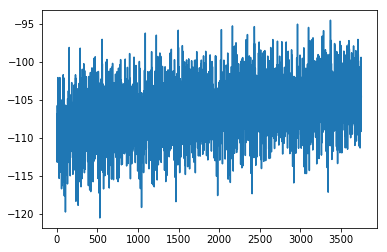

In [13]:
batch_size = 64
z_dim = 20

q_z0_logvar = torch.randn([batch_size,z_dim], requires_grad=True) 
q_z0_mean = torch.randn([batch_size,z_dim], requires_grad=True)
#q_z0_logvar_cuda = q_z0_logvar.cuda()
#q_z0_mean_cuda = q_z0_mean.cuda()

params1 = list(decoder.parameters())+list(q_z0.parameters())+list(r_v.parameters())
optimizer1 = optim.Adam(params1, lr=0.0005, weight_decay=5e-5)
#optimizer1 = optim.Adam([q_z0_mean], lr=0.005)
#optimizer2 = optim.Adam([q_z0_logvar], lr=0.005)

ELBO_list = []

for epoch in range(4):
    print("Epoch: "+str(epoch+1))
    for i in range(len(result)):
        print("++++++++++ batch: " + str(i) + " ++++++++++")
        data = result[i].float()
        #q_z0_logvar_cuda = q_z0_logvar.cuda()
        #q_z0_mean_cuda = q_z0_mean.cuda()
        optimizer1.zero_grad()
        #optimizer2.zero_grad()
        loss = 0. - ELBO(data, decoder, q_z0, r_v, 1)#_mean_cuda, q_z0_logvar_cuda)
        print("ELBO: "+str(0-loss.item()))
        ELBO_list.append(0-loss.item())
        loss.backward()
        print(q_z0.fc1.weight.grad)
        print(q_z0.fc31.weight.grad)
        print(q_z0.fc32.weight.grad)
        optimizer1.step()
        #optimizer2.step()
plt.plot(ELBO_list)

ELBO: -14.9396390914917
ELBO: -12.08021354675293
ELBO: -12.96286678314209
ELBO: -14.874403953552246
ELBO: -11.97666072845459
ELBO: -14.546634674072266
ELBO: -9.87025260925293
ELBO: -15.239564895629883
ELBO: -11.158679008483887
ELBO: -17.276914596557617
ELBO: -12.7967529296875
ELBO: -18.015766143798828
ELBO: -21.31466293334961
ELBO: -15.112458229064941
ELBO: -15.070599555969238
ELBO: -14.755515098571777
ELBO: -13.29301929473877
ELBO: -14.605469703674316
ELBO: -12.117304801940918
ELBO: -13.657644271850586
ELBO: -10.97036361694336
ELBO: -15.559090614318848
ELBO: -14.993773460388184
ELBO: -14.59350299835205
ELBO: -17.911861419677734
ELBO: -12.14599323272705
ELBO: -16.771560668945312
ELBO: -11.702110290527344
ELBO: -13.45708179473877
ELBO: -16.53024673461914
ELBO: -11.79418659210205
ELBO: -15.900860786437988
ELBO: -15.720958709716797
ELBO: -14.5488920211792
ELBO: -9.828661918640137
ELBO: -11.787944793701172
ELBO: -13.680306434631348
ELBO: -14.56186580657959
ELBO: -10.479950904846191
ELBO: -

ELBO: -1.0593780279159546
ELBO: -2.4035303592681885
ELBO: -3.0292856693267822
ELBO: -0.6252237558364868
ELBO: -3.4821975231170654
ELBO: -1.6687854528427124
ELBO: -2.2099735736846924
ELBO: -3.191725254058838
ELBO: -2.5867085456848145
ELBO: -3.320621967315674
ELBO: -3.3083627223968506
ELBO: -3.177084445953369
ELBO: -2.7245030403137207
ELBO: -3.137559413909912
ELBO: -2.8119804859161377
ELBO: -2.7840347290039062
ELBO: -0.700910210609436
ELBO: -3.6507959365844727
ELBO: -1.3768993616104126
ELBO: -2.4704558849334717
ELBO: -3.930791139602661
ELBO: -1.4160821437835693
ELBO: -2.0688812732696533
ELBO: -3.5802016258239746
ELBO: -1.0460350513458252
ELBO: -1.4750165939331055
ELBO: -2.815610408782959
ELBO: -0.7808448672294617
ELBO: -1.2189667224884033
ELBO: -2.5961151123046875
ELBO: -1.3338124752044678
ELBO: -2.2068681716918945
ELBO: -1.7987415790557861
ELBO: -0.1411321610212326
ELBO: -1.8296016454696655
ELBO: -3.3566012382507324
ELBO: -1.3969300985336304
ELBO: -1.7022173404693604
ELBO: -2.0083246231

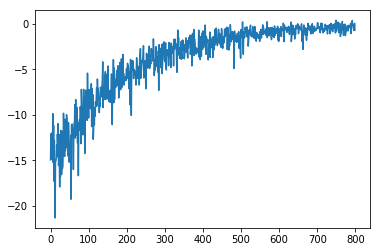

In [11]:
batch_size = 10
z_dim = 20
q_z0_logvar = torch.randn([batch_size,z_dim], requires_grad=True) 
q_z0_mean = torch.randn([batch_size,z_dim], requires_grad=True) 
#q_z0_logvar = torch.zeros([num,2], requires_grad=True) 
#q_z0_mean = torch.zeros([num,2], requires_grad=True) 

optimizer1 = optim.Adam([q_z0_mean], lr=0.005)
optimizer2 = optim.Adam([q_z0_logvar], lr=0.005)
ELBO_list = []

for i in range(800):
    #z0 = reparameterize(q_z0_mean, q_z0_logvar)
    #print("z0: "+str(z0.shape))
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    loss =  0. - ELBO(q_z0_mean, q_z0_logvar) 
    print("ELBO: "+str(0-loss.item()))
    ELBO_list.append(0-loss.item())
    loss.backward()
    #print(q_z0_logvar.grad)
    
    #print(q_z0_logvar)
    optimizer1.step()
    optimizer2.step()
plt.plot(ELBO_list)

In [70]:
m = torch.tensor([[0.,0.],[0.,0.],[0.,0.]], requires_grad=True)
cov = torch.tensor([[1.,1.],[1.,1.],[1.,1.]], requires_grad=True)
x =  torch.tensor([[0.,1.],[1.,1.],[0.,0.]], requires_grad=True)
#loss = torch.mean(multivariate_normal_diagonal_logpdf(m, cov, x))
loss = torch.mean(log_prior(x))
loss.backward()
x.grad

tensor([[ 0.0000, -0.3333],
        [-0.3333, -0.3333],
        [ 0.0000,  0.0000]])

In [72]:
def new_normal(mean, cov_diag, x):
    n = x.shape[0] # number of samples
    k = x.shape[1] # dimension
    t1 = -0.5*(x - mean)**2*(1/cov_diag)#*(x-mean)
    print("t1: "+str(t1))
    t1 = torch.sum(t1, dim=1)
    print("t1: "+str(t1))
    #t2 = 0.5*k*torch.log(2*torch.tensor([math.pi]).cuda()) + 0.5*torch.log(torch.prod(cov_diag,1)).cuda()
    tmp = torch.log(cov_diag)
    print("tmp: "+str(tmp))
    print("0.5 sum tmp: "+str(0.5*torch.sum(tmp,dim=1)))
    
    t2 = 0.5*k*torch.log(torch.tensor([2*math.pi])) + 0.5*torch.sum(tmp,dim=1)
    print("t2: "+str(t2))
    #print("t1: "+str(t1)+"t2: "+str(t2))
    return t1 - t2

In [73]:
m = torch.tensor([[0.,0.],[0.,0.],[0.,0.]])
cov = torch.tensor([[2.,1.],[1.,1.],[1.,1.]])
x =  torch.tensor([[0.,1.],[1.,1.],[0.,0.]])


In [74]:
res = new_normal(m,cov,x)
print(res)

t1: tensor([[-0.0000, -0.5000],
        [-0.5000, -0.5000],
        [-0.0000, -0.0000]])
t1: tensor([-0.5000, -1.0000,  0.0000])
tmp: tensor([[ 0.6931,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]])
0.5 sum tmp: tensor([ 0.3466,  0.0000,  0.0000])
t2: tensor([ 2.1845,  1.8379,  1.8379])
tensor([-2.6845, -2.8379, -1.8379])


In [59]:
m = torch.tensor([[0.,0.]])
cov = torch.tensor([[1.,0.],[0.,1.]])
x =  torch.tensor([[0.,0.]])
#cov = torch.eye(dim).cuda()
m = MultivariateNormal(m, cov)
m.requires_grad=True
m.log_prob(x)

tensor([-1.8379])

In [81]:
"""
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)
"""
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    #return eps.mul(std).add_(mu)
    return eps*std+mu

def log_prior(z):
    dim = z.shape[1]
    mean = torch.zeros(dim)
    cov = torch.eye(dim)
    #print("mean: "+str(mean))
    #print("cov: "+str(cov))
    #print("z: "+str(z))
    m = MultivariateNormal(mean, cov)
    m.requires_grad=True
    return m.log_prob(z)

def multivariate_normal_diagonal_logpdf(mean, cov_diag, x):
    n = x.shape[0] # number of samples
    k = x.shape[1] # dimension
    t1 = -0.5*(x - mean)*(1/cov_diag)*(x-mean)
    t1 = torch.sum(t1, dim=1)
    #t2 = 0.5*k*torch.log(2*torch.tensor([math.pi]).cuda()) + 0.5*torch.log(torch.prod(cov_diag,1)).cuda()
    t2 = 0.5*k*torch.log(2*torch.tensor([math.pi])) + 0.5*torch.sum(torch.log(cov_diag),dim=1)
    #print("t1: "+str(t1)+"t2: "+str(t2))
    return t1 - t2

def test(z0, q_z0_mean, q_z0_logvar):
    num = q_z0_mean.shape[0]
    dim = q_z0_mean.shape[1]
    var_z0 = torch.exp(q_z0_logvar)
    print("var_z0: "+str(var_z0.shape))
    log_q_z0 = multivariate_normal_diagonal_logpdf(q_z0_mean, var_z0, z0)
    log_prior_z0 = log_prior(z0)
    """
    m = torch.zeros([num, dim], requires_grad=True)
    v = torch.ones([num, dim], requires_grad=True)
    log_prior_z0 = multivariate_normal_diagonal_logpdf(m,v,z0)
    """
    L = log_prior_z0 - log_q_z0
    print(z0.shape)
    print(log_prior_z0)
    print(log_q_z0)
    #rint(L.shape)
    print("L: "+str(L))
    #return torch.mean(L)
    return torch.sum(L)

In [76]:
#mu = torch.tensor([[0.,0.],[0.,0.]])
#logvar = torch.tensor([[0.,0.],[0.,0.]])
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    #return eps.mul(std).add_(mu)
    return eps*std+mu
mu = torch.ones([2,2], requires_grad=True)
logvar = torch.zeros([2,2], requires_grad=True)
z0 = reparameterize(mu, logvar)
loss = torch.sum(z0)
loss.backward()
mu.grad
z0

tensor([[ 2.9391,  0.8824],
        [ 0.1994,  0.6772]])

In [16]:
x1_list = []
x2_list = []
for i in range(z0.shape[0]):
    x1_list.append(z0[i][0])
    x2_list.append(z0[i][1])

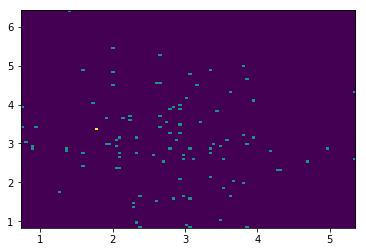

In [17]:
h = plt.hist2d(x1_list, x2_list, bins = [100, 100])

In [82]:
#q_z0_logvar = torch.tensor([[0.1,0.1]], requires_grad=True)
#q_z0_mean = torch.zeros(2, requires_grad=True)
num = 10
q_z0_logvar = torch.randn([num,2], requires_grad=True) 
q_z0_mean = torch.randn([num,2], requires_grad=True) 
#q_z0_logvar = torch.zeros([num,2], requires_grad=True) 
#q_z0_mean = torch.zeros([num,2], requires_grad=True) 

optimizer1 = optim.Adam([q_z0_mean], lr=0.005)
optimizer2 = optim.Adam([q_z0_logvar], lr=0.005)
ELBO_list = []

for i in range(800):
    #print(q_z0_logvar)
    #q_z0_logvar_cuda = q_z0_logvar.cuda()
    #q_z0_mean_cuda = q_z0_mean.cuda()
    z0 = reparameterize(q_z0_mean, q_z0_logvar)
    #print("z0: "+str(z0.shape))
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    loss =  0. - test(z0,q_z0_mean, q_z0_logvar) 
    print("ELBO: "+str(0-loss.item()))
    ELBO_list.append(0-loss.item()/num)
    loss.backward()
    print(q_z0_logvar.grad)
    
    #print(q_z0_logvar)
    optimizer1.step()
    optimizer2.step()

var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([-3.1831, -3.1420, -2.7362, -6.3020, -3.9787, -2.7319, -3.0194,
        -6.7476, -1.8708, -3.0307])
tensor([-2.0633, -3.2207, -1.5395, -4.5121, -2.2684, -2.0391, -2.3595,
        -4.6714, -1.1683, -1.5777])
L: tensor([-1.1198,  0.0787, -1.1967, -1.7899, -1.7104, -0.6929, -0.6599,
        -2.0762, -0.7026, -1.4530])
ELBO: -11.322582244873047
tensor([[-0.2475, -0.6328],
        [-0.2353,  0.4171],
        [-0.3983, -0.8785],
        [ 0.2190,  3.0499],
        [ 0.3460, -0.3032],
        [-0.0885, -0.6282],
        [-0.6688, -0.2993],
        [ 0.8417,  2.2947],
        [-0.4779, -0.4633],
        [-0.8350, -0.5211]])
var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([ -2.2208,  -4.7694,  -8.2505,  -6.7120,  -6.5405,  -4.9607,
         -1.9795, -10.2729,  -3.1527,  -3.7942])
tensor([-2.4405, -4.0105, -6.7830, -6.9513, -5.3205, -3.3202, -3.4291,
        -4.5724, -0.7743, -1.4235])
L: tensor([ 0.2197, -0.7589, -1.4676,  0.2392, -1

torch.Size([10, 2])
tensor([-3.8115, -7.5867, -2.2362, -3.8562, -2.0402, -3.2018, -5.3894,
        -1.8678, -3.7095, -4.5356])
tensor([-2.2464, -4.5780, -2.3546, -4.0204, -2.0601, -2.7508, -2.6195,
        -2.9783, -2.1398, -1.7734])
L: tensor([-1.5651, -3.0087,  0.1185,  0.1642,  0.0199, -0.4510, -2.7699,
         1.1105, -1.5698, -2.7622])
ELBO: -10.713545799255371
tensor([[ 0.3547, -0.6037],
        [ 1.5823,  2.5218],
        [-0.4152, -0.8296],
        [ 1.2194, -0.3430],
        [-0.3715, -0.6446],
        [-0.4994,  0.1511],
        [ 0.2518,  0.3155],
        [-0.4576, -0.5112],
        [-0.4535,  0.6515],
        [-0.1884, -0.1809]])
var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([-3.2627, -2.1696, -2.2004, -2.6487, -2.8562, -3.6925, -2.8152,
        -9.3893, -1.9879, -4.5575])
tensor([-2.7881, -2.7846, -2.3904, -2.8673, -1.8615, -2.6908, -2.7029,
        -4.0856, -1.7233, -3.5347])
L: tensor([-0.4745,  0.6150,  0.1900,  0.2186, -0.9947, -1.0017, -0.1123,
        -5.30

tensor([[-0.4696, -0.4154],
        [-0.4397, -0.3652],
        [-0.4816, -0.4513],
        [-0.4441, -0.4941],
        [-0.1118,  0.3518],
        [-0.0433,  0.3003],
        [-0.5812,  1.3225],
        [ 2.5455, -0.0956],
        [-0.4637, -0.5365],
        [ 0.2576, -0.5094]])
var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([ -5.1518,  -3.0370,  -2.7407,  -2.0095,  -4.5033,  -2.4172,
         -4.4038, -16.1851,  -2.0493,  -2.2356])
tensor([-3.7391, -3.0903, -1.8555, -2.1644, -4.3844, -1.8222, -3.6606,
        -5.6539, -1.4985, -4.3831])
L: tensor([ -1.4127,   0.0533,  -0.8851,   0.1549,  -0.1189,  -0.5950,
         -0.7432, -10.5312,  -0.5508,   2.1475])
ELBO: -12.481058120727539
tensor([[ -0.2392,   1.1778],
        [  0.1473,  -0.0552],
        [ -0.1214,  -0.6924],
        [ -0.4981,  -0.3823],
        [  1.9959,  -0.5739],
        [ -0.4390,  -0.3802],
        [  1.0741,  -0.2310],
        [ 13.5734,  -0.3558],
        [ -0.4953,  -0.1217],
        [  0.2682,  -0.4994]])


L: tensor([ 1.2715,  0.1833, -1.6255,  0.2382, -0.8608,  0.1709, -1.2451,
         0.3010,  0.0006, -0.1406])
ELBO: -1.7064448595046997
tensor([[-0.2772,  0.6802],
        [-0.1379,  0.0830],
        [-0.3589, -0.2345],
        [-0.4534, -0.5023],
        [-0.1927,  0.3123],
        [-0.3671, -0.4681],
        [-0.5438,  0.7799],
        [ 0.1048, -0.4644],
        [-0.3085, -0.5095],
        [-0.3091,  0.9121]])
var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([-11.7017,  -5.0253,  -3.0837,  -1.8518,  -2.2718,  -2.2606,
         -6.2821, -11.6359,  -2.7945,  -1.9042])
tensor([-5.4875, -3.9156, -4.3487, -2.1184, -1.9434, -1.8216, -3.4756,
        -4.9187, -1.9281, -2.2068])
L: tensor([-6.2142, -1.1096,  1.2650,  0.2666, -0.3285, -0.4390, -2.8064,
        -6.7171, -0.8664,  0.3026])
ELBO: -16.6469669342041
tensor([[ 7.5680, -0.4702],
        [ 2.0547, -0.0778],
        [ 0.7421, -0.6411],
        [-0.5007, -0.4764],
        [-0.2257, -0.5530],
        [-0.4181, -0.4509],
        [

tensor([-10.1337,  -2.6899,  -3.5948,  -2.0627,  -7.7424,  -3.7742,
         -3.1995,  -2.8002,  -3.7338,  -4.1228])
tensor([-5.3303, -2.8829, -2.9976, -2.3322, -7.4415, -4.3567, -4.7564,
        -2.8863, -2.7725, -2.4023])
L: tensor([-4.8034,  0.1930, -0.5972,  0.2695, -0.3009,  0.5825,  1.5569,
         0.0862, -0.9613, -1.7205])
ELBO: -5.69521427154541
tensor([[ 6.1942, -0.2245],
        [-0.4805,  0.3003],
        [ 0.5886, -0.3566],
        [-0.2939, -0.4638],
        [-0.4657,  4.4611],
        [ 1.3073,  0.0355],
        [ 1.2368, -0.3425],
        [ 0.4466, -0.4946],
        [-0.4142,  1.0038],
        [ 0.3660, -0.1962]])
var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([-3.8999, -5.2680, -2.9439, -6.8892, -1.8694, -2.3330, -3.0193,
        -2.0183, -2.0425, -4.6716])
tensor([-3.8791, -4.1087, -2.4718, -5.2139, -1.7735, -2.3426, -2.2635,
        -2.6949, -1.7171, -2.6690])
L: tensor([-0.0208, -1.1593, -0.4721, -1.6754, -0.0958,  0.0096, -0.7558,
         0.6766, -0.3254,

ELBO: -11.125436782836914
tensor([[ -0.1596,  -0.2333],
        [ -0.4855,   0.4616],
        [ -0.5002,  -0.2893],
        [ -0.2571,   0.6835],
        [ -0.4998,  -0.3614],
        [  0.2261,  -0.5068],
        [ -0.3773,  -0.4806],
        [ 14.0076,   0.5708],
        [ -0.0736,  -0.5028],
        [ -0.2976,  -0.2256]])
var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([-2.9620, -2.1761, -2.2834, -1.9445, -2.3919, -2.1577, -1.9281,
        -3.6538, -3.4841, -3.4436])
tensor([-3.1909, -2.4697, -1.6902, -2.1703, -1.9850, -2.1493, -2.3756,
        -3.0897, -3.2925, -2.4018])
L: tensor([ 0.2289,  0.2937, -0.5932,  0.2258, -0.4069, -0.0084,  0.4476,
        -0.5641, -0.1916, -1.0418])
ELBO: -1.6101245880126953
tensor([[ 0.9671, -0.5088],
        [-0.3501, -0.3661],
        [-0.2617, -0.5041],
        [-0.3985, -0.4838],
        [-0.4826, -0.1653],
        [-0.3103, -0.4382],
        [-0.3225, -0.5005],
        [ 1.2646, -0.4856],
        [-0.4763,  1.2875],
        [ 0.2843, -0.34

torch.Size([10, 2])
tensor([-2.4236, -2.2840, -3.6923, -2.5651, -2.2369, -2.1288, -1.8405,
        -2.3510, -3.0108, -3.3911])
tensor([-2.5747, -2.6297, -3.1596, -2.8132, -1.9298, -2.1815, -2.0316,
        -3.0094, -3.4599, -2.3667])
L: tensor([ 0.1511,  0.3457, -0.5328,  0.2481, -0.3072,  0.0527,  0.1911,
         0.6584,  0.4491, -1.0244])
ELBO: 0.23202037811279297
tensor([[-0.3364, -0.1326],
        [-0.1527, -0.3348],
        [-0.2631,  0.6182],
        [ 0.1593, -0.3846],
        [-0.4460, -0.2882],
        [-0.2785, -0.4096],
        [-0.5042, -0.4889],
        [-0.4886,  0.0573],
        [-0.0411,  0.2752],
        [ 0.3683, -0.4144]])
var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([-4.5075, -2.8954, -2.6215, -2.7571, -2.9893, -3.6491, -2.8819,
        -4.8941, -1.9661, -5.3254])
tensor([-4.3549, -3.0055, -2.5463, -2.9381, -3.2145, -3.2458, -2.3994,
        -3.5615, -1.4813, -5.6775])
L: tensor([-0.1527,  0.1101, -0.0753,  0.1810,  0.2251, -0.4034, -0.4825,
        -1.33

torch.Size([10, 2])
tensor([-4.4456, -2.7415, -3.8730, -2.3342, -3.0627, -2.7379, -1.9436,
        -1.9476, -2.4736, -3.8692])
tensor([-3.3780, -2.7550, -3.5236, -2.3398, -3.0244, -3.0079, -1.9443,
        -2.4870, -2.9839, -4.2686])
L: tensor([-1.0676,  0.0135, -0.3494,  0.0056, -0.0383,  0.2699,  0.0008,
         0.5394,  0.5103,  0.3995])
ELBO: 0.2836723327636719
tensor([[ 1.6155, -0.3460],
        [ 0.2605, -0.4079],
        [ 0.2893,  0.3985],
        [-0.4949, -0.0157],
        [ 0.6890, -0.4551],
        [-0.3595,  0.2502],
        [-0.4625, -0.5060],
        [-0.3624, -0.5000],
        [ 0.1350, -0.5013],
        [-0.1702,  1.2409]])
var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([-2.3377, -3.0225, -8.8473, -2.3884, -2.4162, -1.8932, -1.9078,
        -2.0738, -2.4672, -2.5839])
tensor([ -2.3872,  -2.9394, -11.0027,  -2.5719,  -2.6535,  -2.0185,
         -1.9373,  -2.5834,  -2.8116,  -2.3105])
L: tensor([ 0.0494, -0.0831,  2.1555,  0.1835,  0.2372,  0.1253,  0.0295,
    

var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([ -2.3596, -12.0861,  -2.7090,  -2.7048,  -2.2703,  -2.8690,
         -1.9747,  -2.4134,  -2.3377,  -2.2027])
tensor([-2.5253, -9.4162, -2.3841, -2.6752, -2.1225, -2.9740, -2.1211,
        -2.9591, -2.0686, -2.0886])
L: tensor([ 0.1657, -2.6699, -0.3249, -0.0297, -0.1479,  0.1050,  0.1464,
         0.5457, -0.2690, -0.1141])
ELBO: -2.5926332473754883
tensor([[ 0.1327, -0.5017],
        [ 5.4725,  3.5300],
        [-0.4131,  0.1094],
        [-0.3257,  0.1791],
        [-0.2672, -0.3529],
        [-0.1579,  0.1656],
        [-0.4929, -0.3443],
        [-0.4572,  0.0749],
        [-0.3174, -0.2358],
        [-0.4953, -0.2057]])
var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([-2.2263, -1.9387, -2.3687, -4.0023, -3.3774, -7.8878, -2.2187,
        -2.5471, -1.9553, -4.1414])
tensor([-2.5760, -2.1722, -1.9775, -3.9286, -3.3574, -6.3723, -2.3669,
        -2.8274, -1.7083, -3.4558])
L: tensor([ 0.3496,  0.2335, -0.3912, -0.0737, -0

tensor([[-0.3603, -0.4535],
        [ 0.0653, -0.0761],
        [-0.3071,  0.7326],
        [-0.4973,  1.2495],
        [-0.3418,  2.5024],
        [ 0.1533, -0.2147],
        [-0.4641,  0.8352],
        [ 1.8348, -0.4911],
        [ 0.0915, -0.2760],
        [-0.4014, -0.4943]])
var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([-4.7811, -7.7397, -2.0007, -2.2058, -2.7005, -4.0594, -3.0165,
        -2.5740, -3.8883, -2.1902])
tensor([-4.3051, -6.4953, -1.9702, -2.2771, -2.6879, -3.4229, -2.9283,
        -2.5898, -3.8103, -1.9954])
L: tensor([-0.4761, -1.2444, -0.0305,  0.0713, -0.0126, -0.6365, -0.0882,
         0.0158, -0.0780, -0.1948])
ELBO: -2.6740074157714844
tensor([[ 0.7660,  0.9681],
        [-0.5001,  5.3126],
        [-0.3847, -0.4016],
        [-0.4927, -0.1269],
        [-0.4842,  0.3106],
        [ 1.6649, -0.4941],
        [-0.1239,  0.2605],
        [ 0.1117, -0.4409],
        [-0.4398,  1.5784],
        [-0.4411, -0.3139]])
var_z0: torch.Size([10, 2])
torch.Size([

tensor([-3.1137, -3.1960, -4.9201, -2.2844, -1.9618, -2.7103, -2.9187,
        -2.5932, -2.4593, -2.3115])
L: tensor([ 0.1850, -0.0484,  0.1211,  0.0713, -0.0498,  0.1077, -0.1529,
         0.1313, -0.0089, -0.3307])
ELBO: 0.02565455436706543
tensor([[-0.3816,  0.5046],
        [-0.1670,  0.5793],
        [ 2.2667, -0.2844],
        [-0.4977, -0.1185],
        [-0.3455, -0.5000],
        [-0.4472,  0.1848],
        [-0.3177,  0.4923],
        [-0.0608, -0.3449],
        [-0.0854, -0.3002],
        [ 0.1210, -0.4998]])
var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([-2.0184, -2.3009, -3.0471, -3.2239, -2.9564, -3.0315, -2.1775,
        -6.0494, -2.2116, -2.2094])
tensor([-2.1511, -2.4605, -2.9450, -3.1585, -2.7778, -2.8571, -2.2403,
        -4.2264, -2.0103, -2.0385])
L: tensor([ 0.1326,  0.1596, -0.1021, -0.0654, -0.1786, -0.1744,  0.0627,
        -1.8230, -0.2013, -0.1709])
ELBO: -2.3606982231140137
tensor([[-0.4610, -0.3417],
        [-0.4928, -0.0201],
        [ 0.7180, -0.5

torch.Size([10, 2])
tensor([-1.9059, -2.2267, -3.0009, -2.2959, -3.2874, -2.5418, -2.8317,
        -2.1326, -1.9197, -2.3589])
tensor([-2.0461, -2.3072, -2.9971, -2.2909, -3.3973, -2.4819, -2.8639,
        -2.4122, -1.6965, -2.2148])
L: tensor([ 0.1402,  0.0805, -0.0037, -0.0050,  0.1098, -0.0600,  0.0322,
         0.2796, -0.2232, -0.1441])
ELBO: 0.2063065767288208
tensor([[-0.4029, -0.4972],
        [-0.4912, -0.1458],
        [-0.3953,  0.4962],
        [-0.4859, -0.0766],
        [-0.4841,  0.9272],
        [ 0.1984, -0.4989],
        [-0.0382,  0.0486],
        [-0.2441, -0.4700],
        [-0.4452, -0.4813],
        [-0.2122, -0.3571]])
var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([-2.4912, -2.3657, -1.8881, -2.7080, -1.9581, -3.7709, -4.2325,
        -4.6765, -2.0297, -2.0548])
tensor([-2.6148, -2.4988, -1.7303, -2.7286, -1.9680, -3.7062, -4.4316,
        -5.0375, -1.7997, -2.0465])
L: tensor([ 0.1237,  0.1331, -0.1578,  0.0206,  0.0099, -0.0647,  0.1990,
         0.361

tensor([[-0.4714, -0.1008],
        [ 0.5932,  0.8734],
        [-0.4377, -0.2667],
        [-0.3461,  0.1103],
        [-0.4792, -0.5002],
        [-0.3032, -0.1036],
        [-0.1348, -0.5007],
        [ 3.4265,  0.6365],
        [ 0.0382, -0.4918],
        [-0.0478, -0.4468]])
var_z0: torch.Size([10, 2])
torch.Size([10, 2])
tensor([-2.3847, -3.6012, -3.4887, -2.4093, -2.1666, -3.7072, -3.0705,
        -2.3129, -2.5780, -2.7641])
tensor([-2.3624, -3.5181, -3.5662, -2.4033, -2.1403, -3.2965, -3.1388,
        -2.5011, -2.6689, -2.9990])
L: tensor([-0.0224, -0.0830,  0.0775, -0.0061, -0.0262, -0.4107,  0.0683,
         0.1882,  0.0909,  0.2349])
ELBO: 0.11151123046875
tensor([[-0.3590, -0.1469],
        [ 1.1050, -0.3398],
        [ 0.3810,  0.2630],
        [-0.4566,  0.0175],
        [-0.3079, -0.3904],
        [ 1.2980, -0.4865],
        [-0.4315,  0.7335],
        [-0.0257, -0.4837],
        [ 0.1561, -0.3947],
        [ 0.5041, -0.4836]])
var_z0: torch.Size([10, 2])
torch.Size([10,

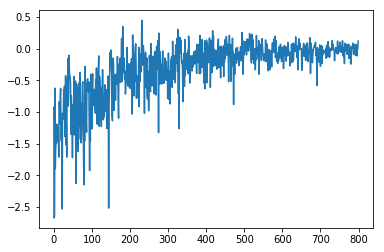

In [87]:
plt.plot(ELBO_list)

tensor([-1.], device='cuda:0')